The `Grizli` pipeline allows you to fully reduce a given set of HST grism observations with essentially two steps:

* Run an archive query with [`hsaquery`](https://github.com/gbrammer/esa-hsaquery)

* Process the associations found with the query with `grizli.auto_script.go`.

Here, "association" usually simply means "any Hubble exposures that overlap" and doesn't require that all observations were taken with the same observing program, instrument, grism position angle, epoch, filter, etc.  The code does all of the exposure-level book-keeping and the products are drizzled image mosaics, extracted 1D and 2D grism spectra and fits to the spectra.

**NB**: The pipeline works fine with just imaging and no grism exposures!

In [1]:
#cell 1
%matplotlib inline

In [2]:
#cell 2
import glob
import time
import os

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

import astropy.io.fits as pyfits
import drizzlepac

import grizli
from grizli.pipeline import auto_script 
from grizli import utils
from grizli import fitting
from grizli import multifit #original line, replaced by cell above 

utils.set_warnings()
print('\n Grizli version: ', grizli.__version__)

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol

 Grizli version:  0.8.0-45-g977ade9


In [3]:
#cell 3
#os.chdir('/Users/brammer/3DHST/Spectra/Work/Grizli/Demo-18.05.22/')
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


## Query the HST archive ##

The `hsaquery` module can be used to programaticaly query the HST archive and find exposures from different programs (and instruments) that overlap on the sky.  The example below is tailored for a single pointing from a single program, but the query parameters can be expanded to search much more broadly for archival data.

In [4]:
#cell 4
### Generate a query for the WFC3/ERS grism data

## !! new query tools since ESA database changed in summer 2018
# https://github.com/gbrammer/mastquery
from mastquery import query, overlaps

# "parent" query is grism exposures in GO-11359.  Can also query the archive on position with
# box=[ra, dec, radius_in_arcmin]
parent = query.run_query(box=None, proposal_id=[12945], instruments=['WFC3/IR', 'ACS/WFC'], 
                         filters=['G102','G141'])

# ### "overlap" query finds anything that overlaps with the exposures 
# ### in the parent query
# extra = query.DEFAULT_EXTRA # ignore calibrations, etc.

# ## To match *just* the grism visits, add, e.g., the following:
# extra += ["TARGET.TARGET_NAME LIKE 'WFC3-ERSII-G01'"]

tabs = overlaps.find_overlaps(parent, buffer_arcmin=0.01, 
                              filters=['F105W', 'F814W','G102'], 
                              proposal_id=[12945], instruments=['WFC3/IR','WFC3/UVIS','ACS/WFC']) 
                              #,extra={'target_name':'CL1059-12.0'}, close=False)

Iter #1, N_Patch = 14


 0 j105908m1246 164.779 -12.773
target_name
-----------
CL1059-12.0 

filter j105908m1246         WFC3/IR F105W    1     811.7
filter j105908m1246          WFC3/IR G102    1    4711.7


 1 j105900m1253 164.747 -12.878
target_name
-----------
        ANY
CL1059-12.1 

filter j105900m1253         ACS/WFC F814W    1     460.0
filter j105900m1253         WFC3/IR F105W    1     811.7
filter j105900m1253          WFC3/IR G102    1    4711.7


 2 j105912m1254 164.794 -12.903
target_name
-----------
CL1059-12.2 

filter j105912m1254         WFC3/IR F105W    1     811.7
filter j105912m1254          WFC3/IR G102    1    4711.7


 3 j105836m1254 164.644 -12.893
target_name
-----------
CL1059-12.3 

filter j105836m1254         WFC3/IR F105W    1     811.7
filter j105836m1254          WFC3/IR G102    1    4711.7


 4 j113812m1134 174.554 -11.573
target_name
-----------
CL1138-11.0 

filter j113812m1134         WFC3/IR F105W    1     811.7
filter j113812m1134          WFC3/IR

In [5]:
#cell 5
# Summary of the tables you just generated
foot_files = glob.glob('j[02]*footprint.fits')
print('Footprint files: ', foot_files)

print('\n# id            ra         dec        e(b-v)   filters')
for tab in tabs:
    print('{0}  {1:.5f}  {2:.5f}   {3:.4f}   {4}'.format(tab.meta['NAME'], tab.meta['RA'], 
                                                 tab.meta['DEC'], tab.meta['MW_EBV'],
                                                  ','.join(np.unique(tab['filter']))))

Footprint files:  []

# id            ra         dec        e(b-v)   filters
j105908m1246  164.77900  -12.77300   0.0281   F105W,G102
j105900m1253  164.74700  -12.87800   0.0273   F105W,F814W,G102
j105912m1254  164.79400  -12.90300   0.0270   F105W,G102
j105836m1254  164.64400  -12.89300   0.0291   F105W,G102
j113812m1134  174.55400  -11.57300   0.0172   F105W,G102
j113848m1134  174.70000  -11.57500   0.0174   F105W,G102
j113736m1125  174.39300  -11.42300   0.0217   F105W,G102
j122756m1136  186.98400  -11.60300   0.0409   F105W,F814W,G102
j122752m1140  186.96700  -11.66100   0.0398   F105W,G102
j122816m1132  187.07100  -11.52800   0.0433   F105W,G102
j130132m1138  195.37900  -11.62600   0.0411   F105W,F814W,G102
j130120m1133  195.34100  -11.54500   0.0415   F105W,G102
j130132m1142  195.38900  -11.69800   0.0407   F105W,F814W,G102
j130100m1131  195.24700  -11.52100   0.0405   F105W,G102


In [6]:
#cell 6
#os.chdir('/Users/brammer/3DHST/Spectra/Work/Grizli/Demo-18.05.22/')
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


# - Pipeline processing - #

** In principle, all of the steps outlined below can be executed with a single call to** `auto_script.go`, from fetching the data to extracting spectra and performing the redshift / line fits.  The processing steps been broken out individually here to show the processing at each step.

** The same pipeline can be used to process imaging-only fields.**  Simply run the queries as above to find the imaging exposures you want to processes and run everything the same way.  The pipeline steps related to the grism exposures will simply be skipped.

In [7]:
#cell 7
# Do everything for the query from fetching the data to generating the contamination model
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

"CHANGE FILE DIRECTORY HERE"
root = 'j105900m1253'
IS_PARALLEL = False # Set to True for parallel programs like WISPS

if False:
    # This line would do everything below
    auto_script.go(root=root, maglim=[19,21], HOME_PATH=HOME_PATH, reprocess_parallel=True, 
                   s3_sync='cp', gaia_by_date=True, is_parallel_field=IS_PARALLEL, 
                   run_fit=False, only_preprocess=True, run_extractions=False)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


# - Individual steps - #

## Fetch data from the HST archive ##
`Grizli` can automatically fetch HST data from the ESA Hubble Science archive (and, optionally, the Amazon S3 bucket).  The `fetch_files` script fetches the exposures listed in the archive query above.  It also fetches associated WFC3/IR persistence products from the persistence database.

The first time you run the script, a lot more information will be printed to the screen as the exposures are retrieved and the script runs the reprocessing code to flatten the IR backgrounds.  Below the "skip" message simply indicate that files have already been downloaded.

In [8]:
#cell 8 THIS TAKES A LONG TIME
### Fetch data, reprocess WFC3/IR for backgrounds, fetch WFC3/IR persistence productss

# If s3_sync, then sync from the Hubble Amazon S3 bucket with awscli, 
# otherwise get from the ESA archive.
os.chdir(HOME_PATH)

import grizli.pipeline
from grizli.pipeline import auto_script
# Is awscli available and connected? 
s3_status = os.system('aws s3 ls s3://stpubdata --request-payer requester')
if s3_status == 0:
    s3_sync='cp'  # As of late October 2018, 's3 sync' not working with 'stpubdata'
else:
    s3_sync=False # Fetch from ESA archive
    
auto_script.fetch_files(field_root=root, HOME_PATH=HOME_PATH, remove_bad=True, 
                        reprocess_parallel=True, s3_sync=s3_sync)

Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$u4m1335li_pfl.fits
/home/jrcooper/grizli/iref/u4m1335li_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$uc72113oi_pfl.fits
/home/jrcooper/grizli/iref/uc72113oi_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=jref$0461802dj_idc.fits
/home/jrcooper/grizli/jref/0461802dj_idc.fits exists
Calib: PFLTFILE=jref$qb12257pj_pfl.fits
/home/jrcooper/grizli/jref/qb12257pj_pfl.fits exists
Calib: NPOLFILE=jref$02c1450rj_npl.fits
/home/jrcooper/grizli/jref/02c1450rj_npl.fits exists
Calib: IDCTAB=jref$0461802dj_idc.fits
/home/jrcooper/grizli/jref/0461802dj_idc.fits exists
Calib: PFLTFILE=jref$qb12257pj_pfl.fits
/home/jrcooper/grizli/jref/qb12257pj_pfl.fits exists
Calib: NPOLFILE=jref$02c1450rj_npl.fits
/home/jrcooper/grizli/jref/02c1450rj_npl.fits exists
Calib: IDCTAB=iref$w3m18525i_idc.fits


## Parse visit associations ##
`Grizli` builds its own associations based on anything it finds in the `RAW` directory.  Visits are usually defined in the exposure filenames.  For example, for the single exposure, `ib6o03ntq_flt.fits`, the characters `b6o` identify the observing program and the visit identifier  is `03`.  You can also build visits combining all exposures in a given filter taken at the same position angle, which can be useful for some programs executed in parallel where exposures taken at a similar time could have different visit IDs in the filename.  

**NB:** Generally one should process "visits" as groups of exposures in a given filter that were taken with a single guide star acquisition.  

The parsing script also associates grism exposures with corresponding direct images, based on the visit, exposure order and exposure footprints on the sky.

In [9]:
#cell 11
# Demo combining by PA / filter.  

# Here it actually gets a bit confused because multiple F098M exposures 
# were taken at the same PA but shouldn't be associated with the grism exposures.
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
visits, all_groups, info = auto_script.parse_visits(field_root=root, 
                                                    HOME_PATH=HOME_PATH, use_visit=True, 
                                                    combine_same_pa=True)

print('\n ====== \n')
for visit in visits:
    print('{0:30} {1:>2d}'.format(visit['product'], len(visit['files'])))

CL1059-12.1-c1b-02-269.0-F105W 4
CL1059-12.1-c1b-02-269.0-G102 4
jc1b01-c1b-01-145.0-F814W 4

 == Grism groups ==

ic1b-269.0-f105w 4 ic1b-269.0-g102 4


ic1b-269.0-f105w                4
ic1b-269.0-g102                 4
ic1b-145.0-f814w                4


In [10]:
#cell 12
######################
### Parse visit associations for most normal programs
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
visits, all_groups, info = auto_script.parse_visits(field_root=root, 
                                                    HOME_PATH=HOME_PATH, use_visit=True, 
                                                    combine_same_pa=IS_PARALLEL)

print('\n ====== \n')
for visit in visits:
    print('{0:30} {1:>2d}'.format(visit['product'], len(visit['files'])))

CL1059-12.1-c1b-02-269.0-F105W 4
CL1059-12.1-c1b-02-269.0-G102 4
jc1b01-c1b-01-145.0-F814W 4

 == Grism groups ==

cl1059-12.1-c1b-02-269.0-f105w 4 cl1059-12.1-c1b-02-269.0-g102 4


cl1059-12.1-c1b-02-269.0-f105w  4
cl1059-12.1-c1b-02-269.0-g102   4
jc1b01-c1b-01-145.0-f814w       4


## Master Pre-processing script: `grizli.prep.process_direct_grism_visit` ##

The `process_direct_grism_visit` script in [prep.py](https://github.com/gbrammer/grizli/blob/master/grizli/prep.py) provides one-stop-shopping for all of the preprocessing steps required.  This includes

* File handling (e.g., copying from `./RAW` to `./Prep/`)
* Astrometric registration
* Grism sky background subtraction & flat-fielding
* Extract visit-level catalogs and segmentation images from the direct imaging

The products of the script for a given direct/grism pair are 

* Aligned, background-subtracted FLTs
* Drizzled mosaics of direct & grism images

The script also runs on *imaging-only* visits, performing the background subtraction and astrometric alignment but skipping anything related to grism processing.

The `auto_script.preprocess` command below runs the processing script for the two direct/grism pairs of the ERS observations and for the overlapping imaging visits identified in the initial query.  It prints a bunch of information to the terminal, primarily from various runs of AstroDrizzle, and takes a few minutes to run per visit.  It only needs to be run once.

**NB** If you restart the pipeline after a previous run, it will skip preprocessing any visit where the file `{visit-product}_dr?_sci.fits` is found (i.e., the "Skip" messages below).  If you want to force reprocessing of a visit, delete that file.

In [11]:
#####################
### Alignment & mosaics    
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

# Alignment reference catalogs, searched in this order
catalogs = ['NSC', 'PS1','SDSS','GAIA','WISE'] 
# As of v0.8.0-8, can use the NOAO source catalog (NSC) here, which 
# is defined over much of the sky and appears to be well aligned to GAIA.  
# However, sometimes it's not clear how to apply the best quality control 
# to the NSC sources.  Here, for example, there seem to be a number of spurious 
# NSC sources that make the initial alignment RMS fairly high. 

# This script will do all the preprocessing of the grism *and* imaging visits 
# found in your archive query.
auto_script.preprocess(field_root=root, HOME_PATH=HOME_PATH, 
                       make_combined=False, catalogs=catalogs, use_visit=True)

0 cl1059-12.1-c1b-02-269.0-f105w 4 cl1059-12.1-c1b-02-269.0-g102 4
Skip cl1059-12.1-c1b-02-269.0-f105w
Skip cl1059-12.1-c1b-02-269.0-f105w
Skip jc1b01-c1b-01-145.0-f814w
Skip cl1059-12.1-c1b-02-269.0-g102
utils.fix_flt_nan: ic1b02nrq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b02niq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: jc1b01ieq_flc.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: jc1b01ieq_flc.fits[SCI,2] NaNPixels=0
utils.fix_flt_nan: jc1b01j8q_flc.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: jc1b01j8q_flc.fits[SCI,2] NaNPixels=0
utils.fix_flt_nan: ic1b02n6q_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b02nbq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: jc1b01imq_flc.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: jc1b01imq_flc.fits[SCI,2] NaNPixels=0
utils.fix_flt_nan: ic1b02nkq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: jc1b01j0q_flc.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: jc1b01j0q_flc.fits[SCI,2] NaNPixels=0
utils.fix_flt_nan: ic1b02npq_flt.fits[SCI,1] NaNPixels

In [12]:
!ls wfc3*sci.fits # individual drizzled visits

ls: cannot access wfc3*sci.fits: No such file or directory


In [13]:
# Results of the intra-visit alignment.  
# Should be small as these are just FGS drift on a single guide star
!ls *shifts.log
print('')
!cat *shifts.log

cl1059-12.1-c1b-02-269.0-f105w_shifts.log  jc1b01-c1b-01-145.0-f814w_shifts.log

# flt xshift yshift rot scale N rmsx rmsy
# fit_order: -1
# match['ic1b02n3q_flt.fits'] = ['ic1b02n6q_flt.fits']
# match['ic1b02nbq_flt.fits'] = ['ic1b02ndq_flt.fits']
# match['ic1b02niq_flt.fits'] = ['ic1b02nkq_flt.fits']
# match['ic1b02npq_flt.fits'] = ['ic1b02nrq_flt.fits']
ic1b02n3q_flt.fits  -0.000   0.000  0.00000  1.00000    50  0.000  0.000
ic1b02nbq_flt.fits  -0.068  -0.019  0.00000  1.00000    43  0.063  0.066
ic1b02niq_flt.fits   0.041   0.015  0.00000  1.00000    43  0.059  0.063
ic1b02npq_flt.fits  -0.100  -0.108  0.00000  1.00000    42  0.029  0.052
# flt xshift yshift rot scale N rmsx rmsy
# fit_order: -1
# match['jc1b01ieq_flc.fits'] = []
# match['jc1b01imq_flc.fits'] = []
# match['jc1b01j0q_flc.fits'] = []
# match['jc1b01j8q_flc.fits'] = []
jc1b01ieq_flc.fits   0.000  -0.000  0.00000  1.00000    50  0.000  0.000
jc1b01imq_flc.fits   0.009  -0.121  0.00000  1.00000    44  0.105  0.080
jc1b0

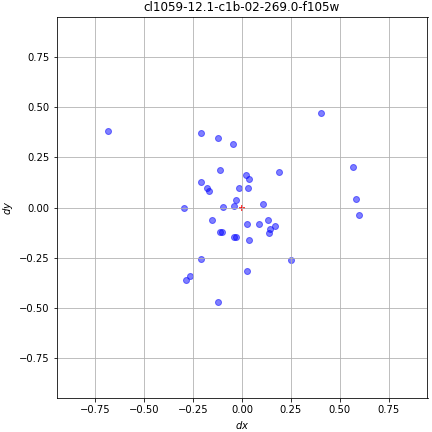

In [14]:
# Show the alignment w.r.t the external NOAO Source Catalog (NSC)
Image(filename = "./cl1059-12.1-c1b-02-269.0-f105w_wcs.png") 


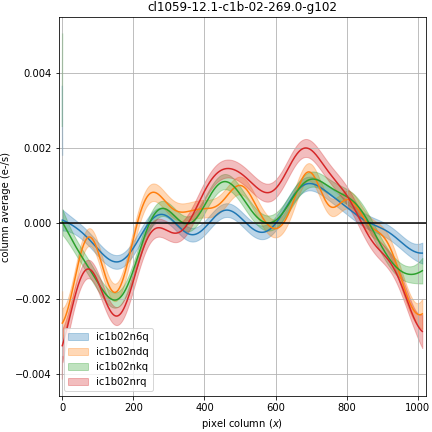

In [15]:
# Show the alignment of one HST visit to another, note tight 
# plot range compared to previous
Image(filename = "./cl1059-12.1-c1b-02-269.0-g102_column.png") 

In [16]:
# Check wcs.log files that a few objects were found, no large rotations
# and rms (second to last column) isn't too large

# Here, the F098M/G102 visit was the first processed and was aligned 
# to the NSC, with RMS~0.8 WFC3/IR pix.  Subsequent visits are aligned to 
# previously processed HST visits so that at least the relative HST astrometry
# is as good as possible.  Here, the F140W/G141 visit was run second and was 
# therefore aligned to F098M, resulting in much better precision than with the
# external catalog (RMS < 0.1 pix).

# Cat wcs.log files in order they were generated
!grep " 0 " `ls -ltr *wcs.log | awk '{print $9}'` | sed "s/  */ /g"

# columns: 
# "visit"  0  xshift yshift rot scale rms N

cl1059-12.1-c1b-02-269.0-f105w_wcs.log: 0 -3.2771 -2.8968 0.0080 1.00018 0.135 40
jc1b01-c1b-01-145.0-f814w_wcs.log: 0 2.0169 -3.9068 0.0047 1.00003 0.147 23


### Alignment failures ###

The main failure mode of the `auto_script.preprocess` script is failure to compute a reliable alignment to the external reference.  This can happen, e.g., if there are not enough alignment sources (i.e., zero) within the field of view or if the original astrometry of the exposures obtained from the archive is offset from the reference by more than ~10 pixels.  This can almost always be remedied by running `grizli.pipeline.auto_script.manual_alignment` after the files have been fetched, which prompts the user to interactively mark sources in the image and reference catalog using DS9.

In [17]:
if False: # Don't run
    catalogs = ['PS1','SDSS','GAIA','WISE']
    auto_script.manual_alignment(field_root=root, HOME_PATH=HOME_PATH, skip=True, 
                                 catalogs=catalogs, radius=15, visit_list=None)

### Grism sky subtraction ###

The grism sky backgrounds are subtracted using the "Master sky" images from [Brammer, Ryan, & Pirzkal 2015](http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2015-17.pdf) (available [here](http://www.stsci.edu/hst/wfc3/analysis/grism_obs/calibrations/wfc3_grism_master_sky.html)).  

`Grizli` ignores any wavelength dependence of the flat-field and applies a grey correction using the F140W (F105W) flat-field for the G141 (G102) grisms.

Residuals after subtracting the master sky images are typically of order 0.005 e-/s, just 0.5-1% overall background level.  They are removed by subtracting a column-average of the sky pixels in the grism exposures, and the processing script produces a diagnostic figure like the one shown below.  The source of the residuals is still unclear (e.g., perhaps spectra of objects near/below the detection limit).  Though they are usually well removed by the column average, they do make extracting continuum spectra of faint sources challenging.

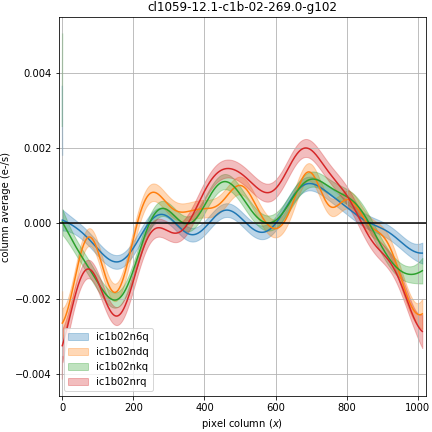

In [18]:
from IPython.display import Image
Image(filename = "./cl1059-12.1-c1b-02-269.0-g102_column.png", width=600, height=600)

### Fine alignment to GAIA DR2 ###

The initial visit alignment scripts often show small drifts such that the differen't visits don't perfectly overlap.  The script below performs an additional realignment to the visits internally and also to an external reference, usually GAIA DR2.

In [19]:
# Fine alignment of the visits relative to each other and absolute to GAIA DR2
if len(glob.glob('{0}*fine.png'.format(root))) == 0:
    fine_catalogs = ['GAIA','PS1','SDSS','WISE']
    out = auto_script.fine_alignment(field_root=root, HOME_PATH=HOME_PATH, 
                                     min_overlap=0.2, stopme=False, ref_err=0.08, 
                                     catalogs=fine_catalogs, NITER=1, maglim=[17,23],
                                     shift_only=True, method='Powell', redrizzle=False, 
                                     radius=10, program_str=None, match_str=[], 
                                     gaia_by_date=True)

    # Update headers with the result from the fine alignment
    # Original FLTs are archived to FineBkup
    auto_script.update_wcs_headers_with_fine(root)
    
visits, res = np.load('{0}_fine.npy'.format(root))
shifts = res.x.reshape((-1,2))/10.
for i, visit in enumerate(visits):
    print('{0:35}  {1:6.2f}  {2:6.2f}'.format(visit['product'], shifts[i,0], shifts[i,1]))

cl1059-12.1-c1b-02-269.0-f105w         0.07   -0.00
jc1b01-c1b-01-145.0-f814w              0.22    0.05


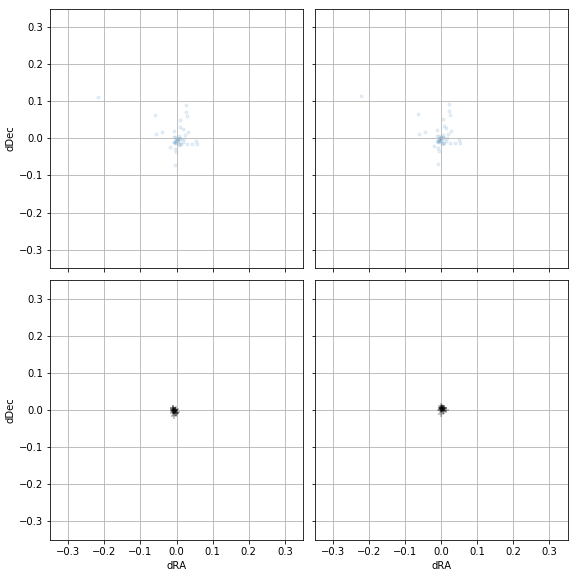

In [20]:
# Show the results of fine alignment.  
# Top panels are alignment between the visits.  + in the bottom panels are 
# residuals of the external reference, here GAIA DR2.
#
# Small drift between individual visits removed.  
# Fairly large GAIA offsets probably due to ~6 years between 
# WFC3/ERS and GAIA epoch 2015.5.
Image(filename='{0}_fine.png'.format(root))

## Make combined mosaics for each available filter ##

These are used to generate a photometric catalog and also for the direct image reference for the grism

In [21]:
# Drizzle mosaics in each filter and combine all IR filters
combine_all_filters=True
if len(glob.glob('{0}-ir_dr?_sci.fits'.format(root))) == 0:

    ## Mosaic WCS
    wcs_ref_file = '{0}_wcs-ref.fits'.format(root)
    if not os.path.exists(wcs_ref_file):
        auto_script.make_reference_wcs(info, output=wcs_ref_file, 
                           filters=['G800L', 'G102', 'G141'], 
                           pad_reference=90, pixel_scale=None,
                           get_hdu=True)

    # All combined
    IR_filters = ['F105W', 'F110W', 'F125W', 'F140W', 'F160W', 
                  'F098M', 'F139M', 'F127M', 'F153M']

    optical_filters = ['F814W', 'F606W', 'F435W', 'F850LP', 'F702W', 'F555W', 'F438W', 'F475W', 'F625W', 'F775W', 'F225W', 'F275W', 'F300W', 'F390W']

    if combine_all_filters:
        auto_script.drizzle_overlaps(root, 
                                 filters=IR_filters+optical_filters, 
                                 min_nexp=1, 
                                 make_combined=True,
                                 ref_image=wcs_ref_file,
                                 drizzle_filters=False) 

    ## IR filters
    auto_script.drizzle_overlaps(root, filters=IR_filters, 
                                 min_nexp=1, 
                                 make_combined=(not combine_all_filters),
                                 ref_image=wcs_ref_file) 

    # Fill IR filter mosaics with scaled combined data so they can be used 
    # as grism reference
    auto_script.fill_filter_mosaics(root)

    ## Optical filters

    mosaics = glob.glob('{0}-ir_dr?_sci.fits'.format(root))

    auto_script.drizzle_overlaps(root, filters=optical_filters,
        make_combined=(len(mosaics) == 0), ref_image=wcs_ref_file,
        min_nexp=2) 

In [22]:
!ls -1 j*_dr?_sci.fits

j105900m1253-f105w_drz_sci.fits
j105900m1253-f814w_drc_sci.fits
j105900m1253-ir_drc_sci.fits
jc1b01-c1b-01-145.0-f814w_drc_sci.fits


## Generate a photometric catalog ##

Run source detection on the combined mosaic `{root}-ir_dr[cz]_sci.fits` and generates a catalog and segmentation image.  

Then perform simple matched-aperture photometry on the different available filter mosaics (in this case F098M and F140W from the direct imaging).  In principle the template fitting code shown below can incorporate this photometric information, though that's not currently done by default.

In [23]:
## Run SEP (~SExtractor clone) catalog on the "ir" combined image
## and generate a photometric catalog with aperture photometry in all available bands
if not os.path.exists('{0}_phot.fits'.format(root)):
    get_background=False # SExtractor background subtraction
    tab = auto_script.multiband_catalog(field_root=root, threshold=1.8,
                                        detection_background=get_background,
                                        photometry_background=get_background) 
    
files = glob.glob('{0}-ir*'.format(root)) + glob.glob('*phot*fits')
for file in files:
    print(file)
    
phot = utils.GTable.gread('{0}_phot.fits'.format(root))
print('{0}Metadata{0}'.format('\n'+'='*20+'\n'))
for k in phot.meta:
    print('{0}:\t{1}'.format(k, phot.meta[k]))

j105900m1253-ir.cat.fits
j105900m1253-ir_drc_wht.fits
j105900m1253-ir_drc_sci.fits
j105900m1253-ir_seg.fits
j105900m1253-ir_bkg.fits
j105900m1253_phot.fits

Metadata

MINAREA:	5
CLEAN:	True
DEBCONT:	0.005
DEBTHRSH:	32
FILTER_TYPE:	conv
THRESHOLD:	1.8
ZP:	26.26887001774306
PLAM:	10551.047
FNU:	1.1283712e-07
FLAM:	3.0386574e-20
UJY2DN:	8.861796202091552
DRZ_FILE:	j105900m1253-ir_drc_sci.fits
WHT_FILE:	j105900m1253-ir_drc_wht.fits
GET_BACK:	False
ERR_SCALE:	0.9091119766235352
APER_0:	6.00000000000013
ASEC_0:	0.36
APER_1:	8.33500000000018
ASEC_1:	0.5001
APER_2:	16.33700000000036
ASEC_2:	0.9802200000000001
APER_3:	20.00000000000043
ASEC_3:	1.2
F105W_ZP:	26.26887001774306
F105W_PLAM:	10551.047
F105W_FNU:	1.1283712e-07
F105W_FLAM:	3.0386574e-20
F105W_uJy2dn:	8.861796202091552
F105W_DRZ_FILE:	j105900m1253-f105w_drz_sci.fits
F105W_WHT_FILE:	j105900m1253-f105w_drz_wht.fits
F105W_GET_BACK:	False
F105W_ERR_SCALE:	0.5204375982284546
F105W_aper_0:	6.00000000000013
F105W_asec_0:	0.36
F105W_aper_1:	8.

In [24]:
phot[:2].show_in_notebook()

## Building the grism exposure container: `multifit.GroupFLT` ##

With the preprocessing done, we can now start on the analysis of the spectra.  `Grizli` is built around low-level tools for modeling and analyzing each individual grism exposure individually.  Though once multiple exposures are available (e.g., exposures within a visit or separate visits with different grisms and/or orients) the information from each can be combined for analyzing the spectrum of a given object.  A benefit of the exposure-level processing is that all of the model-to-data comparisons (i.e. chi-squared) are done in the space of the original detector pixels, with their well-calibrated and well-understood noise properties.

The `GroupFLT` class provides a container for processing multiple FLT exposures simultanously.

### Inputs ###
* `grism_files` = list of grism exposure filenames
* `direct_files` = (optional) list of direct exposure filenames
* `ref_file` = (optional) reference direct image mosaic (one or the other of `ref_file` or `direct_files` should be specified.)
* `seg_file`, `catalog` = segmentation image and catalog, usually generated with SExtractor
* `cpu_count` = set to > 0 for parallel processing
* `pad` parameter (default=200 pixels).  If set, then add padding around the FLTs to enable modeling of objects that would fall off of the direct image but that still disperse spectra onto the grism exposure (assuming they fall in the `ref_file` and `seg_file` mosaics).

The contents of the `grism_files` list can contain pretty much anything, with the result limited by memory / cpu power.  For example, you can provide a list of **all** 112 of the 3D-HST G141 exposures in the COSMOS field (4 exposures x 28 pointings), along with the field mosaic and segmentation images.  This example is actually fairly easy to process as individual objects will fall in typically 4, perhaps 8 individual exposures in some overlap areas.  Another example is a list of exposures from multiple instruments / grisms / orients of a single field, thought the subsequent fits can be slow if an object has spectra in many individual exposures.

Reference images are blotted to the distorted exposure frame with `AstroDrizzle.ablot`.   Messages go by, as below, when you load the `GroupFLT` object talking about "cutouts" because the script tries to make smaller cutouts of large reference images to speed up the blot processing.

**NB** Seems to often have memory leak problems if `seg_file` isn't significantly larger than the footprint of a given FLT file.  Drizzle `blot` segfaults out but the script just hangs since the multiprocessing threads don't get the message.

### Flat continuum model ###

Once the `GroupFLT` object is initialized, compute a first-pass model of the full detector field of view assuming simple linear continua for all objects in the field (brighter than `mag_limit`).  By default this assumes a somewhat blue continuum suitable for the Rayleigh-Jeans tail of low-redshift objects.  It's far from perfect but the initial model does provide a good way of at least identifying which pixels of a given object could be contaminated by neighbors, even if the quantitative model is not precise.

### Refined polynomial continuum model ###

After computing the simple continuum model, refine the model spectra for brighter objects using higher-order polynomials fit directly to the spectra themselves.  The `refine_list` method marches through objects starting with the brightest and fits a polynomial of order `poly_order` to the observed spectrum after subtracting off the model for contaminants.  Note that if the list of grism exposures contained multiple orientations covering a single field, this fit can be well constrained even in the presence of contamination.

The `grism_prep` script iterates on the refined polynomial model `refine_niter` times.

### Save state ###

You can optionally dump saved data (i.e., `grp.save_full_data()`) for fast restart and avoid recomputing the contamination models, for example in a new Python session.  This can be done at any time after you've made changes to the GroupFLT data that you'd like to store for later.  The `grism_prep` script does this automatically.

In [25]:
files = glob.glob('*GrismFLT.fits')
if len(files) == 0:
    ### Grism contamination model
    os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

    # Which filter to use as direct image?  Will try in order of the list until a match is found.
    gris_ref = {'G141': ['F140W', 'F160W'], 
                'G102': ['F105W', 'F098M', 'F110W']}

    x = auto_script.grism_prep(field_root=root, refine_niter=3,
                                 gris_ref_filters=gris_ref)

    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(root), 
                            cpu_count=-1, sci_extn=1, pad=256)
    
else:
    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(root), 
                            cpu_count=-1, sci_extn=1, pad=256)

Load ic1b02n6q.01.GrismFLT.fits!
Load ic1b02nrq.01.GrismFLT.fits!
Load ic1b02ndq.01.GrismFLT.fits!
Load ic1b02nkq.01.GrismFLT.fits!
Files loaded - 3.80 sec.


### The final contamination model ###

IndexError: list index out of range

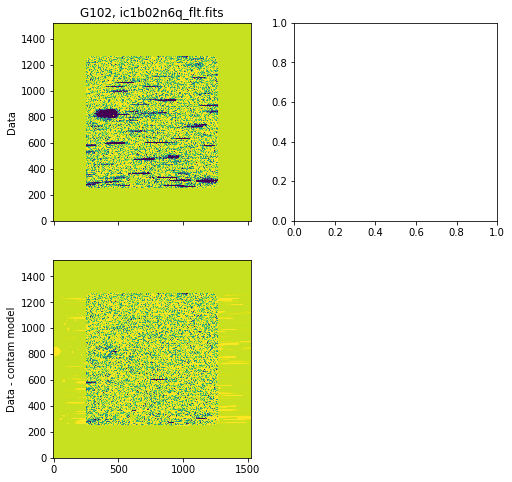

In [26]:
# Show the results of the contamination model
### Show FLT residuals
cmap = 'viridis_r'
vm = [-0.01, 0.1]

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(221)
flt = grp.FLTs[0] # G102

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([])
ax.set_ylabel('Data')

ax = fig.add_subplot(223)
ax.imshow(flt.grism['SCI'] - flt.model, vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_ylabel('Data - contam model')

ax = fig.add_subplot(222)
flt = grp.FLTs[4] # G141

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([]); ax.set_yticklabels([])

ax = fig.add_subplot(224)
ax.imshow(flt.grism['SCI'] - flt.model, vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_yticklabels([])

for ax in fig.axes:
    ax.set_xlim(510,790); ax.set_ylim(610,890)

fig.tight_layout(pad=1)

### Parameters for object fitting

In [28]:
h = open('/data2/jrcooper/notebooks/reduction/EDisCS/j105900m1253/Extractions/c_LDP_q.txt', 'r')
lines = h.readlines()[1:]
h.close()   
z_LDP       = []  
id_HST      = []   
ra_HST      = []
dec_HST     = [] 

for line in lines: 
    a = line.split()     
    z_LDP.append(float(a[3]))
    ra_HST.append(float(a[1]))
    dec_HST.append(float(a[2]))



z_LDP     = np.array(z_LDP)
ra_HST    = np.array(ra_HST)
dec_HST   = np.array(dec_HST)
id_HST     = np.array(id_HST) 


In [29]:
#### Store fit parameters to `fit_args.npy` for batch-mode processing

# Drizzle parameters for line maps
pline = auto_script.DITHERED_PLINE
#print(pline) 

sig = 0.007 
z = np.arange(0,2,.001)
for i in z_LDP:
    p_z = np.exp(-(z - i)**2/(2*sig**2))/((2*np.pi)**0.5/sig)

spec_prior = [z,p_z]
tuple
a = tuple(spec_prior)

# Generate the parameter dictionary
args = auto_script.generate_fit_params(field_root=root, prior=a, 
                                       MW_EBV=tabs[0].meta['MW_EBV'], 
                                pline=pline, fit_only_beams=True, run_fit=True, poly_order=7, 
                                fsps=True, sys_err = 0.03, fcontam=0.2, zr=[0.05, 3.4], 
                                save_file='fit_args.npy')

Saved arguments to fit_args.npy.


### Field PSF file ### 
Make an average effective PSF for each available IR filter by evaluating the field-dependent PSF across the final mosaic and drizzling to a common output.  Also make an extension with a PSF on the pixel grid of the drizzled line map parameters generated above (`pline`).  Each PSF is generated with the native pixel grid and 2/4x oversampling for use with, e.g., [GALFIT](https://users.obs.carnegiescience.edu/peng/work/galfit/galfit.html).

*NB* There is currently no ePSF for F098M, so F105W is used (http://www.stsci.edu/~jayander/STDPSFs/WFC3IR/).


In [30]:
# Make PSF file
if not os.path.exists('{0}-f105w_psf.fits'.format(root)):
    auto_script.field_psf(root=root, HOME_PATH=HOME_PATH)

['j105900m1253-f105w_psf.fits'] 

Filename: j105900m1253-f105w_psf.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  PSF         LINE1 ImageHDU        29   (60, 60)   float32   
  2  PSF         LINE2 ImageHDU        29   (120, 120)   float32   
  3  PSF         LINE4 ImageHDU        29   (240, 240)   float32   
  4  PSF         DRIZ1 ImageHDU        29   (100, 100)   float32   
  5  PSF         DRIZ2 ImageHDU        29   (200, 200)   float32   
  6  PSF         DRIZ4 ImageHDU        29   (400, 400)   float32   


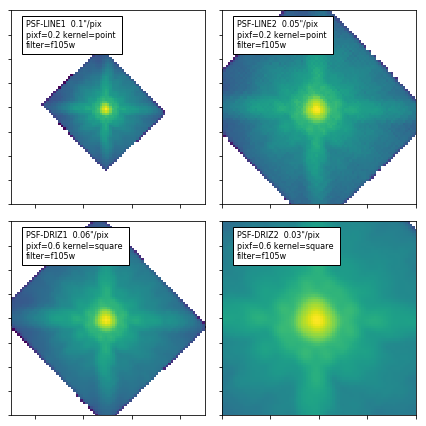

In [31]:
# Show the PSFs
print(glob.glob('*psf.fits'),'\n')

im = pyfits.open('{0}-f105w_psf.fits'.format(root))
im.info()

fig = plt.figure(figsize=[6,6])
for i, ext in enumerate([1,2,4,5]):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(np.log10(im[ext].data))
    
    h = im[ext].header
    label = '{0}-{1}  {2}"/pix \npixf={3} kernel={4} \nfilter={5}'.format(h['EXTNAME'],
                     h['EXTVER'], h['PSCALE'], h['PIXFRAC'], h['KERNEL'], h['FILTER'])
    
    ax.text(0.08, 0.95, label, ha='left', va='top', 
            transform=ax.transAxes, size=8, color='k',
            bbox={'fc':'w'})
    
    ax.set_xticklabels([]); ax.set_yticklabels([])
    
    sh = im[ext].data.shape
    ax.set_xlim(sh[1]/2-40, sh[1]/2+40)
    ax.set_ylim(sh[0]/2-40, sh[0]/2+40)
    
fig.tight_layout(pad=1)

## Extract and fit individual spectra ##

In [32]:
os.chdir('../Extractions')

In [33]:
### Find IDs of specific objects to extract
import grizli.pipeline
from grizli.pipeline import auto_script
import astropy.units as u
tab = utils.GTable()
tab['ra'] = ra_HST
tab['dec'] = dec_HST
idx, dr = grp.catalog.match_to_catalog_sky(tab)
source_ids = grp.catalog['NUMBER'][idx]
tab['id'] = source_ids
tab['dr'] = dr.to(u.mas)
tab['dr'].format='.1f'
tab.show_in_notebook()

### Extract 2D spectra "beams" ###

The `GroupFLT` object contains the entire exposure information, from which we can make cutouts of spectra for individual objects with the `get_beams` method.  These cutouts are more managable and portable than the entire exposures, though currently the processing does work in the paradigm of having a static contamination model for a given object.  

In pipeline mode, the function below is called with `ids=[], maglim=[mag_min, mag_max]` and all objects in the reference catalog with `mag_min < MAG_AUTO < mag_max` are extracted.  The redshift fits are performed if `run_fit=True`.

0/353: 30 0
1/353: 433 0
2/353: 41 4
j105900m1253_00041.beams.fits
3/353: 381 4
j105900m1253_00381.beams.fits
4/353: 672 0
5/353: 78 4
j105900m1253_00078.beams.fits
6/353: 219 4
j105900m1253_00219.beams.fits
7/353: 386 0
8/353: 178 4
j105900m1253_00178.beams.fits
9/353: 452 0
10/353: 459 0
11/353: 56 0
12/353: 29 0
13/353: 545 0
14/353: 494 4
j105900m1253_00494.beams.fits
15/353: 669 0
16/353: 294 4
j105900m1253_00294.beams.fits
17/353: 171 4
j105900m1253_00171.beams.fits
18/353: 240 4
j105900m1253_00240.beams.fits
19/353: 151 0
20/353: 478 0
21/353: 183 4
j105900m1253_00183.beams.fits
22/353: 259 4
j105900m1253_00259.beams.fits
23/353: 82 4
j105900m1253_00082.beams.fits
24/353: 47 0
25/353: 88 0
26/353: 68 0
27/353: 413 4
j105900m1253_00413.beams.fits
28/353: 584 0
29/353: 439 4
j105900m1253_00439.beams.fits
30/353: 157 0
31/353: 656 0
32/353: 467 4
j105900m1253_00467.beams.fits
33/353: 221 4
j105900m1253_00221.beams.fits
34/353: 503 4
j105900m1253_00503.beams.fits
35/353: 227 0
36/35

j105900m1253_00172.beams.fits
304/353: 415 4
j105900m1253_00415.beams.fits
305/353: 655 0
306/353: 277 4
j105900m1253_00277.beams.fits
307/353: 389 0
308/353: 189 0
309/353: 678 0
310/353: 8 0
311/353: 488 4
j105900m1253_00488.beams.fits
312/353: 429 4
j105900m1253_00429.beams.fits
313/353: 408 4
j105900m1253_00408.beams.fits
314/353: 412 4
j105900m1253_00412.beams.fits
315/353: 168 4
j105900m1253_00168.beams.fits
316/353: 454 0
317/353: 91 4
j105900m1253_00091.beams.fits
318/353: 251 4
j105900m1253_00251.beams.fits
319/353: 445 4
j105900m1253_00445.beams.fits
320/353: 492 4
j105900m1253_00492.beams.fits
321/353: 220 0
322/353: 231 4
j105900m1253_00231.beams.fits
323/353: 461 0
324/353: 616 4
j105900m1253_00616.beams.fits
325/353: 211 0
326/353: 350 4
j105900m1253_00350.beams.fits
327/353: 527 0
328/353: 465 4
j105900m1253_00465.beams.fits
329/353: 31 4
j105900m1253_00031.beams.fits
330/353: 398 4
j105900m1253_00398.beams.fits
331/353: 504 0
332/353: 621 0
333/353: 466 4
j105900m1253_0

  1.0204  630006.1 (0.1964) 153/341
  1.0285  629453.6 (0.1964) 154/341
  1.0367  629606.2 (0.1964) 155/341
  1.0448  630513.1 (0.1964) 156/341
  1.0530  632654.7 (0.1964) 157/341
  1.0612  633378.5 (0.1964) 158/341
  1.0695  634244.3 (0.1964) 159/341
  1.0778  635340.6 (0.1964) 160/341
  1.0861  636022.5 (0.1964) 161/341
  1.0945  637061.2 (0.1964) 162/341
  1.1029  637513.2 (0.1964) 163/341
  1.1113  638656.3 (0.1964) 164/341
  1.1198  639752.0 (0.1964) 165/341
  1.1283  642127.2 (0.1964) 166/341
  1.1368  643690.5 (0.1964) 167/341
  1.1454  646541.2 (0.1964) 168/341
  1.1540  649239.9 (0.1964) 169/341
  1.1626  652776.0 (0.1964) 170/341
  1.1713  654955.3 (0.1964) 171/341
  1.1800  657775.6 (0.1964) 172/341
  1.1887  660631.2 (0.1964) 173/341
  1.1975  662763.8 (0.1964) 174/341
  1.2063  665274.6 (0.1964) 175/341
  1.2151  667475.7 (0.1964) 176/341
  1.2240  669223.7 (0.1964) 177/341
  1.2329  671837.3 (0.1964) 178/341
  1.2419  671407.7 (0.1964) 179/341
  1.2509  672682.8 (0.1964) 

  3.2687  627068.7 (0.1964) 340/341
  3.2858  627012.2 (0.1964) 341/341
First iteration: z_best=0.1964

- 0.1898  622866.6 (0.1898) 1/33
- 0.1903  622788.3 (0.1903) 2/33
- 0.1908  622670.0 (0.1908) 3/33
- 0.1913  622502.3 (0.1913) 4/33
- 0.1918  622274.5 (0.1918) 5/33
- 0.1923  621982.3 (0.1923) 6/33
- 0.1928  621618.7 (0.1928) 7/33
- 0.1933  621207.4 (0.1933) 8/33
- 0.1938  620731.7 (0.1938) 9/33
- 0.1943  620222.1 (0.1943) 10/33
- 0.1948  619731.4 (0.1948) 11/33
- 0.1953  619218.8 (0.1953) 12/33
- 0.1958  618742.5 (0.1958) 13/33
- 0.1963  618343.3 (0.1963) 14/33
- 0.1968  618061.6 (0.1968) 15/33
- 0.1973  617946.9 (0.1973) 16/33
- 0.1978  617984.3 (0.1973) 17/33
- 0.1983  618205.2 (0.1973) 18/33
- 0.1988  618462.4 (0.1973) 19/33
- 0.1993  618657.0 (0.1973) 20/33
- 0.1998  618776.1 (0.1973) 21/33
- 0.2003  618907.0 (0.1973) 22/33
- 0.2008  619132.4 (0.1973) 23/33
- 0.2013  619406.5 (0.1973) 24/33
- 0.2018  619653.1 (0.1973) 25/33
- 0.2023  619878.4 (0.1973) 26/33
- 0.2028  620012.2 (0

  1.0204  370907.6 (0.3012) 153/341
  1.0285  371188.8 (0.3012) 154/341
  1.0367  371583.9 (0.3012) 155/341
  1.0448  371651.7 (0.3012) 156/341
  1.0530  371853.7 (0.3012) 157/341
  1.0612  372040.4 (0.3012) 158/341
  1.0695  372154.2 (0.3012) 159/341
  1.0778  372292.1 (0.3012) 160/341
  1.0861  372179.8 (0.3012) 161/341
  1.0945  371836.7 (0.3012) 162/341
  1.1029  371834.4 (0.3012) 163/341
  1.1113  372177.5 (0.3012) 164/341
  1.1198  372461.3 (0.3012) 165/341
  1.1283  372791.6 (0.3012) 166/341
  1.1368  373163.1 (0.3012) 167/341
  1.1454  373750.1 (0.3012) 168/341
  1.1540  374145.4 (0.3012) 169/341
  1.1626  374609.9 (0.3012) 170/341
  1.1713  375131.6 (0.3012) 171/341
  1.1800  375380.5 (0.3012) 172/341
  1.1887  375489.8 (0.3012) 173/341
  1.1975  376043.6 (0.3012) 174/341
  1.2063  376367.9 (0.3012) 175/341
  1.2151  376425.0 (0.3012) 176/341
  1.2240  376627.4 (0.3012) 177/341
  1.2329  376884.1 (0.3012) 178/341
  1.2419  377092.0 (0.3012) 179/341
  1.2509  377208.6 (0.3012) 

- 0.2953  370210.0 (0.2953) 1/33
- 0.2958  370195.8 (0.2958) 2/33
- 0.2963  370188.3 (0.2963) 3/33
- 0.2968  370183.1 (0.2968) 4/33
- 0.2973  370176.6 (0.2973) 5/33
- 0.2978  370174.0 (0.2978) 6/33
- 0.2983  370173.1 (0.2983) 7/33
- 0.2988  370174.3 (0.2983) 8/33
- 0.2993  370174.6 (0.2983) 9/33
- 0.2998  370177.5 (0.2983) 10/33
- 0.3003  370180.0 (0.2983) 11/33
- 0.3008  370181.1 (0.2983) 12/33
- 0.3013  370184.3 (0.2983) 13/33
- 0.3018  370185.8 (0.2983) 14/33
- 0.3023  370190.5 (0.2983) 15/33
- 0.3028  370193.2 (0.2983) 16/33
- 0.3033  370196.2 (0.2983) 17/33
- 0.3038  370197.1 (0.2983) 18/33
- 0.3043  370195.2 (0.2983) 19/33
- 0.3048  370194.9 (0.2983) 20/33
- 0.3053  370190.8 (0.2983) 21/33
- 0.3058  370186.9 (0.2983) 22/33
- 0.3063  370185.4 (0.2983) 23/33
- 0.3068  370184.7 (0.2983) 24/33
- 0.3073  370186.6 (0.2983) 25/33
- 0.3078  370189.7 (0.2983) 26/33
- 0.3083  370193.9 (0.2983) 27/33
- 0.3088  370201.3 (0.2983) 28/33
- 0.3093  370210.2 (0.2983) 29/33
- 0.3098  370219.3 (0.2

  1.0612  152696.8 (0.3707) 158/341
  1.0695  152672.7 (0.3707) 159/341
  1.0778  152907.8 (0.3707) 160/341
  1.0861  152861.7 (0.3707) 161/341
  1.0945  152743.4 (0.3707) 162/341
  1.1029  152851.0 (0.3707) 163/341
  1.1113  153297.4 (0.3707) 164/341
  1.1198  153802.1 (0.3707) 165/341
  1.1283  154341.4 (0.3707) 166/341
  1.1368  154602.1 (0.3707) 167/341
  1.1454  154883.8 (0.3707) 168/341
  1.1540  155421.2 (0.3707) 169/341
  1.1626  155702.5 (0.3707) 170/341
  1.1713  156126.0 (0.3707) 171/341
  1.1800  156316.7 (0.3707) 172/341
  1.1887  156748.7 (0.3707) 173/341
  1.1975  157553.7 (0.3707) 174/341
  1.2063  157880.4 (0.3707) 175/341
  1.2151  158035.6 (0.3707) 176/341
  1.2240  157867.0 (0.3707) 177/341
  1.2329  158226.3 (0.3707) 178/341
  1.2419  158900.9 (0.3707) 179/341
  1.2509  158898.9 (0.3707) 180/341
  1.2599  158758.1 (0.3707) 181/341
  1.2689  158967.8 (0.3707) 182/341
  1.2780  159386.1 (0.3707) 183/341
  1.2872  159536.8 (0.3707) 184/341
  1.2963  159813.1 (0.3707) 

- 2.9037  150825.3 (2.9037) 7/33
- 2.9042  150824.5 (2.9042) 8/33
- 2.9047  150823.7 (2.9047) 9/33
- 2.9052  150823.0 (2.9052) 10/33
- 2.9057  150822.4 (2.9057) 11/33
- 2.9062  150821.8 (2.9062) 12/33
- 2.9067  150821.3 (2.9067) 13/33
- 2.9072  150820.8 (2.9072) 14/33
- 2.9077  150820.3 (2.9077) 15/33
- 2.9082  150819.9 (2.9082) 16/33
- 2.9087  150819.6 (2.9087) 17/33
- 2.9092  150819.4 (2.9092) 18/33
- 2.9097  150819.4 (2.9097) 19/33
- 2.9102  150819.4 (2.9097) 20/33
- 2.9107  150819.6 (2.9097) 21/33
- 2.9112  150819.8 (2.9097) 22/33
- 2.9117  150820.3 (2.9097) 23/33
- 2.9122  150820.8 (2.9097) 24/33
- 2.9127  150821.4 (2.9097) 25/33
- 2.9132  150822.2 (2.9097) 26/33
- 2.9137  150823.1 (2.9097) 27/33
- 2.9142  150824.0 (2.9097) 28/33
- 2.9147  150825.0 (2.9097) 29/33
- 2.9152  150826.0 (2.9097) 30/33
- 2.9157  150827.1 (2.9097) 31/33
- 2.9162  150828.2 (2.9097) 32/33
- 2.9167  150829.4 (2.9097) 33/33
Drizzle line -> MgII (13.27 1.50)
Drizzle line -> CIII-1908 (55267140835551.09 974954

  1.1113  132786.4 (0.2755) 164/341
  1.1198  132917.1 (0.2755) 165/341
  1.1283  133316.7 (0.2755) 166/341
  1.1368  133471.8 (0.2755) 167/341
  1.1454  133806.8 (0.2755) 168/341
  1.1540  134189.3 (0.2755) 169/341
  1.1626  134767.3 (0.2755) 170/341
  1.1713  135219.4 (0.2755) 171/341
  1.1800  135468.7 (0.2755) 172/341
  1.1887  136156.9 (0.2755) 173/341
  1.1975  136916.2 (0.2755) 174/341
  1.2063  137481.7 (0.2755) 175/341
  1.2151  137515.6 (0.2755) 176/341
  1.2240  137623.5 (0.2755) 177/341
  1.2329  138157.4 (0.2755) 178/341
  1.2419  138428.9 (0.2755) 179/341
  1.2509  138625.2 (0.2755) 180/341
  1.2599  138836.7 (0.2755) 181/341
  1.2689  138724.9 (0.2755) 182/341
  1.2780  138694.8 (0.2755) 183/341
  1.2872  138676.6 (0.2755) 184/341
  1.2963  138915.7 (0.2755) 185/341
  1.3055  139029.4 (0.2755) 186/341
  1.3148  139299.3 (0.2755) 187/341
  1.3240  139389.8 (0.2755) 188/341
  1.3334  138969.3 (0.2755) 189/341
  1.3427  138511.8 (0.2755) 190/341
  1.3521  138268.2 (0.2755) 

- 0.2751  130826.8 (0.2751) 15/33
- 0.2756  130819.9 (0.2756) 16/33
- 0.2761  130818.9 (0.2761) 17/33
- 0.2766  130823.0 (0.2761) 18/33
- 0.2771  130830.0 (0.2761) 19/33
- 0.2776  130840.0 (0.2761) 20/33
- 0.2781  130854.8 (0.2761) 21/33
- 0.2786  130873.5 (0.2761) 22/33
- 0.2791  130894.2 (0.2761) 23/33
- 0.2796  130914.4 (0.2761) 24/33
- 0.2801  130934.1 (0.2761) 25/33
- 0.2806  130952.6 (0.2761) 26/33
- 0.2811  130967.3 (0.2761) 27/33
- 0.2816  130979.5 (0.2761) 28/33
- 0.2821  130991.5 (0.2761) 29/33
- 0.2826  131003.2 (0.2761) 30/33
- 0.2831  131012.8 (0.2761) 31/33
- 0.2836  131019.0 (0.2761) 32/33
- 0.2841  131025.0 (0.2761) 33/33
Drizzle line -> Ha   (41.51 3.11)
Drizzle line -> OI-6302 (50.94 5.74)
Get linemap PSF: F105W
7/353: 386
8/353: 178
1 ic1b02n6q_flt.fits G102
2 ic1b02nrq_flt.fits G102
3 ic1b02ndq_flt.fits G102
4 ic1b02nkq_flt.fits G102
User templates! N=17 

  0.1000  118462.9 (0.1000) 1/341
  0.1044  118521.0 (0.1000) 2/341
  0.1088  118547.1 (0.1000) 3/341
  0.1133 

  1.1540  120434.5 (0.5767) 169/341
  1.1626  121020.1 (0.5767) 170/341
  1.1713  121488.8 (0.5767) 171/341
  1.1800  121925.2 (0.5767) 172/341
  1.1887  122331.5 (0.5767) 173/341
  1.1975  122761.4 (0.5767) 174/341
  1.2063  123180.5 (0.5767) 175/341
  1.2151  123298.8 (0.5767) 176/341
  1.2240  123324.5 (0.5767) 177/341
  1.2329  123598.8 (0.5767) 178/341
  1.2419  123798.5 (0.5767) 179/341
  1.2509  123975.3 (0.5767) 180/341
  1.2599  124080.2 (0.5767) 181/341
  1.2689  124294.6 (0.5767) 182/341
  1.2780  124471.3 (0.5767) 183/341
  1.2872  124626.9 (0.5767) 184/341
  1.2963  124983.4 (0.5767) 185/341
  1.3055  125176.9 (0.5767) 186/341
  1.3148  125372.5 (0.5767) 187/341
  1.3240  125984.0 (0.5767) 188/341
  1.3334  126464.6 (0.5767) 189/341
  1.3427  126667.2 (0.5767) 190/341
  1.3521  127124.6 (0.5767) 191/341
  1.3615  127599.3 (0.5767) 192/341
  1.3710  128086.3 (0.5767) 193/341
  1.3805  128770.5 (0.5767) 194/341
  1.3900  129330.5 (0.5767) 195/341
  1.3996  129836.2 (0.5767) 

- 2.6570  117644.3 (2.6570) 17/33
- 2.6575  117644.0 (2.6575) 18/33
- 2.6580  117643.7 (2.6580) 19/33
- 2.6585  117643.4 (2.6585) 20/33
- 2.6590  117643.3 (2.6590) 21/33
- 2.6595  117643.2 (2.6595) 22/33
- 2.6600  117643.3 (2.6595) 23/33
- 2.6605  117643.5 (2.6595) 24/33
- 2.6610  117643.8 (2.6595) 25/33
- 2.6615  117644.2 (2.6595) 26/33
- 2.6620  117644.8 (2.6595) 27/33
- 2.6625  117645.5 (2.6595) 28/33
- 2.6630  117646.3 (2.6595) 29/33
- 2.6635  117647.2 (2.6595) 30/33
- 2.6640  117648.2 (2.6595) 31/33
- 2.6645  117649.4 (2.6595) 32/33
- 2.6650  117650.6 (2.6595) 33/33
Drizzle line -> MgII (18.22 1.37)
Get linemap PSF: F105W
9/353: 452
10/353: 459
11/353: 56
12/353: 29
13/353: 545
14/353: 494
1 ic1b02n6q_flt.fits G102
2 ic1b02nrq_flt.fits G102
3 ic1b02ndq_flt.fits G102
4 ic1b02nkq_flt.fits G102
User templates! N=17 

  0.1000   36707.3 (0.1000) 1/341
  0.1044   36714.2 (0.1000) 2/341
  0.1088   36751.1 (0.1000) 3/341
  0.1133   36784.2 (0.1000) 4/341
  0.1177   36839.8 (0.1000) 5/341

  1.1454   36828.2 (0.9963) 168/341
  1.1540   36950.0 (0.9963) 169/341
  1.1626   37088.1 (0.9963) 170/341
  1.1713   37271.7 (0.9963) 171/341
  1.1800   37469.8 (0.9963) 172/341
  1.1887   37620.0 (0.9963) 173/341
  1.1975   37737.5 (0.9963) 174/341
  1.2063   37897.2 (0.9963) 175/341
  1.2151   37982.7 (0.9963) 176/341
  1.2240   38116.9 (0.9963) 177/341
  1.2329   38352.1 (0.9963) 178/341
  1.2419   38617.0 (0.9963) 179/341
  1.2509   38867.9 (0.9963) 180/341
  1.2599   39148.1 (0.9963) 181/341
  1.2689   39397.3 (0.9963) 182/341
  1.2780   39631.5 (0.9963) 183/341
  1.2872   39993.4 (0.9963) 184/341
  1.2963   40276.4 (0.9963) 185/341
  1.3055   40607.2 (0.9963) 186/341
  1.3148   41039.2 (0.9963) 187/341
  1.3240   41383.9 (0.9963) 188/341
  1.3334   41731.8 (0.9963) 189/341
  1.3427   42035.9 (0.9963) 190/341
  1.3521   42422.7 (0.9963) 191/341
  1.3615   42890.3 (0.9963) 192/341
  1.3710   43318.1 (0.9963) 193/341
  1.3805   43858.9 (0.9963) 194/341
  1.3900   44459.9 (0.9963) 

- 0.9965   36118.9 (0.9940) 14/33
- 0.9970   36118.1 (0.9940) 15/33
- 0.9975   36116.5 (0.9975) 16/33
- 0.9980   36113.9 (0.9980) 17/33
- 0.9985   36111.8 (0.9985) 18/33
- 0.9990   36111.5 (0.9990) 19/33
- 0.9995   36112.3 (0.9990) 20/33
- 1.0000   36113.7 (0.9990) 21/33
- 1.0005   36115.3 (0.9990) 22/33
- 1.0010   36116.8 (0.9990) 23/33
- 1.0015   36118.2 (0.9990) 24/33
- 1.0020   36120.2 (0.9990) 25/33
- 1.0025   36122.4 (0.9990) 26/33
- 1.0030   36123.6 (0.9990) 27/33
- 1.0035   36123.6 (0.9990) 28/33
- 1.0040   36124.2 (0.9990) 29/33
- 1.0045   36126.2 (0.9990) 30/33
- 1.0050   36129.4 (0.9990) 31/33
- 1.0055   36132.9 (0.9990) 32/33
- 1.0060   36137.0 (0.9990) 33/33
Drizzle line -> OIII (131.38 15.15)
Drizzle line -> Hb   (146.72 16.56)
Drizzle line -> Hg   (22.53 27.04)
Drizzle line -> Hd   (43.69 43.66)
Drizzle line -> OII  (17919.66 329512.07)
Get linemap PSF: F105W
15/353: 669
16/353: 294
1 ic1b02n6q_flt.fits G102
2 ic1b02nrq_flt.fits G102
3 ic1b02ndq_flt.fits G102
4 ic1b02nkq

  1.1113   35500.7 (0.9884) 164/341
  1.1198   35622.8 (0.9884) 165/341
  1.1283   35518.2 (0.9884) 166/341
  1.1368   35510.6 (0.9884) 167/341
  1.1454   35652.0 (0.9884) 168/341
  1.1540   35583.6 (0.9884) 169/341
  1.1626   35350.5 (0.9884) 170/341
  1.1713   35280.1 (0.9884) 171/341
  1.1800   35334.1 (0.9884) 172/341
  1.1887   35530.8 (0.9884) 173/341
  1.1975   35450.2 (0.9884) 174/341
  1.2063   35553.7 (0.9884) 175/341
  1.2151   35764.2 (0.9884) 176/341
  1.2240   35894.5 (0.9884) 177/341
  1.2329   35840.7 (0.9884) 178/341
  1.2419   35425.4 (0.9884) 179/341
  1.2509   35034.4 (0.9884) 180/341
  1.2599   34925.4 (0.9884) 181/341
  1.2689   34696.3 (0.9884) 182/341
  1.2780   34255.7 (0.9884) 183/341
  1.2872   34129.5 (0.9884) 184/341
  1.2963   34296.4 (0.9884) 185/341
  1.3055   34298.1 (0.9884) 186/341
  1.3148   34088.8 (0.9884) 187/341
  1.3240   33872.4 (0.9884) 188/341
  1.3334   33504.4 (0.9884) 189/341
  1.3427   33596.5 (0.9884) 190/341
  1.3521   33764.3 (0.9884) 

- 0.9860   32922.6 (0.9845) 15/33
- 0.9865   32922.9 (0.9845) 16/33
- 0.9870   32924.9 (0.9845) 17/33
- 0.9875   32923.7 (0.9845) 18/33
- 0.9880   32914.5 (0.9845) 19/33
- 0.9885   32904.2 (0.9885) 20/33
- 0.9890   32902.5 (0.9890) 21/33
- 0.9895   32912.0 (0.9890) 22/33
- 0.9900   32922.4 (0.9890) 23/33
- 0.9905   32927.0 (0.9890) 24/33
- 0.9910   32928.0 (0.9890) 25/33
- 0.9915   32934.9 (0.9890) 26/33
- 0.9920   32942.2 (0.9890) 27/33
- 0.9925   32940.9 (0.9890) 28/33
- 0.9930   32936.2 (0.9890) 29/33
- 0.9935   32945.3 (0.9890) 30/33
- 0.9940   32972.6 (0.9890) 31/33
- 0.9945   32999.3 (0.9890) 32/33
- 0.9950   33027.3 (0.9890) 33/33
Drizzle line -> Hb   (22.79 1.19)
Drizzle line -> Hd   (26.55 3.26)
Drizzle line -> NeIII-3867 (45035.15 17080.36)
Get linemap PSF: F105W
17/353: 171
1 ic1b02n6q_flt.fits G102
2 ic1b02nrq_flt.fits G102
3 ic1b02ndq_flt.fits G102
4 ic1b02nkq_flt.fits G102
User templates! N=17 

  0.1000   28628.1 (0.1000) 1/341
  0.1044   28758.7 (0.1000) 2/341
  0.1088 

  1.1626   28772.1 (0.4613) 170/341
  1.1713   28950.1 (0.4613) 171/341
  1.1800   29102.7 (0.4613) 172/341
  1.1887   29186.7 (0.4613) 173/341
  1.1975   29453.4 (0.4613) 174/341
  1.2063   29532.0 (0.4613) 175/341
  1.2151   29537.6 (0.4613) 176/341
  1.2240   29489.1 (0.4613) 177/341
  1.2329   29438.7 (0.4613) 178/341
  1.2419   29388.7 (0.4613) 179/341
  1.2509   29232.3 (0.4613) 180/341
  1.2599   29054.8 (0.4613) 181/341
  1.2689   28794.9 (0.4613) 182/341
  1.2780   28412.6 (0.4613) 183/341
  1.2872   28208.3 (0.4613) 184/341
  1.2963   28079.4 (0.4613) 185/341
  1.3055   28087.7 (0.4613) 186/341
  1.3148   28342.4 (0.4613) 187/341
  1.3240   28365.6 (0.4613) 188/341
  1.3334   28231.3 (0.4613) 189/341
  1.3427   28140.3 (0.4613) 190/341
  1.3521   28152.6 (0.4613) 191/341
  1.3615   28179.1 (0.4613) 192/341
  1.3710   28073.2 (0.4613) 193/341
  1.3805   28037.4 (0.4613) 194/341
  1.3900   28336.4 (0.4613) 195/341
  1.3996   28582.2 (0.4613) 196/341
  1.4092   28462.6 (0.4613) 

- 0.4610   19357.8 (0.4610) 16/33
- 0.4615   19269.6 (0.4615) 17/33
- 0.4620   19253.1 (0.4620) 18/33
- 0.4625   19324.5 (0.4620) 19/33
- 0.4630   19502.6 (0.4620) 20/33
- 0.4635   19775.2 (0.4620) 21/33
- 0.4640   20118.5 (0.4620) 22/33
- 0.4645   20512.5 (0.4620) 23/33
- 0.4650   20955.3 (0.4620) 24/33
- 0.4655   21423.2 (0.4620) 25/33
- 0.4660   21890.4 (0.4620) 26/33
- 0.4665   22338.6 (0.4620) 27/33
- 0.4670   22773.6 (0.4620) 28/33
- 0.4675   23191.9 (0.4620) 29/33
- 0.4680   23585.8 (0.4620) 30/33
- 0.4685   23960.4 (0.4620) 31/33
- 0.4690   24321.5 (0.4620) 32/33
- 0.4695   24661.7 (0.4620) 33/33
Drizzle line -> SII  (63.40 2.35)
Drizzle line -> Ha   (518.80 3.07)
Drizzle line -> OI-6302 (25.59 3.20)
Get linemap PSF: F105W
18/353: 240
1 ic1b02n6q_flt.fits G102
2 ic1b02nrq_flt.fits G102
3 ic1b02ndq_flt.fits G102
4 ic1b02nkq_flt.fits G102
User templates! N=17 

  0.1000   10827.1 (0.1000) 1/341
  0.1044   10865.7 (0.1000) 2/341
  0.1088   10887.4 (0.1000) 3/341
  0.1133   10931.7

  1.1540   10943.4 (0.2960) 169/341
  1.1626   11058.3 (0.2960) 170/341
  1.1713   11158.9 (0.2960) 171/341
  1.1800   11321.3 (0.2960) 172/341
  1.1887   11469.0 (0.2960) 173/341
  1.1975   11570.8 (0.2960) 174/341
  1.2063   11602.5 (0.2960) 175/341
  1.2151   11594.1 (0.2960) 176/341
  1.2240   11634.6 (0.2960) 177/341
  1.2329   11617.3 (0.2960) 178/341
  1.2419   11602.8 (0.2960) 179/341
  1.2509   11609.7 (0.2960) 180/341
  1.2599   11536.8 (0.2960) 181/341
  1.2689   11470.9 (0.2960) 182/341
  1.2780   11480.6 (0.2960) 183/341
  1.2872   11591.6 (0.2960) 184/341
  1.2963   11707.3 (0.2960) 185/341
  1.3055   11813.8 (0.2960) 186/341
  1.3148   11895.5 (0.2960) 187/341
  1.3240   11894.0 (0.2960) 188/341
  1.3334   11798.0 (0.2960) 189/341
  1.3427   11737.6 (0.2960) 190/341
  1.3521   11850.7 (0.2960) 191/341
  1.3615   11975.1 (0.2960) 192/341
  1.3710   12117.9 (0.2960) 193/341
  1.3805   12232.1 (0.2960) 194/341
  1.3900   12296.4 (0.2960) 195/341
  1.3996   12348.0 (0.2960) 

- 0.2949   10534.1 (0.2944) 18/33
- 0.2954   10536.8 (0.2944) 19/33
- 0.2959   10540.8 (0.2944) 20/33
- 0.2964   10544.9 (0.2944) 21/33
- 0.2969   10550.0 (0.2944) 22/33
- 0.2974   10556.6 (0.2944) 23/33
- 0.2979   10563.3 (0.2944) 24/33
- 0.2984   10570.3 (0.2944) 25/33
- 0.2989   10578.0 (0.2944) 26/33
- 0.2994   10586.7 (0.2944) 27/33
- 0.2999   10596.9 (0.2944) 28/33
- 0.3004   10608.0 (0.2944) 29/33
- 0.3009   10619.4 (0.2944) 30/33
- 0.3014   10629.9 (0.2944) 31/33
- 0.3019   10638.8 (0.2944) 32/33
- 0.3024   10647.5 (0.2944) 33/33
Drizzle line -> Ha   (0.72 4.07)
Get linemap PSF: F105W
19/353: 151
20/353: 478
21/353: 183
1 ic1b02n6q_flt.fits G102
2 ic1b02nrq_flt.fits G102
3 ic1b02ndq_flt.fits G102
4 ic1b02nkq_flt.fits G102
User templates! N=17 

  0.1000   10287.2 (0.1000) 1/341
  0.1044   10316.6 (0.1000) 2/341
  0.1088   10333.2 (0.1000) 3/341
  0.1133   10386.2 (0.1000) 4/341
  0.1177   10448.1 (0.1000) 5/341
  0.1222   10485.7 (0.1000) 6/341
  0.1267   10514.0 (0.1000) 7/341

  1.1626   10265.6 (0.4554) 170/341
  1.1713   10342.2 (0.4554) 171/341
  1.1800   10482.8 (0.4554) 172/341
  1.1887   10650.3 (0.4554) 173/341
  1.1975   10746.6 (0.4554) 174/341
  1.2063   10816.6 (0.4554) 175/341
  1.2151   10789.5 (0.4554) 176/341
  1.2240   10653.2 (0.4554) 177/341
  1.2329   10598.4 (0.4554) 178/341
  1.2419   10545.4 (0.4554) 179/341
  1.2509   10539.2 (0.4554) 180/341
  1.2599   10477.5 (0.4554) 181/341
  1.2689   10311.6 (0.4554) 182/341
  1.2780   10189.3 (0.4554) 183/341
  1.2872   10127.1 (0.4554) 184/341
  1.2963   10147.8 (0.4554) 185/341
  1.3055   10239.5 (0.4554) 186/341
  1.3148   10360.2 (0.4554) 187/341
  1.3240   10452.3 (0.4554) 188/341
  1.3334   10387.9 (0.4554) 189/341
  1.3427   10122.0 (0.4554) 190/341
  1.3521    9898.5 (0.4554) 191/341
  1.3615    9749.6 (0.4554) 192/341
  1.3710    9728.6 (0.4554) 193/341
  1.3805    9888.2 (0.4554) 194/341
  1.3900   10101.0 (0.4554) 195/341
  1.3996   10300.5 (0.4554) 196/341
  1.4092   10359.1 (0.4554) 

- 0.4587    8317.8 (0.4547) 24/33
- 0.4592    8495.1 (0.4547) 25/33
- 0.4597    8668.4 (0.4547) 26/33
- 0.4602    8841.2 (0.4547) 27/33
- 0.4607    9000.0 (0.4547) 28/33
- 0.4612    9144.4 (0.4547) 29/33
- 0.4617    9278.3 (0.4547) 30/33
- 0.4622    9404.6 (0.4547) 31/33
- 0.4627    9519.5 (0.4547) 32/33
- 0.4632    9616.3 (0.4547) 33/33
Drizzle line -> SII  (25.92 1.60)
Drizzle line -> Ha   (115.30 1.94)
Drizzle line -> OI-6302 (0.91 2.37)
Get linemap PSF: F105W
22/353: 259
1 ic1b02n6q_flt.fits G102
2 ic1b02nrq_flt.fits G102
3 ic1b02ndq_flt.fits G102
4 ic1b02nkq_flt.fits G102
User templates! N=17 

  0.1000    1382.5 (0.1000) 1/341
  0.1044    1383.3 (0.1000) 2/341
  0.1088    1383.5 (0.1000) 3/341
  0.1133    1383.1 (0.1000) 4/341
  0.1177    1383.5 (0.1000) 5/341
  0.1222    1383.7 (0.1000) 6/341
  0.1267    1383.6 (0.1000) 7/341
  0.1312    1383.9 (0.1000) 8/341
  0.1358    1384.5 (0.1000) 9/341
  0.1403    1384.2 (0.1000) 10/341
  0.1449    1383.2 (0.1000) 11/341
  0.1495    1383.

  1.2151    1392.7 (0.4381) 176/341
  1.2240    1393.8 (0.4381) 177/341
  1.2329    1401.2 (0.4381) 178/341
  1.2419    1402.0 (0.4381) 179/341
  1.2509    1398.9 (0.4381) 180/341
  1.2599    1393.2 (0.4381) 181/341
  1.2689    1400.8 (0.4381) 182/341
  1.2780    1406.8 (0.4381) 183/341
  1.2872    1402.2 (0.4381) 184/341
  1.2963    1395.4 (0.4381) 185/341
  1.3055    1396.5 (0.4381) 186/341
  1.3148    1397.0 (0.4381) 187/341
  1.3240    1399.7 (0.4381) 188/341
  1.3334    1396.8 (0.4381) 189/341
  1.3427    1394.9 (0.4381) 190/341
  1.3521    1395.7 (0.4381) 191/341
  1.3615    1391.6 (0.4381) 192/341
  1.3710    1388.0 (0.4381) 193/341
  1.3805    1389.9 (0.4381) 194/341
  1.3900    1390.2 (0.4381) 195/341
  1.3996    1389.5 (0.4381) 196/341
  1.4092    1387.3 (0.4381) 197/341
  1.4189    1386.4 (0.4381) 198/341
  1.4286    1385.9 (0.4381) 199/341
  1.4383    1384.3 (0.4381) 200/341
  1.4481    1383.6 (0.4381) 201/341
  1.4579    1383.3 (0.4381) 202/341
  1.4678    1382.6 (0.4381) 

- 0.1163    1383.3 (0.1133) 23/792
- 0.1168    1383.4 (0.1133) 24/792
- 0.1173    1383.4 (0.1133) 25/792
- 0.1178    1383.5 (0.1133) 26/792
- 0.1183    1383.5 (0.1133) 27/792
- 0.1188    1383.6 (0.1133) 28/792
- 0.1193    1383.7 (0.1133) 29/792
- 0.1198    1383.6 (0.1133) 30/792
- 0.1203    1383.6 (0.1133) 31/792
- 0.1208    1383.6 (0.1133) 32/792
- 0.1213    1383.6 (0.1133) 33/792
- 0.1831    1385.1 (0.1133) 34/792
- 0.1836    1385.0 (0.1133) 35/792
- 0.1841    1385.0 (0.1133) 36/792
- 0.1846    1384.9 (0.1133) 37/792
- 0.1851    1384.9 (0.1133) 38/792
- 0.1856    1384.9 (0.1133) 39/792
- 0.1861    1384.9 (0.1133) 40/792
- 0.1866    1384.9 (0.1133) 41/792
- 0.1871    1384.8 (0.1133) 42/792
- 0.1876    1384.7 (0.1133) 43/792
- 0.1881    1384.6 (0.1133) 44/792
- 0.1886    1384.5 (0.1133) 45/792
- 0.1891    1384.5 (0.1133) 46/792
- 0.1896    1384.6 (0.1133) 47/792
- 0.1901    1384.6 (0.1133) 48/792
- 0.1906    1384.6 (0.1133) 49/792
- 0.1911    1384.7 (0.1133) 50/792
- 0.1916    1384.7 (

- 0.5414    1381.5 (0.4374) 215/792
- 0.5419    1381.5 (0.4374) 216/792
- 0.5424    1381.4 (0.4374) 217/792
- 0.5429    1381.3 (0.4374) 218/792
- 0.5434    1381.2 (0.4374) 219/792
- 0.5439    1381.3 (0.4374) 220/792
- 0.5444    1381.4 (0.4374) 221/792
- 0.5449    1381.7 (0.4374) 222/792
- 0.5454    1381.9 (0.4374) 223/792
- 0.5459    1381.9 (0.4374) 224/792
- 0.5464    1381.9 (0.4374) 225/792
- 0.5469    1382.0 (0.4374) 226/792
- 0.5474    1382.4 (0.4374) 227/792
- 0.5479    1382.7 (0.4374) 228/792
- 0.5484    1383.0 (0.4374) 229/792
- 0.5489    1383.2 (0.4374) 230/792
- 0.5494    1383.3 (0.4374) 231/792
- 0.6274    1382.1 (0.4374) 232/792
- 0.6279    1382.0 (0.4374) 233/792
- 0.6284    1381.9 (0.4374) 234/792
- 0.6289    1381.8 (0.4374) 235/792
- 0.6294    1381.6 (0.4374) 236/792
- 0.6299    1381.3 (0.4374) 237/792
- 0.6304    1381.3 (0.4374) 238/792
- 0.6309    1381.4 (0.4374) 239/792
- 0.6314    1381.5 (0.4374) 240/792
- 0.6319    1381.6 (0.4374) 241/792
- 0.6324    1381.7 (0.4374) 

- 1.1354    1385.4 (1.0646) 408/792
- 1.1359    1385.2 (1.0646) 409/792
- 1.1364    1384.9 (1.0646) 410/792
- 1.1369    1384.7 (1.0646) 411/792
- 1.1374    1384.4 (1.0646) 412/792
- 1.1379    1384.2 (1.0646) 413/792
- 1.1384    1384.0 (1.0646) 414/792
- 1.1389    1383.9 (1.0646) 415/792
- 1.1394    1383.8 (1.0646) 416/792
- 1.1399    1383.8 (1.0646) 417/792
- 1.1404    1383.8 (1.0646) 418/792
- 1.1409    1384.0 (1.0646) 419/792
- 1.1414    1384.1 (1.0646) 420/792
- 1.1419    1384.3 (1.0646) 421/792
- 1.1424    1384.5 (1.0646) 422/792
- 1.1429    1384.8 (1.0646) 423/792
- 1.1434    1385.1 (1.0646) 424/792
- 1.1439    1385.5 (1.0646) 425/792
- 1.1444    1385.8 (1.0646) 426/792
- 1.1449    1386.2 (1.0646) 427/792
- 1.1454    1386.4 (1.0646) 428/792
- 1.1459    1386.7 (1.0646) 429/792
- 1.3644    1391.5 (1.0646) 430/792
- 1.3649    1391.5 (1.0646) 431/792
- 1.3654    1391.3 (1.0646) 432/792
- 1.3659    1391.1 (1.0646) 433/792
- 1.3664    1390.7 (1.0646) 434/792
- 1.3669    1390.3 (1.0646) 

- 2.2260    1382.5 (1.0646) 597/792
- 2.2265    1382.5 (1.0646) 598/792
- 2.2270    1382.4 (1.0646) 599/792
- 2.2275    1382.4 (1.0646) 600/792
- 2.2280    1382.4 (1.0646) 601/792
- 2.2285    1382.3 (1.0646) 602/792
- 2.2290    1382.3 (1.0646) 603/792
- 2.2295    1382.3 (1.0646) 604/792
- 2.2300    1382.3 (1.0646) 605/792
- 2.2305    1382.3 (1.0646) 606/792
- 2.2310    1382.3 (1.0646) 607/792
- 2.2315    1382.3 (1.0646) 608/792
- 2.2320    1382.2 (1.0646) 609/792
- 2.2325    1382.2 (1.0646) 610/792
- 2.2330    1382.2 (1.0646) 611/792
- 2.2335    1382.2 (1.0646) 612/792
- 2.2340    1382.2 (1.0646) 613/792
- 2.2345    1382.2 (1.0646) 614/792
- 2.2350    1382.3 (1.0646) 615/792
- 2.2355    1382.3 (1.0646) 616/792
- 2.2360    1382.3 (1.0646) 617/792
- 2.2365    1382.3 (1.0646) 618/792
- 2.2370    1382.3 (1.0646) 619/792
- 2.2375    1382.3 (1.0646) 620/792
- 2.2380    1382.4 (1.0646) 621/792
- 2.2385    1382.4 (1.0646) 622/792
- 2.2390    1382.4 (1.0646) 623/792
- 2.2395    1382.5 (1.0646) 

- 3.1932    1381.1 (1.0646) 791/792
- 3.1937    1381.1 (1.0646) 792/792
Drizzle line -> OIII-4363 (5.34 78.24)
Drizzle line -> Hg   (10.15 26.12)
Get linemap PSF: F105W
23/353: 82
1 ic1b02n6q_flt.fits G102
2 ic1b02nrq_flt.fits G102
3 ic1b02ndq_flt.fits G102
4 ic1b02nkq_flt.fits G102
User templates! N=17 

  0.1000   17813.7 (0.1000) 1/341
  0.1044   17798.9 (0.1044) 2/341
  0.1088   17777.6 (0.1088) 3/341
  0.1133   17780.3 (0.1088) 4/341
  0.1177   17775.1 (0.1177) 5/341
  0.1222   17774.0 (0.1222) 6/341
  0.1267   17849.1 (0.1222) 7/341
  0.1312   17848.0 (0.1222) 8/341
  0.1358   17785.1 (0.1222) 9/341
  0.1403   17799.5 (0.1222) 10/341
  0.1449   17732.5 (0.1449) 11/341
  0.1495   17673.3 (0.1495) 12/341
  0.1541   17698.1 (0.1495) 13/341
  0.1587   17689.7 (0.1495) 14/341
  0.1634   17647.6 (0.1634) 15/341
  0.1680   17616.3 (0.1680) 16/341
  0.1727   17615.5 (0.1727) 17/341
  0.1774   17629.7 (0.1727) 18/341
  0.1821   17582.1 (0.1821) 19/341
  0.1869   17632.1 (0.1821) 20/341
  

  1.3240   22470.1 (0.5331) 188/341
  1.3334   22938.0 (0.5331) 189/341
  1.3427   23236.8 (0.5331) 190/341
  1.3521   23363.9 (0.5331) 191/341
  1.3615   23745.2 (0.5331) 192/341
  1.3710   23946.0 (0.5331) 193/341
  1.3805   24319.3 (0.5331) 194/341
  1.3900   24518.4 (0.5331) 195/341
  1.3996   24706.7 (0.5331) 196/341
  1.4092   24906.0 (0.5331) 197/341
  1.4189   25325.4 (0.5331) 198/341
  1.4286   25473.2 (0.5331) 199/341
  1.4383   25581.0 (0.5331) 200/341
  1.4481   25708.3 (0.5331) 201/341
  1.4579   26087.4 (0.5331) 202/341
  1.4678   26571.3 (0.5331) 203/341
  1.4776   26968.9 (0.5331) 204/341
  1.4876   27032.8 (0.5331) 205/341
  1.4975   27285.5 (0.5331) 206/341
  1.5076   27659.6 (0.5331) 207/341
  1.5176   27802.0 (0.5331) 208/341
  1.5277   27938.1 (0.5331) 209/341
  1.5378   28137.9 (0.5331) 210/341
  1.5480   28670.7 (0.5331) 211/341
  1.5582   28895.8 (0.5331) 212/341
  1.5685   29096.1 (0.5331) 213/341
  1.5788   29105.2 (0.5331) 214/341
  1.5891   29246.4 (0.5331) 

24/353: 47
25/353: 88
26/353: 68
27/353: 413
1 ic1b02n6q_flt.fits G102
2 ic1b02nrq_flt.fits G102
3 ic1b02ndq_flt.fits G102
4 ic1b02nkq_flt.fits G102
User templates! N=17 

  0.1000   17248.7 (0.1000) 1/341
  0.1044   17228.5 (0.1044) 2/341
  0.1088   17253.0 (0.1044) 3/341
  0.1133   17264.9 (0.1044) 4/341
  0.1177   17272.1 (0.1044) 5/341
  0.1222   17302.1 (0.1044) 6/341
  0.1267   17332.8 (0.1044) 7/341
  0.1312   17342.9 (0.1044) 8/341
  0.1358   17344.6 (0.1044) 9/341
  0.1403   17340.6 (0.1044) 10/341
  0.1449   17331.2 (0.1044) 11/341
  0.1495   17316.3 (0.1044) 12/341
  0.1541   17351.1 (0.1044) 13/341
  0.1587   17344.2 (0.1044) 14/341
  0.1634   17362.4 (0.1044) 15/341
  0.1680   17356.3 (0.1044) 16/341
  0.1727   17328.6 (0.1044) 17/341
  0.1774   17301.7 (0.1044) 18/341
  0.1821   17289.7 (0.1044) 19/341
  0.1869   17244.2 (0.1044) 20/341
  0.1916   17232.2 (0.1044) 21/341
  0.1964   17231.8 (0.1044) 22/341
  0.2012   17195.4 (0.2012) 23/341
  0.2060   17194.4 (0.2060) 24/3

  1.3615   19891.3 (0.5641) 192/341
  1.3710   19963.2 (0.5641) 193/341
  1.3805   20071.8 (0.5641) 194/341
  1.3900   20220.5 (0.5641) 195/341
  1.3996   20325.9 (0.5641) 196/341
  1.4092   20427.3 (0.5641) 197/341
  1.4189   20418.7 (0.5641) 198/341
  1.4286   20400.6 (0.5641) 199/341
  1.4383   20562.0 (0.5641) 200/341
  1.4481   20576.9 (0.5641) 201/341
  1.4579   20674.9 (0.5641) 202/341
  1.4678   20815.4 (0.5641) 203/341
  1.4776   20916.1 (0.5641) 204/341
  1.4876   20875.7 (0.5641) 205/341
  1.4975   20909.6 (0.5641) 206/341
  1.5076   20982.5 (0.5641) 207/341
  1.5176   21118.4 (0.5641) 208/341
  1.5277   21217.4 (0.5641) 209/341
  1.5378   21418.8 (0.5641) 210/341
  1.5480   21425.3 (0.5641) 211/341
  1.5582   21511.0 (0.5641) 212/341
  1.5685   21639.4 (0.5641) 213/341
  1.5788   21719.5 (0.5641) 214/341
  1.5891   21859.4 (0.5641) 215/341
  1.5995   22039.9 (0.5641) 216/341
  1.6099   22278.4 (0.5641) 217/341
  1.6204   22410.0 (0.5641) 218/341
  1.6309   22587.6 (0.5641) 

1 ic1b02n6q_flt.fits G102
2 ic1b02nrq_flt.fits G102
3 ic1b02ndq_flt.fits G102
4 ic1b02nkq_flt.fits G102
User templates! N=17 

  0.1000    9898.6 (0.1000) 1/341
  0.1044    9913.8 (0.1000) 2/341
  0.1088    9894.7 (0.1088) 3/341
  0.1133    9884.7 (0.1133) 4/341
  0.1177    9890.8 (0.1133) 5/341
  0.1222    9880.6 (0.1222) 6/341
  0.1267    9891.9 (0.1222) 7/341
  0.1312    9911.4 (0.1222) 8/341
  0.1358    9886.3 (0.1222) 9/341
  0.1403    9846.6 (0.1403) 10/341
  0.1449    9831.0 (0.1449) 11/341
  0.1495    9812.8 (0.1495) 12/341
  0.1541    9815.5 (0.1495) 13/341
  0.1587    9824.0 (0.1495) 14/341
  0.1634    9847.0 (0.1495) 15/341
  0.1680    9867.4 (0.1495) 16/341
  0.1727    9854.1 (0.1495) 17/341
  0.1774    9845.7 (0.1495) 18/341
  0.1821    9868.4 (0.1495) 19/341
  0.1869    9928.7 (0.1495) 20/341
  0.1916    9921.4 (0.1495) 21/341
  0.1964    9907.1 (0.1495) 22/341
  0.2012    9917.6 (0.1495) 23/341
  0.2060    9925.2 (0.1495) 24/341
  0.2108    9939.0 (0.1495) 25/341
  0.215

  1.3334   10822.4 (0.7355) 189/341
  1.3427   10860.2 (0.7355) 190/341
  1.3521   11069.4 (0.7355) 191/341
  1.3615   11236.7 (0.7355) 192/341
  1.3710   11330.4 (0.7355) 193/341
  1.3805   11462.4 (0.7355) 194/341
  1.3900   11736.6 (0.7355) 195/341
  1.3996   12006.8 (0.7355) 196/341
  1.4092   12182.4 (0.7355) 197/341
  1.4189   12472.3 (0.7355) 198/341
  1.4286   12762.5 (0.7355) 199/341
  1.4383   12940.1 (0.7355) 200/341
  1.4481   13122.8 (0.7355) 201/341
  1.4579   13357.3 (0.7355) 202/341
  1.4678   13542.3 (0.7355) 203/341
  1.4776   13811.6 (0.7355) 204/341
  1.4876   14025.5 (0.7355) 205/341
  1.4975   14241.5 (0.7355) 206/341
  1.5076   14452.8 (0.7355) 207/341
  1.5176   14759.1 (0.7355) 208/341
  1.5277   14980.7 (0.7355) 209/341
  1.5378   15249.3 (0.7355) 210/341
  1.5480   15473.3 (0.7355) 211/341
  1.5582   15799.7 (0.7355) 212/341
  1.5685   15925.8 (0.7355) 213/341
  1.5788   16083.7 (0.7355) 214/341
  1.5891   16184.4 (0.7355) 215/341
  1.5995   16341.9 (0.7355) 

- 0.7318    9713.3 (0.5235) 41/99
- 0.7323    9711.3 (0.5235) 42/99
- 0.7328    9708.6 (0.5235) 43/99
- 0.7333    9704.8 (0.5235) 44/99
- 0.7338    9700.8 (0.5235) 45/99
- 0.7343    9697.1 (0.5235) 46/99
- 0.7348    9693.4 (0.5235) 47/99
- 0.7353    9692.1 (0.5235) 48/99
- 0.7358    9692.1 (0.5235) 49/99
- 0.7363    9690.3 (0.5235) 50/99
- 0.7368    9689.1 (0.7368) 51/99
- 0.7373    9689.7 (0.7368) 52/99
- 0.7378    9692.2 (0.7368) 53/99
- 0.7383    9696.0 (0.7368) 54/99
- 0.7388    9700.9 (0.7368) 55/99
- 0.7393    9704.5 (0.7368) 56/99
- 0.7398    9705.8 (0.7368) 57/99
- 0.7403    9708.2 (0.7368) 58/99
- 0.7408    9712.6 (0.7368) 59/99
- 0.7413    9717.6 (0.7368) 60/99
- 0.7418    9723.4 (0.7368) 61/99
- 0.7423    9729.6 (0.7368) 62/99
- 0.7428    9734.6 (0.7368) 63/99
- 0.7433    9737.8 (0.7368) 64/99
- 0.7438    9740.0 (0.7368) 65/99
- 0.7443    9743.0 (0.7368) 66/99
- 2.0532    9686.6 (2.0532) 67/99
- 2.0537    9685.4 (2.0537) 68/99
- 2.0542    9684.9 (2.0542) 69/99
- 2.0547    96

  0.8209    6406.8 (0.4613) 127/341
  0.8282    6411.5 (0.4613) 128/341
  0.8355    6412.7 (0.4613) 129/341
  0.8428    6410.3 (0.4613) 130/341
  0.8502    6407.2 (0.4613) 131/341
  0.8576    6403.8 (0.4613) 132/341
  0.8651    6395.1 (0.4613) 133/341
  0.8726    6387.4 (0.4613) 134/341
  0.8801    6380.3 (0.4613) 135/341
  0.8876    6367.6 (0.4613) 136/341
  0.8952    6354.4 (0.4613) 137/341
  0.9028    6351.0 (0.4613) 138/341
  0.9104    6358.9 (0.4613) 139/341
  0.9181    6352.6 (0.4613) 140/341
  0.9257    6370.5 (0.4613) 141/341
  0.9335    6392.2 (0.4613) 142/341
  0.9412    6405.7 (0.4613) 143/341
  0.9490    6416.3 (0.4613) 144/341
  0.9568    6409.8 (0.4613) 145/341
  0.9646    6404.7 (0.4613) 146/341
  0.9725    6412.5 (0.4613) 147/341
  0.9804    6396.7 (0.4613) 148/341
  0.9884    6369.2 (0.4613) 149/341
  0.9963    6347.9 (0.4613) 150/341
  1.0043    6322.8 (0.4613) 151/341
  1.0124    6309.2 (0.4613) 152/341
  1.0204    6298.5 (0.4613) 153/341
  1.0285    6310.4 (0.4613) 

  2.9248    6494.1 (0.4613) 319/341
  2.9405    6489.7 (0.4613) 320/341
  2.9563    6474.4 (0.4613) 321/341
  2.9722    6448.5 (0.4613) 322/341
  2.9881    6419.7 (0.4613) 323/341
  3.0041    6398.9 (0.4613) 324/341
  3.0201    6384.3 (0.4613) 325/341
  3.0362    6364.9 (0.4613) 326/341
  3.0524    6351.9 (0.4613) 327/341
  3.0686    6353.3 (0.4613) 328/341
  3.0850    6351.9 (0.4613) 329/341
  3.1013    6336.0 (0.4613) 330/341
  3.1178    6331.1 (0.4613) 331/341
  3.1343    6350.7 (0.4613) 332/341
  3.1508    6364.7 (0.4613) 333/341
  3.1675    6368.2 (0.4613) 334/341
  3.1842    6377.2 (0.4613) 335/341
  3.2009    6388.5 (0.4613) 336/341
  3.2178    6405.3 (0.4613) 337/341
  3.2347    6413.0 (0.4613) 338/341
  3.2517    6415.2 (0.4613) 339/341
  3.2687    6410.1 (0.4613) 340/341
  3.2858    6397.6 (0.4613) 341/341
First iteration: z_best=0.4613

- 0.4517    6286.9 (0.4517) 1/33
- 0.4522    6285.1 (0.4522) 2/33
- 0.4527    6283.3 (0.4527) 3/33
- 0.4532    6281.3 (0.4532) 4/33
- 0.4537

  0.8651    6224.5 (0.4554) 133/341
  0.8726    6211.2 (0.4554) 134/341
  0.8801    6186.0 (0.4554) 135/341
  0.8876    6130.0 (0.4554) 136/341
  0.8952    6050.2 (0.4554) 137/341
  0.9028    5948.6 (0.4554) 138/341
  0.9104    5871.5 (0.4554) 139/341
  0.9181    5880.5 (0.4554) 140/341
  0.9257    5939.3 (0.4554) 141/341
  0.9335    5988.7 (0.4554) 142/341
  0.9412    6046.4 (0.4554) 143/341
  0.9490    6085.3 (0.4554) 144/341
  0.9568    6114.5 (0.4554) 145/341
  0.9646    6144.1 (0.4554) 146/341
  0.9725    6157.4 (0.4554) 147/341
  0.9804    6157.0 (0.4554) 148/341
  0.9884    6145.9 (0.4554) 149/341
  0.9963    6131.7 (0.4554) 150/341
  1.0043    6116.0 (0.4554) 151/341
  1.0124    6104.9 (0.4554) 152/341
  1.0204    6095.6 (0.4554) 153/341
  1.0285    6085.1 (0.4554) 154/341
  1.0367    6081.3 (0.4554) 155/341
  1.0448    6077.1 (0.4554) 156/341
  1.0530    6077.1 (0.4554) 157/341
  1.0612    6082.8 (0.4554) 158/341
  1.0695    6087.6 (0.4554) 159/341
  1.0778    6094.5 (0.4554) 

  2.9405    6286.0 (0.4554) 320/341
  2.9563    6293.9 (0.4554) 321/341
  2.9722    6301.0 (0.4554) 322/341
  2.9881    6306.1 (0.4554) 323/341
  3.0041    6309.1 (0.4554) 324/341
  3.0201    6315.0 (0.4554) 325/341
  3.0362    6323.9 (0.4554) 326/341
  3.0524    6332.0 (0.4554) 327/341
  3.0686    6337.6 (0.4554) 328/341
  3.0850    6338.8 (0.4554) 329/341
  3.1013    6334.8 (0.4554) 330/341
  3.1178    6324.8 (0.4554) 331/341
  3.1343    6311.6 (0.4554) 332/341
  3.1508    6300.4 (0.4554) 333/341
  3.1675    6296.1 (0.4554) 334/341
  3.1842    6295.1 (0.4554) 335/341
  3.2009    6296.4 (0.4554) 336/341
  3.2178    6297.7 (0.4554) 337/341
  3.2347    6295.7 (0.4554) 338/341
  3.2517    6290.5 (0.4554) 339/341
  3.2687    6281.8 (0.4554) 340/341
  3.2858    6272.3 (0.4554) 341/341
First iteration: z_best=0.4554

- 0.4484    5909.9 (0.4484) 1/66
- 0.4489    5901.2 (0.4489) 2/66
- 0.4494    5892.5 (0.4494) 3/66
- 0.4499    5883.9 (0.4499) 4/66
- 0.4504    5876.0 (0.4504) 5/66
- 0.4509   

  0.6742    5702.2 (0.1541) 106/341
  0.6809    5722.2 (0.1541) 107/341
  0.6876    5722.0 (0.1541) 108/341
  0.6944    5719.0 (0.1541) 109/341
  0.7012    5716.9 (0.1541) 110/341
  0.7080    5717.4 (0.1541) 111/341
  0.7148    5716.3 (0.1541) 112/341
  0.7217    5721.9 (0.1541) 113/341
  0.7286    5725.9 (0.1541) 114/341
  0.7355    5725.4 (0.1541) 115/341
  0.7425    5724.6 (0.1541) 116/341
  0.7495    5729.1 (0.1541) 117/341
  0.7565    5731.4 (0.1541) 118/341
  0.7635    5734.7 (0.1541) 119/341
  0.7706    5735.2 (0.1541) 120/341
  0.7777    5731.4 (0.1541) 121/341
  0.7848    5724.1 (0.1541) 122/341
  0.7920    5720.4 (0.1541) 123/341
  0.7991    5723.3 (0.1541) 124/341
  0.8064    5726.7 (0.1541) 125/341
  0.8136    5729.9 (0.1541) 126/341
  0.8209    5738.9 (0.1541) 127/341
  0.8282    5749.4 (0.1541) 128/341
  0.8355    5753.3 (0.1541) 129/341
  0.8428    5752.5 (0.1541) 130/341
  0.8502    5748.7 (0.1541) 131/341
  0.8576    5745.3 (0.1541) 132/341
  0.8651    5745.7 (0.1541) 

  2.5655    5718.0 (0.1541) 295/341
  2.5798    5719.4 (0.1541) 296/341
  2.5942    5725.0 (0.1541) 297/341
  2.6086    5731.1 (0.1541) 298/341
  2.6230    5734.8 (0.1541) 299/341
  2.6375    5740.4 (0.1541) 300/341
  2.6521    5750.0 (0.1541) 301/341
  2.6668    5755.8 (0.1541) 302/341
  2.6815    5754.5 (0.1541) 303/341
  2.6962    5753.6 (0.1541) 304/341
  2.7110    5757.0 (0.1541) 305/341
  2.7259    5760.4 (0.1541) 306/341
  2.7408    5755.7 (0.1541) 307/341
  2.7558    5743.9 (0.1541) 308/341
  2.7709    5733.0 (0.1541) 309/341
  2.7860    5731.5 (0.1541) 310/341
  2.8012    5729.6 (0.1541) 311/341
  2.8164    5722.3 (0.1541) 312/341
  2.8317    5718.6 (0.1541) 313/341
  2.8471    5719.8 (0.1541) 314/341
  2.8625    5719.2 (0.1541) 315/341
  2.8780    5715.0 (0.1541) 316/341
  2.8935    5716.2 (0.1541) 317/341
  2.9091    5728.5 (0.1541) 318/341
  2.9248    5740.8 (0.1541) 319/341
  2.9405    5739.9 (0.1541) 320/341
  2.9563    5736.8 (0.1541) 321/341
  2.9722    5746.2 (0.1541) 

  0.6944    5355.6 (0.6675) 109/341
  0.7012    5363.8 (0.6675) 110/341
  0.7080    5375.8 (0.6675) 111/341
  0.7148    5382.1 (0.6675) 112/341
  0.7217    5389.6 (0.6675) 113/341
  0.7286    5404.9 (0.6675) 114/341
  0.7355    5396.3 (0.6675) 115/341
  0.7425    5396.1 (0.6675) 116/341
  0.7495    5397.9 (0.6675) 117/341
  0.7565    5393.4 (0.6675) 118/341
  0.7635    5383.8 (0.6675) 119/341
  0.7706    5378.2 (0.6675) 120/341
  0.7777    5369.4 (0.6675) 121/341
  0.7848    5361.3 (0.6675) 122/341
  0.7920    5362.3 (0.6675) 123/341
  0.7991    5370.4 (0.6675) 124/341
  0.8064    5379.3 (0.6675) 125/341
  0.8136    5386.8 (0.6675) 126/341
  0.8209    5395.1 (0.6675) 127/341
  0.8282    5403.8 (0.6675) 128/341
  0.8355    5412.0 (0.6675) 129/341
  0.8428    5413.3 (0.6675) 130/341
  0.8502    5406.4 (0.6675) 131/341
  0.8576    5396.5 (0.6675) 132/341
  0.8651    5382.6 (0.6675) 133/341
  0.8726    5368.4 (0.6675) 134/341
  0.8801    5366.3 (0.6675) 135/341
  0.8876    5376.9 (0.6675) 

  2.6086    5397.4 (2.3046) 298/341
  2.6230    5403.3 (2.3046) 299/341
  2.6375    5406.3 (2.3046) 300/341
  2.6521    5401.9 (2.3046) 301/341
  2.6668    5397.3 (2.3046) 302/341
  2.6815    5393.2 (2.3046) 303/341
  2.6962    5379.6 (2.3046) 304/341
  2.7110    5359.0 (2.3046) 305/341
  2.7259    5345.9 (2.3046) 306/341
  2.7408    5344.0 (2.3046) 307/341
  2.7558    5347.3 (2.3046) 308/341
  2.7709    5357.6 (2.3046) 309/341
  2.7860    5362.6 (2.3046) 310/341
  2.8012    5364.3 (2.3046) 311/341
  2.8164    5369.0 (2.3046) 312/341
  2.8317    5384.3 (2.3046) 313/341
  2.8471    5405.4 (2.3046) 314/341
  2.8625    5420.6 (2.3046) 315/341
  2.8780    5435.6 (2.3046) 316/341
  2.8935    5449.8 (2.3046) 317/341
  2.9091    5454.1 (2.3046) 318/341
  2.9248    5451.2 (2.3046) 319/341
  2.9405    5444.3 (2.3046) 320/341
  2.9563    5439.0 (2.3046) 321/341
  2.9722    5435.9 (2.3046) 322/341
  2.9881    5431.7 (2.3046) 323/341
  3.0041    5425.2 (2.3046) 324/341
  3.0201    5409.2 (2.3046) 

  0.3275    5973.7 (0.2255) 48/341
  0.3328    5974.6 (0.2255) 49/341
  0.3382    5973.0 (0.2255) 50/341
  0.3435    5970.5 (0.2255) 51/341
  0.3489    5966.3 (0.2255) 52/341
  0.3543    5962.4 (0.2255) 53/341
  0.3598    5959.6 (0.2255) 54/341
  0.3652    5957.6 (0.2255) 55/341
  0.3707    5953.5 (0.2255) 56/341
  0.3762    5939.5 (0.2255) 57/341
  0.3817    5912.2 (0.2255) 58/341
  0.3872    5875.3 (0.3872) 59/341
  0.3928    5832.6 (0.3928) 60/341
  0.3984    5795.3 (0.3984) 61/341
  0.4040    5770.9 (0.4040) 62/341
  0.4096    5772.5 (0.4040) 63/341
  0.4153    5804.6 (0.4040) 64/341
  0.4209    5852.2 (0.4040) 65/341
  0.4266    5898.1 (0.4040) 66/341
  0.4323    5932.1 (0.4040) 67/341
  0.4381    5945.4 (0.4040) 68/341
  0.4438    5951.9 (0.4040) 69/341
  0.4496    5953.7 (0.4040) 70/341
  0.4554    5953.6 (0.4040) 71/341
  0.4613    5950.2 (0.4040) 72/341
  0.4671    5947.0 (0.4040) 73/341
  0.4730    5944.2 (0.4040) 74/341
  0.4789    5941.3 (0.4040) 75/341
  0.4848    5940.1 (

  1.8386    6664.1 (0.4040) 238/341
  1.8500    6625.7 (0.4040) 239/341
  1.8614    6578.1 (0.4040) 240/341
  1.8729    6537.7 (0.4040) 241/341
  1.8844    6491.7 (0.4040) 242/341
  1.8959    6438.7 (0.4040) 243/341
  1.9075    6379.2 (0.4040) 244/341
  1.9192    6314.9 (0.4040) 245/341
  1.9309    6256.5 (0.4040) 246/341
  1.9426    6201.7 (0.4040) 247/341
  1.9544    6147.7 (0.4040) 248/341
  1.9663    6093.6 (0.4040) 249/341
  1.9782    6054.6 (0.4040) 250/341
  1.9901    6017.5 (0.4040) 251/341
  2.0021    5987.6 (0.4040) 252/341
  2.0141    5948.4 (0.4040) 253/341
  2.0262    5921.9 (0.4040) 254/341
  2.0383    5903.8 (0.4040) 255/341
  2.0505    5893.2 (0.4040) 256/341
  2.0627    5890.6 (0.4040) 257/341
  2.0750    5892.8 (0.4040) 258/341
  2.0873    5894.6 (0.4040) 259/341
  2.0997    5899.0 (0.4040) 260/341
  2.1121    5902.8 (0.4040) 261/341
  2.1246    5909.1 (0.4040) 262/341
  2.1371    5916.0 (0.4040) 263/341
  2.1497    5922.3 (0.4040) 264/341
  2.1623    5927.3 (0.4040) 

  0.1774    6709.1 (0.1000) 18/341
  0.1821    6704.0 (0.1000) 19/341
  0.1869    6705.9 (0.1000) 20/341
  0.1916    6707.8 (0.1000) 21/341
  0.1964    6717.8 (0.1000) 22/341
  0.2012    6721.5 (0.1000) 23/341
  0.2060    6711.4 (0.1000) 24/341
  0.2108    6701.4 (0.1000) 25/341
  0.2157    6707.1 (0.1000) 26/341
  0.2206    6707.0 (0.1000) 27/341
  0.2255    6699.9 (0.1000) 28/341
  0.2304    6695.7 (0.1000) 29/341
  0.2353    6690.4 (0.2353) 30/341
  0.2402    6684.5 (0.2402) 31/341
  0.2452    6689.2 (0.2402) 32/341
  0.2502    6696.0 (0.2402) 33/341
  0.2552    6691.3 (0.2402) 34/341
  0.2603    6693.8 (0.2402) 35/341
  0.2653    6704.6 (0.2402) 36/341
  0.2704    6709.3 (0.2402) 37/341
  0.2755    6712.3 (0.2402) 38/341
  0.2806    6714.0 (0.2402) 39/341
  0.2857    6712.4 (0.2402) 40/341
  0.2909    6709.2 (0.2402) 41/341
  0.2960    6713.0 (0.2402) 42/341
  0.3012    6708.6 (0.2402) 43/341
  0.3064    6699.4 (0.2402) 44/341
  0.3117    6694.1 (0.2402) 45/341
  0.3169    6700.3 (

  1.5685    7299.3 (0.6476) 213/341
  1.5788    7317.9 (0.6476) 214/341
  1.5891    7419.5 (0.6476) 215/341
  1.5995    7502.6 (0.6476) 216/341
  1.6099    7599.8 (0.6476) 217/341
  1.6204    7682.1 (0.6476) 218/341
  1.6309    7714.6 (0.6476) 219/341
  1.6414    7758.4 (0.6476) 220/341
  1.6520    7797.2 (0.6476) 221/341
  1.6626    7818.9 (0.6476) 222/341
  1.6733    7868.0 (0.6476) 223/341
  1.6840    7892.0 (0.6476) 224/341
  1.6948    7929.5 (0.6476) 225/341
  1.7056    7998.7 (0.6476) 226/341
  1.7164    8036.7 (0.6476) 227/341
  1.7273    8043.3 (0.6476) 228/341
  1.7382    8056.7 (0.6476) 229/341
  1.7492    8085.8 (0.6476) 230/341
  1.7602    8113.4 (0.6476) 231/341
  1.7713    8141.8 (0.6476) 232/341
  1.7824    8163.9 (0.6476) 233/341
  1.7935    8143.6 (0.6476) 234/341
  1.8047    8117.4 (0.6476) 235/341
  1.8160    8115.5 (0.6476) 236/341
  1.8273    8097.5 (0.6476) 237/341
  1.8386    8097.9 (0.6476) 238/341
  1.8500    8030.6 (0.6476) 239/341
  1.8614    7922.0 (0.6476) 

  0.2108    7329.8 (0.1000) 25/341
  0.2157    7324.6 (0.1000) 26/341
  0.2206    7328.4 (0.1000) 27/341
  0.2255    7318.6 (0.1000) 28/341
  0.2304    7329.1 (0.1000) 29/341
  0.2353    7310.4 (0.1000) 30/341
  0.2402    7313.7 (0.1000) 31/341
  0.2452    7312.8 (0.1000) 32/341
  0.2502    7297.3 (0.1000) 33/341
  0.2552    7271.5 (0.2552) 34/341
  0.2603    7241.3 (0.2603) 35/341
  0.2653    7239.2 (0.2653) 36/341
  0.2704    7242.0 (0.2653) 37/341
  0.2755    7233.1 (0.2755) 38/341
  0.2806    7238.4 (0.2755) 39/341
  0.2857    7226.8 (0.2857) 40/341
  0.2909    7209.0 (0.2909) 41/341
  0.2960    7193.8 (0.2960) 42/341
  0.3012    7198.3 (0.2960) 43/341
  0.3064    7188.9 (0.3064) 44/341
  0.3117    7213.0 (0.3064) 45/341
  0.3169    7239.6 (0.3064) 46/341
  0.3222    7270.0 (0.3064) 47/341
  0.3275    7285.7 (0.3064) 48/341
  0.3328    7287.8 (0.3064) 49/341
  0.3382    7289.8 (0.3064) 50/341
  0.3435    7296.6 (0.3064) 51/341
  0.3489    7309.8 (0.3064) 52/341
  0.3543    7302.1 (

  1.5891    8614.0 (0.6542) 215/341
  1.5995    8738.4 (0.6542) 216/341
  1.6099    8816.9 (0.6542) 217/341
  1.6204    8931.3 (0.6542) 218/341
  1.6309    9032.5 (0.6542) 219/341
  1.6414    8908.8 (0.6542) 220/341
  1.6520    8966.1 (0.6542) 221/341
  1.6626    9038.5 (0.6542) 222/341
  1.6733    9113.1 (0.6542) 223/341
  1.6840    9143.0 (0.6542) 224/341
  1.6948    9294.7 (0.6542) 225/341
  1.7056    9402.3 (0.6542) 226/341
  1.7164    9534.4 (0.6542) 227/341
  1.7273    9567.5 (0.6542) 228/341
  1.7382    9678.4 (0.6542) 229/341
  1.7492    9738.8 (0.6542) 230/341
  1.7602    9838.8 (0.6542) 231/341
  1.7713    9843.3 (0.6542) 232/341
  1.7824    9851.2 (0.6542) 233/341
  1.7935   10003.0 (0.6542) 234/341
  1.8047   10058.3 (0.6542) 235/341
  1.8160   10035.2 (0.6542) 236/341
  1.8273   10057.0 (0.6542) 237/341
  1.8386    9909.9 (0.6542) 238/341
  1.8500    9726.3 (0.6542) 239/341
  1.8614    9521.1 (0.6542) 240/341
  1.8729    9129.2 (0.6542) 241/341
  1.8844    8995.2 (0.6542) 

- 2.9279    7181.7 (0.6536) 69/99
- 2.9284    7181.1 (0.6536) 70/99
- 2.9289    7180.5 (0.6536) 71/99
- 2.9294    7180.0 (0.6536) 72/99
- 2.9299    7179.6 (0.6536) 73/99
- 2.9304    7179.2 (0.6536) 74/99
- 2.9309    7178.9 (0.6536) 75/99
- 2.9314    7178.7 (0.6536) 76/99
- 2.9319    7178.4 (0.6536) 77/99
- 2.9324    7178.3 (0.6536) 78/99
- 2.9329    7178.1 (0.6536) 79/99
- 2.9334    7178.0 (0.6536) 80/99
- 2.9339    7178.0 (0.6536) 81/99
- 2.9344    7177.9 (0.6536) 82/99
- 2.9349    7177.9 (0.6536) 83/99
- 2.9354    7178.0 (0.6536) 84/99
- 2.9359    7178.0 (0.6536) 85/99
- 2.9364    7178.2 (0.6536) 86/99
- 2.9369    7178.3 (0.6536) 87/99
- 2.9374    7178.6 (0.6536) 88/99
- 2.9379    7178.8 (0.6536) 89/99
- 2.9384    7179.2 (0.6536) 90/99
- 2.9389    7179.6 (0.6536) 91/99
- 2.9394    7180.1 (0.6536) 92/99
- 2.9399    7180.6 (0.6536) 93/99
- 2.9404    7181.2 (0.6536) 94/99
- 2.9409    7181.9 (0.6536) 95/99
- 2.9414    7182.6 (0.6536) 96/99
- 2.9419    7183.3 (0.6536) 97/99
- 2.9424    71

  1.0695    6880.7 (0.2206) 159/341
  1.0778    6933.0 (0.2206) 160/341
  1.0861    6968.5 (0.2206) 161/341
  1.0945    6982.2 (0.2206) 162/341
  1.1029    6992.7 (0.2206) 163/341
  1.1113    7014.7 (0.2206) 164/341
  1.1198    7037.0 (0.2206) 165/341
  1.1283    7021.8 (0.2206) 166/341
  1.1368    6981.8 (0.2206) 167/341
  1.1454    6913.2 (0.2206) 168/341
  1.1540    6945.6 (0.2206) 169/341
  1.1626    6991.6 (0.2206) 170/341
  1.1713    7008.2 (0.2206) 171/341
  1.1800    7027.1 (0.2206) 172/341
  1.1887    7044.2 (0.2206) 173/341
  1.1975    7042.4 (0.2206) 174/341
  1.2063    7039.1 (0.2206) 175/341
  1.2151    7075.2 (0.2206) 176/341
  1.2240    7100.1 (0.2206) 177/341
  1.2329    7110.8 (0.2206) 178/341
  1.2419    7122.3 (0.2206) 179/341
  1.2509    7137.3 (0.2206) 180/341
  1.2599    7153.7 (0.2206) 181/341
  1.2689    7167.1 (0.2206) 182/341
  1.2780    7153.5 (0.2206) 183/341
  1.2872    7147.6 (0.2206) 184/341
  1.2963    7145.6 (0.2206) 185/341
  1.3055    7160.5 (0.2206) 

- 0.2147    6863.2 (0.2147) 7/33
- 0.2152    6853.5 (0.2152) 8/33
- 0.2157    6843.5 (0.2157) 9/33
- 0.2162    6833.5 (0.2162) 10/33
- 0.2167    6823.9 (0.2167) 11/33
- 0.2172    6815.4 (0.2172) 12/33
- 0.2177    6808.2 (0.2177) 13/33
- 0.2182    6802.7 (0.2182) 14/33
- 0.2187    6799.0 (0.2187) 15/33
- 0.2192    6797.4 (0.2192) 16/33
- 0.2197    6798.0 (0.2192) 17/33
- 0.2202    6800.7 (0.2192) 18/33
- 0.2207    6805.3 (0.2192) 19/33
- 0.2212    6811.7 (0.2192) 20/33
- 0.2217    6819.7 (0.2192) 21/33
- 0.2222    6828.9 (0.2192) 22/33
- 0.2227    6838.8 (0.2192) 23/33
- 0.2232    6848.8 (0.2192) 24/33
- 0.2237    6858.9 (0.2192) 25/33
- 0.2242    6868.6 (0.2192) 26/33
- 0.2247    6877.4 (0.2192) 27/33
- 0.2252    6884.9 (0.2192) 28/33
- 0.2257    6891.7 (0.2192) 29/33
- 0.2262    6897.8 (0.2192) 30/33
- 0.2267    6903.0 (0.2192) 31/33
- 0.2272    6907.0 (0.2192) 32/33
- 0.2277    6910.3 (0.2192) 33/33
Drizzle line -> SIII (14.98 3.98)
Drizzle line -> SII  (12.12 4.65)
Drizzle line -> H

  1.0945    8831.3 (1.0124) 162/341
  1.1029    8825.5 (1.0124) 163/341
  1.1113    8822.7 (1.0124) 164/341
  1.1198    8818.5 (1.0124) 165/341
  1.1283    8816.1 (1.0124) 166/341
  1.1368    8820.1 (1.0124) 167/341
  1.1454    8826.5 (1.0124) 168/341
  1.1540    8830.5 (1.0124) 169/341
  1.1626    8830.8 (1.0124) 170/341
  1.1713    8833.1 (1.0124) 171/341
  1.1800    8842.8 (1.0124) 172/341
  1.1887    8856.5 (1.0124) 173/341
  1.1975    8862.0 (1.0124) 174/341
  1.2063    8869.5 (1.0124) 175/341
  1.2151    8880.2 (1.0124) 176/341
  1.2240    8888.6 (1.0124) 177/341
  1.2329    8892.9 (1.0124) 178/341
  1.2419    8894.7 (1.0124) 179/341
  1.2509    8885.1 (1.0124) 180/341
  1.2599    8874.8 (1.0124) 181/341
  1.2689    8870.2 (1.0124) 182/341
  1.2780    8873.7 (1.0124) 183/341
  1.2872    8894.8 (1.0124) 184/341
  1.2963    8921.7 (1.0124) 185/341
  1.3055    8948.3 (1.0124) 186/341
  1.3148    8977.1 (1.0124) 187/341
  1.3240    8990.0 (1.0124) 188/341
  1.3334    8980.6 (1.0124) 

- 0.5294    8805.4 (0.5294) 12/132
- 0.5299    8805.1 (0.5299) 13/132
- 0.5304    8804.8 (0.5304) 14/132
- 0.5309    8804.5 (0.5309) 15/132
- 0.5314    8804.3 (0.5314) 16/132
- 0.5319    8804.2 (0.5319) 17/132
- 0.5324    8804.1 (0.5324) 18/132
- 0.5329    8804.0 (0.5329) 19/132
- 0.5334    8804.1 (0.5329) 20/132
- 0.5339    8804.2 (0.5329) 21/132
- 0.5344    8804.5 (0.5329) 22/132
- 0.5349    8805.0 (0.5329) 23/132
- 0.5354    8805.4 (0.5329) 24/132
- 0.5359    8805.8 (0.5329) 25/132
- 0.5364    8806.3 (0.5329) 26/132
- 0.5369    8806.9 (0.5329) 27/132
- 0.5374    8807.7 (0.5329) 28/132
- 0.5379    8808.6 (0.5329) 29/132
- 0.5384    8809.4 (0.5329) 30/132
- 0.5389    8810.3 (0.5329) 31/132
- 0.5394    8811.1 (0.5329) 32/132
- 0.5399    8811.9 (0.5329) 33/132
- 1.0055    8803.2 (1.0055) 34/132
- 1.0060    8802.3 (1.0060) 35/132
- 1.0065    8801.5 (1.0065) 36/132
- 1.0070    8800.8 (1.0070) 37/132
- 1.0075    8800.2 (1.0075) 38/132
- 1.0080    8799.7 (1.0080) 39/132
- 1.0085    8799.1 (

  0.4266    6925.7 (0.1044) 66/341
  0.4323    6919.0 (0.1044) 67/341
  0.4381    6892.4 (0.1044) 68/341
  0.4438    6898.1 (0.1044) 69/341
  0.4496    6930.2 (0.1044) 70/341
  0.4554    6957.7 (0.1044) 71/341
  0.4613    6973.0 (0.1044) 72/341
  0.4671    6974.5 (0.1044) 73/341
  0.4730    6982.7 (0.1044) 74/341
  0.4789    6982.9 (0.1044) 75/341
  0.4848    6970.4 (0.1044) 76/341
  0.4908    6953.2 (0.1044) 77/341
  0.4968    6931.6 (0.1044) 78/341
  0.5028    6917.2 (0.1044) 79/341
  0.5088    6906.9 (0.1044) 80/341
  0.5148    6879.8 (0.1044) 81/341
  0.5209    6831.0 (0.1044) 82/341
  0.5270    6789.1 (0.1044) 83/341
  0.5331    6760.8 (0.1044) 84/341
  0.5393    6745.6 (0.1044) 85/341
  0.5454    6728.1 (0.1044) 86/341
  0.5516    6665.7 (0.1044) 87/341
  0.5579    6602.8 (0.1044) 88/341
  0.5641    6578.4 (0.1044) 89/341
  0.5704    6600.3 (0.1044) 90/341
  0.5767    6633.1 (0.1044) 91/341
  0.5830    6610.1 (0.1044) 92/341
  0.5893    6582.1 (0.1044) 93/341
  0.5957    6578.3 (

  2.0262    7151.2 (1.2780) 254/341
  2.0383    6958.1 (1.2780) 255/341
  2.0505    6785.2 (1.2780) 256/341
  2.0627    6662.8 (1.2780) 257/341
  2.0750    6565.6 (1.2780) 258/341
  2.0873    6527.5 (1.2780) 259/341
  2.0997    6539.7 (1.2780) 260/341
  2.1121    6561.4 (1.2780) 261/341
  2.1246    6559.0 (1.2780) 262/341
  2.1371    6533.0 (1.2780) 263/341
  2.1497    6538.3 (1.2780) 264/341
  2.1623    6558.3 (1.2780) 265/341
  2.1750    6573.7 (1.2780) 266/341
  2.1877    6583.9 (1.2780) 267/341
  2.2005    6592.2 (1.2780) 268/341
  2.2133    6595.1 (1.2780) 269/341
  2.2262    6593.7 (1.2780) 270/341
  2.2391    6600.3 (1.2780) 271/341
  2.2521    6615.8 (1.2780) 272/341
  2.2652    6620.6 (1.2780) 273/341
  2.2783    6609.5 (1.2780) 274/341
  2.2914    6610.4 (1.2780) 275/341
  2.3046    6632.0 (1.2780) 276/341
  2.3178    6641.8 (1.2780) 277/341
  2.3311    6633.8 (1.2780) 278/341
  2.3445    6626.6 (1.2780) 279/341
  2.3579    6633.0 (1.2780) 280/341
  2.3713    6643.4 (1.2780) 

  0.4266    7939.3 (0.3707) 66/341
  0.4323    7938.3 (0.3707) 67/341
  0.4381    7935.1 (0.3707) 68/341
  0.4438    7934.2 (0.3707) 69/341
  0.4496    7933.0 (0.3707) 70/341
  0.4554    7934.5 (0.3707) 71/341
  0.4613    7936.2 (0.3707) 72/341
  0.4671    7937.2 (0.3707) 73/341
  0.4730    7935.2 (0.3707) 74/341
  0.4789    7931.9 (0.3707) 75/341
  0.4848    7929.6 (0.3707) 76/341
  0.4908    7933.4 (0.3707) 77/341
  0.4968    7932.9 (0.3707) 78/341
  0.5028    7931.0 (0.3707) 79/341
  0.5088    7932.6 (0.3707) 80/341
  0.5148    7933.5 (0.3707) 81/341
  0.5209    7935.9 (0.3707) 82/341
  0.5270    7941.9 (0.3707) 83/341
  0.5331    7942.5 (0.3707) 84/341
  0.5393    7937.0 (0.3707) 85/341
  0.5454    7933.2 (0.3707) 86/341
  0.5516    7933.6 (0.3707) 87/341
  0.5579    7936.0 (0.3707) 88/341
  0.5641    7938.5 (0.3707) 89/341
  0.5704    7937.9 (0.3707) 90/341
  0.5767    7936.3 (0.3707) 91/341
  0.5830    7935.0 (0.3707) 92/341
  0.5893    7936.5 (0.3707) 93/341
  0.5957    7936.1 (

  2.0505    7955.9 (0.3707) 256/341
  2.0627    7947.6 (0.3707) 257/341
  2.0750    7941.7 (0.3707) 258/341
  2.0873    7934.4 (0.3707) 259/341
  2.0997    7931.4 (0.3707) 260/341
  2.1121    7935.7 (0.3707) 261/341
  2.1246    7938.2 (0.3707) 262/341
  2.1371    7940.1 (0.3707) 263/341
  2.1497    7941.3 (0.3707) 264/341
  2.1623    7943.6 (0.3707) 265/341
  2.1750    7943.2 (0.3707) 266/341
  2.1877    7943.8 (0.3707) 267/341
  2.2005    7949.7 (0.3707) 268/341
  2.2133    7958.2 (0.3707) 269/341
  2.2262    7960.9 (0.3707) 270/341
  2.2391    7958.2 (0.3707) 271/341
  2.2521    7957.0 (0.3707) 272/341
  2.2652    7957.7 (0.3707) 273/341
  2.2783    7956.7 (0.3707) 274/341
  2.2914    7954.6 (0.3707) 275/341
  2.3046    7951.9 (0.3707) 276/341
  2.3178    7947.1 (0.3707) 277/341
  2.3311    7940.4 (0.3707) 278/341
  2.3445    7932.3 (0.3707) 279/341
  2.3579    7926.9 (0.3707) 280/341
  2.3713    7922.2 (0.3707) 281/341
  2.3849    7917.1 (0.3707) 282/341
  2.3984    7914.3 (0.3707) 

  0.2603    6374.3 (0.1133) 35/341
  0.2653    6390.5 (0.1133) 36/341
  0.2704    6401.8 (0.1133) 37/341
  0.2755    6407.6 (0.1133) 38/341
  0.2806    6394.9 (0.1133) 39/341
  0.2857    6375.7 (0.1133) 40/341
  0.2909    6371.8 (0.1133) 41/341
  0.2960    6362.9 (0.1133) 42/341
  0.3012    6354.3 (0.1133) 43/341
  0.3064    6342.1 (0.1133) 44/341
  0.3117    6331.2 (0.3117) 45/341
  0.3169    6338.7 (0.3117) 46/341
  0.3222    6348.0 (0.3117) 47/341
  0.3275    6343.6 (0.3117) 48/341
  0.3328    6345.9 (0.3117) 49/341
  0.3382    6355.8 (0.3117) 50/341
  0.3435    6360.8 (0.3117) 51/341
  0.3489    6360.3 (0.3117) 52/341
  0.3543    6360.5 (0.3117) 53/341
  0.3598    6359.7 (0.3117) 54/341
  0.3652    6371.5 (0.3117) 55/341
  0.3707    6385.3 (0.3117) 56/341
  0.3762    6389.3 (0.3117) 57/341
  0.3817    6364.4 (0.3117) 58/341
  0.3872    6354.1 (0.3117) 59/341
  0.3928    6360.7 (0.3117) 60/341
  0.3984    6372.3 (0.3117) 61/341
  0.4040    6388.6 (0.3117) 62/341
  0.4096    6396.3 (

  1.7273    8411.9 (0.6476) 228/341
  1.7382    8504.8 (0.6476) 229/341
  1.7492    8514.8 (0.6476) 230/341
  1.7602    8469.4 (0.6476) 231/341
  1.7713    8533.6 (0.6476) 232/341
  1.7824    8642.9 (0.6476) 233/341
  1.7935    8778.5 (0.6476) 234/341
  1.8047    8707.5 (0.6476) 235/341
  1.8160    8796.5 (0.6476) 236/341
  1.8273    8769.3 (0.6476) 237/341
  1.8386    8718.4 (0.6476) 238/341
  1.8500    8567.0 (0.6476) 239/341
  1.8614    8334.0 (0.6476) 240/341
  1.8729    8168.7 (0.6476) 241/341
  1.8844    8175.9 (0.6476) 242/341
  1.8959    8115.2 (0.6476) 243/341
  1.9075    7957.1 (0.6476) 244/341
  1.9192    7831.9 (0.6476) 245/341
  1.9309    7574.5 (0.6476) 246/341
  1.9426    7506.6 (0.6476) 247/341
  1.9544    7394.2 (0.6476) 248/341
  1.9663    7225.4 (0.6476) 249/341
  1.9782    7191.3 (0.6476) 250/341
  1.9901    7174.2 (0.6476) 251/341
  2.0021    7052.8 (0.6476) 252/341
  2.0141    6926.9 (0.6476) 253/341
  2.0262    6721.7 (0.6476) 254/341
  2.0383    6577.1 (0.6476) 

  0.1133    7508.5 (0.1000) 4/341
  0.1177    7535.0 (0.1000) 5/341
  0.1222    7556.7 (0.1000) 6/341
  0.1267    7573.4 (0.1000) 7/341
  0.1312    7577.6 (0.1000) 8/341
  0.1358    7566.2 (0.1000) 9/341
  0.1403    7550.9 (0.1000) 10/341
  0.1449    7534.4 (0.1000) 11/341
  0.1495    7512.7 (0.1000) 12/341
  0.1541    7485.7 (0.1000) 13/341
  0.1587    7460.9 (0.1000) 14/341
  0.1634    7438.7 (0.1000) 15/341
  0.1680    7415.3 (0.1680) 16/341
  0.1727    7398.0 (0.1727) 17/341
  0.1774    7386.1 (0.1774) 18/341
  0.1821    7381.7 (0.1821) 19/341
  0.1869    7383.2 (0.1821) 20/341
  0.1916    7387.7 (0.1821) 21/341
  0.1964    7391.6 (0.1821) 22/341
  0.2012    7398.7 (0.1821) 23/341
  0.2060    7404.3 (0.1821) 24/341
  0.2108    7403.6 (0.1821) 25/341
  0.2157    7398.2 (0.1821) 26/341
  0.2206    7392.2 (0.1821) 27/341
  0.2255    7381.1 (0.2255) 28/341
  0.2304    7379.6 (0.2304) 29/341
  0.2353    7383.6 (0.2304) 30/341
  0.2402    7378.3 (0.2402) 31/341
  0.2452    7367.1 (0.2452

  1.3805    7231.2 (0.4554) 194/341
  1.3900    7309.5 (0.4554) 195/341
  1.3996    7401.4 (0.4554) 196/341
  1.4092    7471.8 (0.4554) 197/341
  1.4189    7490.9 (0.4554) 198/341
  1.4286    7489.0 (0.4554) 199/341
  1.4383    7482.3 (0.4554) 200/341
  1.4481    7500.4 (0.4554) 201/341
  1.4579    7541.3 (0.4554) 202/341
  1.4678    7579.9 (0.4554) 203/341
  1.4776    7628.4 (0.4554) 204/341
  1.4876    7688.9 (0.4554) 205/341
  1.4975    7762.7 (0.4554) 206/341
  1.5076    7857.1 (0.4554) 207/341
  1.5176    7920.4 (0.4554) 208/341
  1.5277    7927.4 (0.4554) 209/341
  1.5378    7857.1 (0.4554) 210/341
  1.5480    7637.5 (0.4554) 211/341
  1.5582    7112.7 (0.4554) 212/341
  1.5685    6818.8 (0.4554) 213/341
  1.5788    7514.3 (0.4554) 214/341
  1.5891    8164.7 (0.4554) 215/341
  1.5995    8540.4 (0.4554) 216/341
  1.6099    8772.9 (0.4554) 217/341
  1.6204    8868.1 (0.4554) 218/341
  1.6309    8960.9 (0.4554) 219/341
  1.6414    9111.6 (0.4554) 220/341
  1.6520    9246.0 (0.4554) 

User templates! N=17 

  0.1000    8581.7 (0.1000) 1/341
  0.1044    8581.7 (0.1000) 2/341
  0.1088    8581.0 (0.1088) 3/341
  0.1133    8580.2 (0.1133) 4/341
  0.1177    8576.8 (0.1177) 5/341
  0.1222    8575.9 (0.1222) 6/341
  0.1267    8579.6 (0.1222) 7/341
  0.1312    8587.8 (0.1222) 8/341
  0.1358    8599.2 (0.1222) 9/341
  0.1403    8608.3 (0.1222) 10/341
  0.1449    8616.5 (0.1222) 11/341
  0.1495    8622.5 (0.1222) 12/341
  0.1541    8625.8 (0.1222) 13/341
  0.1587    8629.8 (0.1222) 14/341
  0.1634    8636.5 (0.1222) 15/341
  0.1680    8640.8 (0.1222) 16/341
  0.1727    8640.8 (0.1222) 17/341
  0.1774    8637.5 (0.1222) 18/341
  0.1821    8637.2 (0.1222) 19/341
  0.1869    8639.6 (0.1222) 20/341
  0.1916    8640.4 (0.1222) 21/341
  0.1964    8635.3 (0.1222) 22/341
  0.2012    8633.8 (0.1222) 23/341
  0.2060    8632.6 (0.1222) 24/341
  0.2108    8626.2 (0.1222) 25/341
  0.2157    8612.9 (0.1222) 26/341
  0.2206    8604.3 (0.1222) 27/341
  0.2255    8598.5 (0.1222) 28/341
  0.23

  1.3615    8669.0 (0.7012) 192/341
  1.3710    8679.7 (0.7012) 193/341
  1.3805    8668.5 (0.7012) 194/341
  1.3900    8647.4 (0.7012) 195/341
  1.3996    8622.6 (0.7012) 196/341
  1.4092    8594.2 (0.7012) 197/341
  1.4189    8583.2 (0.7012) 198/341
  1.4286    8570.7 (0.7012) 199/341
  1.4383    8564.0 (0.7012) 200/341
  1.4481    8591.6 (0.7012) 201/341
  1.4579    8612.2 (0.7012) 202/341
  1.4678    8626.9 (0.7012) 203/341
  1.4776    8661.1 (0.7012) 204/341
  1.4876    8699.2 (0.7012) 205/341
  1.4975    8740.2 (0.7012) 206/341
  1.5076    8749.7 (0.7012) 207/341
  1.5176    8734.4 (0.7012) 208/341
  1.5277    8738.5 (0.7012) 209/341
  1.5378    8793.9 (0.7012) 210/341
  1.5480    8827.1 (0.7012) 211/341
  1.5582    8884.6 (0.7012) 212/341
  1.5685    8923.9 (0.7012) 213/341
  1.5788    8989.6 (0.7012) 214/341
  1.5891    9033.4 (0.7012) 215/341
  1.5995    9045.3 (0.7012) 216/341
  1.6099    9036.7 (0.7012) 217/341
  1.6204    9062.6 (0.7012) 218/341
  1.6309    9085.1 (0.7012) 

3 ic1b02ndq_flt.fits G102
4 ic1b02nkq_flt.fits G102
User templates! N=17 

  0.1000   10742.0 (0.1000) 1/341
  0.1044   10743.1 (0.1000) 2/341
  0.1088   10745.1 (0.1000) 3/341
  0.1133   10746.5 (0.1000) 4/341
  0.1177   10746.6 (0.1000) 5/341
  0.1222   10744.2 (0.1000) 6/341
  0.1267   10741.4 (0.1267) 7/341
  0.1312   10739.7 (0.1312) 8/341
  0.1358   10738.9 (0.1358) 9/341
  0.1403   10739.9 (0.1358) 10/341
  0.1449   10743.6 (0.1358) 11/341
  0.1495   10750.0 (0.1358) 12/341
  0.1541   10754.0 (0.1358) 13/341
  0.1587   10753.9 (0.1358) 14/341
  0.1634   10750.0 (0.1358) 15/341
  0.1680   10744.8 (0.1358) 16/341
  0.1727   10717.4 (0.1727) 17/341
  0.1774   10457.9 (0.1774) 18/341
  0.1821   10226.9 (0.1821) 19/341
  0.1869   10501.3 (0.1821) 20/341
  0.1916   10720.8 (0.1821) 21/341
  0.1964   10749.8 (0.1821) 22/341
  0.2012   10746.6 (0.1821) 23/341
  0.2060   10744.6 (0.1821) 24/341
  0.2108   10746.4 (0.1821) 25/341
  0.2157   10738.8 (0.1821) 26/341
  0.2206   10719.4 (0.18

  1.3521   10706.8 (0.7148) 191/341
  1.3615   10706.3 (0.7148) 192/341
  1.3710   10715.0 (0.7148) 193/341
  1.3805   10727.2 (0.7148) 194/341
  1.3900   10738.3 (0.7148) 195/341
  1.3996   10740.3 (0.7148) 196/341
  1.4092   10736.8 (0.7148) 197/341
  1.4189   10723.3 (0.7148) 198/341
  1.4286   10703.8 (0.7148) 199/341
  1.4383   10682.1 (0.7148) 200/341
  1.4481   10673.9 (0.7148) 201/341
  1.4579   10685.5 (0.7148) 202/341
  1.4678   10692.3 (0.7148) 203/341
  1.4776   10701.9 (0.7148) 204/341
  1.4876   10700.1 (0.7148) 205/341
  1.4975   10693.7 (0.7148) 206/341
  1.5076   10707.6 (0.7148) 207/341
  1.5176   10729.1 (0.7148) 208/341
  1.5277   10739.1 (0.7148) 209/341
  1.5378   10732.9 (0.7148) 210/341
  1.5480   10739.5 (0.7148) 211/341
  1.5582   10769.2 (0.7148) 212/341
  1.5685   10827.7 (0.7148) 213/341
  1.5788   10873.1 (0.7148) 214/341
  1.5891   10916.3 (0.7148) 215/341
  1.5995   10963.9 (0.7148) 216/341
  1.6099   10991.6 (0.7148) 217/341
  1.6204   10976.8 (0.7148) 

60/353: 347
1 ic1b02n6q_flt.fits G102
2 ic1b02nrq_flt.fits G102
3 ic1b02ndq_flt.fits G102
4 ic1b02nkq_flt.fits G102
User templates! N=17 

  0.1000   13843.0 (0.1000) 1/341
  0.1044   13844.2 (0.1000) 2/341
  0.1088   13839.7 (0.1088) 3/341
  0.1133   13798.3 (0.1133) 4/341
  0.1177   13723.4 (0.1177) 5/341
  0.1222   13650.0 (0.1222) 6/341
  0.1267   13602.8 (0.1267) 7/341
  0.1312   13588.3 (0.1312) 8/341
  0.1358   13638.3 (0.1312) 9/341
  0.1403   13691.0 (0.1312) 10/341
  0.1449   13738.3 (0.1312) 11/341
  0.1495   13781.1 (0.1312) 12/341
  0.1541   13806.3 (0.1312) 13/341
  0.1587   13808.5 (0.1312) 14/341
  0.1634   13797.3 (0.1312) 15/341
  0.1680   13783.0 (0.1312) 16/341
  0.1727   13771.2 (0.1312) 17/341
  0.1774   13763.2 (0.1312) 18/341
  0.1821   13759.5 (0.1312) 19/341
  0.1869   13758.1 (0.1312) 20/341
  0.1916   13757.5 (0.1312) 21/341
  0.1964   13758.6 (0.1312) 22/341
  0.2012   13761.9 (0.1312) 23/341
  0.2060   13767.6 (0.1312) 24/341
  0.2108   13779.1 (0.1312) 25

  1.3240   13696.4 (1.1540) 188/341
  1.3334   13681.4 (1.1540) 189/341
  1.3427   13669.0 (1.1540) 190/341
  1.3521   13659.5 (1.1540) 191/341
  1.3615   13659.6 (1.1540) 192/341
  1.3710   13664.2 (1.1540) 193/341
  1.3805   13672.6 (1.1540) 194/341
  1.3900   13690.8 (1.1540) 195/341
  1.3996   13712.2 (1.1540) 196/341
  1.4092   13738.4 (1.1540) 197/341
  1.4189   13775.6 (1.1540) 198/341
  1.4286   13819.3 (1.1540) 199/341
  1.4383   13873.0 (1.1540) 200/341
  1.4481   13929.7 (1.1540) 201/341
  1.4579   13980.1 (1.1540) 202/341
  1.4678   14015.6 (1.1540) 203/341
  1.4776   14019.3 (1.1540) 204/341
  1.4876   14017.3 (1.1540) 205/341
  1.4975   14003.9 (1.1540) 206/341
  1.5076   13984.0 (1.1540) 207/341
  1.5176   13950.2 (1.1540) 208/341
  1.5277   13914.3 (1.1540) 209/341
  1.5378   13872.8 (1.1540) 210/341
  1.5480   13845.5 (1.1540) 211/341
  1.5582   13823.7 (1.1540) 212/341
  1.5685   13790.4 (1.1540) 213/341
  1.5788   13771.4 (1.1540) 214/341
  1.5891   13740.4 (1.1540) 

61/353: 73
62/353: 58
63/353: 352
1 ic1b02n6q_flt.fits G102
2 ic1b02nrq_flt.fits G102
3 ic1b02ndq_flt.fits G102
4 ic1b02nkq_flt.fits G102
User templates! N=17 

  0.1000    9698.8 (0.1000) 1/341
  0.1044    9698.5 (0.1044) 2/341
  0.1088    9699.3 (0.1044) 3/341
  0.1133    9700.9 (0.1044) 4/341
  0.1177    9704.2 (0.1044) 5/341
  0.1222    9707.1 (0.1044) 6/341
  0.1267    9708.6 (0.1044) 7/341
  0.1312    9708.9 (0.1044) 8/341
  0.1358    9706.7 (0.1044) 9/341
  0.1403    9706.2 (0.1044) 10/341
  0.1449    9707.1 (0.1044) 11/341
  0.1495    9706.7 (0.1044) 12/341
  0.1541    9705.1 (0.1044) 13/341
  0.1587    9703.7 (0.1044) 14/341
  0.1634    9705.7 (0.1044) 15/341
  0.1680    9709.0 (0.1044) 16/341
  0.1727    9709.9 (0.1044) 17/341
  0.1774    9709.9 (0.1044) 18/341
  0.1821    9709.6 (0.1044) 19/341
  0.1869    9710.4 (0.1044) 20/341
  0.1916    9710.8 (0.1044) 21/341
  0.1964    9709.8 (0.1044) 22/341
  0.2012    9709.7 (0.1044) 23/341
  0.2060    9709.3 (0.1044) 24/341
  0.2108

  1.3334    9673.8 (1.2599) 189/341
  1.3427    9663.6 (1.2599) 190/341
  1.3521    9660.2 (1.2599) 191/341
  1.3615    9652.7 (1.2599) 192/341
  1.3710    9652.4 (1.2599) 193/341
  1.3805    9657.8 (1.2599) 194/341
  1.3900    9664.2 (1.2599) 195/341
  1.3996    9674.8 (1.2599) 196/341
  1.4092    9671.2 (1.2599) 197/341
  1.4189    9669.2 (1.2599) 198/341
  1.4286    9672.5 (1.2599) 199/341
  1.4383    9685.2 (1.2599) 200/341
  1.4481    9701.7 (1.2599) 201/341
  1.4579    9714.4 (1.2599) 202/341
  1.4678    9726.0 (1.2599) 203/341
  1.4776    9741.6 (1.2599) 204/341
  1.4876    9765.9 (1.2599) 205/341
  1.4975    9785.8 (1.2599) 206/341
  1.5076    9807.6 (1.2599) 207/341
  1.5176    9824.8 (1.2599) 208/341
  1.5277    9842.5 (1.2599) 209/341
  1.5378    9849.8 (1.2599) 210/341
  1.5480    9858.1 (1.2599) 211/341
  1.5582    9869.0 (1.2599) 212/341
  1.5685    9894.5 (1.2599) 213/341
  1.5788    9915.9 (1.2599) 214/341
  1.5891    9938.2 (1.2599) 215/341
  1.5995    9961.5 (1.2599) 

Get linemap PSF: F105W
64/353: 174
1 ic1b02n6q_flt.fits G102
2 ic1b02nrq_flt.fits G102
3 ic1b02ndq_flt.fits G102
4 ic1b02nkq_flt.fits G102
User templates! N=17 

  0.1000   13607.3 (0.1000) 1/341
  0.1044   13617.6 (0.1000) 2/341
  0.1088   13629.5 (0.1000) 3/341
  0.1133   13643.6 (0.1000) 4/341
  0.1177   13657.5 (0.1000) 5/341
  0.1222   13667.5 (0.1000) 6/341
  0.1267   13671.1 (0.1000) 7/341
  0.1312   13670.0 (0.1000) 8/341
  0.1358   13665.2 (0.1000) 9/341
  0.1403   13658.9 (0.1000) 10/341
  0.1449   13650.2 (0.1000) 11/341
  0.1495   13639.2 (0.1000) 12/341
  0.1541   13625.3 (0.1000) 13/341
  0.1587   13609.5 (0.1000) 14/341
  0.1634   13593.5 (0.1634) 15/341
  0.1680   13582.5 (0.1680) 16/341
  0.1727   13577.3 (0.1727) 17/341
  0.1774   13577.7 (0.1727) 18/341
  0.1821   13582.1 (0.1727) 19/341
  0.1869   13588.2 (0.1727) 20/341
  0.1916   13596.6 (0.1727) 21/341
  0.1964   13600.0 (0.1727) 22/341
  0.2012   13602.2 (0.1727) 23/341
  0.2060   13600.5 (0.1727) 24/341
  0.210

  1.3055   13629.2 (0.4554) 186/341
  1.3148   13666.4 (0.4554) 187/341
  1.3240   13677.0 (0.4554) 188/341
  1.3334   13672.3 (0.4554) 189/341
  1.3427   13630.8 (0.4554) 190/341
  1.3521   13588.3 (0.4554) 191/341
  1.3615   13554.6 (0.4554) 192/341
  1.3710   13531.3 (0.4554) 193/341
  1.3805   13545.3 (0.4554) 194/341
  1.3900   13608.0 (0.4554) 195/341
  1.3996   13659.6 (0.4554) 196/341
  1.4092   13673.8 (0.4554) 197/341
  1.4189   13670.6 (0.4554) 198/341
  1.4286   13679.7 (0.4554) 199/341
  1.4383   13708.9 (0.4554) 200/341
  1.4481   13736.4 (0.4554) 201/341
  1.4579   13747.5 (0.4554) 202/341
  1.4678   13769.4 (0.4554) 203/341
  1.4776   13807.9 (0.4554) 204/341
  1.4876   13837.8 (0.4554) 205/341
  1.4975   13865.3 (0.4554) 206/341
  1.5076   13897.1 (0.4554) 207/341
  1.5176   13946.6 (0.4554) 208/341
  1.5277   13983.5 (0.4554) 209/341
  1.5378   13959.4 (0.4554) 210/341
  1.5480   13853.4 (0.4554) 211/341
  1.5582   13810.3 (0.4554) 212/341
  1.5685   13916.5 (0.4554) 

Drizzle line -> SII  (15.25 2.61)
Drizzle line -> Ha   (49.38 3.07)
Drizzle line -> OI-6302 (5.54 3.77)
Get linemap PSF: F105W
65/353: 163
1 ic1b02n6q_flt.fits G102
2 ic1b02nrq_flt.fits G102
3 ic1b02ndq_flt.fits G102
4 ic1b02nkq_flt.fits G102
User templates! N=17 

  0.1000   10469.0 (0.1000) 1/341
  0.1044   10476.8 (0.1000) 2/341
  0.1088   10484.6 (0.1000) 3/341
  0.1133   10492.6 (0.1000) 4/341
  0.1177   10498.0 (0.1000) 5/341
  0.1222   10498.4 (0.1000) 6/341
  0.1267   10496.4 (0.1000) 7/341
  0.1312   10492.5 (0.1000) 8/341
  0.1358   10486.2 (0.1000) 9/341
  0.1403   10479.6 (0.1000) 10/341
  0.1449   10473.3 (0.1000) 11/341
  0.1495   10467.5 (0.1495) 12/341
  0.1541   10461.8 (0.1541) 13/341
  0.1587   10457.3 (0.1587) 14/341
  0.1634   10452.5 (0.1634) 15/341
  0.1680   10449.4 (0.1680) 16/341
  0.1727   10448.1 (0.1727) 17/341
  0.1774   10448.3 (0.1727) 18/341
  0.1821   10448.0 (0.1821) 19/341
  0.1869   10449.1 (0.1821) 20/341
  0.1916   10449.9 (0.1821) 21/341
  0.1964

  1.2963   10389.3 (0.4438) 185/341
  1.3055   10393.0 (0.4438) 186/341
  1.3148   10398.6 (0.4438) 187/341
  1.3240   10394.8 (0.4438) 188/341
  1.3334   10392.9 (0.4438) 189/341
  1.3427   10394.9 (0.4438) 190/341
  1.3521   10394.9 (0.4438) 191/341
  1.3615   10398.4 (0.4438) 192/341
  1.3710   10408.8 (0.4438) 193/341
  1.3805   10419.6 (0.4438) 194/341
  1.3900   10424.9 (0.4438) 195/341
  1.3996   10426.0 (0.4438) 196/341
  1.4092   10434.6 (0.4438) 197/341
  1.4189   10441.3 (0.4438) 198/341
  1.4286   10456.6 (0.4438) 199/341
  1.4383   10466.9 (0.4438) 200/341
  1.4481   10472.3 (0.4438) 201/341
  1.4579   10482.9 (0.4438) 202/341
  1.4678   10493.9 (0.4438) 203/341
  1.4776   10492.9 (0.4438) 204/341
  1.4876   10493.7 (0.4438) 205/341
  1.4975   10508.5 (0.4438) 206/341
  1.5076   10527.8 (0.4438) 207/341
  1.5176   10532.1 (0.4438) 208/341
  1.5277   10521.5 (0.4438) 209/341
  1.5378   10536.5 (0.4438) 210/341
  1.5480   10574.8 (0.4438) 211/341
  1.5582   10641.9 (0.4438) 

Drizzle line -> SII  (21.67 3.94)
Drizzle line -> Ha   (50.59 5.44)
Drizzle line -> OI-6302 (4.65 5.58)
Get linemap PSF: F105W
66/353: 574
67/353: 247
1 ic1b02n6q_flt.fits G102
2 ic1b02nrq_flt.fits G102
3 ic1b02ndq_flt.fits G102
4 ic1b02nkq_flt.fits G102
User templates! N=17 

  0.1000    3820.9 (0.1000) 1/341
  0.1044    3821.6 (0.1000) 2/341
  0.1088    3821.0 (0.1000) 3/341
  0.1133    3820.8 (0.1133) 4/341
  0.1177    3820.2 (0.1177) 5/341
  0.1222    3820.6 (0.1177) 6/341
  0.1267    3820.0 (0.1267) 7/341
  0.1312    3820.3 (0.1267) 8/341
  0.1358    3819.8 (0.1358) 9/341
  0.1403    3819.2 (0.1403) 10/341
  0.1449    3818.4 (0.1449) 11/341
  0.1495    3817.5 (0.1495) 12/341
  0.1541    3816.1 (0.1541) 13/341
  0.1587    3814.4 (0.1587) 14/341
  0.1634    3813.9 (0.1634) 15/341
  0.1680    3814.1 (0.1634) 16/341
  0.1727    3814.6 (0.1634) 17/341
  0.1774    3816.2 (0.1634) 18/341
  0.1821    3815.9 (0.1634) 19/341
  0.1869    3816.4 (0.1634) 20/341
  0.1916    3816.6 (0.1634) 21/

  1.2963    3825.0 (0.1634) 185/341
  1.3055    3825.6 (0.1634) 186/341
  1.3148    3829.1 (0.1634) 187/341
  1.3240    3834.9 (0.1634) 188/341
  1.3334    3835.7 (0.1634) 189/341
  1.3427    3840.3 (0.1634) 190/341
  1.3521    3841.8 (0.1634) 191/341
  1.3615    3841.1 (0.1634) 192/341
  1.3710    3839.6 (0.1634) 193/341
  1.3805    3839.2 (0.1634) 194/341
  1.3900    3840.0 (0.1634) 195/341
  1.3996    3840.5 (0.1634) 196/341
  1.4092    3841.7 (0.1634) 197/341
  1.4189    3841.9 (0.1634) 198/341
  1.4286    3842.7 (0.1634) 199/341
  1.4383    3845.0 (0.1634) 200/341
  1.4481    3844.0 (0.1634) 201/341
  1.4579    3846.3 (0.1634) 202/341
  1.4678    3847.3 (0.1634) 203/341
  1.4776    3845.1 (0.1634) 204/341
  1.4876    3842.5 (0.1634) 205/341
  1.4975    3845.2 (0.1634) 206/341
  1.5076    3846.7 (0.1634) 207/341
  1.5176    3851.2 (0.1634) 208/341
  1.5277    3854.0 (0.1634) 209/341
  1.5378    3855.9 (0.1634) 210/341
  1.5480    3860.5 (0.1634) 211/341
  1.5582    3863.9 (0.1634) 

- 0.1563    3815.0 (0.1563) 34/726
- 0.1568    3814.8 (0.1568) 35/726
- 0.1573    3814.6 (0.1573) 36/726
- 0.1578    3814.5 (0.1578) 37/726
- 0.1583    3814.4 (0.1583) 38/726
- 0.1588    3814.4 (0.1588) 39/726
- 0.1593    3814.4 (0.1593) 40/726
- 0.1598    3814.4 (0.1598) 41/726
- 0.1603    3814.4 (0.1603) 42/726
- 0.1608    3814.3 (0.1608) 43/726
- 0.1613    3814.2 (0.1613) 44/726
- 0.1618    3814.1 (0.1618) 45/726
- 0.1623    3814.1 (0.1623) 46/726
- 0.1628    3814.0 (0.1628) 47/726
- 0.1633    3813.9 (0.1633) 48/726
- 0.1638    3813.9 (0.1638) 49/726
- 0.1643    3813.9 (0.1643) 50/726
- 0.1648    3813.8 (0.1648) 51/726
- 0.1653    3813.9 (0.1648) 52/726
- 0.1658    3814.0 (0.1648) 53/726
- 0.1663    3814.0 (0.1648) 54/726
- 0.1668    3814.1 (0.1648) 55/726
- 0.1673    3814.1 (0.1648) 56/726
- 0.1678    3814.1 (0.1648) 57/726
- 0.1683    3814.1 (0.1648) 58/726
- 0.1688    3814.1 (0.1648) 59/726
- 0.1693    3814.1 (0.1648) 60/726
- 0.1698    3814.1 (0.1648) 61/726
- 0.1703    3814.1 (

- 0.4675    3817.4 (0.1648) 226/726
- 0.4680    3817.4 (0.1648) 227/726
- 0.4685    3817.4 (0.1648) 228/726
- 0.4690    3817.4 (0.1648) 229/726
- 0.4695    3817.5 (0.1648) 230/726
- 0.4700    3817.6 (0.1648) 231/726
- 0.5128    3818.1 (0.1648) 232/726
- 0.5133    3818.1 (0.1648) 233/726
- 0.5138    3818.0 (0.1648) 234/726
- 0.5143    3818.0 (0.1648) 235/726
- 0.5148    3818.0 (0.1648) 236/726
- 0.5153    3818.0 (0.1648) 237/726
- 0.5158    3818.0 (0.1648) 238/726
- 0.5163    3818.1 (0.1648) 239/726
- 0.5168    3818.0 (0.1648) 240/726
- 0.5173    3818.0 (0.1648) 241/726
- 0.5178    3818.0 (0.1648) 242/726
- 0.5183    3817.9 (0.1648) 243/726
- 0.5188    3817.9 (0.1648) 244/726
- 0.5193    3818.0 (0.1648) 245/726
- 0.5198    3817.9 (0.1648) 246/726
- 0.5203    3817.9 (0.1648) 247/726
- 0.5208    3817.9 (0.1648) 248/726
- 0.5213    3817.9 (0.1648) 249/726
- 0.5218    3817.9 (0.1648) 250/726
- 0.5223    3817.9 (0.1648) 251/726
- 0.5228    3817.9 (0.1648) 252/726
- 0.5233    3817.8 (0.1648) 

- 1.0634    3815.3 (0.1648) 417/726
- 1.0639    3815.4 (0.1648) 418/726
- 1.0644    3815.5 (0.1648) 419/726
- 1.0649    3815.7 (0.1648) 420/726
- 1.0654    3815.8 (0.1648) 421/726
- 1.0659    3815.9 (0.1648) 422/726
- 1.0664    3816.1 (0.1648) 423/726
- 1.0669    3816.2 (0.1648) 424/726
- 1.0674    3816.3 (0.1648) 425/726
- 1.0679    3816.5 (0.1648) 426/726
- 1.0684    3816.6 (0.1648) 427/726
- 1.0689    3816.6 (0.1648) 428/726
- 1.0694    3816.7 (0.1648) 429/726
- 1.8301    3819.0 (0.1648) 430/726
- 1.8306    3819.0 (0.1648) 431/726
- 1.8311    3818.9 (0.1648) 432/726
- 1.8316    3818.9 (0.1648) 433/726
- 1.8321    3818.9 (0.1648) 434/726
- 1.8326    3818.9 (0.1648) 435/726
- 1.8331    3818.8 (0.1648) 436/726
- 1.8336    3818.8 (0.1648) 437/726
- 1.8341    3818.8 (0.1648) 438/726
- 1.8346    3818.8 (0.1648) 439/726
- 1.8351    3818.8 (0.1648) 440/726
- 1.8356    3818.7 (0.1648) 441/726
- 1.8361    3818.7 (0.1648) 442/726
- 1.8366    3818.7 (0.1648) 443/726
- 1.8371    3818.7 (0.1648) 

- 2.5804    3816.6 (0.1648) 609/726
- 2.5809    3816.6 (0.1648) 610/726
- 2.5814    3816.6 (0.1648) 611/726
- 2.5819    3816.6 (0.1648) 612/726
- 2.5824    3816.6 (0.1648) 613/726
- 2.5829    3816.6 (0.1648) 614/726
- 2.5834    3816.6 (0.1648) 615/726
- 2.5839    3816.6 (0.1648) 616/726
- 2.5844    3816.6 (0.1648) 617/726
- 2.5849    3816.6 (0.1648) 618/726
- 2.5854    3816.6 (0.1648) 619/726
- 2.5859    3816.6 (0.1648) 620/726
- 2.5864    3816.6 (0.1648) 621/726
- 2.5869    3816.6 (0.1648) 622/726
- 2.5874    3816.6 (0.1648) 623/726
- 2.5879    3816.7 (0.1648) 624/726
- 2.5884    3816.7 (0.1648) 625/726
- 2.5889    3816.7 (0.1648) 626/726
- 2.5894    3816.7 (0.1648) 627/726
- 2.8348    3817.4 (0.1648) 628/726
- 2.8353    3817.4 (0.1648) 629/726
- 2.8358    3817.4 (0.1648) 630/726
- 2.8363    3817.4 (0.1648) 631/726
- 2.8368    3817.4 (0.1648) 632/726
- 2.8373    3817.4 (0.1648) 633/726
- 2.8378    3817.4 (0.1648) 634/726
- 2.8383    3817.3 (0.1648) 635/726
- 2.8388    3817.3 (0.1648) 

  0.4209   10624.0 (0.1267) 65/341
  0.4266   10614.4 (0.1267) 66/341
  0.4323   10612.7 (0.1267) 67/341
  0.4381   10621.3 (0.1267) 68/341
  0.4438   10617.2 (0.1267) 69/341
  0.4496   10608.6 (0.1267) 70/341
  0.4554   10604.4 (0.1267) 71/341
  0.4613   10587.2 (0.1267) 72/341
  0.4671   10569.8 (0.1267) 73/341
  0.4730   10557.7 (0.1267) 74/341
  0.4789   10555.1 (0.1267) 75/341
  0.4848   10569.9 (0.1267) 76/341
  0.4908   10521.8 (0.1267) 77/341
  0.4968   10302.8 (0.4968) 78/341
  0.5028   10021.7 (0.5028) 79/341
  0.5088   10171.9 (0.5028) 80/341
  0.5148   10388.8 (0.5028) 81/341
  0.5209   10503.3 (0.5028) 82/341
  0.5270   10484.3 (0.5028) 83/341
  0.5331    9954.5 (0.5331) 84/341
  0.5393    9766.7 (0.5393) 85/341
  0.5454    9429.3 (0.5454) 86/341
  0.5516    8453.5 (0.5516) 87/341
  0.5579   10163.6 (0.5516) 88/341
  0.5641   10549.7 (0.5516) 89/341
  0.5704   10556.8 (0.5516) 90/341
  0.5767   10549.0 (0.5516) 91/341
  0.5830   10526.3 (0.5516) 92/341
  0.5893   10521.8 (

  2.0750   10565.6 (1.0285) 258/341
  2.0873   10558.2 (1.0285) 259/341
  2.0997   10553.7 (1.0285) 260/341
  2.1121   10568.0 (1.0285) 261/341
  2.1246   10572.3 (1.0285) 262/341
  2.1371   10574.0 (1.0285) 263/341
  2.1497   10583.2 (1.0285) 264/341
  2.1623   10588.2 (1.0285) 265/341
  2.1750   10578.8 (1.0285) 266/341
  2.1877   10564.0 (1.0285) 267/341
  2.2005   10552.0 (1.0285) 268/341
  2.2133   10534.9 (1.0285) 269/341
  2.2262   10514.9 (1.0285) 270/341
  2.2391   10504.8 (1.0285) 271/341
  2.2521   10501.6 (1.0285) 272/341
  2.2652   10493.6 (1.0285) 273/341
  2.2783   10478.1 (1.0285) 274/341
  2.2914   10465.9 (1.0285) 275/341
  2.3046   10465.8 (1.0285) 276/341
  2.3178   10469.6 (1.0285) 277/341
  2.3311   10470.5 (1.0285) 278/341
  2.3445   10467.1 (1.0285) 279/341
  2.3579   10467.6 (1.0285) 280/341
  2.3713   10477.5 (1.0285) 281/341
  2.3849   10489.2 (1.0285) 282/341
  2.3984   10505.5 (1.0285) 283/341
  2.4120   10517.8 (1.0285) 284/341
  2.4257   10525.8 (1.0285) 

  0.4438    5711.7 (0.1267) 69/341
  0.4496    5737.5 (0.1267) 70/341
  0.4554    5768.5 (0.1267) 71/341
  0.4613    5806.3 (0.1267) 72/341
  0.4671    5844.9 (0.1267) 73/341
  0.4730    5868.5 (0.1267) 74/341
  0.4789    5875.5 (0.1267) 75/341
  0.4848    5882.3 (0.1267) 76/341
  0.4908    5886.6 (0.1267) 77/341
  0.4968    5889.8 (0.1267) 78/341
  0.5028    5890.0 (0.1267) 79/341
  0.5088    5885.5 (0.1267) 80/341
  0.5148    5878.1 (0.1267) 81/341
  0.5209    5870.3 (0.1267) 82/341
  0.5270    5862.4 (0.1267) 83/341
  0.5331    5853.7 (0.1267) 84/341
  0.5393    5844.1 (0.1267) 85/341
  0.5454    5835.8 (0.1267) 86/341
  0.5516    5829.3 (0.1267) 87/341
  0.5579    5823.8 (0.1267) 88/341
  0.5641    5820.1 (0.1267) 89/341
  0.5704    5817.8 (0.1267) 90/341
  0.5767    5818.1 (0.1267) 91/341
  0.5830    5821.0 (0.1267) 92/341
  0.5893    5822.4 (0.1267) 93/341
  0.5957    5817.9 (0.1267) 94/341
  0.6021    5802.9 (0.1267) 95/341
  0.6085    5766.2 (0.1267) 96/341
  0.6150    5698.3 (

  2.0873    5840.5 (0.6345) 259/341
  2.0997    5836.7 (0.6345) 260/341
  2.1121    5837.9 (0.6345) 261/341
  2.1246    5843.0 (0.6345) 262/341
  2.1371    5849.4 (0.6345) 263/341
  2.1497    5856.2 (0.6345) 264/341
  2.1623    5859.8 (0.6345) 265/341
  2.1750    5859.6 (0.6345) 266/341
  2.1877    5858.6 (0.6345) 267/341
  2.2005    5856.3 (0.6345) 268/341
  2.2133    5849.6 (0.6345) 269/341
  2.2262    5813.3 (0.6345) 270/341
  2.2391    5762.4 (0.6345) 271/341
  2.2521    5720.6 (0.6345) 272/341
  2.2652    5694.4 (0.6345) 273/341
  2.2783    5690.6 (0.6345) 274/341
  2.2914    5712.5 (0.6345) 275/341
  2.3046    5755.9 (0.6345) 276/341
  2.3178    5807.9 (0.6345) 277/341
  2.3311    5845.4 (0.6345) 278/341
  2.3445    5861.6 (0.6345) 279/341
  2.3579    5865.7 (0.6345) 280/341
  2.3713    5865.0 (0.6345) 281/341
  2.3849    5862.9 (0.6345) 282/341
  2.3984    5860.2 (0.6345) 283/341
  2.4120    5856.8 (0.6345) 284/341
  2.4257    5852.6 (0.6345) 285/341
  2.4394    5847.4 (0.6345) 

  0.4438    9331.7 (0.2806) 69/341
  0.4496    9241.1 (0.4496) 70/341
  0.4554    9146.1 (0.4554) 71/341
  0.4613    9121.9 (0.4613) 72/341
  0.4671    9197.6 (0.4613) 73/341
  0.4730    9291.7 (0.4613) 74/341
  0.4789    9350.1 (0.4613) 75/341
  0.4848    9376.0 (0.4613) 76/341
  0.4908    9383.2 (0.4613) 77/341
  0.4968    9391.2 (0.4613) 78/341
  0.5028    9406.7 (0.4613) 79/341
  0.5088    9418.8 (0.4613) 80/341
  0.5148    9420.8 (0.4613) 81/341
  0.5209    9419.2 (0.4613) 82/341
  0.5270    9419.5 (0.4613) 83/341
  0.5331    9416.7 (0.4613) 84/341
  0.5393    9409.3 (0.4613) 85/341
  0.5454    9400.6 (0.4613) 86/341
  0.5516    9389.0 (0.4613) 87/341
  0.5579    9375.1 (0.4613) 88/341
  0.5641    9359.9 (0.4613) 89/341
  0.5704    9347.2 (0.4613) 90/341
  0.5767    9340.0 (0.4613) 91/341
  0.5830    9337.5 (0.4613) 92/341
  0.5893    9339.9 (0.4613) 93/341
  0.5957    9342.6 (0.4613) 94/341
  0.6021    9345.0 (0.4613) 95/341
  0.6085    9346.9 (0.4613) 96/341
  0.6150    9349.0 (

  2.0627    9424.0 (0.4613) 257/341
  2.0750    9392.4 (0.4613) 258/341
  2.0873    9370.3 (0.4613) 259/341
  2.0997    9355.9 (0.4613) 260/341
  2.1121    9346.9 (0.4613) 261/341
  2.1246    9341.1 (0.4613) 262/341
  2.1371    9337.1 (0.4613) 263/341
  2.1497    9335.1 (0.4613) 264/341
  2.1623    9333.0 (0.4613) 265/341
  2.1750    9330.7 (0.4613) 266/341
  2.1877    9330.0 (0.4613) 267/341
  2.2005    9331.2 (0.4613) 268/341
  2.2133    9332.8 (0.4613) 269/341
  2.2262    9335.0 (0.4613) 270/341
  2.2391    9337.1 (0.4613) 271/341
  2.2521    9338.0 (0.4613) 272/341
  2.2652    9337.9 (0.4613) 273/341
  2.2783    9337.2 (0.4613) 274/341
  2.2914    9338.6 (0.4613) 275/341
  2.3046    9344.7 (0.4613) 276/341
  2.3178    9355.2 (0.4613) 277/341
  2.3311    9368.1 (0.4613) 278/341
  2.3445    9376.4 (0.4613) 279/341
  2.3579    9382.0 (0.4613) 280/341
  2.3713    9387.8 (0.4613) 281/341
  2.3849    9395.4 (0.4613) 282/341
  2.3984    9403.7 (0.4613) 283/341
  2.4120    9411.0 (0.4613) 

  0.2704    8889.3 (0.1403) 37/341
  0.2755    8896.2 (0.1403) 38/341
  0.2806    8900.8 (0.1403) 39/341
  0.2857    8903.6 (0.1403) 40/341
  0.2909    8906.7 (0.1403) 41/341
  0.2960    8909.7 (0.1403) 42/341
  0.3012    8910.6 (0.1403) 43/341
  0.3064    8907.1 (0.1403) 44/341
  0.3117    8898.6 (0.1403) 45/341
  0.3169    8890.6 (0.1403) 46/341
  0.3222    8886.2 (0.1403) 47/341
  0.3275    8885.4 (0.1403) 48/341
  0.3328    8886.1 (0.1403) 49/341
  0.3382    8886.6 (0.1403) 50/341
  0.3435    8884.2 (0.1403) 51/341
  0.3489    8880.1 (0.1403) 52/341
  0.3543    8875.5 (0.1403) 53/341
  0.3598    8866.3 (0.1403) 54/341
  0.3652    8858.8 (0.1403) 55/341
  0.3707    8859.7 (0.1403) 56/341
  0.3762    8868.0 (0.1403) 57/341
  0.3817    8878.0 (0.1403) 58/341
  0.3872    8886.3 (0.1403) 59/341
  0.3928    8893.0 (0.1403) 60/341
  0.3984    8898.8 (0.1403) 61/341
  0.4040    8903.9 (0.1403) 62/341
  0.4096    8911.0 (0.1403) 63/341
  0.4153    8921.6 (0.1403) 64/341
  0.4209    8929.0 (

  1.7382    9062.1 (0.5704) 229/341
  1.7492    8948.2 (0.5704) 230/341
  1.7602    8645.8 (0.5704) 231/341
  1.7713    8490.6 (0.5704) 232/341
  1.7824    8953.1 (0.5704) 233/341
  1.7935    9233.5 (0.5704) 234/341
  1.8047    9319.9 (0.5704) 235/341
  1.8160    9340.4 (0.5704) 236/341
  1.8273    9337.9 (0.5704) 237/341
  1.8386    9330.8 (0.5704) 238/341
  1.8500    9327.6 (0.5704) 239/341
  1.8614    9310.4 (0.5704) 240/341
  1.8729    9283.2 (0.5704) 241/341
  1.8844    9258.7 (0.5704) 242/341
  1.8959    9234.2 (0.5704) 243/341
  1.9075    9204.3 (0.5704) 244/341
  1.9192    9175.9 (0.5704) 245/341
  1.9309    9143.7 (0.5704) 246/341
  1.9426    9116.1 (0.5704) 247/341
  1.9544    9100.7 (0.5704) 248/341
  1.9663    9087.0 (0.5704) 249/341
  1.9782    9068.1 (0.5704) 250/341
  1.9901    9054.9 (0.5704) 251/341
  2.0021    9038.6 (0.5704) 252/341
  2.0141    9016.7 (0.5704) 253/341
  2.0262    8995.3 (0.5704) 254/341
  2.0383    8976.1 (0.5704) 255/341
  2.0505    8961.2 (0.5704) 

  0.1222    3853.2 (0.1000) 6/341
  0.1267    3859.3 (0.1000) 7/341
  0.1312    3863.1 (0.1000) 8/341
  0.1358    3863.1 (0.1000) 9/341
  0.1403    3862.7 (0.1000) 10/341
  0.1449    3858.0 (0.1000) 11/341
  0.1495    3863.0 (0.1000) 12/341
  0.1541    3864.1 (0.1000) 13/341
  0.1587    3866.3 (0.1000) 14/341
  0.1634    3865.4 (0.1000) 15/341
  0.1680    3864.8 (0.1000) 16/341
  0.1727    3870.2 (0.1000) 17/341
  0.1774    3877.2 (0.1000) 18/341
  0.1821    3876.6 (0.1000) 19/341
  0.1869    3876.0 (0.1000) 20/341
  0.1916    3870.6 (0.1000) 21/341
  0.1964    3871.9 (0.1000) 22/341
  0.2012    3886.5 (0.1000) 23/341
  0.2060    3894.8 (0.1000) 24/341
  0.2108    3900.5 (0.1000) 25/341
  0.2157    3901.8 (0.1000) 26/341
  0.2206    3908.4 (0.1000) 27/341
  0.2255    3911.5 (0.1000) 28/341
  0.2304    3918.1 (0.1000) 29/341
  0.2353    3913.8 (0.1000) 30/341
  0.2402    3904.1 (0.1000) 31/341
  0.2452    3900.1 (0.1000) 32/341
  0.2502    3893.5 (0.1000) 33/341
  0.2552    3885.7 (0.10

  1.4092    3991.5 (0.7920) 197/341
  1.4189    3983.6 (0.7920) 198/341
  1.4286    3964.9 (0.7920) 199/341
  1.4383    3953.5 (0.7920) 200/341
  1.4481    3955.0 (0.7920) 201/341
  1.4579    3963.3 (0.7920) 202/341
  1.4678    3953.5 (0.7920) 203/341
  1.4776    3942.7 (0.7920) 204/341
  1.4876    3929.8 (0.7920) 205/341
  1.4975    3912.4 (0.7920) 206/341
  1.5076    3922.4 (0.7920) 207/341
  1.5176    3891.9 (0.7920) 208/341
  1.5277    3884.4 (0.7920) 209/341
  1.5378    3897.0 (0.7920) 210/341
  1.5480    3885.9 (0.7920) 211/341
  1.5582    3874.2 (0.7920) 212/341
  1.5685    3868.6 (0.7920) 213/341
  1.5788    3866.7 (0.7920) 214/341
  1.5891    3909.8 (0.7920) 215/341
  1.5995    3933.4 (0.7920) 216/341
  1.6099    3963.8 (0.7920) 217/341
  1.6204    4023.8 (0.7920) 218/341
  1.6309    4045.7 (0.7920) 219/341
  1.6414    4055.9 (0.7920) 220/341
  1.6520    4063.6 (0.7920) 221/341
  1.6626    4074.8 (0.7920) 222/341
  1.6733    4080.6 (0.7920) 223/341
  1.6840    4092.9 (0.7920) 

  0.1133   15369.2 (0.1000) 4/341
  0.1177   15373.0 (0.1000) 5/341
  0.1222   15375.4 (0.1000) 6/341
  0.1267   15375.9 (0.1000) 7/341
  0.1312   15377.5 (0.1000) 8/341
  0.1358   15378.8 (0.1000) 9/341
  0.1403   15380.1 (0.1000) 10/341
  0.1449   15380.8 (0.1000) 11/341
  0.1495   15380.7 (0.1000) 12/341
  0.1541   15380.9 (0.1000) 13/341
  0.1587   15382.4 (0.1000) 14/341
  0.1634   15383.7 (0.1000) 15/341
  0.1680   15383.0 (0.1000) 16/341
  0.1727   15380.8 (0.1000) 17/341
  0.1774   15380.9 (0.1000) 18/341
  0.1821   15379.7 (0.1000) 19/341
  0.1869   15378.5 (0.1000) 20/341
  0.1916   15377.1 (0.1000) 21/341
  0.1964   15374.3 (0.1000) 22/341
  0.2012   15372.3 (0.1000) 23/341
  0.2060   15372.3 (0.1000) 24/341
  0.2108   15372.1 (0.1000) 25/341
  0.2157   15371.3 (0.1000) 26/341
  0.2206   15368.6 (0.1000) 27/341
  0.2255   15367.6 (0.1000) 28/341
  0.2304   15367.2 (0.1000) 29/341
  0.2353   15366.0 (0.1000) 30/341
  0.2402   15363.1 (0.2402) 31/341
  0.2452   15361.9 (0.2452

  1.3900   15465.6 (1.0945) 195/341
  1.3996   15475.1 (1.0945) 196/341
  1.4092   15478.1 (1.0945) 197/341
  1.4189   15479.6 (1.0945) 198/341
  1.4286   15487.1 (1.0945) 199/341
  1.4383   15494.5 (1.0945) 200/341
  1.4481   15505.8 (1.0945) 201/341
  1.4579   15523.3 (1.0945) 202/341
  1.4678   15531.2 (1.0945) 203/341
  1.4776   15541.3 (1.0945) 204/341
  1.4876   15563.1 (1.0945) 205/341
  1.4975   15580.7 (1.0945) 206/341
  1.5076   15595.9 (1.0945) 207/341
  1.5176   15609.1 (1.0945) 208/341
  1.5277   15615.0 (1.0945) 209/341
  1.5378   15630.0 (1.0945) 210/341
  1.5480   15665.3 (1.0945) 211/341
  1.5582   15689.1 (1.0945) 212/341
  1.5685   15712.3 (1.0945) 213/341
  1.5788   15743.5 (1.0945) 214/341
  1.5891   15779.8 (1.0945) 215/341
  1.5995   15818.8 (1.0945) 216/341
  1.6099   15851.7 (1.0945) 217/341
  1.6204   15879.5 (1.0945) 218/341
  1.6309   15895.1 (1.0945) 219/341
  1.6414   15918.9 (1.0945) 220/341
  1.6520   15956.4 (1.0945) 221/341
  1.6626   15980.4 (1.0945) 

  0.1267    4399.4 (0.1177) 7/341
  0.1312    4399.9 (0.1177) 8/341
  0.1358    4394.5 (0.1177) 9/341
  0.1403    4393.3 (0.1177) 10/341
  0.1449    4395.0 (0.1177) 11/341
  0.1495    4395.1 (0.1177) 12/341
  0.1541    4392.7 (0.1541) 13/341
  0.1587    4389.0 (0.1587) 14/341
  0.1634    4386.4 (0.1634) 15/341
  0.1680    4387.9 (0.1634) 16/341
  0.1727    4386.6 (0.1634) 17/341
  0.1774    4385.4 (0.1774) 18/341
  0.1821    4385.0 (0.1821) 19/341
  0.1869    4388.0 (0.1821) 20/341
  0.1916    4391.6 (0.1821) 21/341
  0.1964    4384.1 (0.1964) 22/341
  0.2012    4385.0 (0.1964) 23/341
  0.2060    4387.0 (0.1964) 24/341
  0.2108    4387.0 (0.1964) 25/341
  0.2157    4383.1 (0.2157) 26/341
  0.2206    4377.3 (0.2206) 27/341
  0.2255    4373.9 (0.2255) 28/341
  0.2304    4377.3 (0.2255) 29/341
  0.2353    4383.9 (0.2255) 30/341
  0.2402    4386.2 (0.2255) 31/341
  0.2452    4382.6 (0.2255) 32/341
  0.2502    4379.5 (0.2255) 33/341
  0.2552    4378.2 (0.2255) 34/341
  0.2603    4384.7 (0.2

  1.4189    4539.0 (0.9181) 198/341
  1.4286    4548.7 (0.9181) 199/341
  1.4383    4549.3 (0.9181) 200/341
  1.4481    4563.6 (0.9181) 201/341
  1.4579    4588.1 (0.9181) 202/341
  1.4678    4609.0 (0.9181) 203/341
  1.4776    4627.8 (0.9181) 204/341
  1.4876    4618.0 (0.9181) 205/341
  1.4975    4611.7 (0.9181) 206/341
  1.5076    4616.9 (0.9181) 207/341
  1.5176    4619.5 (0.9181) 208/341
  1.5277    4610.1 (0.9181) 209/341
  1.5378    4616.6 (0.9181) 210/341
  1.5480    4635.8 (0.9181) 211/341
  1.5582    4645.4 (0.9181) 212/341
  1.5685    4652.2 (0.9181) 213/341
  1.5788    4640.3 (0.9181) 214/341
  1.5891    4655.3 (0.9181) 215/341
  1.5995    4688.6 (0.9181) 216/341
  1.6099    4694.7 (0.9181) 217/341
  1.6204    4695.1 (0.9181) 218/341
  1.6309    4686.3 (0.9181) 219/341
  1.6414    4677.8 (0.9181) 220/341
  1.6520    4677.9 (0.9181) 221/341
  1.6626    4672.8 (0.9181) 222/341
  1.6733    4666.0 (0.9181) 223/341
  1.6840    4677.4 (0.9181) 224/341
  1.6948    4667.8 (0.9181) 

- 0.5833    4367.7 (0.4629) 49/231
- 0.5838    4367.6 (0.4629) 50/231
- 0.5843    4367.5 (0.4629) 51/231
- 0.5848    4367.6 (0.4629) 52/231
- 0.5853    4367.7 (0.4629) 53/231
- 0.5858    4367.9 (0.4629) 54/231
- 0.5863    4368.3 (0.4629) 55/231
- 0.5868    4368.7 (0.4629) 56/231
- 0.5873    4368.9 (0.4629) 57/231
- 0.5878    4369.0 (0.4629) 58/231
- 0.5883    4369.2 (0.4629) 59/231
- 0.5888    4369.5 (0.4629) 60/231
- 0.5893    4369.8 (0.4629) 61/231
- 0.5898    4370.2 (0.4629) 62/231
- 0.5903    4370.7 (0.4629) 63/231
- 0.5908    4371.1 (0.4629) 64/231
- 0.5913    4371.6 (0.4629) 65/231
- 0.5918    4371.9 (0.4629) 66/231
- 0.7311    4372.5 (0.4629) 67/231
- 0.7316    4372.9 (0.4629) 68/231
- 0.7321    4372.8 (0.4629) 69/231
- 0.7326    4372.4 (0.4629) 70/231
- 0.7331    4372.0 (0.4629) 71/231
- 0.7336    4371.6 (0.4629) 72/231
- 0.7341    4371.0 (0.4629) 73/231
- 0.7346    4370.7 (0.4629) 74/231
- 0.7351    4370.5 (0.4629) 75/231
- 0.7356    4370.3 (0.4629) 76/231
- 0.7361    4369.9 (

User templates! N=17 

  0.1000    5729.8 (0.1000) 1/341
  0.1044    5737.1 (0.1000) 2/341
  0.1088    5744.5 (0.1000) 3/341
  0.1133    5744.0 (0.1000) 4/341
  0.1177    5748.8 (0.1000) 5/341
  0.1222    5757.2 (0.1000) 6/341
  0.1267    5760.2 (0.1000) 7/341
  0.1312    5760.1 (0.1000) 8/341
  0.1358    5755.0 (0.1000) 9/341
  0.1403    5747.1 (0.1000) 10/341
  0.1449    5745.8 (0.1000) 11/341
  0.1495    5747.6 (0.1000) 12/341
  0.1541    5744.5 (0.1000) 13/341
  0.1587    5736.0 (0.1000) 14/341
  0.1634    5729.6 (0.1634) 15/341
  0.1680    5726.6 (0.1680) 16/341
  0.1727    5723.9 (0.1727) 17/341
  0.1774    5726.2 (0.1727) 18/341
  0.1821    5729.0 (0.1727) 19/341
  0.1869    5731.1 (0.1727) 20/341
  0.1916    5734.4 (0.1727) 21/341
  0.1964    5736.7 (0.1727) 22/341
  0.2012    5737.6 (0.1727) 23/341
  0.2060    5737.6 (0.1727) 24/341
  0.2108    5734.1 (0.1727) 25/341
  0.2157    5727.7 (0.1727) 26/341
  0.2206    5722.7 (0.2206) 27/341
  0.2255    5718.5 (0.2255) 28/341
  0.23

  1.3805    5695.4 (0.4613) 194/341
  1.3900    5718.8 (0.4613) 195/341
  1.3996    5745.2 (0.4613) 196/341
  1.4092    5777.2 (0.4613) 197/341
  1.4189    5764.1 (0.4613) 198/341
  1.4286    5731.1 (0.4613) 199/341
  1.4383    5710.5 (0.4613) 200/341
  1.4481    5717.9 (0.4613) 201/341
  1.4579    5751.0 (0.4613) 202/341
  1.4678    5770.9 (0.4613) 203/341
  1.4776    5736.5 (0.4613) 204/341
  1.4876    5744.8 (0.4613) 205/341
  1.4975    5796.4 (0.4613) 206/341
  1.5076    5812.4 (0.4613) 207/341
  1.5176    5833.2 (0.4613) 208/341
  1.5277    5862.8 (0.4613) 209/341
  1.5378    5876.3 (0.4613) 210/341
  1.5480    5875.2 (0.4613) 211/341
  1.5582    5772.8 (0.4613) 212/341
  1.5685    5505.8 (0.4613) 213/341
  1.5788    5702.1 (0.4613) 214/341
  1.5891    5942.7 (0.4613) 215/341
  1.5995    5991.1 (0.4613) 216/341
  1.6099    6007.7 (0.4613) 217/341
  1.6204    6019.0 (0.4613) 218/341
  1.6309    6016.6 (0.4613) 219/341
  1.6414    6015.4 (0.4613) 220/341
  1.6520    6030.3 (0.4613) 

  0.1177    8832.7 (0.1044) 5/341
  0.1222    8835.0 (0.1044) 6/341
  0.1267    8831.7 (0.1044) 7/341
  0.1312    8837.4 (0.1044) 8/341
  0.1358    8838.3 (0.1044) 9/341
  0.1403    8836.5 (0.1044) 10/341
  0.1449    8831.8 (0.1044) 11/341
  0.1495    8833.8 (0.1044) 12/341
  0.1541    8835.7 (0.1044) 13/341
  0.1587    8839.4 (0.1044) 14/341
  0.1634    8838.5 (0.1044) 15/341
  0.1680    8836.6 (0.1044) 16/341
  0.1727    8836.6 (0.1044) 17/341
  0.1774    8836.1 (0.1044) 18/341
  0.1821    8834.1 (0.1044) 19/341
  0.1869    8830.0 (0.1044) 20/341
  0.1916    8825.1 (0.1044) 21/341
  0.1964    8819.4 (0.1044) 22/341
  0.2012    8814.0 (0.1044) 23/341
  0.2060    8820.4 (0.1044) 24/341
  0.2108    8822.2 (0.1044) 25/341
  0.2157    8819.7 (0.1044) 26/341
  0.2206    8821.8 (0.1044) 27/341
  0.2255    8821.5 (0.1044) 28/341
  0.2304    8826.6 (0.1044) 29/341
  0.2353    8825.1 (0.1044) 30/341
  0.2402    8827.1 (0.1044) 31/341
  0.2452    8827.3 (0.1044) 32/341
  0.2502    8827.4 (0.104

  1.4189    8856.5 (1.1113) 198/341
  1.4286    8868.8 (1.1113) 199/341
  1.4383    8873.0 (1.1113) 200/341
  1.4481    8880.3 (1.1113) 201/341
  1.4579    8881.8 (1.1113) 202/341
  1.4678    8867.7 (1.1113) 203/341
  1.4776    8850.9 (1.1113) 204/341
  1.4876    8845.9 (1.1113) 205/341
  1.4975    8851.8 (1.1113) 206/341
  1.5076    8871.9 (1.1113) 207/341
  1.5176    8887.5 (1.1113) 208/341
  1.5277    8918.2 (1.1113) 209/341
  1.5378    8929.2 (1.1113) 210/341
  1.5480    8930.3 (1.1113) 211/341
  1.5582    8918.1 (1.1113) 212/341
  1.5685    8908.8 (1.1113) 213/341
  1.5788    8889.2 (1.1113) 214/341
  1.5891    8892.9 (1.1113) 215/341
  1.5995    8917.8 (1.1113) 216/341
  1.6099    8932.6 (1.1113) 217/341
  1.6204    8959.7 (1.1113) 218/341
  1.6309    8992.8 (1.1113) 219/341
  1.6414    9009.3 (1.1113) 220/341
  1.6520    9026.2 (1.1113) 221/341
  1.6626    9035.3 (1.1113) 222/341
  1.6733    9037.3 (1.1113) 223/341
  1.6840    9056.7 (1.1113) 224/341
  1.6948    9065.2 (1.1113) 

- 0.1995    8814.7 (0.1035) 47/363
- 0.2000    8814.1 (0.1035) 48/363
- 0.2005    8813.8 (0.1035) 49/363
- 0.2010    8813.9 (0.1035) 50/363
- 0.2015    8814.2 (0.1035) 51/363
- 0.2020    8814.8 (0.1035) 52/363
- 0.2025    8815.6 (0.1035) 53/363
- 0.2030    8816.5 (0.1035) 54/363
- 0.2035    8817.4 (0.1035) 55/363
- 0.2040    8818.2 (0.1035) 56/363
- 0.2045    8818.9 (0.1035) 57/363
- 0.2050    8819.4 (0.1035) 58/363
- 0.2055    8819.9 (0.1035) 59/363
- 0.2060    8820.4 (0.1035) 60/363
- 0.2065    8820.7 (0.1035) 61/363
- 0.2070    8821.0 (0.1035) 62/363
- 0.2075    8821.3 (0.1035) 63/363
- 0.2080    8821.5 (0.1035) 64/363
- 0.2085    8821.7 (0.1035) 65/363
- 0.2090    8821.9 (0.1035) 66/363
- 0.4265    8824.6 (0.1035) 67/363
- 0.4270    8824.0 (0.1035) 68/363
- 0.4275    8823.3 (0.1035) 69/363
- 0.4280    8822.7 (0.1035) 70/363
- 0.4285    8821.9 (0.1035) 71/363
- 0.4290    8821.1 (0.1035) 72/363
- 0.4295    8820.6 (0.1035) 73/363
- 0.4300    8820.1 (0.1035) 74/363
- 0.4305    8819.4 (

- 1.1074    8815.0 (0.5661) 240/363
- 1.1079    8814.8 (0.5661) 241/363
- 1.1084    8814.3 (0.5661) 242/363
- 1.1089    8813.6 (0.5661) 243/363
- 1.1094    8812.8 (0.5661) 244/363
- 1.1099    8812.2 (0.5661) 245/363
- 1.1104    8812.0 (1.1104) 246/363
- 1.1109    8811.9 (1.1109) 247/363
- 1.1114    8811.9 (1.1109) 248/363
- 1.1119    8812.0 (1.1109) 249/363
- 1.1124    8812.1 (1.1109) 250/363
- 1.1129    8812.1 (1.1109) 251/363
- 1.1134    8812.1 (1.1109) 252/363
- 1.1139    8812.0 (1.1109) 253/363
- 1.1144    8812.2 (1.1109) 254/363
- 1.1149    8812.6 (1.1109) 255/363
- 1.1154    8813.1 (1.1109) 256/363
- 1.1159    8813.8 (1.1109) 257/363
- 1.1164    8814.4 (1.1109) 258/363
- 1.1169    8814.9 (1.1109) 259/363
- 1.1174    8815.5 (1.1109) 260/363
- 1.1179    8816.1 (1.1109) 261/363
- 1.1184    8816.7 (1.1109) 262/363
- 1.1189    8817.3 (1.1109) 263/363
- 1.1194    8817.9 (1.1109) 264/363
- 1.3640    8815.9 (1.1109) 265/363
- 1.3645    8815.4 (1.1109) 266/363
- 1.3650    8814.9 (1.1109) 

  0.4040    6797.3 (0.2960) 62/341
  0.4096    6796.5 (0.2960) 63/341
  0.4153    6794.0 (0.2960) 64/341
  0.4209    6792.4 (0.2960) 65/341
  0.4266    6794.7 (0.2960) 66/341
  0.4323    6797.4 (0.2960) 67/341
  0.4381    6799.4 (0.2960) 68/341
  0.4438    6796.5 (0.2960) 69/341
  0.4496    6790.2 (0.2960) 70/341
  0.4554    6790.9 (0.2960) 71/341
  0.4613    6795.9 (0.2960) 72/341
  0.4671    6793.8 (0.2960) 73/341
  0.4730    6747.2 (0.2960) 74/341
  0.4789    6592.2 (0.4789) 75/341
  0.4848    6377.9 (0.4848) 76/341
  0.4908    6465.9 (0.4848) 77/341
  0.4968    6680.2 (0.4848) 78/341
  0.5028    6759.3 (0.4848) 79/341
  0.5088    6767.6 (0.4848) 80/341
  0.5148    6757.3 (0.4848) 81/341
  0.5209    6749.6 (0.4848) 82/341
  0.5270    6762.4 (0.4848) 83/341
  0.5331    6778.1 (0.4848) 84/341
  0.5393    6779.6 (0.4848) 85/341
  0.5454    6780.1 (0.4848) 86/341
  0.5516    6782.4 (0.4848) 87/341
  0.5579    6782.4 (0.4848) 88/341
  0.5641    6781.7 (0.4848) 89/341
  0.5704    6781.0 (

  2.0383    6802.3 (0.4848) 255/341
  2.0505    6795.2 (0.4848) 256/341
  2.0627    6789.4 (0.4848) 257/341
  2.0750    6784.5 (0.4848) 258/341
  2.0873    6779.1 (0.4848) 259/341
  2.0997    6774.0 (0.4848) 260/341
  2.1121    6770.2 (0.4848) 261/341
  2.1246    6764.8 (0.4848) 262/341
  2.1371    6756.1 (0.4848) 263/341
  2.1497    6752.4 (0.4848) 264/341
  2.1623    6752.8 (0.4848) 265/341
  2.1750    6751.1 (0.4848) 266/341
  2.1877    6749.5 (0.4848) 267/341
  2.2005    6750.3 (0.4848) 268/341
  2.2133    6749.8 (0.4848) 269/341
  2.2262    6746.8 (0.4848) 270/341
  2.2391    6744.3 (0.4848) 271/341
  2.2521    6745.7 (0.4848) 272/341
  2.2652    6747.3 (0.4848) 273/341
  2.2783    6746.7 (0.4848) 274/341
  2.2914    6746.3 (0.4848) 275/341
  2.3046    6746.4 (0.4848) 276/341
  2.3178    6743.1 (0.4848) 277/341
  2.3311    6736.8 (0.4848) 278/341
  2.3445    6734.6 (0.4848) 279/341
  2.3579    6740.9 (0.4848) 280/341
  2.3713    6750.8 (0.4848) 281/341
  2.3849    6760.3 (0.4848) 

  0.4266   12719.4 (0.1312) 66/341
  0.4323   12704.0 (0.1312) 67/341
  0.4381   12696.0 (0.4381) 68/341
  0.4438   12696.0 (0.4438) 69/341
  0.4496   12702.6 (0.4438) 70/341
  0.4554   12716.9 (0.4438) 71/341
  0.4613   12732.9 (0.4438) 72/341
  0.4671   12753.7 (0.4438) 73/341
  0.4730   12771.8 (0.4438) 74/341
  0.4789   12777.7 (0.4438) 75/341
  0.4848   12782.8 (0.4438) 76/341
  0.4908   12787.3 (0.4438) 77/341
  0.4968   12790.7 (0.4438) 78/341
  0.5028   12790.5 (0.4438) 79/341
  0.5088   12790.0 (0.4438) 80/341
  0.5148   12788.0 (0.4438) 81/341
  0.5209   12784.8 (0.4438) 82/341
  0.5270   12778.7 (0.4438) 83/341
  0.5331   12771.8 (0.4438) 84/341
  0.5393   12764.6 (0.4438) 85/341
  0.5454   12752.0 (0.4438) 86/341
  0.5516   12743.2 (0.4438) 87/341
  0.5579   12736.7 (0.4438) 88/341
  0.5641   12732.5 (0.4438) 89/341
  0.5704   12732.6 (0.4438) 90/341
  0.5767   12735.3 (0.4438) 91/341
  0.5830   12736.6 (0.4438) 92/341
  0.5893   12741.1 (0.4438) 93/341
  0.5957   12743.9 (

  2.0873   12741.8 (0.6476) 259/341
  2.0997   12737.4 (0.6476) 260/341
  2.1121   12736.5 (0.6476) 261/341
  2.1246   12738.1 (0.6476) 262/341
  2.1371   12742.3 (0.6476) 263/341
  2.1497   12745.8 (0.6476) 264/341
  2.1623   12748.8 (0.6476) 265/341
  2.1750   12751.0 (0.6476) 266/341
  2.1877   12751.2 (0.6476) 267/341
  2.2005   12750.3 (0.6476) 268/341
  2.2133   12748.8 (0.6476) 269/341
  2.2262   12747.0 (0.6476) 270/341
  2.2391   12745.0 (0.6476) 271/341
  2.2521   12739.4 (0.6476) 272/341
  2.2652   12731.3 (0.6476) 273/341
  2.2783   12724.5 (0.6476) 274/341
  2.2914   12723.0 (0.6476) 275/341
  2.3046   12728.3 (0.6476) 276/341
  2.3178   12736.8 (0.6476) 277/341
  2.3311   12744.7 (0.6476) 278/341
  2.3445   12750.3 (0.6476) 279/341
  2.3579   12753.0 (0.6476) 280/341
  2.3713   12754.6 (0.6476) 281/341
  2.3849   12754.4 (0.6476) 282/341
  2.3984   12752.6 (0.6476) 283/341
  2.4120   12750.5 (0.6476) 284/341
  2.4257   12748.5 (0.6476) 285/341
  2.4394   12746.0 (0.6476) 

  0.2909    6670.2 (0.2353) 41/341
  0.2960    6670.0 (0.2353) 42/341
  0.3012    6669.8 (0.2353) 43/341
  0.3064    6668.4 (0.2353) 44/341
  0.3117    6669.3 (0.2353) 45/341
  0.3169    6668.6 (0.2353) 46/341
  0.3222    6668.1 (0.2353) 47/341
  0.3275    6667.6 (0.2353) 48/341
  0.3328    6668.2 (0.2353) 49/341
  0.3382    6668.2 (0.2353) 50/341
  0.3435    6666.1 (0.2353) 51/341
  0.3489    6664.1 (0.2353) 52/341
  0.3543    6664.1 (0.2353) 53/341
  0.3598    6665.7 (0.2353) 54/341
  0.3652    6669.2 (0.2353) 55/341
  0.3707    6676.2 (0.2353) 56/341
  0.3762    6682.8 (0.2353) 57/341
  0.3817    6689.3 (0.2353) 58/341
  0.3872    6694.4 (0.2353) 59/341
  0.3928    6697.8 (0.2353) 60/341
  0.3984    6700.9 (0.2353) 61/341
  0.4040    6703.7 (0.2353) 62/341
  0.4096    6705.4 (0.2353) 63/341
  0.4153    6705.1 (0.2353) 64/341
  0.4209    6704.9 (0.2353) 65/341
  0.4266    6704.2 (0.2353) 66/341
  0.4323    6704.4 (0.2353) 67/341
  0.4381    6704.8 (0.2353) 68/341
  0.4438    6704.2 (

  1.7492    6931.8 (0.5393) 230/341
  1.7602    6945.6 (0.5393) 231/341
  1.7713    6964.6 (0.5393) 232/341
  1.7824    6971.5 (0.5393) 233/341
  1.7935    6987.1 (0.5393) 234/341
  1.8047    7000.8 (0.5393) 235/341
  1.8160    6991.4 (0.5393) 236/341
  1.8273    6987.1 (0.5393) 237/341
  1.8386    6963.5 (0.5393) 238/341
  1.8500    6935.5 (0.5393) 239/341
  1.8614    6913.6 (0.5393) 240/341
  1.8729    6892.6 (0.5393) 241/341
  1.8844    6872.7 (0.5393) 242/341
  1.8959    6863.8 (0.5393) 243/341
  1.9075    6845.1 (0.5393) 244/341
  1.9192    6822.8 (0.5393) 245/341
  1.9309    6813.3 (0.5393) 246/341
  1.9426    6791.9 (0.5393) 247/341
  1.9544    6780.9 (0.5393) 248/341
  1.9663    6772.0 (0.5393) 249/341
  1.9782    6767.4 (0.5393) 250/341
  1.9901    6750.3 (0.5393) 251/341
  2.0021    6732.7 (0.5393) 252/341
  2.0141    6712.6 (0.5393) 253/341
  2.0262    6697.5 (0.5393) 254/341
  2.0383    6681.5 (0.5393) 255/341
  2.0505    6671.9 (0.5393) 256/341
  2.0627    6663.6 (0.5393) 

  0.1177    7197.0 (0.1000) 5/341
  0.1222    7196.5 (0.1000) 6/341
  0.1267    7196.9 (0.1000) 7/341
  0.1312    7196.2 (0.1000) 8/341
  0.1358    7195.4 (0.1358) 9/341
  0.1403    7196.7 (0.1358) 10/341
  0.1449    7196.7 (0.1358) 11/341
  0.1495    7199.5 (0.1358) 12/341
  0.1541    7200.4 (0.1358) 13/341
  0.1587    7202.3 (0.1358) 14/341
  0.1634    7201.8 (0.1358) 15/341
  0.1680    7202.3 (0.1358) 16/341
  0.1727    7202.6 (0.1358) 17/341
  0.1774    7202.8 (0.1358) 18/341
  0.1821    7202.2 (0.1358) 19/341
  0.1869    7200.1 (0.1358) 20/341
  0.1916    7198.2 (0.1358) 21/341
  0.1964    7198.3 (0.1358) 22/341
  0.2012    7199.0 (0.1358) 23/341
  0.2060    7196.8 (0.1358) 24/341
  0.2108    7194.2 (0.2108) 25/341
  0.2157    7192.9 (0.2157) 26/341
  0.2206    7192.0 (0.2206) 27/341
  0.2255    7190.3 (0.2255) 28/341
  0.2304    7189.0 (0.2304) 29/341
  0.2353    7187.8 (0.2353) 30/341
  0.2402    7186.6 (0.2402) 31/341
  0.2452    7188.6 (0.2402) 32/341
  0.2502    7190.8 (0.240

  1.3996    7190.2 (1.0612) 196/341
  1.4092    7189.9 (1.0612) 197/341
  1.4189    7183.5 (1.0612) 198/341
  1.4286    7186.2 (1.0612) 199/341
  1.4383    7189.2 (1.0612) 200/341
  1.4481    7197.3 (1.0612) 201/341
  1.4579    7195.6 (1.0612) 202/341
  1.4678    7198.7 (1.0612) 203/341
  1.4776    7206.6 (1.0612) 204/341
  1.4876    7217.5 (1.0612) 205/341
  1.4975    7217.7 (1.0612) 206/341
  1.5076    7232.6 (1.0612) 207/341
  1.5176    7247.5 (1.0612) 208/341
  1.5277    7246.0 (1.0612) 209/341
  1.5378    7248.3 (1.0612) 210/341
  1.5480    7245.3 (1.0612) 211/341
  1.5582    7249.3 (1.0612) 212/341
  1.5685    7264.8 (1.0612) 213/341
  1.5788    7273.1 (1.0612) 214/341
  1.5891    7269.1 (1.0612) 215/341
  1.5995    7273.0 (1.0612) 216/341
  1.6099    7285.0 (1.0612) 217/341
  1.6204    7285.6 (1.0612) 218/341
  1.6309    7287.5 (1.0612) 219/341
  1.6414    7278.7 (1.0612) 220/341
  1.6520    7276.6 (1.0612) 221/341
  1.6626    7292.4 (1.0612) 222/341
  1.6733    7284.6 (1.0612) 

- 1.2261    7165.3 (1.0617) 47/66
- 1.2266    7165.2 (1.0617) 48/66
- 1.2271    7165.3 (1.0617) 49/66
- 1.2276    7165.3 (1.0617) 50/66
- 1.2281    7165.3 (1.0617) 51/66
- 1.2286    7165.3 (1.0617) 52/66
- 1.2291    7165.3 (1.0617) 53/66
- 1.2296    7165.4 (1.0617) 54/66
- 1.2301    7165.4 (1.0617) 55/66
- 1.2306    7165.5 (1.0617) 56/66
- 1.2311    7165.6 (1.0617) 57/66
- 1.2316    7165.8 (1.0617) 58/66
- 1.2321    7166.0 (1.0617) 59/66
- 1.2326    7166.3 (1.0617) 60/66
- 1.2331    7166.7 (1.0617) 61/66
- 1.2336    7167.0 (1.0617) 62/66
- 1.2341    7167.4 (1.0617) 63/66
- 1.2346    7167.7 (1.0617) 64/66
- 1.2351    7167.8 (1.0617) 65/66
- 1.2356    7167.9 (1.0617) 66/66
Drizzle line -> OIII (0.22 1.32)
Drizzle line -> Hb   (2.26 1.19)
Drizzle line -> OIII-4363 (2.23 2.32)
Drizzle line -> Hg   (2.58 2.48)
Drizzle line -> NeIII-3867 (1.97 6.32)
Get linemap PSF: F105W
103/353: 253
104/353: 490
105/353: 176
106/353: 100
107/353: 118
1 ic1b02n6q_flt.fits G102
2 ic1b02nrq_flt.fits G102
3 ic

  1.1283    5675.8 (0.4613) 166/341
  1.1368    5676.0 (0.4613) 167/341
  1.1454    5679.4 (0.4613) 168/341
  1.1540    5679.3 (0.4613) 169/341
  1.1626    5677.4 (0.4613) 170/341
  1.1713    5688.4 (0.4613) 171/341
  1.1800    5703.2 (0.4613) 172/341
  1.1887    5716.7 (0.4613) 173/341
  1.1975    5730.0 (0.4613) 174/341
  1.2063    5742.2 (0.4613) 175/341
  1.2151    5746.7 (0.4613) 176/341
  1.2240    5738.2 (0.4613) 177/341
  1.2329    5727.3 (0.4613) 178/341
  1.2419    5721.2 (0.4613) 179/341
  1.2509    5723.2 (0.4613) 180/341
  1.2599    5717.3 (0.4613) 181/341
  1.2689    5702.5 (0.4613) 182/341
  1.2780    5695.0 (0.4613) 183/341
  1.2872    5682.5 (0.4613) 184/341
  1.2963    5672.2 (0.4613) 185/341
  1.3055    5674.9 (0.4613) 186/341
  1.3148    5682.4 (0.4613) 187/341
  1.3240    5700.4 (0.4613) 188/341
  1.3334    5729.4 (0.4613) 189/341
  1.3427    5731.9 (0.4613) 190/341
  1.3521    5703.1 (0.4613) 191/341
  1.3615    5675.3 (0.4613) 192/341
  1.3710    5661.8 (0.4613) 

- 0.4624    5406.2 (0.4624) 17/66
- 0.4629    5405.6 (0.4629) 18/66
- 0.4634    5407.4 (0.4629) 19/66
- 0.4639    5411.6 (0.4629) 20/66
- 0.4644    5418.1 (0.4629) 21/66
- 0.4649    5426.7 (0.4629) 22/66
- 0.4654    5437.0 (0.4629) 23/66
- 0.4659    5449.0 (0.4629) 24/66
- 0.4664    5462.5 (0.4629) 25/66
- 0.4669    5477.0 (0.4629) 26/66
- 0.4674    5492.4 (0.4629) 27/66
- 0.4679    5508.4 (0.4629) 28/66
- 0.4684    5524.7 (0.4629) 29/66
- 0.4689    5540.6 (0.4629) 30/66
- 0.4694    5556.1 (0.4629) 31/66
- 0.4699    5571.4 (0.4629) 32/66
- 0.4704    5586.0 (0.4629) 33/66
- 0.9117    5569.6 (0.4629) 34/66
- 0.9122    5559.9 (0.4629) 35/66
- 0.9127    5550.1 (0.4629) 36/66
- 0.9132    5540.3 (0.4629) 37/66
- 0.9137    5530.5 (0.4629) 38/66
- 0.9142    5520.9 (0.4629) 39/66
- 0.9147    5511.6 (0.4629) 40/66
- 0.9152    5502.5 (0.4629) 41/66
- 0.9157    5494.0 (0.4629) 42/66
- 0.9162    5486.4 (0.4629) 43/66
- 0.9167    5479.5 (0.4629) 44/66
- 0.9172    5473.3 (0.4629) 45/66
- 0.9177    54

  0.9028    8466.0 (0.8952) 138/341
  0.9104    8494.0 (0.8952) 139/341
  0.9181    8518.0 (0.8952) 140/341
  0.9257    8524.9 (0.8952) 141/341
  0.9335    8524.0 (0.8952) 142/341
  0.9412    8522.5 (0.8952) 143/341
  0.9490    8523.4 (0.8952) 144/341
  0.9568    8523.5 (0.8952) 145/341
  0.9646    8522.5 (0.8952) 146/341
  0.9725    8519.9 (0.8952) 147/341
  0.9804    8515.9 (0.8952) 148/341
  0.9884    8510.8 (0.8952) 149/341
  0.9963    8509.3 (0.8952) 150/341
  1.0043    8511.0 (0.8952) 151/341
  1.0124    8509.0 (0.8952) 152/341
  1.0204    8510.1 (0.8952) 153/341
  1.0285    8510.4 (0.8952) 154/341
  1.0367    8509.5 (0.8952) 155/341
  1.0448    8510.9 (0.8952) 156/341
  1.0530    8508.6 (0.8952) 157/341
  1.0612    8510.4 (0.8952) 158/341
  1.0695    8515.6 (0.8952) 159/341
  1.0778    8521.1 (0.8952) 160/341
  1.0861    8521.8 (0.8952) 161/341
  1.0945    8516.5 (0.8952) 162/341
  1.1029    8507.1 (0.8952) 163/341
  1.1113    8502.6 (0.8952) 164/341
  1.1198    8508.9 (0.8952) 

  3.1178    8627.3 (1.3427) 331/341
  3.1343    8631.1 (1.3427) 332/341
  3.1508    8634.7 (1.3427) 333/341
  3.1675    8637.0 (1.3427) 334/341
  3.1842    8640.1 (1.3427) 335/341
  3.2009    8645.4 (1.3427) 336/341
  3.2178    8648.6 (1.3427) 337/341
  3.2347    8650.4 (1.3427) 338/341
  3.2517    8649.2 (1.3427) 339/341
  3.2687    8645.1 (1.3427) 340/341
  3.2858    8637.1 (1.3427) 341/341
First iteration: z_best=1.3427

- 1.3380    8431.7 (1.3380) 1/33
- 1.3385    8431.2 (1.3385) 2/33
- 1.3390    8430.8 (1.3390) 3/33
- 1.3395    8430.3 (1.3395) 4/33
- 1.3400    8429.9 (1.3400) 5/33
- 1.3405    8429.4 (1.3405) 6/33
- 1.3410    8429.0 (1.3410) 7/33
- 1.3415    8428.7 (1.3415) 8/33
- 1.3420    8428.5 (1.3420) 9/33
- 1.3425    8428.3 (1.3425) 10/33
- 1.3430    8428.2 (1.3430) 11/33
- 1.3435    8428.1 (1.3435) 12/33
- 1.3440    8428.0 (1.3440) 13/33
- 1.3445    8427.9 (1.3445) 14/33
- 1.3450    8427.7 (1.3450) 15/33
- 1.3455    8427.6 (1.3455) 16/33
- 1.3460    8427.6 (1.3460) 17/33
- 1

  0.9490    2997.4 (0.1964) 144/341
  0.9568    3001.8 (0.1964) 145/341
  0.9646    3000.5 (0.1964) 146/341
  0.9725    2994.2 (0.1964) 147/341
  0.9804    2998.7 (0.1964) 148/341
  0.9884    3007.4 (0.1964) 149/341
  0.9963    3012.4 (0.1964) 150/341
  1.0043    3008.8 (0.1964) 151/341
  1.0124    3002.8 (0.1964) 152/341
  1.0204    3012.2 (0.1964) 153/341
  1.0285    3022.4 (0.1964) 154/341
  1.0367    3003.7 (0.1964) 155/341
  1.0448    3007.9 (0.1964) 156/341
  1.0530    3010.3 (0.1964) 157/341
  1.0612    3008.8 (0.1964) 158/341
  1.0695    3022.8 (0.1964) 159/341
  1.0778    3029.1 (0.1964) 160/341
  1.0861    3043.0 (0.1964) 161/341
  1.0945    3048.1 (0.1964) 162/341
  1.1029    3041.6 (0.1964) 163/341
  1.1113    3038.3 (0.1964) 164/341
  1.1198    3043.5 (0.1964) 165/341
  1.1283    3037.0 (0.1964) 166/341
  1.1368    3028.8 (0.1964) 167/341
  1.1454    3047.3 (0.1964) 168/341
  1.1540    3038.2 (0.1964) 169/341
  1.1626    3027.0 (0.1964) 170/341
  1.1713    3035.7 (0.1964) 

  3.1675    3021.8 (0.1964) 334/341
  3.1842    3020.9 (0.1964) 335/341
  3.2009    3018.9 (0.1964) 336/341
  3.2178    3021.2 (0.1964) 337/341
  3.2347    3029.1 (0.1964) 338/341
  3.2517    3029.4 (0.1964) 339/341
  3.2687    3030.0 (0.1964) 340/341
  3.2858    3039.7 (0.1964) 341/341
First iteration: z_best=0.1964

- 0.1473    2998.6 (0.1473) 1/297
- 0.1478    2998.3 (0.1478) 2/297
- 0.1483    2998.0 (0.1483) 3/297
- 0.1488    2997.6 (0.1488) 4/297
- 0.1493    2996.9 (0.1493) 5/297
- 0.1498    2996.1 (0.1498) 6/297
- 0.1503    2995.3 (0.1503) 7/297
- 0.1508    2994.3 (0.1508) 8/297
- 0.1513    2993.4 (0.1513) 9/297
- 0.1518    2992.6 (0.1518) 10/297
- 0.1523    2992.0 (0.1523) 11/297
- 0.1528    2991.8 (0.1528) 12/297
- 0.1533    2991.8 (0.1528) 13/297
- 0.1538    2992.1 (0.1528) 14/297
- 0.1543    2992.5 (0.1528) 15/297
- 0.1548    2992.9 (0.1528) 16/297
- 0.1553    2993.3 (0.1528) 17/297
- 0.1558    2993.5 (0.1528) 18/297
- 0.1563    2993.6 (0.1528) 19/297
- 0.1568    2993.6 (0.15

- 0.7364    2990.9 (0.1985) 182/297
- 0.7369    2990.7 (0.1985) 183/297
- 0.7374    2990.8 (0.1985) 184/297
- 0.7379    2990.8 (0.1985) 185/297
- 0.7384    2991.4 (0.1985) 186/297
- 0.7389    2992.1 (0.1985) 187/297
- 0.7394    2992.3 (0.1985) 188/297
- 0.7399    2992.5 (0.1985) 189/297
- 0.7404    2992.6 (0.1985) 190/297
- 0.7409    2992.4 (0.1985) 191/297
- 0.7414    2992.4 (0.1985) 192/297
- 0.7419    2992.7 (0.1985) 193/297
- 0.7424    2993.1 (0.1985) 194/297
- 0.7429    2992.9 (0.1985) 195/297
- 0.7434    2992.5 (0.1985) 196/297
- 0.7439    2992.4 (0.1985) 197/297
- 0.7444    2992.6 (0.1985) 198/297
- 0.8208    2997.2 (0.1985) 199/297
- 0.8213    2996.2 (0.1985) 200/297
- 0.8218    2995.3 (0.1985) 201/297
- 0.8223    2995.1 (0.1985) 202/297
- 0.8228    2995.1 (0.1985) 203/297
- 0.8233    2995.2 (0.1985) 204/297
- 0.8238    2995.0 (0.1985) 205/297
- 0.8243    2994.5 (0.1985) 206/297
- 0.8248    2994.0 (0.1985) 207/297
- 0.8253    2993.7 (0.1985) 208/297
- 0.8258    2993.3 (0.1985) 

  0.4438    2665.7 (0.4096) 69/341
  0.4496    2667.1 (0.4096) 70/341
  0.4554    2668.6 (0.4096) 71/341
  0.4613    2664.5 (0.4096) 72/341
  0.4671    2660.3 (0.4671) 73/341
  0.4730    2663.9 (0.4671) 74/341
  0.4789    2666.9 (0.4671) 75/341
  0.4848    2667.7 (0.4671) 76/341
  0.4908    2666.4 (0.4671) 77/341
  0.4968    2669.4 (0.4671) 78/341
  0.5028    2668.5 (0.4671) 79/341
  0.5088    2666.8 (0.4671) 80/341
  0.5148    2668.2 (0.4671) 81/341
  0.5209    2666.1 (0.4671) 82/341
  0.5270    2663.0 (0.4671) 83/341
  0.5331    2663.3 (0.4671) 84/341
  0.5393    2667.4 (0.4671) 85/341
  0.5454    2666.7 (0.4671) 86/341
  0.5516    2667.5 (0.4671) 87/341
  0.5579    2665.4 (0.4671) 88/341
  0.5641    2663.1 (0.4671) 89/341
  0.5704    2667.6 (0.4671) 90/341
  0.5767    2669.9 (0.4671) 91/341
  0.5830    2668.9 (0.4671) 92/341
  0.5893    2671.9 (0.4671) 93/341
  0.5957    2674.4 (0.4671) 94/341
  0.6021    2678.9 (0.4671) 95/341
  0.6085    2674.9 (0.4671) 96/341
  0.6150    2678.7 (

  2.1371    2666.7 (2.1121) 263/341
  2.1497    2668.7 (2.1121) 264/341
  2.1623    2668.9 (2.1121) 265/341
  2.1750    2672.2 (2.1121) 266/341
  2.1877    2678.0 (2.1121) 267/341
  2.2005    2677.9 (2.1121) 268/341
  2.2133    2672.2 (2.1121) 269/341
  2.2262    2674.1 (2.1121) 270/341
  2.2391    2676.0 (2.1121) 271/341
  2.2521    2671.2 (2.1121) 272/341
  2.2652    2665.6 (2.1121) 273/341
  2.2783    2668.0 (2.1121) 274/341
  2.2914    2673.3 (2.1121) 275/341
  2.3046    2675.9 (2.1121) 276/341
  2.3178    2674.8 (2.1121) 277/341
  2.3311    2674.7 (2.1121) 278/341
  2.3445    2674.4 (2.1121) 279/341
  2.3579    2677.3 (2.1121) 280/341
  2.3713    2682.5 (2.1121) 281/341
  2.3849    2683.2 (2.1121) 282/341
  2.3984    2680.1 (2.1121) 283/341
  2.4120    2677.8 (2.1121) 284/341
  2.4257    2675.9 (2.1121) 285/341
  2.4394    2673.7 (2.1121) 286/341
  2.4532    2671.0 (2.1121) 287/341
  2.4671    2667.2 (2.1121) 288/341
  2.4810    2661.5 (2.1121) 289/341
  2.4949    2657.3 (2.1121) 

  0.2960    6796.2 (0.1358) 42/341
  0.3012    6796.0 (0.1358) 43/341
  0.3064    6794.7 (0.1358) 44/341
  0.3117    6792.6 (0.1358) 45/341
  0.3169    6791.1 (0.1358) 46/341
  0.3222    6790.6 (0.1358) 47/341
  0.3275    6789.4 (0.1358) 48/341
  0.3328    6789.5 (0.1358) 49/341
  0.3382    6791.8 (0.1358) 50/341
  0.3435    6795.5 (0.1358) 51/341
  0.3489    6799.5 (0.1358) 52/341
  0.3543    6803.4 (0.1358) 53/341
  0.3598    6805.8 (0.1358) 54/341
  0.3652    6807.3 (0.1358) 55/341
  0.3707    6808.4 (0.1358) 56/341
  0.3762    6808.4 (0.1358) 57/341
  0.3817    6808.7 (0.1358) 58/341
  0.3872    6809.9 (0.1358) 59/341
  0.3928    6811.8 (0.1358) 60/341
  0.3984    6812.9 (0.1358) 61/341
  0.4040    6813.5 (0.1358) 62/341
  0.4096    6811.0 (0.1358) 63/341
  0.4153    6807.5 (0.1358) 64/341
  0.4209    6803.5 (0.1358) 65/341
  0.4266    6798.4 (0.1358) 66/341
  0.4323    6796.3 (0.1358) 67/341
  0.4381    6798.5 (0.1358) 68/341
  0.4438    6800.9 (0.1358) 69/341
  0.4496    6802.8 (

  1.7492    6945.0 (1.3427) 230/341
  1.7602    6940.9 (1.3427) 231/341
  1.7713    6942.1 (1.3427) 232/341
  1.7824    6955.4 (1.3427) 233/341
  1.7935    6975.9 (1.3427) 234/341
  1.8047    6984.4 (1.3427) 235/341
  1.8160    6989.4 (1.3427) 236/341
  1.8273    6992.5 (1.3427) 237/341
  1.8386    6967.0 (1.3427) 238/341
  1.8500    6922.3 (1.3427) 239/341
  1.8614    6874.8 (1.3427) 240/341
  1.8729    6838.8 (1.3427) 241/341
  1.8844    6824.7 (1.3427) 242/341
  1.8959    6827.7 (1.3427) 243/341
  1.9075    6821.3 (1.3427) 244/341
  1.9192    6813.1 (1.3427) 245/341
  1.9309    6800.3 (1.3427) 246/341
  1.9426    6796.1 (1.3427) 247/341
  1.9544    6794.3 (1.3427) 248/341
  1.9663    6804.6 (1.3427) 249/341
  1.9782    6821.1 (1.3427) 250/341
  1.9901    6835.7 (1.3427) 251/341
  2.0021    6838.8 (1.3427) 252/341
  2.0141    6831.9 (1.3427) 253/341
  2.0262    6819.2 (1.3427) 254/341
  2.0383    6806.5 (1.3427) 255/341
  2.0505    6793.2 (1.3427) 256/341
  2.0627    6788.8 (1.3427) 

  0.2909   12745.4 (0.2806) 41/341
  0.2960   12757.9 (0.2806) 42/341
  0.3012   12790.7 (0.2806) 43/341
  0.3064   12832.0 (0.2806) 44/341
  0.3117   12885.4 (0.2806) 45/341
  0.3169   12901.7 (0.2806) 46/341
  0.3222   12912.8 (0.2806) 47/341
  0.3275   12928.3 (0.2806) 48/341
  0.3328   12950.4 (0.2806) 49/341
  0.3382   12957.5 (0.2806) 50/341
  0.3435   12974.2 (0.2806) 51/341
  0.3489   12992.3 (0.2806) 52/341
  0.3543   12998.8 (0.2806) 53/341
  0.3598   12999.0 (0.2806) 54/341
  0.3652   12998.5 (0.2806) 55/341
  0.3707   12997.9 (0.2806) 56/341
  0.3762   12997.5 (0.2806) 57/341
  0.3817   12997.1 (0.2806) 58/341
  0.3872   12996.8 (0.2806) 59/341
  0.3928   12996.8 (0.2806) 60/341
  0.3984   12996.7 (0.2806) 61/341
  0.4040   12996.5 (0.2806) 62/341
  0.4096   12996.1 (0.2806) 63/341
  0.4153   12995.7 (0.2806) 64/341
  0.4209   12995.1 (0.2806) 65/341
  0.4266   12994.7 (0.2806) 66/341
  0.4323   12994.4 (0.2806) 67/341
  0.4381   12994.4 (0.2806) 68/341
  0.4438   12994.5 (

  1.7824   13015.6 (0.6876) 233/341
  1.7935   13014.9 (0.6876) 234/341
  1.8047   13014.5 (0.6876) 235/341
  1.8160   13013.8 (0.6876) 236/341
  1.8273   13013.3 (0.6876) 237/341
  1.8386   13011.8 (0.6876) 238/341
  1.8500   13010.8 (0.6876) 239/341
  1.8614   13010.9 (0.6876) 240/341
  1.8729   13009.4 (0.6876) 241/341
  1.8844   13007.6 (0.6876) 242/341
  1.8959   13005.4 (0.6876) 243/341
  1.9075   13005.9 (0.6876) 244/341
  1.9192   13006.2 (0.6876) 245/341
  1.9309   13004.1 (0.6876) 246/341
  1.9426   13003.0 (0.6876) 247/341
  1.9544   13002.9 (0.6876) 248/341
  1.9663   13001.6 (0.6876) 249/341
  1.9782   13000.4 (0.6876) 250/341
  1.9901   13000.2 (0.6876) 251/341
  2.0021   12998.7 (0.6876) 252/341
  2.0141   12997.9 (0.6876) 253/341
  2.0262   12997.1 (0.6876) 254/341
  2.0383   12996.1 (0.6876) 255/341
  2.0505   12995.2 (0.6876) 256/341
  2.0627   12994.2 (0.6876) 257/341
  2.0750   12993.5 (0.6876) 258/341
  2.0873   12992.9 (0.6876) 259/341
  2.0997   12992.4 (0.6876) 

  0.3222    4384.5 (0.2255) 47/341
  0.3275    4384.6 (0.2255) 48/341
  0.3328    4387.1 (0.2255) 49/341
  0.3382    4391.0 (0.2255) 50/341
  0.3435    4392.5 (0.2255) 51/341
  0.3489    4392.6 (0.2255) 52/341
  0.3543    4391.4 (0.2255) 53/341
  0.3598    4389.4 (0.2255) 54/341
  0.3652    4389.2 (0.2255) 55/341
  0.3707    4389.2 (0.2255) 56/341
  0.3762    4389.5 (0.2255) 57/341
  0.3817    4388.8 (0.2255) 58/341
  0.3872    4387.4 (0.2255) 59/341
  0.3928    4385.1 (0.2255) 60/341
  0.3984    4384.4 (0.2255) 61/341
  0.4040    4384.1 (0.2255) 62/341
  0.4096    4382.4 (0.2255) 63/341
  0.4153    4380.7 (0.2255) 64/341
  0.4209    4378.4 (0.2255) 65/341
  0.4266    4377.5 (0.2255) 66/341
  0.4323    4377.7 (0.2255) 67/341
  0.4381    4379.8 (0.2255) 68/341
  0.4438    4381.6 (0.2255) 69/341
  0.4496    4365.6 (0.4496) 70/341
  0.4554    4325.1 (0.4554) 71/341
  0.4613    4306.9 (0.4613) 72/341
  0.4671    4349.6 (0.4613) 73/341
  0.4730    4376.9 (0.4613) 74/341
  0.4789    4376.3 (

  1.8160    4532.3 (0.4613) 236/341
  1.8273    4522.7 (0.4613) 237/341
  1.8386    4505.9 (0.4613) 238/341
  1.8500    4494.6 (0.4613) 239/341
  1.8614    4482.0 (0.4613) 240/341
  1.8729    4474.8 (0.4613) 241/341
  1.8844    4472.0 (0.4613) 242/341
  1.8959    4464.0 (0.4613) 243/341
  1.9075    4446.7 (0.4613) 244/341
  1.9192    4438.6 (0.4613) 245/341
  1.9309    4433.2 (0.4613) 246/341
  1.9426    4415.7 (0.4613) 247/341
  1.9544    4423.8 (0.4613) 248/341
  1.9663    4421.1 (0.4613) 249/341
  1.9782    4412.7 (0.4613) 250/341
  1.9901    4415.6 (0.4613) 251/341
  2.0021    4406.2 (0.4613) 252/341
  2.0141    4397.3 (0.4613) 253/341
  2.0262    4387.3 (0.4613) 254/341
  2.0383    4380.0 (0.4613) 255/341
  2.0505    4378.9 (0.4613) 256/341
  2.0627    4377.5 (0.4613) 257/341
  2.0750    4379.3 (0.4613) 258/341
  2.0873    4378.9 (0.4613) 259/341
  2.0997    4376.2 (0.4613) 260/341
  2.1121    4374.1 (0.4613) 261/341
  2.1246    4373.2 (0.4613) 262/341
  2.1371    4372.7 (0.4613) 

  0.1821    1292.2 (0.1680) 19/341
  0.1869    1292.8 (0.1680) 20/341
  0.1916    1293.5 (0.1680) 21/341
  0.1964    1293.5 (0.1680) 22/341
  0.2012    1293.5 (0.1680) 23/341
  0.2060    1293.7 (0.1680) 24/341
  0.2108    1293.4 (0.1680) 25/341
  0.2157    1292.9 (0.1680) 26/341
  0.2206    1292.6 (0.1680) 27/341
  0.2255    1292.0 (0.1680) 28/341
  0.2304    1291.4 (0.1680) 29/341
  0.2353    1291.5 (0.1680) 30/341
  0.2402    1291.7 (0.1680) 31/341
  0.2452    1291.6 (0.1680) 32/341
  0.2502    1290.9 (0.1680) 33/341
  0.2552    1289.3 (0.2552) 34/341
  0.2603    1290.0 (0.2552) 35/341
  0.2653    1290.7 (0.2552) 36/341
  0.2704    1291.0 (0.2552) 37/341
  0.2755    1291.5 (0.2552) 38/341
  0.2806    1292.0 (0.2552) 39/341
  0.2857    1292.6 (0.2552) 40/341
  0.2909    1293.0 (0.2552) 41/341
  0.2960    1292.6 (0.2552) 42/341
  0.3012    1292.4 (0.2552) 43/341
  0.3064    1292.6 (0.2552) 44/341
  0.3117    1292.0 (0.2552) 45/341
  0.3169    1292.6 (0.2552) 46/341
  0.3222    1291.7 (

  1.6204    1291.2 (1.5076) 218/341
  1.6309    1289.5 (1.5076) 219/341
  1.6414    1289.4 (1.5076) 220/341
  1.6520    1288.6 (1.5076) 221/341
  1.6626    1287.9 (1.5076) 222/341
  1.6733    1288.7 (1.5076) 223/341
  1.6840    1290.7 (1.5076) 224/341
  1.6948    1291.4 (1.5076) 225/341
  1.7056    1291.6 (1.5076) 226/341
  1.7164    1291.7 (1.5076) 227/341
  1.7273    1291.9 (1.5076) 228/341
  1.7382    1291.9 (1.5076) 229/341
  1.7492    1291.9 (1.5076) 230/341
  1.7602    1291.8 (1.5076) 231/341
  1.7713    1291.7 (1.5076) 232/341
  1.7824    1291.4 (1.5076) 233/341
  1.7935    1289.5 (1.5076) 234/341
  1.8047    1287.4 (1.5076) 235/341
  1.8160    1287.8 (1.5076) 236/341
  1.8273    1289.1 (1.5076) 237/341
  1.8386    1290.4 (1.5076) 238/341
  1.8500    1290.4 (1.5076) 239/341
  1.8614    1290.3 (1.5076) 240/341
  1.8729    1290.7 (1.5076) 241/341
  1.8844    1291.1 (1.5076) 242/341
  1.8959    1291.3 (1.5076) 243/341
  1.9075    1291.4 (1.5076) 244/341
  1.9192    1291.6 (1.5076) 

- 0.1773    1291.7 (0.1698) 65/825
- 0.1778    1291.8 (0.1698) 66/825
- 0.2482    1291.2 (0.1698) 67/825
- 0.2487    1291.1 (0.1698) 68/825
- 0.2492    1291.0 (0.1698) 69/825
- 0.2497    1291.0 (0.1698) 70/825
- 0.2502    1290.9 (0.1698) 71/825
- 0.2507    1290.7 (0.1698) 72/825
- 0.2512    1290.5 (0.2512) 73/825
- 0.2517    1290.5 (0.2517) 74/825
- 0.2522    1290.3 (0.2522) 75/825
- 0.2527    1290.2 (0.2527) 76/825
- 0.2532    1289.9 (0.2532) 77/825
- 0.2537    1289.8 (0.2537) 78/825
- 0.2542    1289.6 (0.2542) 79/825
- 0.2547    1289.4 (0.2547) 80/825
- 0.2552    1289.3 (0.2552) 81/825
- 0.2557    1289.2 (0.2557) 82/825
- 0.2562    1289.0 (0.2562) 83/825
- 0.2567    1289.0 (0.2567) 84/825
- 0.2572    1289.0 (0.2567) 85/825
- 0.2577    1289.1 (0.2567) 86/825
- 0.2582    1289.3 (0.2567) 87/825
- 0.2587    1289.5 (0.2567) 88/825
- 0.2592    1289.6 (0.2567) 89/825
- 0.2597    1289.8 (0.2567) 90/825
- 0.2602    1290.0 (0.2567) 91/825
- 0.2607    1290.2 (0.2567) 92/825
- 0.2612    1290.3 (

- 0.6521    1290.6 (0.4221) 258/825
- 0.6526    1290.5 (0.4221) 259/825
- 0.6531    1290.6 (0.4221) 260/825
- 0.6536    1290.6 (0.4221) 261/825
- 0.6541    1290.7 (0.4221) 262/825
- 0.6546    1290.7 (0.4221) 263/825
- 0.6551    1290.7 (0.4221) 264/825
- 0.7295    1290.3 (0.4221) 265/825
- 0.7300    1290.2 (0.4221) 266/825
- 0.7305    1290.0 (0.4221) 267/825
- 0.7310    1289.9 (0.4221) 268/825
- 0.7315    1289.9 (0.4221) 269/825
- 0.7320    1289.7 (0.4221) 270/825
- 0.7325    1289.5 (0.4221) 271/825
- 0.7330    1289.4 (0.4221) 272/825
- 0.7335    1289.4 (0.4221) 273/825
- 0.7340    1289.3 (0.4221) 274/825
- 0.7345    1289.1 (0.4221) 275/825
- 0.7350    1289.0 (0.4221) 276/825
- 0.7355    1288.7 (0.4221) 277/825
- 0.7360    1288.5 (0.4221) 278/825
- 0.7365    1288.4 (0.4221) 279/825
- 0.7370    1288.2 (0.4221) 280/825
- 0.7375    1288.1 (0.4221) 281/825
- 0.7380    1288.2 (0.4221) 282/825
- 0.7385    1288.4 (0.4221) 283/825
- 0.7390    1288.7 (0.4221) 284/825
- 0.7395    1289.0 (0.4221) 

- 1.3421    1287.9 (0.8647) 448/825
- 1.3426    1288.1 (0.8647) 449/825
- 1.3431    1288.3 (0.8647) 450/825
- 1.3436    1288.6 (0.8647) 451/825
- 1.3441    1288.8 (0.8647) 452/825
- 1.3446    1288.9 (0.8647) 453/825
- 1.3451    1289.0 (0.8647) 454/825
- 1.3456    1289.0 (0.8647) 455/825
- 1.3461    1289.2 (0.8647) 456/825
- 1.3466    1289.4 (0.8647) 457/825
- 1.3471    1289.8 (0.8647) 458/825
- 1.3476    1290.4 (0.8647) 459/825
- 1.3481    1291.0 (0.8647) 460/825
- 1.3486    1291.5 (0.8647) 461/825
- 1.3491    1292.0 (0.8647) 462/825
- 1.4986    1287.4 (0.8647) 463/825
- 1.4991    1286.9 (0.8647) 464/825
- 1.4996    1286.4 (1.4996) 465/825
- 1.5001    1285.7 (1.5001) 466/825
- 1.5006    1285.0 (1.5006) 467/825
- 1.5011    1284.4 (1.5011) 468/825
- 1.5016    1283.8 (1.5016) 469/825
- 1.5021    1283.2 (1.5021) 470/825
- 1.5026    1282.8 (1.5026) 471/825
- 1.5031    1282.5 (1.5031) 472/825
- 1.5036    1282.2 (1.5036) 473/825
- 1.5041    1282.1 (1.5041) 474/825
- 1.5046    1282.1 (1.5046) 

- 2.2462    1287.6 (1.5046) 644/825
- 2.2467    1287.6 (1.5046) 645/825
- 2.2472    1287.6 (1.5046) 646/825
- 2.2477    1287.6 (1.5046) 647/825
- 2.2482    1287.6 (1.5046) 648/825
- 2.2487    1287.7 (1.5046) 649/825
- 2.2492    1287.7 (1.5046) 650/825
- 2.2497    1287.8 (1.5046) 651/825
- 2.2502    1287.9 (1.5046) 652/825
- 2.2507    1288.0 (1.5046) 653/825
- 2.2512    1288.1 (1.5046) 654/825
- 2.2517    1288.2 (1.5046) 655/825
- 2.2522    1288.3 (1.5046) 656/825
- 2.2527    1288.4 (1.5046) 657/825
- 2.2532    1288.5 (1.5046) 658/825
- 2.2537    1288.7 (1.5046) 659/825
- 2.2542    1288.8 (1.5046) 660/825
- 2.4534    1290.4 (1.5046) 661/825
- 2.4539    1290.3 (1.5046) 662/825
- 2.4544    1290.3 (1.5046) 663/825
- 2.4549    1290.2 (1.5046) 664/825
- 2.4554    1290.2 (1.5046) 665/825
- 2.4559    1290.2 (1.5046) 666/825
- 2.4564    1290.2 (1.5046) 667/825
- 2.4569    1290.2 (1.5046) 668/825
- 2.4574    1290.2 (1.5046) 669/825
- 2.4579    1290.2 (1.5046) 670/825
- 2.4584    1290.1 (1.5046) 

4 ic1b02nkq_flt.fits G102
User templates! N=17 

  0.1000    1203.6 (0.1000) 1/341
  0.1044    1202.5 (0.1044) 2/341
  0.1088    1201.6 (0.1088) 3/341
  0.1133    1204.7 (0.1088) 4/341
  0.1177    1205.1 (0.1088) 5/341
  0.1222    1204.1 (0.1088) 6/341
  0.1267    1203.7 (0.1088) 7/341
  0.1312    1203.7 (0.1088) 8/341
  0.1358    1202.3 (0.1088) 9/341
  0.1403    1194.4 (0.1403) 10/341
  0.1449    1202.6 (0.1403) 11/341
  0.1495    1203.5 (0.1403) 12/341
  0.1541    1203.5 (0.1403) 13/341
  0.1587    1203.7 (0.1403) 14/341
  0.1634    1203.1 (0.1403) 15/341
  0.1680    1204.4 (0.1403) 16/341
  0.1727    1204.8 (0.1403) 17/341
  0.1774    1204.4 (0.1403) 18/341
  0.1821    1203.2 (0.1403) 19/341
  0.1869    1202.0 (0.1403) 20/341
  0.1916    1200.7 (0.1403) 21/341
  0.1964    1197.2 (0.1403) 22/341
  0.2012    1200.1 (0.1403) 23/341
  0.2060    1203.4 (0.1403) 24/341
  0.2108    1203.9 (0.1403) 25/341
  0.2157    1201.7 (0.1403) 26/341
  0.2206    1201.6 (0.1403) 27/341
  0.2255    119

  1.4092    1197.6 (0.6542) 197/341
  1.4189    1201.6 (0.6542) 198/341
  1.4286    1207.3 (0.6542) 199/341
  1.4383    1209.3 (0.6542) 200/341
  1.4481    1208.4 (0.6542) 201/341
  1.4579    1209.3 (0.6542) 202/341
  1.4678    1208.5 (0.6542) 203/341
  1.4776    1211.0 (0.6542) 204/341
  1.4876    1212.5 (0.6542) 205/341
  1.4975    1216.8 (0.6542) 206/341
  1.5076    1220.4 (0.6542) 207/341
  1.5176    1215.7 (0.6542) 208/341
  1.5277    1204.5 (0.6542) 209/341
  1.5378    1200.6 (0.6542) 210/341
  1.5480    1202.9 (0.6542) 211/341
  1.5582    1206.2 (0.6542) 212/341
  1.5685    1213.1 (0.6542) 213/341
  1.5788    1212.7 (0.6542) 214/341
  1.5891    1211.2 (0.6542) 215/341
  1.5995    1210.5 (0.6542) 216/341
  1.6099    1204.9 (0.6542) 217/341
  1.6204    1204.0 (0.6542) 218/341
  1.6309    1198.7 (0.6542) 219/341
  1.6414    1211.9 (0.6542) 220/341
  1.6520    1219.2 (0.6542) 221/341
  1.6626    1213.3 (0.6542) 222/341
  1.6733    1200.2 (0.6542) 223/341
  1.6840    1197.8 (0.6542) 

- 0.1931    1198.9 (0.1408) 43/561
- 0.1936    1198.3 (0.1408) 44/561
- 0.1941    1197.8 (0.1408) 45/561
- 0.1946    1197.4 (0.1408) 46/561
- 0.1951    1197.1 (0.1408) 47/561
- 0.1956    1197.1 (0.1408) 48/561
- 0.1961    1197.1 (0.1408) 49/561
- 0.1966    1197.3 (0.1408) 50/561
- 0.1971    1197.7 (0.1408) 51/561
- 0.1976    1198.1 (0.1408) 52/561
- 0.1981    1198.4 (0.1408) 53/561
- 0.1986    1198.7 (0.1408) 54/561
- 0.1991    1199.0 (0.1408) 55/561
- 0.1996    1199.2 (0.1408) 56/561
- 0.2001    1199.4 (0.1408) 57/561
- 0.2006    1199.7 (0.1408) 58/561
- 0.2011    1200.0 (0.1408) 59/561
- 0.2016    1200.5 (0.1408) 60/561
- 0.2021    1201.0 (0.1408) 61/561
- 0.2026    1201.4 (0.1408) 62/561
- 0.2031    1202.0 (0.1408) 63/561
- 0.2036    1202.5 (0.1408) 64/561
- 0.2041    1202.8 (0.1408) 65/561
- 0.2046    1202.9 (0.1408) 66/561
- 0.3464    1204.6 (0.1408) 67/561
- 0.3469    1204.5 (0.1408) 68/561
- 0.3474    1204.4 (0.1408) 69/561
- 0.3479    1204.2 (0.1408) 70/561
- 0.3484    1204.0 (

- 0.8581    1201.2 (0.6560) 235/561
- 0.8586    1200.8 (0.6560) 236/561
- 0.8591    1200.6 (0.6560) 237/561
- 0.8596    1200.5 (0.6560) 238/561
- 0.8601    1200.2 (0.6560) 239/561
- 0.8606    1200.0 (0.6560) 240/561
- 0.8611    1199.7 (0.6560) 241/561
- 0.8616    1199.5 (0.6560) 242/561
- 0.8621    1199.2 (0.6560) 243/561
- 0.8626    1199.0 (0.6560) 244/561
- 0.8631    1198.7 (0.6560) 245/561
- 0.8636    1198.6 (0.6560) 246/561
- 0.8641    1198.5 (0.6560) 247/561
- 0.8646    1198.5 (0.6560) 248/561
- 0.8651    1198.6 (0.6560) 249/561
- 0.8656    1198.8 (0.6560) 250/561
- 0.8661    1199.0 (0.6560) 251/561
- 0.8666    1199.2 (0.6560) 252/561
- 0.8671    1199.5 (0.6560) 253/561
- 0.8676    1199.8 (0.6560) 254/561
- 0.8681    1200.1 (0.6560) 255/561
- 0.8686    1200.3 (0.6560) 256/561
- 0.8691    1200.5 (0.6560) 257/561
- 0.8696    1200.7 (0.6560) 258/561
- 0.8701    1200.9 (0.6560) 259/561
- 0.8706    1201.1 (0.6560) 260/561
- 0.8711    1201.4 (0.6560) 261/561
- 0.8716    1201.7 (0.6560) 

- 1.5462    1202.3 (0.6560) 427/561
- 1.5467    1202.5 (0.6560) 428/561
- 1.5472    1202.7 (0.6560) 429/561
- 1.6745    1199.1 (0.6560) 430/561
- 1.6750    1198.6 (0.6560) 431/561
- 1.6755    1198.3 (0.6560) 432/561
- 1.6760    1197.9 (0.6560) 433/561
- 1.6765    1197.5 (0.6560) 434/561
- 1.6770    1197.2 (0.6560) 435/561
- 1.6775    1196.9 (0.6560) 436/561
- 1.6780    1196.7 (0.6560) 437/561
- 1.6785    1196.5 (0.6560) 438/561
- 1.6790    1196.5 (0.6560) 439/561
- 1.6795    1196.4 (0.6560) 440/561
- 1.6800    1196.5 (0.6560) 441/561
- 1.6805    1196.6 (0.6560) 442/561
- 1.6810    1196.7 (0.6560) 443/561
- 1.6815    1196.8 (0.6560) 444/561
- 1.6820    1197.0 (0.6560) 445/561
- 1.6825    1197.1 (0.6560) 446/561
- 1.6830    1197.3 (0.6560) 447/561
- 1.6835    1197.5 (0.6560) 448/561
- 1.6840    1197.8 (0.6560) 449/561
- 1.6845    1198.0 (0.6560) 450/561
- 1.6850    1198.3 (0.6560) 451/561
- 1.6855    1198.6 (0.6560) 452/561
- 1.6860    1198.9 (0.6560) 453/561
- 1.6865    1199.2 (0.6560) 

  0.3328    2616.9 (0.1587) 49/341
  0.3382    2612.3 (0.1587) 50/341
  0.3435    2612.7 (0.1587) 51/341
  0.3489    2613.6 (0.1587) 52/341
  0.3543    2614.0 (0.1587) 53/341
  0.3598    2613.0 (0.1587) 54/341
  0.3652    2613.7 (0.1587) 55/341
  0.3707    2613.1 (0.1587) 56/341
  0.3762    2611.4 (0.1587) 57/341
  0.3817    2612.0 (0.1587) 58/341
  0.3872    2612.6 (0.1587) 59/341
  0.3928    2612.7 (0.1587) 60/341
  0.3984    2614.2 (0.1587) 61/341
  0.4040    2616.1 (0.1587) 62/341
  0.4096    2615.9 (0.1587) 63/341
  0.4153    2616.5 (0.1587) 64/341
  0.4209    2619.0 (0.1587) 65/341
  0.4266    2619.4 (0.1587) 66/341
  0.4323    2619.0 (0.1587) 67/341
  0.4381    2621.9 (0.1587) 68/341
  0.4438    2620.8 (0.1587) 69/341
  0.4496    2618.3 (0.1587) 70/341
  0.4554    2617.8 (0.1587) 71/341
  0.4613    2620.1 (0.1587) 72/341
  0.4671    2619.2 (0.1587) 73/341
  0.4730    2618.5 (0.1587) 74/341
  0.4789    2620.7 (0.1587) 75/341
  0.4848    2621.1 (0.1587) 76/341
  0.4908    2621.0 (

  1.8844    2888.4 (0.1587) 242/341
  1.8959    2863.5 (0.1587) 243/341
  1.9075    2843.3 (0.1587) 244/341
  1.9192    2817.4 (0.1587) 245/341
  1.9309    2806.8 (0.1587) 246/341
  1.9426    2777.3 (0.1587) 247/341
  1.9544    2750.4 (0.1587) 248/341
  1.9663    2729.7 (0.1587) 249/341
  1.9782    2716.2 (0.1587) 250/341
  1.9901    2686.3 (0.1587) 251/341
  2.0021    2670.4 (0.1587) 252/341
  2.0141    2651.4 (0.1587) 253/341
  2.0262    2642.1 (0.1587) 254/341
  2.0383    2632.0 (0.1587) 255/341
  2.0505    2627.7 (0.1587) 256/341
  2.0627    2625.6 (0.1587) 257/341
  2.0750    2625.1 (0.1587) 258/341
  2.0873    2623.2 (0.1587) 259/341
  2.0997    2621.9 (0.1587) 260/341
  2.1121    2616.9 (0.1587) 261/341
  2.1246    2617.5 (0.1587) 262/341
  2.1371    2619.6 (0.1587) 263/341
  2.1497    2619.1 (0.1587) 264/341
  2.1623    2621.5 (0.1587) 265/341
  2.1750    2621.6 (0.1587) 266/341
  2.1877    2623.7 (0.1587) 267/341
  2.2005    2625.3 (0.1587) 268/341
  2.2133    2624.4 (0.1587) 

- 0.3275    2618.5 (0.1599) 89/495
- 0.3280    2618.6 (0.1599) 90/495
- 0.3285    2618.5 (0.1599) 91/495
- 0.3290    2618.2 (0.1599) 92/495
- 0.3295    2618.1 (0.1599) 93/495
- 0.3300    2617.9 (0.1599) 94/495
- 0.3305    2617.8 (0.1599) 95/495
- 0.3310    2617.6 (0.1599) 96/495
- 0.3315    2617.3 (0.1599) 97/495
- 0.3320    2617.1 (0.1599) 98/495
- 0.3325    2617.0 (0.1599) 99/495
- 0.3694    2613.6 (0.1599) 100/495
- 0.3699    2613.3 (0.1599) 101/495
- 0.3704    2613.2 (0.1599) 102/495
- 0.3709    2613.0 (0.1599) 103/495
- 0.3714    2613.1 (0.1599) 104/495
- 0.3719    2612.9 (0.1599) 105/495
- 0.3724    2612.7 (0.1599) 106/495
- 0.3729    2612.6 (0.1599) 107/495
- 0.3734    2612.4 (0.1599) 108/495
- 0.3739    2612.3 (0.1599) 109/495
- 0.3744    2612.0 (0.1599) 110/495
- 0.3749    2611.7 (0.1599) 111/495
- 0.3754    2611.6 (0.1599) 112/495
- 0.3759    2611.5 (0.1599) 113/495
- 0.3764    2611.4 (0.1599) 114/495
- 0.3769    2611.4 (0.1599) 115/495
- 0.3774    2611.7 (0.1599) 116/495
- 0

- 0.7671    2613.5 (0.6002) 277/495
- 0.7676    2613.1 (0.6002) 278/495
- 0.7681    2612.9 (0.6002) 279/495
- 0.7686    2612.9 (0.6002) 280/495
- 0.7691    2612.7 (0.6002) 281/495
- 0.7696    2612.5 (0.6002) 282/495
- 0.7701    2612.1 (0.6002) 283/495
- 0.7706    2611.9 (0.6002) 284/495
- 0.7711    2611.7 (0.6002) 285/495
- 0.7716    2611.8 (0.6002) 286/495
- 0.7721    2612.0 (0.6002) 287/495
- 0.7726    2612.4 (0.6002) 288/495
- 0.7731    2613.2 (0.6002) 289/495
- 0.7736    2614.1 (0.6002) 290/495
- 0.7741    2614.9 (0.6002) 291/495
- 0.7746    2615.6 (0.6002) 292/495
- 0.7751    2616.4 (0.6002) 293/495
- 0.7756    2617.2 (0.6002) 294/495
- 0.7761    2617.8 (0.6002) 295/495
- 0.7766    2618.5 (0.6002) 296/495
- 0.7771    2618.9 (0.6002) 297/495
- 2.1090    2618.6 (0.6002) 298/495
- 2.1095    2618.4 (0.6002) 299/495
- 2.1100    2618.1 (0.6002) 300/495
- 2.1105    2617.8 (0.6002) 301/495
- 2.1110    2617.5 (0.6002) 302/495
- 2.1115    2617.2 (0.6002) 303/495
- 2.1120    2617.0 (0.6002) 

- 3.1558    2618.0 (0.6002) 464/495
- 3.1563    2617.9 (0.6002) 465/495
- 3.1568    2617.9 (0.6002) 466/495
- 3.1573    2617.8 (0.6002) 467/495
- 3.1578    2617.8 (0.6002) 468/495
- 3.1583    2617.7 (0.6002) 469/495
- 3.1588    2617.7 (0.6002) 470/495
- 3.1593    2617.7 (0.6002) 471/495
- 3.1598    2617.6 (0.6002) 472/495
- 3.1603    2617.6 (0.6002) 473/495
- 3.1608    2617.6 (0.6002) 474/495
- 3.1613    2617.5 (0.6002) 475/495
- 3.1618    2617.5 (0.6002) 476/495
- 3.1623    2617.5 (0.6002) 477/495
- 3.1628    2617.5 (0.6002) 478/495
- 3.1633    2617.5 (0.6002) 479/495
- 3.1638    2617.5 (0.6002) 480/495
- 3.1643    2617.5 (0.6002) 481/495
- 3.1648    2617.5 (0.6002) 482/495
- 3.1653    2617.6 (0.6002) 483/495
- 3.1658    2617.6 (0.6002) 484/495
- 3.1663    2617.6 (0.6002) 485/495
- 3.1668    2617.7 (0.6002) 486/495
- 3.1673    2617.7 (0.6002) 487/495
- 3.1678    2617.8 (0.6002) 488/495
- 3.1683    2617.8 (0.6002) 489/495
- 3.1688    2617.9 (0.6002) 490/495
- 3.1693    2618.0 (0.6002) 

  1.0124    7485.2 (0.7777) 152/341
  1.0204    7482.0 (0.7777) 153/341
  1.0285    7482.2 (0.7777) 154/341
  1.0367    7482.7 (0.7777) 155/341
  1.0448    7481.1 (0.7777) 156/341
  1.0530    7482.5 (0.7777) 157/341
  1.0612    7484.5 (0.7777) 158/341
  1.0695    7484.9 (0.7777) 159/341
  1.0778    7486.8 (0.7777) 160/341
  1.0861    7486.4 (0.7777) 161/341
  1.0945    7487.0 (0.7777) 162/341
  1.1029    7486.7 (0.7777) 163/341
  1.1113    7486.3 (0.7777) 164/341
  1.1198    7486.2 (0.7777) 165/341
  1.1283    7485.7 (0.7777) 166/341
  1.1368    7486.1 (0.7777) 167/341
  1.1454    7484.4 (0.7777) 168/341
  1.1540    7483.2 (0.7777) 169/341
  1.1626    7480.0 (0.7777) 170/341
  1.1713    7478.7 (1.1713) 171/341
  1.1800    7479.0 (1.1713) 172/341
  1.1887    7477.3 (1.1887) 173/341
  1.1975    7478.1 (1.1887) 174/341
  1.2063    7479.3 (1.1887) 175/341
  1.2151    7481.2 (1.1887) 176/341
  1.2240    7482.2 (1.1887) 177/341
  1.2329    7481.3 (1.1887) 178/341
  1.2419    7480.0 (1.1887) 

  3.2517    7506.5 (1.3996) 339/341
  3.2687    7508.7 (1.3996) 340/341
  3.2858    7510.4 (1.3996) 341/341
First iteration: z_best=1.3996

- 0.7688    7481.6 (0.7688) 1/264
- 0.7693    7481.4 (0.7693) 2/264
- 0.7698    7481.3 (0.7698) 3/264
- 0.7703    7481.2 (0.7703) 4/264
- 0.7708    7481.0 (0.7708) 5/264
- 0.7713    7480.9 (0.7713) 6/264
- 0.7718    7480.7 (0.7718) 7/264
- 0.7723    7480.5 (0.7723) 8/264
- 0.7728    7480.4 (0.7728) 9/264
- 0.7733    7480.3 (0.7733) 10/264
- 0.7738    7480.2 (0.7738) 11/264
- 0.7743    7480.1 (0.7743) 12/264
- 0.7748    7480.0 (0.7748) 13/264
- 0.7753    7479.9 (0.7753) 14/264
- 0.7758    7479.7 (0.7758) 15/264
- 0.7763    7479.7 (0.7763) 16/264
- 0.7768    7479.7 (0.7768) 17/264
- 0.7773    7479.6 (0.7773) 18/264
- 0.7778    7479.6 (0.7778) 19/264
- 0.7783    7479.6 (0.7778) 20/264
- 0.7788    7479.7 (0.7778) 21/264
- 0.7793    7479.8 (0.7778) 22/264
- 0.7798    7479.9 (0.7778) 23/264
- 0.7803    7480.2 (0.7778) 24/264
- 0.7808    7480.4 (0.7778) 2

- 2.1342    7482.3 (1.4006) 189/264
- 2.1347    7482.4 (1.4006) 190/264
- 2.1352    7482.4 (1.4006) 191/264
- 2.1357    7482.5 (1.4006) 192/264
- 2.1362    7482.6 (1.4006) 193/264
- 2.1367    7482.6 (1.4006) 194/264
- 2.1372    7482.7 (1.4006) 195/264
- 2.1377    7482.8 (1.4006) 196/264
- 2.1382    7482.9 (1.4006) 197/264
- 2.1387    7483.0 (1.4006) 198/264
- 2.2775    7481.0 (1.4006) 199/264
- 2.2780    7481.0 (1.4006) 200/264
- 2.2785    7481.0 (1.4006) 201/264
- 2.2790    7481.0 (1.4006) 202/264
- 2.2795    7481.0 (1.4006) 203/264
- 2.2800    7480.9 (1.4006) 204/264
- 2.2805    7480.9 (1.4006) 205/264
- 2.2810    7480.9 (1.4006) 206/264
- 2.2815    7480.9 (1.4006) 207/264
- 2.2820    7480.9 (1.4006) 208/264
- 2.2825    7480.9 (1.4006) 209/264
- 2.2830    7480.9 (1.4006) 210/264
- 2.2835    7480.8 (1.4006) 211/264
- 2.2840    7480.8 (1.4006) 212/264
- 2.2845    7480.8 (1.4006) 213/264
- 2.2850    7480.8 (1.4006) 214/264
- 2.2855    7480.8 (1.4006) 215/264
- 2.2860    7480.8 (1.4006) 

  0.6809    4086.9 (0.3275) 107/341
  0.6876    4087.0 (0.3275) 108/341
  0.6944    4086.3 (0.3275) 109/341
  0.7012    4086.9 (0.3275) 110/341
  0.7080    4087.1 (0.3275) 111/341
  0.7148    4086.9 (0.3275) 112/341
  0.7217    4087.7 (0.3275) 113/341
  0.7286    4087.3 (0.3275) 114/341
  0.7355    4086.7 (0.3275) 115/341
  0.7425    4084.9 (0.3275) 116/341
  0.7495    4085.7 (0.3275) 117/341
  0.7565    4086.7 (0.3275) 118/341
  0.7635    4087.2 (0.3275) 119/341
  0.7706    4087.6 (0.3275) 120/341
  0.7777    4088.0 (0.3275) 121/341
  0.7848    4087.0 (0.3275) 122/341
  0.7920    4085.8 (0.3275) 123/341
  0.7991    4084.1 (0.3275) 124/341
  0.8064    4083.2 (0.8064) 125/341
  0.8136    4087.0 (0.8064) 126/341
  0.8209    4086.9 (0.8064) 127/341
  0.8282    4087.4 (0.8064) 128/341
  0.8355    4088.0 (0.8064) 129/341
  0.8428    4088.0 (0.8064) 130/341
  0.8502    4088.3 (0.8064) 131/341
  0.8576    4087.9 (0.8064) 132/341
  0.8651    4087.3 (0.8064) 133/341
  0.8726    4086.7 (0.8064) 

  2.6086    4089.0 (1.2509) 298/341
  2.6230    4089.0 (1.2509) 299/341
  2.6375    4088.9 (1.2509) 300/341
  2.6521    4088.9 (1.2509) 301/341
  2.6668    4088.8 (1.2509) 302/341
  2.6815    4088.7 (1.2509) 303/341
  2.6962    4088.7 (1.2509) 304/341
  2.7110    4088.9 (1.2509) 305/341
  2.7259    4089.0 (1.2509) 306/341
  2.7408    4088.9 (1.2509) 307/341
  2.7558    4088.7 (1.2509) 308/341
  2.7709    4088.5 (1.2509) 309/341
  2.7860    4088.1 (1.2509) 310/341
  2.8012    4087.8 (1.2509) 311/341
  2.8164    4087.5 (1.2509) 312/341
  2.8317    4087.7 (1.2509) 313/341
  2.8471    4087.7 (1.2509) 314/341
  2.8625    4087.5 (1.2509) 315/341
  2.8780    4087.7 (1.2509) 316/341
  2.8935    4088.2 (1.2509) 317/341
  2.9091    4088.3 (1.2509) 318/341
  2.9248    4088.2 (1.2509) 319/341
  2.9405    4088.5 (1.2509) 320/341
  2.9563    4088.9 (1.2509) 321/341
  2.9722    4089.1 (1.2509) 322/341
  2.9881    4089.1 (1.2509) 323/341
  3.0041    4089.2 (1.2509) 324/341
  3.0201    4089.3 (1.2509) 

- 0.6835    4087.2 (0.3287) 151/495
- 0.6840    4087.2 (0.3287) 152/495
- 0.6845    4087.2 (0.3287) 153/495
- 0.6850    4087.2 (0.3287) 154/495
- 0.6855    4087.2 (0.3287) 155/495
- 0.6860    4087.1 (0.3287) 156/495
- 0.6865    4087.1 (0.3287) 157/495
- 0.6870    4087.1 (0.3287) 158/495
- 0.6875    4087.0 (0.3287) 159/495
- 0.6880    4086.9 (0.3287) 160/495
- 0.6885    4086.8 (0.3287) 161/495
- 0.6890    4086.7 (0.3287) 162/495
- 0.6895    4086.5 (0.3287) 163/495
- 0.6900    4086.4 (0.3287) 164/495
- 0.6905    4086.3 (0.3287) 165/495
- 0.7359    4086.6 (0.3287) 166/495
- 0.7364    4086.4 (0.3287) 167/495
- 0.7369    4086.2 (0.3287) 168/495
- 0.7374    4086.0 (0.3287) 169/495
- 0.7379    4085.8 (0.3287) 170/495
- 0.7384    4085.6 (0.3287) 171/495
- 0.7389    4085.4 (0.3287) 172/495
- 0.7394    4085.3 (0.3287) 173/495
- 0.7399    4085.1 (0.3287) 174/495
- 0.7404    4085.0 (0.3287) 175/495
- 0.7409    4085.0 (0.3287) 176/495
- 0.7414    4085.0 (0.3287) 177/495
- 0.7419    4084.9 (0.3287) 

- 1.2477    4078.1 (1.2477) 343/495
- 1.2482    4077.9 (1.2482) 344/495
- 1.2487    4077.8 (1.2487) 345/495
- 1.2492    4077.7 (1.2492) 346/495
- 1.2497    4077.6 (1.2497) 347/495
- 1.2502    4077.5 (1.2502) 348/495
- 1.2507    4077.5 (1.2507) 349/495
- 1.2512    4077.5 (1.2512) 350/495
- 1.2517    4077.5 (1.2512) 351/495
- 1.2522    4077.6 (1.2512) 352/495
- 1.2527    4077.7 (1.2512) 353/495
- 1.2532    4077.8 (1.2512) 354/495
- 1.2537    4078.0 (1.2512) 355/495
- 1.2542    4078.2 (1.2512) 356/495
- 1.2547    4078.5 (1.2512) 357/495
- 1.2552    4078.8 (1.2512) 358/495
- 1.2557    4079.1 (1.2512) 359/495
- 1.2562    4079.5 (1.2512) 360/495
- 1.2567    4079.9 (1.2512) 361/495
- 1.2572    4080.4 (1.2512) 362/495
- 1.2577    4080.8 (1.2512) 363/495
- 1.3267    4084.9 (1.2512) 364/495
- 1.3272    4084.9 (1.2512) 365/495
- 1.3277    4084.8 (1.2512) 366/495
- 1.3282    4084.8 (1.2512) 367/495
- 1.3287    4084.6 (1.2512) 368/495
- 1.3292    4084.5 (1.2512) 369/495
- 1.3297    4084.3 (1.2512) 

  0.2304    2727.8 (0.1267) 29/341
  0.2353    2724.0 (0.1267) 30/341
  0.2402    2724.8 (0.1267) 31/341
  0.2452    2723.0 (0.1267) 32/341
  0.2502    2716.2 (0.1267) 33/341
  0.2552    2706.5 (0.2552) 34/341
  0.2603    2702.7 (0.2603) 35/341
  0.2653    2697.0 (0.2653) 36/341
  0.2704    2707.6 (0.2653) 37/341
  0.2755    2707.8 (0.2653) 38/341
  0.2806    2713.7 (0.2653) 39/341
  0.2857    2713.0 (0.2653) 40/341
  0.2909    2715.7 (0.2653) 41/341
  0.2960    2715.9 (0.2653) 42/341
  0.3012    2715.1 (0.2653) 43/341
  0.3064    2716.3 (0.2653) 44/341
  0.3117    2719.8 (0.2653) 45/341
  0.3169    2721.4 (0.2653) 46/341
  0.3222    2721.4 (0.2653) 47/341
  0.3275    2722.8 (0.2653) 48/341
  0.3328    2727.7 (0.2653) 49/341
  0.3382    2729.2 (0.2653) 50/341
  0.3435    2729.1 (0.2653) 51/341
  0.3489    2728.2 (0.2653) 52/341
  0.3543    2726.6 (0.2653) 53/341
  0.3598    2726.7 (0.2653) 54/341
  0.3652    2725.5 (0.2653) 55/341
  0.3707    2722.9 (0.2653) 56/341
  0.3762    2722.4 (

  1.6948    2863.3 (0.2653) 225/341
  1.7056    2899.3 (0.2653) 226/341
  1.7164    2919.9 (0.2653) 227/341
  1.7273    2908.5 (0.2653) 228/341
  1.7382    2892.5 (0.2653) 229/341
  1.7492    2887.7 (0.2653) 230/341
  1.7602    2892.5 (0.2653) 231/341
  1.7713    2910.1 (0.2653) 232/341
  1.7824    2914.7 (0.2653) 233/341
  1.7935    2896.9 (0.2653) 234/341
  1.8047    2899.8 (0.2653) 235/341
  1.8160    2915.0 (0.2653) 236/341
  1.8273    2885.1 (0.2653) 237/341
  1.8386    2843.3 (0.2653) 238/341
  1.8500    2858.4 (0.2653) 239/341
  1.8614    2844.2 (0.2653) 240/341
  1.8729    2841.6 (0.2653) 241/341
  1.8844    2847.2 (0.2653) 242/341
  1.8959    2812.2 (0.2653) 243/341
  1.9075    2778.0 (0.2653) 244/341
  1.9192    2787.1 (0.2653) 245/341
  1.9309    2762.4 (0.2653) 246/341
  1.9426    2744.4 (0.2653) 247/341
  1.9544    2738.0 (0.2653) 248/341
  1.9663    2722.4 (0.2653) 249/341
  1.9782    2719.9 (0.2653) 250/341
  1.9901    2718.2 (0.2653) 251/341
  2.0021    2706.5 (0.2653) 

- 0.6197    2706.7 (0.2656) 76/264
- 0.6202    2705.2 (0.2656) 77/264
- 0.6207    2704.2 (0.2656) 78/264
- 0.6212    2703.8 (0.2656) 79/264
- 0.6217    2703.6 (0.2656) 80/264
- 0.6222    2703.4 (0.2656) 81/264
- 0.6227    2703.3 (0.2656) 82/264
- 0.6232    2703.3 (0.2656) 83/264
- 0.6237    2703.8 (0.2656) 84/264
- 0.6242    2704.3 (0.2656) 85/264
- 0.6247    2704.9 (0.2656) 86/264
- 0.6252    2705.4 (0.2656) 87/264
- 0.6257    2705.8 (0.2656) 88/264
- 0.6262    2705.9 (0.2656) 89/264
- 0.6267    2705.7 (0.2656) 90/264
- 0.6272    2705.8 (0.2656) 91/264
- 0.6277    2706.3 (0.2656) 92/264
- 0.6282    2706.6 (0.2656) 93/264
- 0.6287    2706.6 (0.2656) 94/264
- 0.6292    2706.5 (0.2656) 95/264
- 0.6297    2706.5 (0.2656) 96/264
- 0.6302    2706.5 (0.2656) 97/264
- 0.6307    2706.5 (0.2656) 98/264
- 0.6312    2706.6 (0.2656) 99/264
- 0.7067    2711.7 (0.2656) 100/264
- 0.7072    2711.7 (0.2656) 101/264
- 0.7077    2711.8 (0.2656) 102/264
- 0.7082    2711.9 (0.2656) 103/264
- 0.7087    2711

- 2.1597    2706.5 (0.2656) 263/264
- 2.1602    2706.6 (0.2656) 264/264
Drizzle line -> SIII (20.11 4.86)
Get linemap PSF: F105W
139/353: 448
140/353: 272
141/353: 89
1 ic1b02n6q_flt.fits G102
2 ic1b02nrq_flt.fits G102
3 ic1b02ndq_flt.fits G102
4 ic1b02nkq_flt.fits G102
User templates! N=17 

  0.1000    5796.2 (0.1000) 1/341
  0.1044    5788.5 (0.1044) 2/341
  0.1088    5786.1 (0.1088) 3/341
  0.1133    5793.6 (0.1088) 4/341
  0.1177    5798.7 (0.1088) 5/341
  0.1222    5801.0 (0.1088) 6/341
  0.1267    5799.9 (0.1088) 7/341
  0.1312    5799.6 (0.1088) 8/341
  0.1358    5800.6 (0.1088) 9/341
  0.1403    5800.0 (0.1088) 10/341
  0.1449    5798.9 (0.1088) 11/341
  0.1495    5798.1 (0.1088) 12/341
  0.1541    5797.9 (0.1088) 13/341
  0.1587    5798.2 (0.1088) 14/341
  0.1634    5799.2 (0.1088) 15/341
  0.1680    5800.0 (0.1088) 16/341
  0.1727    5799.3 (0.1088) 17/341
  0.1774    5799.0 (0.1088) 18/341
  0.1821    5800.1 (0.1088) 19/341
  0.1869    5800.1 (0.1088) 20/341
  0.1916    579

  1.3148    5806.4 (0.1088) 187/341
  1.3240    5802.5 (0.1088) 188/341
  1.3334    5804.8 (0.1088) 189/341
  1.3427    5808.3 (0.1088) 190/341
  1.3521    5808.0 (0.1088) 191/341
  1.3615    5804.8 (0.1088) 192/341
  1.3710    5802.4 (0.1088) 193/341
  1.3805    5802.9 (0.1088) 194/341
  1.3900    5807.9 (0.1088) 195/341
  1.3996    5807.7 (0.1088) 196/341
  1.4092    5803.6 (0.1088) 197/341
  1.4189    5807.0 (0.1088) 198/341
  1.4286    5820.4 (0.1088) 199/341
  1.4383    5825.0 (0.1088) 200/341
  1.4481    5825.0 (0.1088) 201/341
  1.4579    5821.9 (0.1088) 202/341
  1.4678    5817.4 (0.1088) 203/341
  1.4776    5816.2 (0.1088) 204/341
  1.4876    5812.3 (0.1088) 205/341
  1.4975    5808.9 (0.1088) 206/341
  1.5076    5810.0 (0.1088) 207/341
  1.5176    5812.6 (0.1088) 208/341
  1.5277    5817.6 (0.1088) 209/341
  1.5378    5819.1 (0.1088) 210/341
  1.5480    5819.8 (0.1088) 211/341
  1.5582    5820.9 (0.1088) 212/341
  1.5685    5817.3 (0.1088) 213/341
  1.5788    5816.6 (0.1088) 

- 0.1936    5796.9 (0.1077) 40/396
- 0.1941    5796.7 (0.1077) 41/396
- 0.1946    5796.5 (0.1077) 42/396
- 0.1951    5796.3 (0.1077) 43/396
- 0.1956    5796.0 (0.1077) 44/396
- 0.1961    5795.7 (0.1077) 45/396
- 0.1966    5795.7 (0.1077) 46/396
- 0.1971    5795.7 (0.1077) 47/396
- 0.1976    5795.7 (0.1077) 48/396
- 0.1981    5795.6 (0.1077) 49/396
- 0.1986    5795.4 (0.1077) 50/396
- 0.1991    5795.3 (0.1077) 51/396
- 0.1996    5795.4 (0.1077) 52/396
- 0.2001    5795.4 (0.1077) 53/396
- 0.2006    5795.6 (0.1077) 54/396
- 0.2011    5795.8 (0.1077) 55/396
- 0.2016    5795.9 (0.1077) 56/396
- 0.2021    5796.1 (0.1077) 57/396
- 0.2026    5796.1 (0.1077) 58/396
- 0.2031    5796.1 (0.1077) 59/396
- 0.2036    5796.2 (0.1077) 60/396
- 0.2041    5796.4 (0.1077) 61/396
- 0.2046    5796.6 (0.1077) 62/396
- 0.2051    5796.9 (0.1077) 63/396
- 0.2056    5797.2 (0.1077) 64/396
- 0.2061    5797.6 (0.1077) 65/396
- 0.2066    5797.9 (0.1077) 66/396
- 0.4260    5794.0 (0.1077) 67/396
- 0.4265    5793.8 (

- 1.0109    5796.0 (0.1077) 234/396
- 1.0114    5795.8 (0.1077) 235/396
- 1.0119    5795.5 (0.1077) 236/396
- 1.0124    5795.3 (0.1077) 237/396
- 1.0129    5795.1 (0.1077) 238/396
- 1.0134    5794.8 (0.1077) 239/396
- 1.0139    5794.6 (0.1077) 240/396
- 1.0144    5794.4 (0.1077) 241/396
- 1.0149    5794.2 (0.1077) 242/396
- 1.0154    5794.2 (0.1077) 243/396
- 1.0159    5794.1 (0.1077) 244/396
- 1.0164    5794.0 (0.1077) 245/396
- 1.0169    5793.9 (0.1077) 246/396
- 1.0174    5793.8 (0.1077) 247/396
- 1.0179    5793.7 (0.1077) 248/396
- 1.0184    5793.7 (0.1077) 249/396
- 1.0189    5793.7 (0.1077) 250/396
- 1.0194    5793.8 (0.1077) 251/396
- 1.0199    5793.9 (0.1077) 252/396
- 1.0204    5794.2 (0.1077) 253/396
- 1.0209    5794.5 (0.1077) 254/396
- 1.0214    5794.7 (0.1077) 255/396
- 1.0219    5794.9 (0.1077) 256/396
- 1.0224    5795.2 (0.1077) 257/396
- 1.0229    5795.4 (0.1077) 258/396
- 1.0234    5795.6 (0.1077) 259/396
- 1.0239    5795.9 (0.1077) 260/396
- 1.0244    5796.2 (0.1077) 

  0.2108    4732.1 (0.1916) 25/341
  0.2157    4734.1 (0.1916) 26/341
  0.2206    4736.4 (0.1916) 27/341
  0.2255    4737.9 (0.1916) 28/341
  0.2304    4739.6 (0.1916) 29/341
  0.2353    4740.3 (0.1916) 30/341
  0.2402    4740.8 (0.1916) 31/341
  0.2452    4739.8 (0.1916) 32/341
  0.2502    4739.5 (0.1916) 33/341
  0.2552    4738.6 (0.1916) 34/341
  0.2603    4738.3 (0.1916) 35/341
  0.2653    4738.6 (0.1916) 36/341
  0.2704    4738.7 (0.1916) 37/341
  0.2755    4738.1 (0.1916) 38/341
  0.2806    4738.0 (0.1916) 39/341
  0.2857    4737.2 (0.1916) 40/341
  0.2909    4736.9 (0.1916) 41/341
  0.2960    4735.7 (0.1916) 42/341
  0.3012    4735.6 (0.1916) 43/341
  0.3064    4736.1 (0.1916) 44/341
  0.3117    4736.6 (0.1916) 45/341
  0.3169    4738.3 (0.1916) 46/341
  0.3222    4740.1 (0.1916) 47/341
  0.3275    4742.5 (0.1916) 48/341
  0.3328    4745.6 (0.1916) 49/341
  0.3382    4748.6 (0.1916) 50/341
  0.3435    4751.0 (0.1916) 51/341
  0.3489    4752.8 (0.1916) 52/341
  0.3543    4754.4 (

  1.5891    4762.0 (1.3521) 215/341
  1.5995    4763.9 (1.3521) 216/341
  1.6099    4775.7 (1.3521) 217/341
  1.6204    4796.8 (1.3521) 218/341
  1.6309    4818.4 (1.3521) 219/341
  1.6414    4821.5 (1.3521) 220/341
  1.6520    4828.7 (1.3521) 221/341
  1.6626    4833.7 (1.3521) 222/341
  1.6733    4837.2 (1.3521) 223/341
  1.6840    4845.5 (1.3521) 224/341
  1.6948    4847.0 (1.3521) 225/341
  1.7056    4856.4 (1.3521) 226/341
  1.7164    4857.0 (1.3521) 227/341
  1.7273    4855.7 (1.3521) 228/341
  1.7382    4850.5 (1.3521) 229/341
  1.7492    4851.0 (1.3521) 230/341
  1.7602    4855.8 (1.3521) 231/341
  1.7713    4855.6 (1.3521) 232/341
  1.7824    4851.9 (1.3521) 233/341
  1.7935    4855.3 (1.3521) 234/341
  1.8047    4856.4 (1.3521) 235/341
  1.8160    4860.5 (1.3521) 236/341
  1.8273    4856.6 (1.3521) 237/341
  1.8386    4850.2 (1.3521) 238/341
  1.8500    4841.4 (1.3521) 239/341
  1.8614    4829.8 (1.3521) 240/341
  1.8729    4820.4 (1.3521) 241/341
  1.8844    4812.2 (1.3521) 

  0.2157    4104.2 (0.1495) 26/341
  0.2206    4103.8 (0.1495) 27/341
  0.2255    4100.9 (0.1495) 28/341
  0.2304    4098.2 (0.1495) 29/341
  0.2353    4097.6 (0.1495) 30/341
  0.2402    4093.9 (0.1495) 31/341
  0.2452    4092.4 (0.1495) 32/341
  0.2502    4097.5 (0.1495) 33/341
  0.2552    4099.4 (0.1495) 34/341
  0.2603    4101.3 (0.1495) 35/341
  0.2653    4104.5 (0.1495) 36/341
  0.2704    4105.4 (0.1495) 37/341
  0.2755    4105.7 (0.1495) 38/341
  0.2806    4109.2 (0.1495) 39/341
  0.2857    4112.0 (0.1495) 40/341
  0.2909    4112.8 (0.1495) 41/341
  0.2960    4112.5 (0.1495) 42/341
  0.3012    4111.8 (0.1495) 43/341
  0.3064    4111.4 (0.1495) 44/341
  0.3117    4111.2 (0.1495) 45/341
  0.3169    4110.7 (0.1495) 46/341
  0.3222    4109.1 (0.1495) 47/341
  0.3275    4107.0 (0.1495) 48/341
  0.3328    4107.5 (0.1495) 49/341
  0.3382    4106.4 (0.1495) 50/341
  0.3435    4105.2 (0.1495) 51/341
  0.3489    4103.7 (0.1495) 52/341
  0.3543    4102.9 (0.1495) 53/341
  0.3598    4101.9 (

  1.5891    4175.4 (0.6675) 215/341
  1.5995    4175.4 (0.6675) 216/341
  1.6099    4168.6 (0.6675) 217/341
  1.6204    4158.2 (0.6675) 218/341
  1.6309    4154.2 (0.6675) 219/341
  1.6414    4151.3 (0.6675) 220/341
  1.6520    4152.0 (0.6675) 221/341
  1.6626    4166.6 (0.6675) 222/341
  1.6733    4177.6 (0.6675) 223/341
  1.6840    4168.5 (0.6675) 224/341
  1.6948    4152.0 (0.6675) 225/341
  1.7056    4133.4 (0.6675) 226/341
  1.7164    4126.3 (0.6675) 227/341
  1.7273    4133.8 (0.6675) 228/341
  1.7382    4140.6 (0.6675) 229/341
  1.7492    4148.8 (0.6675) 230/341
  1.7602    4161.1 (0.6675) 231/341
  1.7713    4146.8 (0.6675) 232/341
  1.7824    4129.1 (0.6675) 233/341
  1.7935    4116.8 (0.6675) 234/341
  1.8047    4112.4 (0.6675) 235/341
  1.8160    4119.6 (0.6675) 236/341
  1.8273    4118.6 (0.6675) 237/341
  1.8386    4105.2 (0.6675) 238/341
  1.8500    4102.2 (0.6675) 239/341
  1.8614    4098.2 (0.6675) 240/341
  1.8729    4091.2 (0.6675) 241/341
  1.8844    4095.0 (0.6675) 

- 1.9495    4072.3 (0.6705) 66/99
- 3.1292    4063.9 (0.6705) 67/99
- 3.1297    4063.6 (0.6705) 68/99
- 3.1302    4063.3 (0.6705) 69/99
- 3.1307    4063.0 (0.6705) 70/99
- 3.1312    4062.8 (0.6705) 71/99
- 3.1317    4062.6 (0.6705) 72/99
- 3.1322    4062.3 (0.6705) 73/99
- 3.1327    4062.2 (0.6705) 74/99
- 3.1332    4062.0 (0.6705) 75/99
- 3.1337    4061.8 (0.6705) 76/99
- 3.1342    4061.7 (0.6705) 77/99
- 3.1347    4061.6 (0.6705) 78/99
- 3.1352    4061.5 (0.6705) 79/99
- 3.1357    4061.4 (0.6705) 80/99
- 3.1362    4061.4 (0.6705) 81/99
- 3.1367    4061.3 (0.6705) 82/99
- 3.1372    4061.3 (0.6705) 83/99
- 3.1377    4061.3 (0.6705) 84/99
- 3.1382    4061.2 (0.6705) 85/99
- 3.1387    4061.3 (0.6705) 86/99
- 3.1392    4061.3 (0.6705) 87/99
- 3.1397    4061.3 (0.6705) 88/99
- 3.1402    4061.4 (0.6705) 89/99
- 3.1407    4061.5 (0.6705) 90/99
- 3.1412    4061.6 (0.6705) 91/99
- 3.1417    4061.8 (0.6705) 92/99
- 3.1422    4062.0 (0.6705) 93/99
- 3.1427    4062.1 (0.6705) 94/99
- 3.1432    40

  1.0124    4330.1 (0.4848) 152/341
  1.0204    4330.7 (0.4848) 153/341
  1.0285    4330.4 (0.4848) 154/341
  1.0367    4329.9 (0.4848) 155/341
  1.0448    4329.8 (0.4848) 156/341
  1.0530    4329.6 (0.4848) 157/341
  1.0612    4329.4 (0.4848) 158/341
  1.0695    4329.3 (0.4848) 159/341
  1.0778    4329.3 (0.4848) 160/341
  1.0861    4329.4 (0.4848) 161/341
  1.0945    4328.9 (0.4848) 162/341
  1.1029    4327.7 (1.1029) 163/341
  1.1113    4327.2 (1.1113) 164/341
  1.1198    4327.1 (1.1198) 165/341
  1.1283    4328.3 (1.1198) 166/341
  1.1368    4329.9 (1.1198) 167/341
  1.1454    4331.4 (1.1198) 168/341
  1.1540    4332.5 (1.1198) 169/341
  1.1626    4333.2 (1.1198) 170/341
  1.1713    4333.4 (1.1198) 171/341
  1.1800    4333.1 (1.1198) 172/341
  1.1887    4332.2 (1.1198) 173/341
  1.1975    4330.4 (1.1198) 174/341
  1.2063    4326.7 (1.2063) 175/341
  1.2151    4325.3 (1.2151) 176/341
  1.2240    4324.4 (1.2240) 177/341
  1.2329    4331.3 (1.2240) 178/341
  1.2419    4334.0 (1.2240) 

- 0.1097    4332.3 (0.1082) 4/759
- 0.1102    4332.3 (0.1082) 5/759
- 0.1107    4332.3 (0.1082) 6/759
- 0.1112    4332.4 (0.1082) 7/759
- 0.1117    4332.4 (0.1082) 8/759
- 0.1122    4332.4 (0.1082) 9/759
- 0.1127    4332.4 (0.1082) 10/759
- 0.1132    4332.4 (0.1082) 11/759
- 0.1137    4332.4 (0.1082) 12/759
- 0.1142    4332.4 (0.1082) 13/759
- 0.1147    4332.4 (0.1082) 14/759
- 0.1152    4332.4 (0.1082) 15/759
- 0.1157    4332.4 (0.1082) 16/759
- 0.1162    4332.4 (0.1082) 17/759
- 0.1167    4332.4 (0.1082) 18/759
- 0.1172    4332.4 (0.1082) 19/759
- 0.1177    4332.4 (0.1082) 20/759
- 0.1182    4332.4 (0.1082) 21/759
- 0.1187    4332.4 (0.1082) 22/759
- 0.1192    4332.4 (0.1082) 23/759
- 0.1197    4332.4 (0.1082) 24/759
- 0.1202    4332.4 (0.1082) 25/759
- 0.1207    4332.4 (0.1082) 26/759
- 0.1212    4332.5 (0.1082) 27/759
- 0.1217    4332.5 (0.1082) 28/759
- 0.1222    4332.5 (0.1082) 29/759
- 0.1227    4332.6 (0.1082) 30/759
- 0.1232    4332.6 (0.1082) 31/759
- 0.1237    4332.6 (0.1082

- 0.5780    4332.0 (0.4833) 197/759
- 0.5785    4332.0 (0.4833) 198/759
- 0.6322    4331.2 (0.4833) 199/759
- 0.6327    4331.2 (0.4833) 200/759
- 0.6332    4331.1 (0.4833) 201/759
- 0.6337    4331.1 (0.4833) 202/759
- 0.6342    4331.1 (0.4833) 203/759
- 0.6347    4331.2 (0.4833) 204/759
- 0.6352    4331.2 (0.4833) 205/759
- 0.6357    4331.2 (0.4833) 206/759
- 0.6362    4331.2 (0.4833) 207/759
- 0.6367    4331.2 (0.4833) 208/759
- 0.6372    4331.2 (0.4833) 209/759
- 0.6377    4331.2 (0.4833) 210/759
- 0.6382    4331.2 (0.4833) 211/759
- 0.6387    4331.2 (0.4833) 212/759
- 0.6392    4331.2 (0.4833) 213/759
- 0.6397    4331.1 (0.4833) 214/759
- 0.6402    4331.1 (0.4833) 215/759
- 0.6407    4331.1 (0.4833) 216/759
- 0.6412    4331.1 (0.4833) 217/759
- 0.6417    4331.1 (0.4833) 218/759
- 0.6422    4331.0 (0.4833) 219/759
- 0.6427    4331.0 (0.4833) 220/759
- 0.6432    4331.0 (0.4833) 221/759
- 0.6437    4331.0 (0.4833) 222/759
- 0.6442    4331.0 (0.4833) 223/759
- 0.6447    4331.0 (0.4833) 

- 1.1207    4327.1 (1.1137) 390/759
- 1.1212    4327.2 (1.1137) 391/759
- 1.1217    4327.2 (1.1137) 392/759
- 1.1222    4327.2 (1.1137) 393/759
- 1.1227    4327.3 (1.1137) 394/759
- 1.1232    4327.3 (1.1137) 395/759
- 1.1237    4327.4 (1.1137) 396/759
- 1.2126    4325.6 (1.2126) 397/759
- 1.2131    4325.6 (1.2131) 398/759
- 1.2136    4325.6 (1.2136) 399/759
- 1.2141    4325.5 (1.2141) 400/759
- 1.2146    4325.4 (1.2146) 401/759
- 1.2151    4325.3 (1.2151) 402/759
- 1.2156    4325.2 (1.2156) 403/759
- 1.2161    4325.0 (1.2161) 404/759
- 1.2166    4324.8 (1.2166) 405/759
- 1.2171    4324.6 (1.2171) 406/759
- 1.2176    4324.4 (1.2176) 407/759
- 1.2181    4324.2 (1.2181) 408/759
- 1.2186    4324.0 (1.2186) 409/759
- 1.2191    4323.8 (1.2191) 410/759
- 1.2196    4323.7 (1.2196) 411/759
- 1.2201    4323.6 (1.2201) 412/759
- 1.2206    4323.5 (1.2206) 413/759
- 1.2211    4323.5 (1.2211) 414/759
- 1.2216    4323.5 (1.2211) 415/759
- 1.2221    4323.6 (1.2211) 416/759
- 1.2226    4323.7 (1.2211) 

- 2.2125    4330.8 (1.2211) 583/759
- 2.2130    4330.8 (1.2211) 584/759
- 2.2135    4330.8 (1.2211) 585/759
- 2.2140    4330.8 (1.2211) 586/759
- 2.2145    4330.8 (1.2211) 587/759
- 2.2150    4330.8 (1.2211) 588/759
- 2.2155    4330.8 (1.2211) 589/759
- 2.2160    4330.8 (1.2211) 590/759
- 2.2165    4330.8 (1.2211) 591/759
- 2.2170    4330.9 (1.2211) 592/759
- 2.2175    4330.9 (1.2211) 593/759
- 2.2180    4330.9 (1.2211) 594/759
- 2.4513    4333.1 (1.2211) 595/759
- 2.4518    4333.1 (1.2211) 596/759
- 2.4523    4333.1 (1.2211) 597/759
- 2.4528    4333.1 (1.2211) 598/759
- 2.4533    4333.1 (1.2211) 599/759
- 2.4538    4333.1 (1.2211) 600/759
- 2.4543    4333.1 (1.2211) 601/759
- 2.4548    4333.1 (1.2211) 602/759
- 2.4553    4333.1 (1.2211) 603/759
- 2.4558    4333.1 (1.2211) 604/759
- 2.4563    4333.1 (1.2211) 605/759
- 2.4568    4333.1 (1.2211) 606/759
- 2.4573    4333.1 (1.2211) 607/759
- 2.4578    4333.1 (1.2211) 608/759
- 2.4583    4333.1 (1.2211) 609/759
- 2.4588    4333.1 (1.2211) 

  0.1403     723.2 (0.1044) 10/341
  0.1449     723.2 (0.1044) 11/341
  0.1495     720.4 (0.1044) 12/341
  0.1541     723.2 (0.1044) 13/341
  0.1587     723.2 (0.1044) 14/341
  0.1634     723.2 (0.1044) 15/341
  0.1680     723.2 (0.1044) 16/341
  0.1727     722.7 (0.1044) 17/341
  0.1774     723.1 (0.1044) 18/341
  0.1821     723.0 (0.1044) 19/341
  0.1869     723.2 (0.1044) 20/341
  0.1916     723.2 (0.1044) 21/341
  0.1964     723.2 (0.1044) 22/341
  0.2012     723.2 (0.1044) 23/341
  0.2060     723.2 (0.1044) 24/341
  0.2108     723.2 (0.1044) 25/341
  0.2157     723.3 (0.1044) 26/341
  0.2206     723.2 (0.1044) 27/341
  0.2255     723.0 (0.1044) 28/341
  0.2304     723.0 (0.1044) 29/341
  0.2353     723.3 (0.1044) 30/341
  0.2402     723.2 (0.1044) 31/341
  0.2452     723.2 (0.1044) 32/341
  0.2502     723.2 (0.1044) 33/341
  0.2552     723.2 (0.1044) 34/341
  0.2603     723.2 (0.1044) 35/341
  0.2653     723.2 (0.1044) 36/341
  0.2704     723.2 (0.1044) 37/341
  0.2755     721.4 (

  1.5176     723.1 (0.5893) 208/341
  1.5277     723.2 (0.5893) 209/341
  1.5378     723.2 (0.5893) 210/341
  1.5480     723.2 (0.5893) 211/341
  1.5582     721.1 (0.5893) 212/341
  1.5685     721.6 (0.5893) 213/341
  1.5788     723.2 (0.5893) 214/341
  1.5891     722.1 (0.5893) 215/341
  1.5995     722.9 (0.5893) 216/341
  1.6099     723.3 (0.5893) 217/341
  1.6204     723.3 (0.5893) 218/341
  1.6309     723.3 (0.5893) 219/341
  1.6414     723.3 (0.5893) 220/341
  1.6520     717.1 (1.6520) 221/341
  1.6626     720.3 (1.6520) 222/341
  1.6733     723.3 (1.6520) 223/341
  1.6840     721.2 (1.6520) 224/341
  1.6948     723.1 (1.6520) 225/341
  1.7056     723.3 (1.6520) 226/341
  1.7164     723.2 (1.6520) 227/341
  1.7273     723.3 (1.6520) 228/341
  1.7382     723.3 (1.6520) 229/341
  1.7492     720.0 (1.6520) 230/341
  1.7602     722.5 (1.6520) 231/341
  1.7713     723.3 (1.6520) 232/341
  1.7824     722.4 (1.6520) 233/341
  1.7935     718.4 (1.6520) 234/341
  1.8047     722.0 (1.6520) 

- 0.1540     723.2 (0.1039) 59/396
- 0.1545     723.2 (0.1039) 60/396
- 0.1550     723.2 (0.1039) 61/396
- 0.1555     723.2 (0.1039) 62/396
- 0.1560     723.2 (0.1039) 63/396
- 0.1565     723.2 (0.1039) 64/396
- 0.1570     723.2 (0.1039) 65/396
- 0.1575     723.2 (0.1039) 66/396
- 0.2801     723.2 (0.1039) 67/396
- 0.2806     723.2 (0.1039) 68/396
- 0.2811     723.2 (0.1039) 69/396
- 0.2816     723.2 (0.1039) 70/396
- 0.2821     723.2 (0.1039) 71/396
- 0.2826     723.2 (0.1039) 72/396
- 0.2831     722.9 (0.1039) 73/396
- 0.2836     722.4 (0.1039) 74/396
- 0.2841     721.9 (0.1039) 75/396
- 0.2846     721.3 (0.1039) 76/396
- 0.2851     720.7 (0.1039) 77/396
- 0.2856     720.3 (0.1039) 78/396
- 0.2861     720.1 (0.1039) 79/396
- 0.2866     720.0 (0.1039) 80/396
- 0.2871     720.0 (0.1039) 81/396
- 0.2876     720.1 (0.1039) 82/396
- 0.2881     720.2 (0.1039) 83/396
- 0.2886     720.3 (0.1039) 84/396
- 0.2891     720.3 (0.1039) 85/396
- 0.2896     720.3 (0.1039) 86/396
- 0.2901     720.3 (

- 1.1067     721.4 (0.5862) 257/396
- 1.1072     721.9 (0.5862) 258/396
- 1.1077     722.4 (0.5862) 259/396
- 1.1082     722.8 (0.5862) 260/396
- 1.1087     723.1 (0.5862) 261/396
- 1.1092     723.2 (0.5862) 262/396
- 1.1097     723.2 (0.5862) 263/396
- 1.1102     723.2 (0.5862) 264/396
- 1.3924     723.1 (0.5862) 265/396
- 1.3929     722.9 (0.5862) 266/396
- 1.3934     722.7 (0.5862) 267/396
- 1.3939     722.5 (0.5862) 268/396
- 1.3944     722.2 (0.5862) 269/396
- 1.3949     721.9 (0.5862) 270/396
- 1.3954     721.6 (0.5862) 271/396
- 1.3959     721.3 (0.5862) 272/396
- 1.3964     721.0 (0.5862) 273/396
- 1.3969     720.7 (0.5862) 274/396
- 1.3974     720.5 (0.5862) 275/396
- 1.3979     720.3 (0.5862) 276/396
- 1.3984     720.2 (0.5862) 277/396
- 1.3989     720.1 (0.5862) 278/396
- 1.3994     720.0 (0.5862) 279/396
- 1.3999     720.0 (0.5862) 280/396
- 1.4004     720.1 (0.5862) 281/396
- 1.4009     720.1 (0.5862) 282/396
- 1.4014     720.2 (0.5862) 283/396
- 1.4019     720.2 (0.5862) 

  0.3064    4452.4 (0.1133) 44/341
  0.3117    4454.5 (0.1133) 45/341
  0.3169    4455.2 (0.1133) 46/341
  0.3222    4454.9 (0.1133) 47/341
  0.3275    4454.4 (0.1133) 48/341
  0.3328    4452.9 (0.1133) 49/341
  0.3382    4451.7 (0.3382) 50/341
  0.3435    4452.3 (0.3382) 51/341
  0.3489    4455.4 (0.3382) 52/341
  0.3543    4458.3 (0.3382) 53/341
  0.3598    4460.6 (0.3382) 54/341
  0.3652    4461.8 (0.3382) 55/341
  0.3707    4462.2 (0.3382) 56/341
  0.3762    4461.3 (0.3382) 57/341
  0.3817    4460.5 (0.3382) 58/341
  0.3872    4459.9 (0.3382) 59/341
  0.3928    4459.9 (0.3382) 60/341
  0.3984    4460.3 (0.3382) 61/341
  0.4040    4460.9 (0.3382) 62/341
  0.4096    4461.8 (0.3382) 63/341
  0.4153    4461.9 (0.3382) 64/341
  0.4209    4460.5 (0.3382) 65/341
  0.4266    4460.5 (0.3382) 66/341
  0.4323    4458.7 (0.3382) 67/341
  0.4381    4453.6 (0.3382) 68/341
  0.4438    4452.7 (0.3382) 69/341
  0.4496    4455.2 (0.3382) 70/341
  0.4554    4456.8 (0.3382) 71/341
  0.4613    4458.8 (

  1.7935    4498.5 (1.0204) 234/341
  1.8047    4494.2 (1.0204) 235/341
  1.8160    4497.9 (1.0204) 236/341
  1.8273    4498.5 (1.0204) 237/341
  1.8386    4492.9 (1.0204) 238/341
  1.8500    4491.0 (1.0204) 239/341
  1.8614    4483.8 (1.0204) 240/341
  1.8729    4479.7 (1.0204) 241/341
  1.8844    4482.1 (1.0204) 242/341
  1.8959    4476.1 (1.0204) 243/341
  1.9075    4477.1 (1.0204) 244/341
  1.9192    4482.4 (1.0204) 245/341
  1.9309    4482.6 (1.0204) 246/341
  1.9426    4475.7 (1.0204) 247/341
  1.9544    4476.2 (1.0204) 248/341
  1.9663    4475.9 (1.0204) 249/341
  1.9782    4476.6 (1.0204) 250/341
  1.9901    4476.7 (1.0204) 251/341
  2.0021    4474.0 (1.0204) 252/341
  2.0141    4470.9 (1.0204) 253/341
  2.0262    4466.4 (1.0204) 254/341
  2.0383    4461.6 (1.0204) 255/341
  2.0505    4457.7 (1.0204) 256/341
  2.0627    4454.6 (1.0204) 257/341
  2.0750    4454.9 (1.0204) 258/341
  2.0873    4454.7 (1.0204) 259/341
  2.0997    4455.4 (1.0204) 260/341
  2.1121    4457.5 (1.0204) 

  0.1403    3405.0 (0.1358) 10/341
  0.1449    3405.5 (0.1358) 11/341
  0.1495    3406.0 (0.1358) 12/341
  0.1541    3407.7 (0.1358) 13/341
  0.1587    3408.0 (0.1358) 14/341
  0.1634    3409.2 (0.1358) 15/341
  0.1680    3406.1 (0.1358) 16/341
  0.1727    3404.9 (0.1358) 17/341
  0.1774    3408.4 (0.1358) 18/341
  0.1821    3412.6 (0.1358) 19/341
  0.1869    3413.8 (0.1358) 20/341
  0.1916    3413.7 (0.1358) 21/341
  0.1964    3414.7 (0.1358) 22/341
  0.2012    3414.9 (0.1358) 23/341
  0.2060    3415.0 (0.1358) 24/341
  0.2108    3413.8 (0.1358) 25/341
  0.2157    3412.7 (0.1358) 26/341
  0.2206    3411.3 (0.1358) 27/341
  0.2255    3408.5 (0.1358) 28/341
  0.2304    3401.7 (0.2304) 29/341
  0.2353    3398.6 (0.2353) 30/341
  0.2402    3399.1 (0.2353) 31/341
  0.2452    3400.3 (0.2353) 32/341
  0.2502    3400.9 (0.2353) 33/341
  0.2552    3400.0 (0.2353) 34/341
  0.2603    3397.8 (0.2603) 35/341
  0.2653    3398.4 (0.2603) 36/341
  0.2704    3398.5 (0.2603) 37/341
  0.2755    3402.2 (

  1.4579    3398.8 (0.7080) 202/341
  1.4678    3399.0 (0.7080) 203/341
  1.4776    3398.3 (0.7080) 204/341
  1.4876    3402.0 (0.7080) 205/341
  1.4975    3409.0 (0.7080) 206/341
  1.5076    3415.3 (0.7080) 207/341
  1.5176    3414.1 (0.7080) 208/341
  1.5277    3409.2 (0.7080) 209/341
  1.5378    3415.6 (0.7080) 210/341
  1.5480    3422.6 (0.7080) 211/341
  1.5582    3424.7 (0.7080) 212/341
  1.5685    3426.7 (0.7080) 213/341
  1.5788    3433.0 (0.7080) 214/341
  1.5891    3438.4 (0.7080) 215/341
  1.5995    3442.0 (0.7080) 216/341
  1.6099    3434.4 (0.7080) 217/341
  1.6204    3418.1 (0.7080) 218/341
  1.6309    3427.9 (0.7080) 219/341
  1.6414    3426.5 (0.7080) 220/341
  1.6520    3415.4 (0.7080) 221/341
  1.6626    3420.5 (0.7080) 222/341
  1.6733    3435.9 (0.7080) 223/341
  1.6840    3446.7 (0.7080) 224/341
  1.6948    3472.2 (0.7080) 225/341
  1.7056    3483.7 (0.7080) 226/341
  1.7164    3491.9 (0.7080) 227/341
  1.7273    3513.6 (0.7080) 228/341
  1.7382    3518.4 (0.7080) 

- 0.4944    3398.2 (0.2597) 49/363
- 0.4949    3398.1 (0.2597) 50/363
- 0.4954    3398.0 (0.2597) 51/363
- 0.4959    3397.9 (0.2597) 52/363
- 0.4964    3397.8 (0.2597) 53/363
- 0.4969    3397.7 (0.2597) 54/363
- 0.4974    3397.7 (0.2597) 55/363
- 0.4979    3397.8 (0.2597) 56/363
- 0.4984    3397.9 (0.2597) 57/363
- 0.4989    3398.0 (0.2597) 58/363
- 0.4994    3398.2 (0.2597) 59/363
- 0.4999    3398.3 (0.2597) 60/363
- 0.5004    3398.5 (0.2597) 61/363
- 0.5009    3398.7 (0.2597) 62/363
- 0.5014    3398.9 (0.2597) 63/363
- 0.5019    3399.1 (0.2597) 64/363
- 0.5024    3399.3 (0.2597) 65/363
- 0.5029    3399.4 (0.2597) 66/363
- 0.6266    3401.1 (0.2597) 67/363
- 0.6271    3401.0 (0.2597) 68/363
- 0.6276    3400.8 (0.2597) 69/363
- 0.6281    3400.6 (0.2597) 70/363
- 0.6286    3400.5 (0.2597) 71/363
- 0.6291    3400.4 (0.2597) 72/363
- 0.6296    3400.3 (0.2597) 73/363
- 0.6301    3400.2 (0.2597) 74/363
- 0.6306    3400.2 (0.2597) 75/363
- 0.6311    3400.0 (0.2597) 76/363
- 0.6316    3399.8 (

- 2.1753    3401.3 (0.7063) 239/363
- 2.1758    3401.2 (0.7063) 240/363
- 2.1763    3401.2 (0.7063) 241/363
- 2.1768    3401.2 (0.7063) 242/363
- 2.1773    3401.1 (0.7063) 243/363
- 2.1778    3401.1 (0.7063) 244/363
- 2.1783    3401.1 (0.7063) 245/363
- 2.1788    3401.0 (0.7063) 246/363
- 2.1793    3401.0 (0.7063) 247/363
- 2.1798    3401.0 (0.7063) 248/363
- 2.1803    3401.0 (0.7063) 249/363
- 2.1808    3401.0 (0.7063) 250/363
- 2.1813    3401.0 (0.7063) 251/363
- 2.1818    3401.0 (0.7063) 252/363
- 2.1823    3401.0 (0.7063) 253/363
- 2.1828    3401.1 (0.7063) 254/363
- 2.1833    3401.1 (0.7063) 255/363
- 2.1838    3401.2 (0.7063) 256/363
- 2.1843    3401.2 (0.7063) 257/363
- 2.1848    3401.3 (0.7063) 258/363
- 2.1853    3401.3 (0.7063) 259/363
- 2.1858    3401.4 (0.7063) 260/363
- 2.1863    3401.4 (0.7063) 261/363
- 2.1868    3401.4 (0.7063) 262/363
- 2.1873    3401.5 (0.7063) 263/363
- 2.1878    3401.5 (0.7063) 264/363
- 2.3926    3401.0 (0.7063) 265/363
- 2.3931    3400.9 (0.7063) 

  0.4096    3221.3 (0.2552) 63/341
  0.4153    3220.7 (0.2552) 64/341
  0.4209    3219.6 (0.2552) 65/341
  0.4266    3219.1 (0.2552) 66/341
  0.4323    3218.9 (0.2552) 67/341
  0.4381    3219.1 (0.2552) 68/341
  0.4438    3219.6 (0.2552) 69/341
  0.4496    3217.7 (0.2552) 70/341
  0.4554    3210.0 (0.4554) 71/341
  0.4613    3215.2 (0.4554) 72/341
  0.4671    3217.3 (0.4554) 73/341
  0.4730    3218.8 (0.4554) 74/341
  0.4789    3218.5 (0.4554) 75/341
  0.4848    3216.7 (0.4554) 76/341
  0.4908    3205.9 (0.4908) 77/341
  0.4968    3207.3 (0.4908) 78/341
  0.5028    3211.7 (0.4908) 79/341
  0.5088    3218.0 (0.4908) 80/341
  0.5148    3218.1 (0.4908) 81/341
  0.5209    3218.8 (0.4908) 82/341
  0.5270    3218.5 (0.4908) 83/341
  0.5331    3218.2 (0.4908) 84/341
  0.5393    3218.6 (0.4908) 85/341
  0.5454    3219.1 (0.4908) 86/341
  0.5516    3217.9 (0.4908) 87/341
  0.5579    3218.1 (0.4908) 88/341
  0.5641    3219.1 (0.4908) 89/341
  0.5704    3219.5 (0.4908) 90/341
  0.5767    3219.3 (

  2.0750    3219.5 (0.4908) 258/341
  2.0873    3219.8 (0.4908) 259/341
  2.0997    3219.7 (0.4908) 260/341
  2.1121    3219.2 (0.4908) 261/341
  2.1246    3219.0 (0.4908) 262/341
  2.1371    3218.8 (0.4908) 263/341
  2.1497    3218.9 (0.4908) 264/341
  2.1623    3218.4 (0.4908) 265/341
  2.1750    3218.1 (0.4908) 266/341
  2.1877    3218.5 (0.4908) 267/341
  2.2005    3218.7 (0.4908) 268/341
  2.2133    3218.9 (0.4908) 269/341
  2.2262    3219.1 (0.4908) 270/341
  2.2391    3219.1 (0.4908) 271/341
  2.2521    3219.0 (0.4908) 272/341
  2.2652    3219.1 (0.4908) 273/341
  2.2783    3219.1 (0.4908) 274/341
  2.2914    3219.1 (0.4908) 275/341
  2.3046    3219.1 (0.4908) 276/341
  2.3178    3219.0 (0.4908) 277/341
  2.3311    3219.0 (0.4908) 278/341
  2.3445    3219.1 (0.4908) 279/341
  2.3579    3218.8 (0.4908) 280/341
  2.3713    3218.8 (0.4908) 281/341
  2.3849    3219.1 (0.4908) 282/341
  2.3984    3219.1 (0.4908) 283/341
  2.4120    3219.3 (0.4908) 284/341
  2.4257    3219.7 (0.4908) 

- 1.2004    3215.0 (0.4926) 110/198
- 1.2009    3214.9 (0.4926) 111/198
- 1.2014    3214.9 (0.4926) 112/198
- 1.2019    3214.8 (0.4926) 113/198
- 1.2024    3214.8 (0.4926) 114/198
- 1.2029    3214.7 (0.4926) 115/198
- 1.2034    3214.7 (0.4926) 116/198
- 1.2039    3214.8 (0.4926) 117/198
- 1.2044    3214.8 (0.4926) 118/198
- 1.2049    3214.9 (0.4926) 119/198
- 1.2054    3215.0 (0.4926) 120/198
- 1.2059    3215.2 (0.4926) 121/198
- 1.2064    3215.3 (0.4926) 122/198
- 1.2069    3215.5 (0.4926) 123/198
- 1.2074    3215.6 (0.4926) 124/198
- 1.2079    3215.8 (0.4926) 125/198
- 1.2084    3216.1 (0.4926) 126/198
- 1.2089    3216.4 (0.4926) 127/198
- 1.2094    3216.6 (0.4926) 128/198
- 1.2099    3216.8 (0.4926) 129/198
- 1.2104    3217.1 (0.4926) 130/198
- 1.2109    3217.3 (0.4926) 131/198
- 1.2114    3217.5 (0.4926) 132/198
- 1.3494    3215.7 (0.4926) 133/198
- 1.3499    3215.7 (0.4926) 134/198
- 1.3504    3215.7 (0.4926) 135/198
- 1.3509    3215.7 (0.4926) 136/198
- 1.3514    3215.7 (0.4926) 

  0.6542    3872.2 (0.2755) 103/341
  0.6608    3873.3 (0.2755) 104/341
  0.6675    3873.9 (0.2755) 105/341
  0.6742    3873.5 (0.2755) 106/341
  0.6809    3873.2 (0.2755) 107/341
  0.6876    3872.3 (0.2755) 108/341
  0.6944    3872.5 (0.2755) 109/341
  0.7012    3873.3 (0.2755) 110/341
  0.7080    3872.3 (0.2755) 111/341
  0.7148    3871.0 (0.2755) 112/341
  0.7217    3869.3 (0.2755) 113/341
  0.7286    3869.5 (0.2755) 114/341
  0.7355    3870.0 (0.2755) 115/341
  0.7425    3867.0 (0.7425) 116/341
  0.7495    3867.0 (0.7425) 117/341
  0.7565    3868.6 (0.7425) 118/341
  0.7635    3869.9 (0.7425) 119/341
  0.7706    3869.3 (0.7425) 120/341
  0.7777    3868.0 (0.7425) 121/341
  0.7848    3868.4 (0.7425) 122/341
  0.7920    3867.0 (0.7425) 123/341
  0.7991    3868.0 (0.7425) 124/341
  0.8064    3870.4 (0.7425) 125/341
  0.8136    3871.8 (0.7425) 126/341
  0.8209    3873.0 (0.7425) 127/341
  0.8282    3874.2 (0.7425) 128/341
  0.8355    3874.2 (0.7425) 129/341
  0.8428    3874.3 (0.7425) 

  2.5798    3873.3 (1.5480) 296/341
  2.5942    3873.6 (1.5480) 297/341
  2.6086    3873.9 (1.5480) 298/341
  2.6230    3874.0 (1.5480) 299/341
  2.6375    3874.8 (1.5480) 300/341
  2.6521    3875.6 (1.5480) 301/341
  2.6668    3875.7 (1.5480) 302/341
  2.6815    3876.3 (1.5480) 303/341
  2.6962    3876.8 (1.5480) 304/341
  2.7110    3877.2 (1.5480) 305/341
  2.7259    3877.0 (1.5480) 306/341
  2.7408    3876.5 (1.5480) 307/341
  2.7558    3876.2 (1.5480) 308/341
  2.7709    3875.9 (1.5480) 309/341
  2.7860    3876.2 (1.5480) 310/341
  2.8012    3876.1 (1.5480) 311/341
  2.8164    3874.7 (1.5480) 312/341
  2.8317    3873.2 (1.5480) 313/341
  2.8471    3871.7 (1.5480) 314/341
  2.8625    3871.1 (1.5480) 315/341
  2.8780    3870.6 (1.5480) 316/341
  2.8935    3871.0 (1.5480) 317/341
  2.9091    3871.1 (1.5480) 318/341
  2.9248    3870.5 (1.5480) 319/341
  2.9405    3869.5 (1.5480) 320/341
  2.9563    3868.2 (1.5480) 321/341
  2.9722    3869.3 (1.5480) 322/341
  2.9881    3871.1 (1.5480) 

- 0.5542    3869.6 (0.2755) 145/627
- 0.5547    3869.5 (0.2755) 146/627
- 0.5552    3869.4 (0.2755) 147/627
- 0.5557    3869.4 (0.2755) 148/627
- 0.5562    3869.5 (0.2755) 149/627
- 0.5567    3869.7 (0.2755) 150/627
- 0.5572    3870.1 (0.2755) 151/627
- 0.5577    3870.5 (0.2755) 152/627
- 0.5582    3871.0 (0.2755) 153/627
- 0.5587    3871.3 (0.2755) 154/627
- 0.5592    3871.7 (0.2755) 155/627
- 0.5597    3872.0 (0.2755) 156/627
- 0.5602    3872.3 (0.2755) 157/627
- 0.5607    3872.6 (0.2755) 158/627
- 0.5612    3872.8 (0.2755) 159/627
- 0.5617    3873.0 (0.2755) 160/627
- 0.5622    3873.1 (0.2755) 161/627
- 0.5627    3873.2 (0.2755) 162/627
- 0.5632    3873.2 (0.2755) 163/627
- 0.5637    3873.3 (0.2755) 164/627
- 0.5642    3873.4 (0.2755) 165/627
- 0.6085    3873.6 (0.2755) 166/627
- 0.6090    3873.5 (0.2755) 167/627
- 0.6095    3873.3 (0.2755) 168/627
- 0.6100    3873.2 (0.2755) 169/627
- 0.6105    3873.1 (0.2755) 170/627
- 0.6110    3873.0 (0.2755) 171/627
- 0.6115    3872.9 (0.2755) 

- 1.1151    3868.5 (0.7464) 334/627
- 1.1156    3868.0 (0.7464) 335/627
- 1.1161    3867.6 (0.7464) 336/627
- 1.1166    3867.2 (0.7464) 337/627
- 1.1171    3866.9 (0.7464) 338/627
- 1.1176    3866.7 (0.7464) 339/627
- 1.1181    3866.6 (1.1181) 340/627
- 1.1186    3866.6 (1.1186) 341/627
- 1.1191    3866.5 (1.1191) 342/627
- 1.1196    3866.3 (1.1196) 343/627
- 1.1201    3866.2 (1.1201) 344/627
- 1.1206    3866.1 (1.1206) 345/627
- 1.1211    3866.0 (1.1211) 346/627
- 1.1216    3865.9 (1.1216) 347/627
- 1.1221    3865.9 (1.1221) 348/627
- 1.1226    3865.9 (1.1221) 349/627
- 1.1231    3865.9 (1.1221) 350/627
- 1.1236    3866.0 (1.1221) 351/627
- 1.1241    3866.1 (1.1221) 352/627
- 1.1246    3866.2 (1.1221) 353/627
- 1.1251    3866.3 (1.1221) 354/627
- 1.1256    3866.6 (1.1221) 355/627
- 1.1261    3866.9 (1.1221) 356/627
- 1.1266    3867.2 (1.1221) 357/627
- 1.1271    3867.4 (1.1221) 358/627
- 1.1276    3867.6 (1.1221) 359/627
- 1.1281    3867.7 (1.1221) 360/627
- 1.1286    3867.8 (1.1221) 

- 2.2290    3870.3 (1.1221) 522/627
- 2.2295    3870.3 (1.1221) 523/627
- 2.2300    3870.4 (1.1221) 524/627
- 2.2305    3870.4 (1.1221) 525/627
- 2.2310    3870.4 (1.1221) 526/627
- 2.2315    3870.5 (1.1221) 527/627
- 2.2320    3870.5 (1.1221) 528/627
- 2.5384    3871.9 (1.1221) 529/627
- 2.5389    3871.9 (1.1221) 530/627
- 2.5394    3871.9 (1.1221) 531/627
- 2.5399    3871.9 (1.1221) 532/627
- 2.5404    3871.9 (1.1221) 533/627
- 2.5409    3871.9 (1.1221) 534/627
- 2.5414    3871.8 (1.1221) 535/627
- 2.5419    3871.8 (1.1221) 536/627
- 2.5424    3871.8 (1.1221) 537/627
- 2.5429    3871.8 (1.1221) 538/627
- 2.5434    3871.8 (1.1221) 539/627
- 2.5439    3871.8 (1.1221) 540/627
- 2.5444    3871.8 (1.1221) 541/627
- 2.5449    3871.8 (1.1221) 542/627
- 2.5454    3871.8 (1.1221) 543/627
- 2.5459    3871.8 (1.1221) 544/627
- 2.5464    3871.8 (1.1221) 545/627
- 2.5469    3871.8 (1.1221) 546/627
- 2.5474    3871.8 (1.1221) 547/627
- 2.5479    3871.8 (1.1221) 548/627
- 2.5484    3871.8 (1.1221) 

  0.4908    4327.0 (0.1541) 77/341
  0.4968    4327.5 (0.1541) 78/341
  0.5028    4328.0 (0.1541) 79/341
  0.5088    4328.1 (0.1541) 80/341
  0.5148    4328.0 (0.1541) 81/341
  0.5209    4328.2 (0.1541) 82/341
  0.5270    4328.0 (0.1541) 83/341
  0.5331    4328.2 (0.1541) 84/341
  0.5393    4328.2 (0.1541) 85/341
  0.5454    4327.7 (0.1541) 86/341
  0.5516    4327.2 (0.1541) 87/341
  0.5579    4326.5 (0.1541) 88/341
  0.5641    4325.8 (0.1541) 89/341
  0.5704    4325.4 (0.1541) 90/341
  0.5767    4325.4 (0.1541) 91/341
  0.5830    4326.2 (0.1541) 92/341
  0.5893    4326.9 (0.1541) 93/341
  0.5957    4326.5 (0.1541) 94/341
  0.6021    4325.4 (0.1541) 95/341
  0.6085    4326.7 (0.1541) 96/341
  0.6150    4326.8 (0.1541) 97/341
  0.6214    4326.5 (0.1541) 98/341
  0.6279    4325.8 (0.1541) 99/341
  0.6345    4325.7 (0.1541) 100/341
  0.6410    4325.6 (0.1541) 101/341
  0.6476    4325.0 (0.1541) 102/341
  0.6542    4324.8 (0.1541) 103/341
  0.6608    4324.7 (0.1541) 104/341
  0.6675    432

  2.1877    4327.5 (1.3427) 267/341
  2.2005    4327.3 (1.3427) 268/341
  2.2133    4327.3 (1.3427) 269/341
  2.2262    4327.2 (1.3427) 270/341
  2.2391    4327.2 (1.3427) 271/341
  2.2521    4327.1 (1.3427) 272/341
  2.2652    4327.0 (1.3427) 273/341
  2.2783    4326.8 (1.3427) 274/341
  2.2914    4326.2 (1.3427) 275/341
  2.3046    4325.1 (1.3427) 276/341
  2.3178    4324.2 (1.3427) 277/341
  2.3311    4324.4 (1.3427) 278/341
  2.3445    4325.4 (1.3427) 279/341
  2.3579    4326.5 (1.3427) 280/341
  2.3713    4327.4 (1.3427) 281/341
  2.3849    4327.9 (1.3427) 282/341
  2.3984    4328.2 (1.3427) 283/341
  2.4120    4328.3 (1.3427) 284/341
  2.4257    4328.3 (1.3427) 285/341
  2.4394    4328.4 (1.3427) 286/341
  2.4532    4328.4 (1.3427) 287/341
  2.4671    4328.1 (1.3427) 288/341
  2.4810    4327.9 (1.3427) 289/341
  2.4949    4327.7 (1.3427) 290/341
  2.5089    4327.5 (1.3427) 291/341
  2.5230    4327.2 (1.3427) 292/341
  2.5371    4327.0 (1.3427) 293/341
  2.5513    4327.0 (1.3427) 

- 0.2487    4327.3 (0.1542) 116/726
- 0.2492    4327.3 (0.1542) 117/726
- 0.2497    4327.3 (0.1542) 118/726
- 0.2502    4327.3 (0.1542) 119/726
- 0.2507    4327.3 (0.1542) 120/726
- 0.2512    4327.3 (0.1542) 121/726
- 0.2517    4327.3 (0.1542) 122/726
- 0.2522    4327.3 (0.1542) 123/726
- 0.2527    4327.4 (0.1542) 124/726
- 0.2532    4327.4 (0.1542) 125/726
- 0.2537    4327.5 (0.1542) 126/726
- 0.2542    4327.6 (0.1542) 127/726
- 0.2547    4327.7 (0.1542) 128/726
- 0.2552    4327.7 (0.1542) 129/726
- 0.2557    4327.8 (0.1542) 130/726
- 0.2562    4327.8 (0.1542) 131/726
- 0.2567    4327.7 (0.1542) 132/726
- 0.3253    4325.5 (0.1542) 133/726
- 0.3258    4325.5 (0.1542) 134/726
- 0.3263    4325.5 (0.1542) 135/726
- 0.3268    4325.5 (0.1542) 136/726
- 0.3273    4325.6 (0.1542) 137/726
- 0.3278    4325.6 (0.1542) 138/726
- 0.3283    4325.5 (0.1542) 139/726
- 0.3288    4325.4 (0.1542) 140/726
- 0.3293    4325.3 (0.1542) 141/726
- 0.3298    4325.1 (0.1542) 142/726
- 0.3303    4324.8 (0.1542) 

- 0.7458    4325.2 (0.1542) 307/726
- 0.7463    4325.1 (0.1542) 308/726
- 0.7468    4325.0 (0.1542) 309/726
- 0.7473    4325.0 (0.1542) 310/726
- 0.7478    4325.0 (0.1542) 311/726
- 0.7483    4325.0 (0.1542) 312/726
- 0.7488    4325.0 (0.1542) 313/726
- 0.7493    4325.1 (0.1542) 314/726
- 0.7498    4325.1 (0.1542) 315/726
- 0.7503    4325.1 (0.1542) 316/726
- 0.7508    4325.2 (0.1542) 317/726
- 0.7513    4325.3 (0.1542) 318/726
- 0.7518    4325.3 (0.1542) 319/726
- 0.7523    4325.4 (0.1542) 320/726
- 0.7528    4325.5 (0.1542) 321/726
- 0.7533    4325.6 (0.1542) 322/726
- 0.7538    4325.8 (0.1542) 323/726
- 0.7543    4325.9 (0.1542) 324/726
- 0.7548    4326.0 (0.1542) 325/726
- 0.7553    4326.1 (0.1542) 326/726
- 0.7558    4326.2 (0.1542) 327/726
- 0.7563    4326.3 (0.1542) 328/726
- 0.7568    4326.4 (0.1542) 329/726
- 0.7573    4326.4 (0.1542) 330/726
- 0.8992    4325.8 (0.1542) 331/726
- 0.8997    4325.9 (0.1542) 332/726
- 0.9002    4325.9 (0.1542) 333/726
- 0.9007    4325.9 (0.1542) 

- 1.3551    4322.0 (1.3471) 495/726
- 1.5943    4327.5 (1.3471) 496/726
- 1.5948    4327.3 (1.3471) 497/726
- 1.5953    4327.2 (1.3471) 498/726
- 1.5958    4327.1 (1.3471) 499/726
- 1.5963    4327.0 (1.3471) 500/726
- 1.5968    4327.0 (1.3471) 501/726
- 1.5973    4326.9 (1.3471) 502/726
- 1.5978    4326.9 (1.3471) 503/726
- 1.5983    4326.9 (1.3471) 504/726
- 1.5988    4327.0 (1.3471) 505/726
- 1.5993    4327.0 (1.3471) 506/726
- 1.5998    4327.1 (1.3471) 507/726
- 1.6003    4327.2 (1.3471) 508/726
- 1.6008    4327.2 (1.3471) 509/726
- 1.6013    4327.3 (1.3471) 510/726
- 1.6018    4327.3 (1.3471) 511/726
- 1.6023    4327.4 (1.3471) 512/726
- 1.6028    4327.4 (1.3471) 513/726
- 1.6033    4327.5 (1.3471) 514/726
- 1.6038    4327.6 (1.3471) 515/726
- 1.6043    4327.7 (1.3471) 516/726
- 1.6048    4327.7 (1.3471) 517/726
- 1.6053    4327.6 (1.3471) 518/726
- 1.6058    4327.6 (1.3471) 519/726
- 1.6063    4327.6 (1.3471) 520/726
- 1.6068    4327.6 (1.3471) 521/726
- 1.6073    4327.7 (1.3471) 

- 2.9613    4329.7 (1.3471) 687/726
- 2.9618    4329.7 (1.3471) 688/726
- 2.9623    4329.7 (1.3471) 689/726
- 2.9628    4329.7 (1.3471) 690/726
- 2.9633    4329.7 (1.3471) 691/726
- 2.9638    4329.7 (1.3471) 692/726
- 2.9643    4329.7 (1.3471) 693/726
- 3.0892    4326.5 (1.3471) 694/726
- 3.0897    4326.5 (1.3471) 695/726
- 3.0902    4326.4 (1.3471) 696/726
- 3.0907    4326.4 (1.3471) 697/726
- 3.0912    4326.4 (1.3471) 698/726
- 3.0917    4326.4 (1.3471) 699/726
- 3.0922    4326.4 (1.3471) 700/726
- 3.0927    4326.4 (1.3471) 701/726
- 3.0932    4326.4 (1.3471) 702/726
- 3.0937    4326.3 (1.3471) 703/726
- 3.0942    4326.3 (1.3471) 704/726
- 3.0947    4326.3 (1.3471) 705/726
- 3.0952    4326.3 (1.3471) 706/726
- 3.0957    4326.3 (1.3471) 707/726
- 3.0962    4326.3 (1.3471) 708/726
- 3.0967    4326.3 (1.3471) 709/726
- 3.0972    4326.2 (1.3471) 710/726
- 3.0977    4326.2 (1.3471) 711/726
- 3.0982    4326.2 (1.3471) 712/726
- 3.0987    4326.2 (1.3471) 713/726
- 3.0992    4326.2 (1.3471) 

  0.9646    5187.2 (0.9568) 146/341
  0.9725    5213.2 (0.9568) 147/341
  0.9804    5225.1 (0.9568) 148/341
  0.9884    5225.9 (0.9568) 149/341
  0.9963    5225.5 (0.9568) 150/341
  1.0043    5228.5 (0.9568) 151/341
  1.0124    5232.4 (0.9568) 152/341
  1.0204    5234.7 (0.9568) 153/341
  1.0285    5233.8 (0.9568) 154/341
  1.0367    5231.6 (0.9568) 155/341
  1.0448    5229.2 (0.9568) 156/341
  1.0530    5224.1 (0.9568) 157/341
  1.0612    5219.4 (0.9568) 158/341
  1.0695    5218.0 (0.9568) 159/341
  1.0778    5218.6 (0.9568) 160/341
  1.0861    5221.5 (0.9568) 161/341
  1.0945    5225.9 (0.9568) 162/341
  1.1029    5228.4 (0.9568) 163/341
  1.1113    5230.7 (0.9568) 164/341
  1.1198    5232.8 (0.9568) 165/341
  1.1283    5233.1 (0.9568) 166/341
  1.1368    5234.9 (0.9568) 167/341
  1.1454    5234.8 (0.9568) 168/341
  1.1540    5236.1 (0.9568) 169/341
  1.1626    5235.9 (0.9568) 170/341
  1.1713    5235.8 (0.9568) 171/341
  1.1800    5235.5 (0.9568) 172/341
  1.1887    5237.0 (0.9568) 

  3.2517    5222.1 (0.9568) 339/341
  3.2687    5219.6 (0.9568) 340/341
  3.2858    5220.3 (0.9568) 341/341
First iteration: z_best=0.9568

- 0.9466    5186.7 (0.9466) 1/33
- 0.9471    5185.1 (0.9471) 2/33
- 0.9476    5183.7 (0.9476) 3/33
- 0.9481    5182.4 (0.9481) 4/33
- 0.9486    5181.3 (0.9486) 5/33
- 0.9491    5180.3 (0.9491) 6/33
- 0.9496    5179.6 (0.9496) 7/33
- 0.9501    5178.9 (0.9501) 8/33
- 0.9506    5178.3 (0.9506) 9/33
- 0.9511    5177.9 (0.9511) 10/33
- 0.9516    5177.7 (0.9516) 11/33
- 0.9521    5177.7 (0.9521) 12/33
- 0.9526    5177.9 (0.9521) 13/33
- 0.9531    5178.2 (0.9521) 14/33
- 0.9536    5178.5 (0.9521) 15/33
- 0.9541    5178.8 (0.9521) 16/33
- 0.9546    5178.9 (0.9521) 17/33
- 0.9551    5178.8 (0.9521) 18/33
- 0.9556    5178.7 (0.9521) 19/33
- 0.9561    5178.4 (0.9521) 20/33
- 0.9566    5178.1 (0.9521) 21/33
- 0.9571    5177.8 (0.9521) 22/33
- 0.9576    5177.5 (0.9576) 23/33
- 0.9581    5177.3 (0.9581) 24/33
- 0.9586    5177.3 (0.9586) 25/33
- 0.9591    5177.5 

  1.0204    3679.8 (0.9257) 153/341
  1.0285    3679.9 (0.9257) 154/341
  1.0367    3679.9 (0.9257) 155/341
  1.0448    3679.9 (0.9257) 156/341
  1.0530    3679.8 (0.9257) 157/341
  1.0612    3679.7 (0.9257) 158/341
  1.0695    3679.3 (0.9257) 159/341
  1.0778    3678.8 (0.9257) 160/341
  1.0861    3679.1 (0.9257) 161/341
  1.0945    3679.5 (0.9257) 162/341
  1.1029    3679.6 (0.9257) 163/341
  1.1113    3679.8 (0.9257) 164/341
  1.1198    3679.9 (0.9257) 165/341
  1.1283    3679.5 (0.9257) 166/341
  1.1368    3678.8 (0.9257) 167/341
  1.1454    3677.7 (0.9257) 168/341
  1.1540    3676.5 (0.9257) 169/341
  1.1626    3677.6 (0.9257) 170/341
  1.1713    3678.1 (0.9257) 171/341
  1.1800    3678.3 (0.9257) 172/341
  1.1887    3678.0 (0.9257) 173/341
  1.1975    3678.5 (0.9257) 174/341
  1.2063    3677.2 (0.9257) 175/341
  1.2151    3674.0 (0.9257) 176/341
  1.2240    3669.7 (0.9257) 177/341
  1.2329    3666.4 (0.9257) 178/341
  1.2419    3666.5 (0.9257) 179/341
  1.2509    3669.0 (0.9257) 

- 0.4561    3659.3 (0.4561) 2/99
- 0.4566    3657.5 (0.4566) 3/99
- 0.4571    3655.7 (0.4571) 4/99
- 0.4576    3654.0 (0.4576) 5/99
- 0.4581    3652.4 (0.4581) 6/99
- 0.4586    3651.0 (0.4586) 7/99
- 0.4591    3649.6 (0.4591) 8/99
- 0.4596    3648.4 (0.4596) 9/99
- 0.4601    3647.3 (0.4601) 10/99
- 0.4606    3646.3 (0.4606) 11/99
- 0.4611    3645.3 (0.4611) 12/99
- 0.4616    3644.5 (0.4616) 13/99
- 0.4621    3643.7 (0.4621) 14/99
- 0.4626    3643.2 (0.4626) 15/99
- 0.4631    3642.8 (0.4631) 16/99
- 0.4636    3642.6 (0.4636) 17/99
- 0.4641    3642.6 (0.4636) 18/99
- 0.4646    3642.8 (0.4636) 19/99
- 0.4651    3643.2 (0.4636) 20/99
- 0.4656    3643.8 (0.4636) 21/99
- 0.4661    3644.7 (0.4636) 22/99
- 0.4666    3645.7 (0.4636) 23/99
- 0.4671    3646.9 (0.4636) 24/99
- 0.4676    3648.2 (0.4636) 25/99
- 0.4681    3649.6 (0.4636) 26/99
- 0.4686    3651.1 (0.4636) 27/99
- 0.4691    3652.7 (0.4636) 28/99
- 0.4696    3654.4 (0.4636) 29/99
- 0.4701    3656.2 (0.4636) 30/99
- 0.4706    3658.0 (0.

  0.5957    3876.2 (0.4496) 94/341
  0.6021    3873.2 (0.4496) 95/341
  0.6085    3873.7 (0.4496) 96/341
  0.6150    3876.8 (0.4496) 97/341
  0.6214    3878.0 (0.4496) 98/341
  0.6279    3878.3 (0.4496) 99/341
  0.6345    3881.1 (0.4496) 100/341
  0.6410    3880.9 (0.4496) 101/341
  0.6476    3878.4 (0.4496) 102/341
  0.6542    3880.1 (0.4496) 103/341
  0.6608    3879.2 (0.4496) 104/341
  0.6675    3879.3 (0.4496) 105/341
  0.6742    3882.2 (0.4496) 106/341
  0.6809    3882.6 (0.4496) 107/341
  0.6876    3879.0 (0.4496) 108/341
  0.6944    3878.5 (0.4496) 109/341
  0.7012    3876.7 (0.4496) 110/341
  0.7080    3878.4 (0.4496) 111/341
  0.7148    3873.2 (0.4496) 112/341
  0.7217    3869.2 (0.7217) 113/341
  0.7286    3870.9 (0.7217) 114/341
  0.7355    3879.1 (0.7217) 115/341
  0.7425    3880.1 (0.7217) 116/341
  0.7495    3877.1 (0.7217) 117/341
  0.7565    3879.9 (0.7217) 118/341
  0.7635    3885.1 (0.7217) 119/341
  0.7706    3883.4 (0.7217) 120/341
  0.7777    3884.9 (0.7217) 121/34

  2.3849    3884.6 (1.1029) 282/341
  2.3984    3885.8 (1.1029) 283/341
  2.4120    3886.3 (1.1029) 284/341
  2.4257    3885.9 (1.1029) 285/341
  2.4394    3885.8 (1.1029) 286/341
  2.4532    3885.6 (1.1029) 287/341
  2.4671    3885.3 (1.1029) 288/341
  2.4810    3884.5 (1.1029) 289/341
  2.4949    3883.8 (1.1029) 290/341
  2.5089    3884.0 (1.1029) 291/341
  2.5230    3883.8 (1.1029) 292/341
  2.5371    3881.8 (1.1029) 293/341
  2.5513    3879.9 (1.1029) 294/341
  2.5655    3878.7 (1.1029) 295/341
  2.5798    3878.7 (1.1029) 296/341
  2.5942    3880.7 (1.1029) 297/341
  2.6086    3882.4 (1.1029) 298/341
  2.6230    3881.4 (1.1029) 299/341
  2.6375    3880.5 (1.1029) 300/341
  2.6521    3880.5 (1.1029) 301/341
  2.6668    3880.6 (1.1029) 302/341
  2.6815    3880.7 (1.1029) 303/341
  2.6962    3881.9 (1.1029) 304/341
  2.7110    3883.4 (1.1029) 305/341
  2.7259    3882.9 (1.1029) 306/341
  2.7408    3882.4 (1.1029) 307/341
  2.7558    3881.9 (1.1029) 308/341
  2.7709    3882.0 (1.1029) 

  0.3928    5892.1 (0.1727) 60/341
  0.3984    5890.5 (0.1727) 61/341
  0.4040    5889.9 (0.1727) 62/341
  0.4096    5889.3 (0.1727) 63/341
  0.4153    5887.4 (0.1727) 64/341
  0.4209    5887.6 (0.1727) 65/341
  0.4266    5888.3 (0.1727) 66/341
  0.4323    5888.3 (0.1727) 67/341
  0.4381    5890.0 (0.1727) 68/341
  0.4438    5891.2 (0.1727) 69/341
  0.4496    5885.2 (0.4496) 70/341
  0.4554    5874.6 (0.4554) 71/341
  0.4613    5878.2 (0.4554) 72/341
  0.4671    5887.8 (0.4554) 73/341
  0.4730    5889.9 (0.4554) 74/341
  0.4789    5891.2 (0.4554) 75/341
  0.4848    5891.6 (0.4554) 76/341
  0.4908    5891.6 (0.4554) 77/341
  0.4968    5892.8 (0.4554) 78/341
  0.5028    5893.2 (0.4554) 79/341
  0.5088    5892.2 (0.4554) 80/341
  0.5148    5890.3 (0.4554) 81/341
  0.5209    5887.8 (0.4554) 82/341
  0.5270    5885.9 (0.4554) 83/341
  0.5331    5886.9 (0.4554) 84/341
  0.5393    5887.9 (0.4554) 85/341
  0.5454    5889.7 (0.4554) 86/341
  0.5516    5888.2 (0.4554) 87/341
  0.5579    5887.4 (

  1.9663    5899.1 (0.4554) 249/341
  1.9782    5898.8 (0.4554) 250/341
  1.9901    5896.9 (0.4554) 251/341
  2.0021    5897.2 (0.4554) 252/341
  2.0141    5893.7 (0.4554) 253/341
  2.0262    5890.0 (0.4554) 254/341
  2.0383    5889.4 (0.4554) 255/341
  2.0505    5891.9 (0.4554) 256/341
  2.0627    5892.7 (0.4554) 257/341
  2.0750    5892.4 (0.4554) 258/341
  2.0873    5892.2 (0.4554) 259/341
  2.0997    5892.3 (0.4554) 260/341
  2.1121    5891.6 (0.4554) 261/341
  2.1246    5891.1 (0.4554) 262/341
  2.1371    5890.5 (0.4554) 263/341
  2.1497    5890.9 (0.4554) 264/341
  2.1623    5891.1 (0.4554) 265/341
  2.1750    5890.9 (0.4554) 266/341
  2.1877    5890.8 (0.4554) 267/341
  2.2005    5890.7 (0.4554) 268/341
  2.2133    5889.8 (0.4554) 269/341
  2.2262    5889.3 (0.4554) 270/341
  2.2391    5889.4 (0.4554) 271/341
  2.2521    5889.8 (0.4554) 272/341
  2.2652    5889.8 (0.4554) 273/341
  2.2783    5890.7 (0.4554) 274/341
  2.2914    5892.5 (0.4554) 275/341
  2.3046    5893.3 (0.4554) 

Drizzle line -> SII  (2.13 1.29)
Drizzle line -> Ha   (6.38 1.39)
Drizzle line -> OI-6302 (2.64 1.99)
Get linemap PSF: F105W
173/353: 72
174/353: 510
1 ic1b02n6q_flt.fits G102
2 ic1b02nrq_flt.fits G102
3 ic1b02ndq_flt.fits G102
4 ic1b02nkq_flt.fits G102
User templates! N=17 

  0.1000    4331.8 (0.1000) 1/341
  0.1044    4332.3 (0.1000) 2/341
  0.1088    4332.6 (0.1000) 3/341
  0.1133    4333.2 (0.1000) 4/341
  0.1177    4324.5 (0.1177) 5/341
  0.1222    4309.1 (0.1222) 6/341
  0.1267    4307.1 (0.1267) 7/341
  0.1312    4317.2 (0.1267) 8/341
  0.1358    4326.8 (0.1267) 9/341
  0.1403    4331.4 (0.1267) 10/341
  0.1449    4332.5 (0.1267) 11/341
  0.1495    4333.6 (0.1267) 12/341
  0.1541    4333.5 (0.1267) 13/341
  0.1587    4332.5 (0.1267) 14/341
  0.1634    4331.2 (0.1267) 15/341
  0.1680    4330.1 (0.1267) 16/341
  0.1727    4329.6 (0.1267) 17/341
  0.1774    4329.9 (0.1267) 18/341
  0.1821    4330.9 (0.1267) 19/341
  0.1869    4331.9 (0.1267) 20/341
  0.1916    4332.2 (0.1267) 21/3

  1.2963    4331.1 (0.6345) 185/341
  1.3055    4330.6 (0.6345) 186/341
  1.3148    4327.9 (0.6345) 187/341
  1.3240    4325.6 (0.6345) 188/341
  1.3334    4326.0 (0.6345) 189/341
  1.3427    4328.4 (0.6345) 190/341
  1.3521    4330.0 (0.6345) 191/341
  1.3615    4332.6 (0.6345) 192/341
  1.3710    4333.6 (0.6345) 193/341
  1.3805    4334.8 (0.6345) 194/341
  1.3900    4334.4 (0.6345) 195/341
  1.3996    4332.7 (0.6345) 196/341
  1.4092    4331.1 (0.6345) 197/341
  1.4189    4328.0 (0.6345) 198/341
  1.4286    4327.4 (0.6345) 199/341
  1.4383    4330.1 (0.6345) 200/341
  1.4481    4334.7 (0.6345) 201/341
  1.4579    4340.0 (0.6345) 202/341
  1.4678    4344.8 (0.6345) 203/341
  1.4776    4346.6 (0.6345) 204/341
  1.4876    4345.2 (0.6345) 205/341
  1.4975    4343.0 (0.6345) 206/341
  1.5076    4340.1 (0.6345) 207/341
  1.5176    4336.6 (0.6345) 208/341
  1.5277    4331.3 (0.6345) 209/341
  1.5378    4330.1 (0.6345) 210/341
  1.5480    4332.4 (0.6345) 211/341
  1.5582    4333.4 (0.6345) 

- 0.6263    4310.4 (0.1247) 38/99
- 0.6268    4309.3 (0.1247) 39/99
- 0.6273    4308.2 (0.1247) 40/99
- 0.6278    4307.3 (0.1247) 41/99
- 0.6283    4306.6 (0.1247) 42/99
- 0.6288    4305.9 (0.1247) 43/99
- 0.6293    4305.3 (0.6293) 44/99
- 0.6298    4304.8 (0.6298) 45/99
- 0.6303    4304.4 (0.6303) 46/99
- 0.6308    4304.1 (0.6308) 47/99
- 0.6313    4303.8 (0.6313) 48/99
- 0.6318    4303.7 (0.6318) 49/99
- 0.6323    4303.6 (0.6323) 50/99
- 0.6328    4303.6 (0.6323) 51/99
- 0.6333    4303.8 (0.6323) 52/99
- 0.6338    4304.1 (0.6323) 53/99
- 0.6343    4304.6 (0.6323) 54/99
- 0.6348    4305.1 (0.6323) 55/99
- 0.6353    4305.8 (0.6323) 56/99
- 0.6358    4306.5 (0.6323) 57/99
- 0.6363    4307.2 (0.6323) 58/99
- 0.6368    4308.0 (0.6323) 59/99
- 0.6373    4309.0 (0.6323) 60/99
- 0.6378    4310.0 (0.6323) 61/99
- 0.6383    4311.0 (0.6323) 62/99
- 0.6388    4312.0 (0.6323) 63/99
- 0.6393    4313.0 (0.6323) 64/99
- 0.6398    4314.0 (0.6323) 65/99
- 0.6403    4314.9 (0.6323) 66/99
- 1.1378    43

  0.8136    2874.3 (0.4671) 126/341
  0.8209    2874.2 (0.4671) 127/341
  0.8282    2874.4 (0.4671) 128/341
  0.8355    2874.4 (0.4671) 129/341
  0.8428    2874.6 (0.4671) 130/341
  0.8502    2874.9 (0.4671) 131/341
  0.8576    2875.8 (0.4671) 132/341
  0.8651    2876.0 (0.4671) 133/341
  0.8726    2877.0 (0.4671) 134/341
  0.8801    2876.8 (0.4671) 135/341
  0.8876    2876.7 (0.4671) 136/341
  0.8952    2876.0 (0.4671) 137/341
  0.9028    2874.1 (0.4671) 138/341
  0.9104    2869.4 (0.4671) 139/341
  0.9181    2865.5 (0.4671) 140/341
  0.9257    2864.5 (0.4671) 141/341
  0.9335    2864.8 (0.4671) 142/341
  0.9412    2866.8 (0.4671) 143/341
  0.9490    2867.4 (0.4671) 144/341
  0.9568    2870.3 (0.4671) 145/341
  0.9646    2870.5 (0.4671) 146/341
  0.9725    2869.5 (0.4671) 147/341
  0.9804    2871.2 (0.4671) 148/341
  0.9884    2869.2 (0.4671) 149/341
  0.9963    2870.8 (0.4671) 150/341
  1.0043    2874.9 (0.4671) 151/341
  1.0124    2876.4 (0.4671) 152/341
  1.0204    2876.1 (0.4671) 

  2.9248    2879.9 (1.5788) 319/341
  2.9405    2879.6 (1.5788) 320/341
  2.9563    2878.8 (1.5788) 321/341
  2.9722    2878.6 (1.5788) 322/341
  2.9881    2877.7 (1.5788) 323/341
  3.0041    2876.9 (1.5788) 324/341
  3.0201    2876.5 (1.5788) 325/341
  3.0362    2875.8 (1.5788) 326/341
  3.0524    2875.6 (1.5788) 327/341
  3.0686    2875.2 (1.5788) 328/341
  3.0850    2875.6 (1.5788) 329/341
  3.1013    2876.4 (1.5788) 330/341
  3.1178    2876.7 (1.5788) 331/341
  3.1343    2876.9 (1.5788) 332/341
  3.1508    2876.7 (1.5788) 333/341
  3.1675    2876.6 (1.5788) 334/341
  3.1842    2876.7 (1.5788) 335/341
  3.2009    2876.8 (1.5788) 336/341
  3.2178    2877.0 (1.5788) 337/341
  3.2347    2877.2 (1.5788) 338/341
  3.2517    2877.6 (1.5788) 339/341
  3.2687    2877.1 (1.5788) 340/341
  3.2858    2876.8 (1.5788) 341/341
First iteration: z_best=1.5788

- 0.4586    2867.6 (0.4586) 1/297
- 0.4591    2867.3 (0.4591) 2/297
- 0.4596    2867.0 (0.4596) 3/297
- 0.4601    2866.6 (0.4601) 4/297
- 0.

- 1.3368    2864.2 (0.4651) 169/297
- 1.3373    2864.2 (0.4651) 170/297
- 1.3378    2864.1 (0.4651) 171/297
- 1.3383    2864.1 (0.4651) 172/297
- 1.3388    2864.1 (0.4651) 173/297
- 1.3393    2864.1 (0.4651) 174/297
- 1.3398    2864.1 (0.4651) 175/297
- 1.3403    2864.1 (0.4651) 176/297
- 1.3408    2864.2 (0.4651) 177/297
- 1.3413    2864.2 (0.4651) 178/297
- 1.3418    2864.2 (0.4651) 179/297
- 1.3423    2864.3 (0.4651) 180/297
- 1.3428    2864.4 (0.4651) 181/297
- 1.3433    2864.5 (0.4651) 182/297
- 1.3438    2864.5 (0.4651) 183/297
- 1.3443    2864.6 (0.4651) 184/297
- 1.3448    2864.6 (0.4651) 185/297
- 1.3453    2864.6 (0.4651) 186/297
- 1.3458    2864.6 (0.4651) 187/297
- 1.3463    2864.6 (0.4651) 188/297
- 1.3468    2864.6 (0.4651) 189/297
- 1.3473    2864.6 (0.4651) 190/297
- 1.3478    2864.7 (0.4651) 191/297
- 1.3483    2864.7 (0.4651) 192/297
- 1.3488    2864.7 (0.4651) 193/297
- 1.3493    2864.7 (0.4651) 194/297
- 1.3498    2864.7 (0.4651) 195/297
- 1.3503    2864.8 (0.4651) 

  0.3543    1042.5 (0.3064) 53/341
  0.3598    1042.6 (0.3064) 54/341
  0.3652    1042.5 (0.3064) 55/341
  0.3707    1042.6 (0.3064) 56/341
  0.3762    1042.6 (0.3064) 57/341
  0.3817    1042.2 (0.3064) 58/341
  0.3872    1041.6 (0.3064) 59/341
  0.3928    1040.8 (0.3064) 60/341
  0.3984    1041.5 (0.3064) 61/341
  0.4040    1041.7 (0.3064) 62/341
  0.4096    1041.9 (0.3064) 63/341
  0.4153    1042.0 (0.3064) 64/341
  0.4209    1042.0 (0.3064) 65/341
  0.4266    1042.2 (0.3064) 66/341
  0.4323    1042.2 (0.3064) 67/341
  0.4381    1042.3 (0.3064) 68/341
  0.4438    1042.3 (0.3064) 69/341
  0.4496    1042.3 (0.3064) 70/341
  0.4554    1042.4 (0.3064) 71/341
  0.4613    1042.3 (0.3064) 72/341
  0.4671    1042.1 (0.3064) 73/341
  0.4730    1042.1 (0.3064) 74/341
  0.4789    1042.1 (0.3064) 75/341
  0.4848    1042.3 (0.3064) 76/341
  0.4908    1042.1 (0.3064) 77/341
  0.4968    1042.0 (0.3064) 78/341
  0.5028    1041.8 (0.3064) 79/341
  0.5088    1041.9 (0.3064) 80/341
  0.5148    1041.9 (

  1.9426    1039.7 (1.2963) 247/341
  1.9544    1040.0 (1.2963) 248/341
  1.9663    1040.9 (1.2963) 249/341
  1.9782    1041.3 (1.2963) 250/341
  1.9901    1041.2 (1.2963) 251/341
  2.0021    1041.2 (1.2963) 252/341
  2.0141    1041.3 (1.2963) 253/341
  2.0262    1041.6 (1.2963) 254/341
  2.0383    1041.8 (1.2963) 255/341
  2.0505    1042.0 (1.2963) 256/341
  2.0627    1042.1 (1.2963) 257/341
  2.0750    1042.1 (1.2963) 258/341
  2.0873    1042.0 (1.2963) 259/341
  2.0997    1041.9 (1.2963) 260/341
  2.1121    1042.1 (1.2963) 261/341
  2.1246    1042.1 (1.2963) 262/341
  2.1371    1042.0 (1.2963) 263/341
  2.1497    1041.2 (1.2963) 264/341
  2.1623    1039.5 (1.2963) 265/341
  2.1750    1040.0 (1.2963) 266/341
  2.1877    1040.9 (1.2963) 267/341
  2.2005    1040.9 (1.2963) 268/341
  2.2133    1040.6 (1.2963) 269/341
  2.2262    1040.1 (1.2963) 270/341
  2.2391    1040.9 (1.2963) 271/341
  2.2521    1041.7 (1.2963) 272/341
  2.2652    1041.8 (1.2963) 273/341
  2.2783    1041.8 (1.2963) 

- 0.6353    1041.9 (0.3056) 98/528
- 0.6358    1042.0 (0.3056) 99/528
- 0.7055    1041.7 (0.3056) 100/528
- 0.7060    1041.6 (0.3056) 101/528
- 0.7065    1041.5 (0.3056) 102/528
- 0.7070    1041.3 (0.3056) 103/528
- 0.7075    1041.1 (0.3056) 104/528
- 0.7080    1040.9 (0.3056) 105/528
- 0.7085    1040.6 (0.3056) 106/528
- 0.7090    1040.5 (0.3056) 107/528
- 0.7095    1040.3 (0.3056) 108/528
- 0.7100    1040.1 (0.7100) 109/528
- 0.7105    1039.9 (0.7105) 110/528
- 0.7110    1039.8 (0.7110) 111/528
- 0.7115    1039.7 (0.7115) 112/528
- 0.7120    1039.7 (0.7120) 113/528
- 0.7125    1039.7 (0.7120) 114/528
- 0.7130    1039.8 (0.7120) 115/528
- 0.7135    1039.9 (0.7120) 116/528
- 0.7140    1040.0 (0.7120) 117/528
- 0.7145    1040.1 (0.7120) 118/528
- 0.7150    1040.2 (0.7120) 119/528
- 0.7155    1040.3 (0.7120) 120/528
- 0.7160    1040.5 (0.7120) 121/528
- 0.7165    1040.7 (0.7120) 122/528
- 0.7170    1040.8 (0.7120) 123/528
- 0.7175    1041.0 (0.7120) 124/528
- 0.7180    1041.1 (0.7120) 12

- 1.3003    1039.1 (1.2988) 285/528
- 1.3008    1039.1 (1.2988) 286/528
- 1.3013    1039.2 (1.2988) 287/528
- 1.3018    1039.3 (1.2988) 288/528
- 1.3023    1039.4 (1.2988) 289/528
- 1.3028    1039.5 (1.2988) 290/528
- 1.3033    1039.6 (1.2988) 291/528
- 1.3038    1039.7 (1.2988) 292/528
- 1.3043    1039.8 (1.2988) 293/528
- 1.3048    1039.8 (1.2988) 294/528
- 1.3053    1039.9 (1.2988) 295/528
- 1.3058    1040.0 (1.2988) 296/528
- 1.3063    1040.0 (1.2988) 297/528
- 1.4435    1040.8 (1.2988) 298/528
- 1.4440    1040.8 (1.2988) 299/528
- 1.4445    1040.8 (1.2988) 300/528
- 1.4450    1040.7 (1.2988) 301/528
- 1.4455    1040.7 (1.2988) 302/528
- 1.4460    1040.6 (1.2988) 303/528
- 1.4465    1040.5 (1.2988) 304/528
- 1.4470    1040.4 (1.2988) 305/528
- 1.4475    1040.3 (1.2988) 306/528
- 1.4480    1040.3 (1.2988) 307/528
- 1.4485    1040.2 (1.2988) 308/528
- 1.4490    1040.1 (1.2988) 309/528
- 1.4495    1040.1 (1.2988) 310/528
- 1.4500    1040.1 (1.2988) 311/528
- 1.4505    1040.0 (1.2988) 

- 2.4904    1041.0 (1.2988) 475/528
- 2.4909    1041.0 (1.2988) 476/528
- 2.4914    1041.0 (1.2988) 477/528
- 2.4919    1041.0 (1.2988) 478/528
- 2.4924    1041.0 (1.2988) 479/528
- 2.4929    1041.0 (1.2988) 480/528
- 2.4934    1041.0 (1.2988) 481/528
- 2.4939    1041.0 (1.2988) 482/528
- 2.4944    1041.0 (1.2988) 483/528
- 2.4949    1041.0 (1.2988) 484/528
- 2.4954    1041.0 (1.2988) 485/528
- 2.4959    1041.0 (1.2988) 486/528
- 2.4964    1041.0 (1.2988) 487/528
- 2.4969    1041.0 (1.2988) 488/528
- 2.4974    1041.0 (1.2988) 489/528
- 2.4979    1041.0 (1.2988) 490/528
- 2.4984    1041.0 (1.2988) 491/528
- 2.4989    1041.0 (1.2988) 492/528
- 2.4994    1041.1 (1.2988) 493/528
- 2.4999    1041.1 (1.2988) 494/528
- 2.5004    1041.1 (1.2988) 495/528
- 3.0660    1040.8 (1.2988) 496/528
- 3.0665    1040.8 (1.2988) 497/528
- 3.0670    1040.7 (1.2988) 498/528
- 3.0675    1040.7 (1.2988) 499/528
- 3.0680    1040.7 (1.2988) 500/528
- 3.0685    1040.7 (1.2988) 501/528
- 3.0690    1040.7 (1.2988) 

  0.8651    5451.5 (0.7495) 133/341
  0.8726    5451.2 (0.7495) 134/341
  0.8801    5451.3 (0.7495) 135/341
  0.8876    5449.5 (0.7495) 136/341
  0.8952    5449.4 (0.7495) 137/341
  0.9028    5450.5 (0.7495) 138/341
  0.9104    5449.9 (0.7495) 139/341
  0.9181    5449.6 (0.7495) 140/341
  0.9257    5450.2 (0.7495) 141/341
  0.9335    5451.9 (0.7495) 142/341
  0.9412    5453.2 (0.7495) 143/341
  0.9490    5453.1 (0.7495) 144/341
  0.9568    5451.3 (0.7495) 145/341
  0.9646    5450.5 (0.7495) 146/341
  0.9725    5449.9 (0.7495) 147/341
  0.9804    5449.4 (0.7495) 148/341
  0.9884    5448.9 (0.7495) 149/341
  0.9963    5447.3 (0.7495) 150/341
  1.0043    5447.2 (0.7495) 151/341
  1.0124    5448.1 (0.7495) 152/341
  1.0204    5448.2 (0.7495) 153/341
  1.0285    5446.5 (0.7495) 154/341
  1.0367    5444.4 (0.7495) 155/341
  1.0448    5443.5 (0.7495) 156/341
  1.0530    5445.3 (0.7495) 157/341
  1.0612    5446.1 (0.7495) 158/341
  1.0695    5446.0 (0.7495) 159/341
  1.0778    5446.2 (0.7495) 

  2.9881    5448.0 (1.3615) 323/341
  3.0041    5449.3 (1.3615) 324/341
  3.0201    5449.5 (1.3615) 325/341
  3.0362    5449.0 (1.3615) 326/341
  3.0524    5449.3 (1.3615) 327/341
  3.0686    5450.9 (1.3615) 328/341
  3.0850    5453.3 (1.3615) 329/341
  3.1013    5454.4 (1.3615) 330/341
  3.1178    5454.8 (1.3615) 331/341
  3.1343    5455.6 (1.3615) 332/341
  3.1508    5457.8 (1.3615) 333/341
  3.1675    5459.9 (1.3615) 334/341
  3.1842    5460.8 (1.3615) 335/341
  3.2009    5462.3 (1.3615) 336/341
  3.2178    5463.5 (1.3615) 337/341
  3.2347    5464.6 (1.3615) 338/341
  3.2517    5466.1 (1.3615) 339/341
  3.2687    5467.4 (1.3615) 340/341
  3.2858    5468.4 (1.3615) 341/341
First iteration: z_best=1.3615

- 0.7425    5444.3 (0.7425) 1/99
- 0.7430    5443.3 (0.7430) 2/99
- 0.7435    5442.3 (0.7435) 3/99
- 0.7440    5441.3 (0.7440) 4/99
- 0.7445    5440.2 (0.7445) 5/99
- 0.7450    5439.0 (0.7450) 6/99
- 0.7455    5437.7 (0.7455) 7/99
- 0.7460    5436.5 (0.7460) 8/99
- 0.7465    5435.2 (

  0.4554    3242.9 (0.3543) 71/341
  0.4613    3243.3 (0.3543) 72/341
  0.4671    3242.8 (0.3543) 73/341
  0.4730    3242.2 (0.3543) 74/341
  0.4789    3241.9 (0.3543) 75/341
  0.4848    3242.5 (0.3543) 76/341
  0.4908    3242.0 (0.3543) 77/341
  0.4968    3243.4 (0.3543) 78/341
  0.5028    3241.0 (0.3543) 79/341
  0.5088    3241.7 (0.3543) 80/341
  0.5148    3247.5 (0.3543) 81/341
  0.5209    3246.4 (0.3543) 82/341
  0.5270    3244.2 (0.3543) 83/341
  0.5331    3244.1 (0.3543) 84/341
  0.5393    3247.0 (0.3543) 85/341
  0.5454    3246.1 (0.3543) 86/341
  0.5516    3240.1 (0.3543) 87/341
  0.5579    3242.8 (0.3543) 88/341
  0.5641    3247.6 (0.3543) 89/341
  0.5704    3248.1 (0.3543) 90/341
  0.5767    3243.9 (0.3543) 91/341
  0.5830    3244.0 (0.3543) 92/341
  0.5893    3245.9 (0.3543) 93/341
  0.5957    3242.9 (0.3543) 94/341
  0.6021    3247.5 (0.3543) 95/341
  0.6085    3247.3 (0.3543) 96/341
  0.6150    3246.7 (0.3543) 97/341
  0.6214    3247.1 (0.3543) 98/341
  0.6279    3247.7 (

  2.1371    3244.1 (1.7382) 263/341
  2.1497    3245.1 (1.7382) 264/341
  2.1623    3241.3 (1.7382) 265/341
  2.1750    3246.1 (1.7382) 266/341
  2.1877    3247.7 (1.7382) 267/341
  2.2005    3246.6 (1.7382) 268/341
  2.2133    3245.4 (1.7382) 269/341
  2.2262    3246.6 (1.7382) 270/341
  2.2391    3246.7 (1.7382) 271/341
  2.2521    3245.5 (1.7382) 272/341
  2.2652    3244.1 (1.7382) 273/341
  2.2783    3243.2 (1.7382) 274/341
  2.2914    3243.4 (1.7382) 275/341
  2.3046    3245.1 (1.7382) 276/341
  2.3178    3244.6 (1.7382) 277/341
  2.3311    3242.3 (1.7382) 278/341
  2.3445    3241.4 (1.7382) 279/341
  2.3579    3243.1 (1.7382) 280/341
  2.3713    3244.5 (1.7382) 281/341
  2.3849    3242.2 (1.7382) 282/341
  2.3984    3239.1 (1.7382) 283/341
  2.4120    3239.1 (1.7382) 284/341
  2.4257    3240.4 (1.7382) 285/341
  2.4394    3241.3 (1.7382) 286/341
  2.4532    3241.8 (1.7382) 287/341
  2.4671    3242.1 (1.7382) 288/341
  2.4810    3239.5 (1.7382) 289/341
  2.4949    3234.7 (1.7382) 

- 0.5508    3241.1 (0.3557) 112/528
- 0.5513    3240.5 (0.3557) 113/528
- 0.5518    3239.9 (0.3557) 114/528
- 0.5523    3239.5 (0.5523) 115/528
- 0.5528    3239.2 (0.5528) 116/528
- 0.5533    3239.0 (0.5533) 117/528
- 0.5538    3239.0 (0.5538) 118/528
- 0.5543    3239.1 (0.5538) 119/528
- 0.5548    3239.3 (0.5538) 120/528
- 0.5553    3239.7 (0.5538) 121/528
- 0.5558    3240.3 (0.5538) 122/528
- 0.5563    3240.9 (0.5538) 123/528
- 0.5568    3241.6 (0.5538) 124/528
- 0.5573    3242.2 (0.5538) 125/528
- 0.5578    3242.8 (0.5538) 126/528
- 0.5583    3243.5 (0.5538) 127/528
- 0.5588    3244.2 (0.5538) 128/528
- 0.5593    3244.8 (0.5538) 129/528
- 0.5598    3245.5 (0.5538) 130/528
- 0.5603    3246.1 (0.5538) 131/528
- 0.5608    3246.5 (0.5538) 132/528
- 0.6876    3244.9 (0.5538) 133/528
- 0.6881    3244.6 (0.5538) 134/528
- 0.6886    3244.2 (0.5538) 135/528
- 0.6891    3244.0 (0.5538) 136/528
- 0.6896    3243.8 (0.5538) 137/528
- 0.6901    3243.5 (0.5538) 138/528
- 0.6906    3243.1 (0.5538) 

- 1.8809    3240.9 (1.7356) 305/528
- 1.8814    3240.5 (1.7356) 306/528
- 1.8819    3240.2 (1.7356) 307/528
- 1.8824    3240.0 (1.7356) 308/528
- 1.8829    3239.9 (1.7356) 309/528
- 1.8834    3240.0 (1.7356) 310/528
- 1.8839    3240.1 (1.7356) 311/528
- 1.8844    3240.3 (1.7356) 312/528
- 1.8849    3240.5 (1.7356) 313/528
- 1.8854    3240.8 (1.7356) 314/528
- 1.8859    3241.1 (1.7356) 315/528
- 1.8864    3241.3 (1.7356) 316/528
- 1.8869    3241.6 (1.7356) 317/528
- 1.8874    3241.8 (1.7356) 318/528
- 1.8879    3242.1 (1.7356) 319/528
- 1.8884    3242.5 (1.7356) 320/528
- 1.8889    3242.8 (1.7356) 321/528
- 1.8894    3243.2 (1.7356) 322/528
- 1.8899    3243.6 (1.7356) 323/528
- 1.8904    3244.0 (1.7356) 324/528
- 1.8909    3244.4 (1.7356) 325/528
- 1.8914    3244.8 (1.7356) 326/528
- 1.8919    3245.2 (1.7356) 327/528
- 1.8924    3245.6 (1.7356) 328/528
- 1.8929    3246.0 (1.7356) 329/528
- 1.8934    3246.4 (1.7356) 330/528
- 2.1052    3241.7 (1.7356) 331/528
- 2.1057    3241.4 (1.7356) 

- 3.1986    3238.3 (1.7356) 497/528
- 3.1991    3238.2 (1.7356) 498/528
- 3.1996    3238.2 (1.7356) 499/528
- 3.2001    3238.1 (1.7356) 500/528
- 3.2006    3238.1 (1.7356) 501/528
- 3.2011    3238.0 (1.7356) 502/528
- 3.2016    3238.0 (1.7356) 503/528
- 3.2021    3237.9 (1.7356) 504/528
- 3.2026    3237.9 (1.7356) 505/528
- 3.2031    3237.8 (1.7356) 506/528
- 3.2036    3237.8 (1.7356) 507/528
- 3.2041    3237.8 (1.7356) 508/528
- 3.2046    3237.7 (1.7356) 509/528
- 3.2051    3237.7 (1.7356) 510/528
- 3.2056    3237.7 (1.7356) 511/528
- 3.2061    3237.7 (1.7356) 512/528
- 3.2066    3237.6 (1.7356) 513/528
- 3.2071    3237.6 (1.7356) 514/528
- 3.2076    3237.6 (1.7356) 515/528
- 3.2081    3237.6 (1.7356) 516/528
- 3.2086    3237.6 (1.7356) 517/528
- 3.2091    3237.6 (1.7356) 518/528
- 3.2096    3237.6 (1.7356) 519/528
- 3.2101    3237.6 (1.7356) 520/528
- 3.2106    3237.6 (1.7356) 521/528
- 3.2111    3237.7 (1.7356) 522/528
- 3.2116    3237.7 (1.7356) 523/528
- 3.2121    3237.7 (1.7356) 

  1.0285    6516.8 (0.5209) 154/341
  1.0367    6516.7 (0.5209) 155/341
  1.0448    6514.3 (0.5209) 156/341
  1.0530    6512.5 (0.5209) 157/341
  1.0612    6512.1 (0.5209) 158/341
  1.0695    6513.0 (0.5209) 159/341
  1.0778    6513.6 (0.5209) 160/341
  1.0861    6514.5 (0.5209) 161/341
  1.0945    6513.9 (0.5209) 162/341
  1.1029    6513.1 (0.5209) 163/341
  1.1113    6512.7 (0.5209) 164/341
  1.1198    6511.8 (0.5209) 165/341
  1.1283    6511.7 (0.5209) 166/341
  1.1368    6512.1 (0.5209) 167/341
  1.1454    6512.7 (0.5209) 168/341
  1.1540    6512.4 (0.5209) 169/341
  1.1626    6512.1 (0.5209) 170/341
  1.1713    6511.1 (0.5209) 171/341
  1.1800    6509.3 (1.1800) 172/341
  1.1887    6509.7 (1.1800) 173/341
  1.1975    6511.9 (1.1800) 174/341
  1.2063    6512.8 (1.1800) 175/341
  1.2151    6512.7 (1.1800) 176/341
  1.2240    6509.9 (1.1800) 177/341
  1.2329    6509.7 (1.1800) 178/341
  1.2419    6509.7 (1.1800) 179/341
  1.2509    6512.1 (1.1800) 180/341
  1.2599    6513.2 (1.1800) 

- 0.1135    6516.0 (0.1135) 1/660
- 0.1140    6515.9 (0.1140) 2/660
- 0.1145    6515.8 (0.1145) 3/660
- 0.1150    6515.8 (0.1150) 4/660
- 0.1155    6515.7 (0.1155) 5/660
- 0.1160    6515.7 (0.1160) 6/660
- 0.1165    6515.6 (0.1165) 7/660
- 0.1170    6515.6 (0.1170) 8/660
- 0.1175    6515.5 (0.1175) 9/660
- 0.1180    6515.5 (0.1180) 10/660
- 0.1185    6515.4 (0.1185) 11/660
- 0.1190    6515.3 (0.1190) 12/660
- 0.1195    6515.3 (0.1195) 13/660
- 0.1200    6515.2 (0.1200) 14/660
- 0.1205    6515.2 (0.1205) 15/660
- 0.1210    6515.2 (0.1210) 16/660
- 0.1215    6515.2 (0.1210) 17/660
- 0.1220    6515.3 (0.1210) 18/660
- 0.1225    6515.3 (0.1210) 19/660
- 0.1230    6515.3 (0.1210) 20/660
- 0.1235    6515.4 (0.1210) 21/660
- 0.1240    6515.5 (0.1210) 22/660
- 0.1245    6515.5 (0.1210) 23/660
- 0.1250    6515.6 (0.1210) 24/660
- 0.1255    6515.6 (0.1210) 25/660
- 0.1260    6515.7 (0.1210) 26/660
- 0.1265    6515.7 (0.1210) 27/660
- 0.1270    6515.7 (0.1210) 28/660
- 0.1275    6515.8 (0.1210) 2

- 0.5246    6511.8 (0.5201) 190/660
- 0.5251    6512.1 (0.5201) 191/660
- 0.5256    6512.5 (0.5201) 192/660
- 0.5261    6512.8 (0.5201) 193/660
- 0.5266    6513.1 (0.5201) 194/660
- 0.5271    6513.5 (0.5201) 195/660
- 0.5276    6513.8 (0.5201) 196/660
- 0.5281    6514.1 (0.5201) 197/660
- 0.5286    6514.4 (0.5201) 198/660
- 0.6181    6513.4 (0.5201) 199/660
- 0.6186    6513.3 (0.5201) 200/660
- 0.6191    6513.2 (0.5201) 201/660
- 0.6196    6513.1 (0.5201) 202/660
- 0.6201    6513.0 (0.5201) 203/660
- 0.6206    6512.9 (0.5201) 204/660
- 0.6211    6512.9 (0.5201) 205/660
- 0.6216    6512.8 (0.5201) 206/660
- 0.6221    6512.8 (0.5201) 207/660
- 0.6226    6512.7 (0.5201) 208/660
- 0.6231    6512.7 (0.5201) 209/660
- 0.6236    6512.6 (0.5201) 210/660
- 0.6241    6512.5 (0.5201) 211/660
- 0.6246    6512.5 (0.5201) 212/660
- 0.6251    6512.5 (0.5201) 213/660
- 0.6256    6512.4 (0.5201) 214/660
- 0.6261    6512.5 (0.5201) 215/660
- 0.6266    6512.5 (0.5201) 216/660
- 0.6271    6512.5 (0.5201) 

- 1.1833    6509.1 (1.1823) 381/660
- 1.1838    6509.1 (1.1823) 382/660
- 1.1843    6509.1 (1.1823) 383/660
- 1.1848    6509.2 (1.1823) 384/660
- 1.1853    6509.2 (1.1823) 385/660
- 1.1858    6509.3 (1.1823) 386/660
- 1.1863    6509.3 (1.1823) 387/660
- 1.1868    6509.4 (1.1823) 388/660
- 1.1873    6509.4 (1.1823) 389/660
- 1.1878    6509.5 (1.1823) 390/660
- 1.1883    6509.6 (1.1823) 391/660
- 1.1888    6509.7 (1.1823) 392/660
- 1.1893    6509.8 (1.1823) 393/660
- 1.1898    6509.9 (1.1823) 394/660
- 1.1903    6510.0 (1.1823) 395/660
- 1.1908    6510.1 (1.1823) 396/660
- 1.3330    6512.1 (1.1823) 397/660
- 1.3335    6511.9 (1.1823) 398/660
- 1.3340    6511.8 (1.1823) 399/660
- 1.3345    6511.7 (1.1823) 400/660
- 1.3350    6511.6 (1.1823) 401/660
- 1.3355    6511.4 (1.1823) 402/660
- 1.3360    6511.3 (1.1823) 403/660
- 1.3365    6511.1 (1.1823) 404/660
- 1.3370    6511.0 (1.1823) 405/660
- 1.3375    6510.8 (1.1823) 406/660
- 1.3380    6510.7 (1.1823) 407/660
- 1.3385    6510.6 (1.1823) 

- 2.6133    6516.7 (1.1823) 576/660
- 2.6138    6516.7 (1.1823) 577/660
- 2.6143    6516.7 (1.1823) 578/660
- 2.6148    6516.7 (1.1823) 579/660
- 2.6153    6516.7 (1.1823) 580/660
- 2.6158    6516.7 (1.1823) 581/660
- 2.6163    6516.7 (1.1823) 582/660
- 2.6168    6516.7 (1.1823) 583/660
- 2.6173    6516.8 (1.1823) 584/660
- 2.6178    6516.8 (1.1823) 585/660
- 2.6183    6516.8 (1.1823) 586/660
- 2.6188    6516.8 (1.1823) 587/660
- 2.6193    6516.8 (1.1823) 588/660
- 2.6198    6516.8 (1.1823) 589/660
- 2.6203    6516.8 (1.1823) 590/660
- 2.6208    6516.8 (1.1823) 591/660
- 2.6213    6516.8 (1.1823) 592/660
- 2.6218    6516.8 (1.1823) 593/660
- 2.6223    6516.8 (1.1823) 594/660
- 2.8020    6516.6 (1.1823) 595/660
- 2.8025    6516.6 (1.1823) 596/660
- 2.8030    6516.6 (1.1823) 597/660
- 2.8035    6516.6 (1.1823) 598/660
- 2.8040    6516.6 (1.1823) 599/660
- 2.8045    6516.6 (1.1823) 600/660
- 2.8050    6516.6 (1.1823) 601/660
- 2.8055    6516.6 (1.1823) 602/660
- 2.8060    6516.6 (1.1823) 

  0.6410     447.6 (0.6345) 101/341
  0.6476     449.5 (0.6345) 102/341
  0.6542     449.4 (0.6345) 103/341
  0.6608     449.4 (0.6345) 104/341
  0.6675     449.6 (0.6345) 105/341
  0.6742     449.9 (0.6345) 106/341
  0.6809     450.1 (0.6345) 107/341
  0.6876     450.0 (0.6345) 108/341
  0.6944     449.4 (0.6345) 109/341
  0.7012     449.0 (0.6345) 110/341
  0.7080     449.3 (0.6345) 111/341
  0.7148     449.5 (0.6345) 112/341
  0.7217     449.3 (0.6345) 113/341
  0.7286     448.4 (0.6345) 114/341
  0.7355     447.1 (0.6345) 115/341
  0.7425     448.8 (0.6345) 116/341
  0.7495     449.0 (0.6345) 117/341
  0.7565     449.3 (0.6345) 118/341
  0.7635     449.6 (0.6345) 119/341
  0.7706     449.7 (0.6345) 120/341
  0.7777     450.0 (0.6345) 121/341
  0.7848     450.5 (0.6345) 122/341
  0.7920     450.2 (0.6345) 123/341
  0.7991     448.9 (0.6345) 124/341
  0.8064     449.0 (0.6345) 125/341
  0.8136     449.1 (0.6345) 126/341
  0.8209     449.1 (0.6345) 127/341
  0.8282     449.6 (0.6345) 

  2.4810     449.4 (0.6345) 289/341
  2.4949     449.3 (0.6345) 290/341
  2.5089     449.4 (0.6345) 291/341
  2.5230     447.5 (0.6345) 292/341
  2.5371     445.8 (2.5371) 293/341
  2.5513     447.4 (2.5371) 294/341
  2.5655     449.1 (2.5371) 295/341
  2.5798     449.4 (2.5371) 296/341
  2.5942     449.4 (2.5371) 297/341
  2.6086     449.4 (2.5371) 298/341
  2.6230     449.4 (2.5371) 299/341
  2.6375     449.6 (2.5371) 300/341
  2.6521     449.4 (2.5371) 301/341
  2.6668     449.4 (2.5371) 302/341
  2.6815     449.5 (2.5371) 303/341
  2.6962     449.6 (2.5371) 304/341
  2.7110     449.6 (2.5371) 305/341
  2.7259     449.7 (2.5371) 306/341
  2.7408     449.8 (2.5371) 307/341
  2.7558     449.5 (2.5371) 308/341
  2.7709     449.4 (2.5371) 309/341
  2.7860     449.2 (2.5371) 310/341
  2.8012     449.4 (2.5371) 311/341
  2.8164     449.5 (2.5371) 312/341
  2.8317     449.5 (2.5371) 313/341
  2.8471     449.7 (2.5371) 314/341
  2.8625     449.9 (2.5371) 315/341
  2.8780     449.8 (2.5371) 

- 0.5527     448.6 (0.3228) 138/462
- 0.5532     448.5 (0.3228) 139/462
- 0.5537     448.4 (0.3228) 140/462
- 0.5542     448.4 (0.3228) 141/462
- 0.5547     448.3 (0.3228) 142/462
- 0.5552     448.3 (0.3228) 143/462
- 0.5557     448.3 (0.3228) 144/462
- 0.5562     448.2 (0.3228) 145/462
- 0.5567     448.2 (0.3228) 146/462
- 0.5572     448.2 (0.3228) 147/462
- 0.5577     448.1 (0.3228) 148/462
- 0.5582     448.1 (0.3228) 149/462
- 0.5587     448.1 (0.3228) 150/462
- 0.5592     448.1 (0.3228) 151/462
- 0.5597     448.2 (0.3228) 152/462
- 0.5602     448.2 (0.3228) 153/462
- 0.5607     448.3 (0.3228) 154/462
- 0.5612     448.3 (0.3228) 155/462
- 0.5617     448.3 (0.3228) 156/462
- 0.5622     448.4 (0.3228) 157/462
- 0.5627     448.4 (0.3228) 158/462
- 0.5632     448.5 (0.3228) 159/462
- 0.5637     448.5 (0.3228) 160/462
- 0.5642     448.6 (0.3228) 161/462
- 0.5647     448.7 (0.3228) 162/462
- 0.5652     448.7 (0.3228) 163/462
- 0.5657     448.8 (0.3228) 164/462
- 0.5662     448.8 (0.3228) 

- 1.1192     449.9 (0.6336) 331/462
- 1.1197     449.7 (0.6336) 332/462
- 1.1202     449.5 (0.6336) 333/462
- 1.1207     449.4 (0.6336) 334/462
- 1.1212     449.2 (0.6336) 335/462
- 1.1217     449.0 (0.6336) 336/462
- 1.1222     448.9 (0.6336) 337/462
- 1.1227     448.7 (0.6336) 338/462
- 1.1232     448.7 (0.6336) 339/462
- 1.1237     448.6 (0.6336) 340/462
- 1.1242     448.5 (0.6336) 341/462
- 1.1247     448.5 (0.6336) 342/462
- 1.1252     448.5 (0.6336) 343/462
- 1.1257     448.5 (0.6336) 344/462
- 1.1262     448.5 (0.6336) 345/462
- 1.1267     448.6 (0.6336) 346/462
- 1.1272     448.6 (0.6336) 347/462
- 1.1277     448.7 (0.6336) 348/462
- 1.1282     448.9 (0.6336) 349/462
- 1.1287     449.0 (0.6336) 350/462
- 1.1292     449.1 (0.6336) 351/462
- 1.1297     449.3 (0.6336) 352/462
- 1.1302     449.4 (0.6336) 353/462
- 1.1307     449.5 (0.6336) 354/462
- 1.1312     449.6 (0.6336) 355/462
- 1.1317     449.7 (0.6336) 356/462
- 1.1322     449.8 (0.6336) 357/462
- 1.1327     449.9 (0.6336) 

  0.3652    3962.2 (0.1177) 55/341
  0.3707    3962.8 (0.1177) 56/341
  0.3762    3963.4 (0.1177) 57/341
  0.3817    3963.6 (0.1177) 58/341
  0.3872    3963.7 (0.1177) 59/341
  0.3928    3963.2 (0.1177) 60/341
  0.3984    3960.9 (0.1177) 61/341
  0.4040    3958.9 (0.1177) 62/341
  0.4096    3958.2 (0.1177) 63/341
  0.4153    3958.6 (0.1177) 64/341
  0.4209    3959.8 (0.1177) 65/341
  0.4266    3962.0 (0.1177) 66/341
  0.4323    3964.2 (0.1177) 67/341
  0.4381    3966.1 (0.1177) 68/341
  0.4438    3967.9 (0.1177) 69/341
  0.4496    3968.5 (0.1177) 70/341
  0.4554    3968.2 (0.1177) 71/341
  0.4613    3967.9 (0.1177) 72/341
  0.4671    3968.1 (0.1177) 73/341
  0.4730    3968.7 (0.1177) 74/341
  0.4789    3969.6 (0.1177) 75/341
  0.4848    3970.0 (0.1177) 76/341
  0.4908    3969.5 (0.1177) 77/341
  0.4968    3968.2 (0.1177) 78/341
  0.5028    3967.4 (0.1177) 79/341
  0.5088    3967.4 (0.1177) 80/341
  0.5148    3965.3 (0.1177) 81/341
  0.5209    3964.6 (0.1177) 82/341
  0.5270    3966.3 (

  1.9663    3981.3 (1.1283) 249/341
  1.9782    3981.1 (1.1283) 250/341
  1.9901    3979.9 (1.1283) 251/341
  2.0021    3976.6 (1.1283) 252/341
  2.0141    3972.7 (1.1283) 253/341
  2.0262    3970.1 (1.1283) 254/341
  2.0383    3969.6 (1.1283) 255/341
  2.0505    3969.1 (1.1283) 256/341
  2.0627    3967.2 (1.1283) 257/341
  2.0750    3966.0 (1.1283) 258/341
  2.0873    3964.9 (1.1283) 259/341
  2.0997    3964.1 (1.1283) 260/341
  2.1121    3963.7 (1.1283) 261/341
  2.1246    3963.2 (1.1283) 262/341
  2.1371    3963.0 (1.1283) 263/341
  2.1497    3962.6 (1.1283) 264/341
  2.1623    3962.3 (1.1283) 265/341
  2.1750    3961.1 (1.1283) 266/341
  2.1877    3960.0 (1.1283) 267/341
  2.2005    3959.7 (1.1283) 268/341
  2.2133    3960.7 (1.1283) 269/341
  2.2262    3961.4 (1.1283) 270/341
  2.2391    3961.3 (1.1283) 271/341
  2.2521    3961.7 (1.1283) 272/341
  2.2652    3962.5 (1.1283) 273/341
  2.2783    3963.5 (1.1283) 274/341
  2.2914    3963.7 (1.1283) 275/341
  2.3046    3963.7 (1.1283) 

Drizzle line -> OIII (8.14 1.46)
Drizzle line -> Hb   (3.05 1.36)
Drizzle line -> OIII-4363 (0.57 3.09)
Drizzle line -> Hg   (2.24 3.15)
Drizzle line -> OII  (4.01 8.51)
Get linemap PSF: F105W
187/353: 409
188/353: 618
189/353: 670
190/353: 682
191/353: 280
192/353: 191
1 ic1b02n6q_flt.fits G102
2 ic1b02nrq_flt.fits G102
3 ic1b02ndq_flt.fits G102
4 ic1b02nkq_flt.fits G102
User templates! N=17 

  0.1000    3705.6 (0.1000) 1/341
  0.1044    3705.3 (0.1044) 2/341
  0.1088    3704.7 (0.1088) 3/341
  0.1133    3704.2 (0.1133) 4/341
  0.1177    3704.3 (0.1133) 5/341
  0.1222    3703.6 (0.1222) 6/341
  0.1267    3702.0 (0.1267) 7/341
  0.1312    3702.7 (0.1267) 8/341
  0.1358    3703.7 (0.1267) 9/341
  0.1403    3703.8 (0.1267) 10/341
  0.1449    3704.7 (0.1267) 11/341
  0.1495    3704.6 (0.1267) 12/341
  0.1541    3704.5 (0.1267) 13/341
  0.1587    3705.1 (0.1267) 14/341
  0.1634    3706.3 (0.1267) 15/341
  0.1680    3706.3 (0.1267) 16/341
  0.1727    3705.1 (0.1267) 17/341
  0.1774    3704

  1.2872    3704.0 (0.8502) 184/341
  1.2963    3706.0 (0.8502) 185/341
  1.3055    3704.1 (0.8502) 186/341
  1.3148    3703.4 (0.8502) 187/341
  1.3240    3702.1 (0.8502) 188/341
  1.3334    3700.7 (0.8502) 189/341
  1.3427    3701.2 (0.8502) 190/341
  1.3521    3705.3 (0.8502) 191/341
  1.3615    3707.9 (0.8502) 192/341
  1.3710    3710.0 (0.8502) 193/341
  1.3805    3710.1 (0.8502) 194/341
  1.3900    3707.8 (0.8502) 195/341
  1.3996    3706.8 (0.8502) 196/341
  1.4092    3708.8 (0.8502) 197/341
  1.4189    3715.9 (0.8502) 198/341
  1.4286    3716.3 (0.8502) 199/341
  1.4383    3712.1 (0.8502) 200/341
  1.4481    3715.0 (0.8502) 201/341
  1.4579    3721.0 (0.8502) 202/341
  1.4678    3727.1 (0.8502) 203/341
  1.4776    3726.7 (0.8502) 204/341
  1.4876    3723.3 (0.8502) 205/341
  1.4975    3729.7 (0.8502) 206/341
  1.5076    3730.1 (0.8502) 207/341
  1.5176    3734.4 (0.8502) 208/341
  1.5277    3729.5 (0.8502) 209/341
  1.5378    3733.9 (0.8502) 210/341
  1.5480    3740.5 (0.8502) 

- 0.1845    3703.6 (0.1282) 35/726
- 0.1850    3703.4 (0.1282) 36/726
- 0.1855    3703.1 (0.1282) 37/726
- 0.1860    3702.9 (0.1282) 38/726
- 0.1865    3702.6 (0.1282) 39/726
- 0.1870    3702.4 (0.1282) 40/726
- 0.1875    3702.1 (0.1282) 41/726
- 0.1880    3701.9 (0.1880) 42/726
- 0.1885    3701.6 (0.1885) 43/726
- 0.1890    3701.4 (0.1890) 44/726
- 0.1895    3701.2 (0.1895) 45/726
- 0.1900    3701.1 (0.1900) 46/726
- 0.1905    3701.0 (0.1905) 47/726
- 0.1910    3700.9 (0.1910) 48/726
- 0.1915    3700.9 (0.1915) 49/726
- 0.1920    3700.9 (0.1920) 50/726
- 0.1925    3700.9 (0.1920) 51/726
- 0.1930    3701.0 (0.1920) 52/726
- 0.1935    3701.1 (0.1920) 53/726
- 0.1940    3701.2 (0.1920) 54/726
- 0.1945    3701.3 (0.1920) 55/726
- 0.1950    3701.5 (0.1920) 56/726
- 0.1955    3701.7 (0.1920) 57/726
- 0.1960    3701.9 (0.1920) 58/726
- 0.1965    3702.1 (0.1920) 59/726
- 0.1970    3702.3 (0.1920) 60/726
- 0.1975    3702.5 (0.1920) 61/726
- 0.1980    3702.7 (0.1920) 62/726
- 0.1985    3702.8 (

- 0.5072    3703.1 (0.4364) 227/726
- 0.5077    3703.2 (0.4364) 228/726
- 0.5082    3703.4 (0.4364) 229/726
- 0.5087    3703.6 (0.4364) 230/726
- 0.5092    3703.7 (0.4364) 231/726
- 0.5547    3701.6 (0.4364) 232/726
- 0.5552    3701.6 (0.4364) 233/726
- 0.5557    3701.6 (0.4364) 234/726
- 0.5562    3701.6 (0.4364) 235/726
- 0.5567    3701.6 (0.4364) 236/726
- 0.5572    3701.5 (0.4364) 237/726
- 0.5577    3701.4 (0.4364) 238/726
- 0.5582    3701.3 (0.4364) 239/726
- 0.5587    3701.3 (0.4364) 240/726
- 0.5592    3701.3 (0.4364) 241/726
- 0.5597    3701.3 (0.4364) 242/726
- 0.5602    3701.2 (0.4364) 243/726
- 0.5607    3701.1 (0.4364) 244/726
- 0.5612    3701.0 (0.4364) 245/726
- 0.5617    3700.9 (0.4364) 246/726
- 0.5622    3700.9 (0.4364) 247/726
- 0.5627    3700.8 (0.4364) 248/726
- 0.5632    3700.8 (0.4364) 249/726
- 0.5637    3700.7 (0.4364) 250/726
- 0.5642    3700.7 (0.4364) 251/726
- 0.5647    3700.7 (0.4364) 252/726
- 0.5652    3700.7 (0.4364) 253/726
- 0.5657    3700.8 (0.4364) 

- 1.1834    3702.0 (0.8507) 416/726
- 1.1839    3702.0 (0.8507) 417/726
- 1.1844    3702.0 (0.8507) 418/726
- 1.1849    3702.1 (0.8507) 419/726
- 1.1854    3702.2 (0.8507) 420/726
- 1.1859    3702.3 (0.8507) 421/726
- 1.1864    3702.4 (0.8507) 422/726
- 1.1869    3702.5 (0.8507) 423/726
- 1.1874    3702.6 (0.8507) 424/726
- 1.1879    3702.6 (0.8507) 425/726
- 1.1884    3702.7 (0.8507) 426/726
- 1.1889    3702.9 (0.8507) 427/726
- 1.1894    3703.0 (0.8507) 428/726
- 1.1899    3703.1 (0.8507) 429/726
- 1.2668    3700.1 (0.8507) 430/726
- 1.2673    3700.0 (0.8507) 431/726
- 1.2678    3699.8 (0.8507) 432/726
- 1.2683    3699.7 (0.8507) 433/726
- 1.2688    3699.5 (0.8507) 434/726
- 1.2693    3699.3 (0.8507) 435/726
- 1.2698    3699.1 (0.8507) 436/726
- 1.2703    3698.9 (0.8507) 437/726
- 1.2708    3698.8 (0.8507) 438/726
- 1.2713    3698.7 (0.8507) 439/726
- 1.2718    3698.7 (0.8507) 440/726
- 1.2723    3698.6 (0.8507) 441/726
- 1.2728    3698.6 (0.8507) 442/726
- 1.2733    3698.6 (0.8507) 

- 2.5930    3705.2 (0.8507) 605/726
- 2.5935    3705.2 (0.8507) 606/726
- 2.5940    3705.2 (0.8507) 607/726
- 2.5945    3705.2 (0.8507) 608/726
- 2.5950    3705.2 (0.8507) 609/726
- 2.5955    3705.2 (0.8507) 610/726
- 2.5960    3705.2 (0.8507) 611/726
- 2.5965    3705.1 (0.8507) 612/726
- 2.5970    3705.2 (0.8507) 613/726
- 2.5975    3705.2 (0.8507) 614/726
- 2.5980    3705.2 (0.8507) 615/726
- 2.5985    3705.2 (0.8507) 616/726
- 2.5990    3705.2 (0.8507) 617/726
- 2.5995    3705.2 (0.8507) 618/726
- 2.6000    3705.2 (0.8507) 619/726
- 2.6005    3705.2 (0.8507) 620/726
- 2.6010    3705.2 (0.8507) 621/726
- 2.6015    3705.2 (0.8507) 622/726
- 2.6020    3705.2 (0.8507) 623/726
- 2.6025    3705.3 (0.8507) 624/726
- 2.6030    3705.3 (0.8507) 625/726
- 2.6035    3705.3 (0.8507) 626/726
- 2.6040    3705.3 (0.8507) 627/726
- 2.7724    3703.1 (0.8507) 628/726
- 2.7729    3703.1 (0.8507) 629/726
- 2.7734    3703.1 (0.8507) 630/726
- 2.7739    3703.1 (0.8507) 631/726
- 2.7744    3703.0 (0.8507) 

  0.4266    5267.6 (0.2012) 66/341
  0.4323    5267.9 (0.2012) 67/341
  0.4381    5276.5 (0.2012) 68/341
  0.4438    5281.1 (0.2012) 69/341
  0.4496    5279.5 (0.2012) 70/341
  0.4554    5278.5 (0.2012) 71/341
  0.4613    5276.7 (0.2012) 72/341
  0.4671    5275.2 (0.2012) 73/341
  0.4730    5274.0 (0.2012) 74/341
  0.4789    5273.2 (0.2012) 75/341
  0.4848    5272.9 (0.2012) 76/341
  0.4908    5272.7 (0.2012) 77/341
  0.4968    5272.2 (0.2012) 78/341
  0.5028    5271.9 (0.2012) 79/341
  0.5088    5272.2 (0.2012) 80/341
  0.5148    5272.9 (0.2012) 81/341
  0.5209    5272.4 (0.2012) 82/341
  0.5270    5270.6 (0.2012) 83/341
  0.5331    5267.9 (0.2012) 84/341
  0.5393    5268.1 (0.2012) 85/341
  0.5454    5270.1 (0.2012) 86/341
  0.5516    5271.5 (0.2012) 87/341
  0.5579    5270.4 (0.2012) 88/341
  0.5641    5222.9 (0.5641) 89/341
  0.5704    5003.5 (0.5704) 90/341
  0.5767    5012.7 (0.5704) 91/341
  0.5830    5220.1 (0.5704) 92/341
  0.5893    5253.6 (0.5704) 93/341
  0.5957    5262.9 (

  2.0505    5270.0 (0.5704) 256/341
  2.0627    5271.8 (0.5704) 257/341
  2.0750    5271.3 (0.5704) 258/341
  2.0873    5272.7 (0.5704) 259/341
  2.0997    5266.0 (0.5704) 260/341
  2.1121    5257.2 (0.5704) 261/341
  2.1246    5262.3 (0.5704) 262/341
  2.1371    5258.1 (0.5704) 263/341
  2.1497    5249.3 (0.5704) 264/341
  2.1623    5243.6 (0.5704) 265/341
  2.1750    5253.5 (0.5704) 266/341
  2.1877    5267.0 (0.5704) 267/341
  2.2005    5275.1 (0.5704) 268/341
  2.2133    5275.0 (0.5704) 269/341
  2.2262    5274.3 (0.5704) 270/341
  2.2391    5273.9 (0.5704) 271/341
  2.2521    5273.3 (0.5704) 272/341
  2.2652    5275.0 (0.5704) 273/341
  2.2783    5275.2 (0.5704) 274/341
  2.2914    5275.4 (0.5704) 275/341
  2.3046    5276.0 (0.5704) 276/341
  2.3178    5276.5 (0.5704) 277/341
  2.3311    5275.9 (0.5704) 278/341
  2.3445    5275.1 (0.5704) 279/341
  2.3579    5274.9 (0.5704) 280/341
  2.3713    5275.1 (0.5704) 281/341
  2.3849    5272.8 (0.5704) 282/341
  2.3984    5269.5 (0.5704) 

  0.2603    5216.5 (0.1916) 35/341
  0.2653    5216.9 (0.1916) 36/341
  0.2704    5218.8 (0.1916) 37/341
  0.2755    5220.4 (0.1916) 38/341
  0.2806    5221.4 (0.1916) 39/341
  0.2857    5221.3 (0.1916) 40/341
  0.2909    5221.7 (0.1916) 41/341
  0.2960    5222.1 (0.1916) 42/341
  0.3012    5222.3 (0.1916) 43/341
  0.3064    5223.4 (0.1916) 44/341
  0.3117    5223.8 (0.1916) 45/341
  0.3169    5224.6 (0.1916) 46/341
  0.3222    5224.5 (0.1916) 47/341
  0.3275    5224.7 (0.1916) 48/341
  0.3328    5226.7 (0.1916) 49/341
  0.3382    5226.4 (0.1916) 50/341
  0.3435    5225.3 (0.1916) 51/341
  0.3489    5224.1 (0.1916) 52/341
  0.3543    5222.9 (0.1916) 53/341
  0.3598    5221.2 (0.1916) 54/341
  0.3652    5222.2 (0.1916) 55/341
  0.3707    5222.0 (0.1916) 56/341
  0.3762    5222.1 (0.1916) 57/341
  0.3817    5222.1 (0.1916) 58/341
  0.3872    5222.0 (0.1916) 59/341
  0.3928    5221.9 (0.1916) 60/341
  0.3984    5222.0 (0.1916) 61/341
  0.4040    5222.2 (0.1916) 62/341
  0.4096    5222.5 (

  1.6948    5215.4 (0.7286) 225/341
  1.7056    5214.3 (0.7286) 226/341
  1.7164    5212.6 (0.7286) 227/341
  1.7273    5210.2 (0.7286) 228/341
  1.7382    5206.3 (0.7286) 229/341
  1.7492    5205.3 (0.7286) 230/341
  1.7602    5205.1 (0.7286) 231/341
  1.7713    5203.2 (0.7286) 232/341
  1.7824    5200.4 (0.7286) 233/341
  1.7935    5197.3 (0.7286) 234/341
  1.8047    5196.6 (0.7286) 235/341
  1.8160    5195.2 (0.7286) 236/341
  1.8273    5196.2 (0.7286) 237/341
  1.8386    5201.2 (0.7286) 238/341
  1.8500    5205.2 (0.7286) 239/341
  1.8614    5210.1 (0.7286) 240/341
  1.8729    5205.1 (0.7286) 241/341
  1.8844    5197.3 (0.7286) 242/341
  1.8959    5195.3 (0.7286) 243/341
  1.9075    5198.0 (0.7286) 244/341
  1.9192    5196.7 (0.7286) 245/341
  1.9309    5192.6 (0.7286) 246/341
  1.9426    5191.5 (0.7286) 247/341
  1.9544    5195.8 (0.7286) 248/341
  1.9663    5197.2 (0.7286) 249/341
  1.9782    5197.5 (0.7286) 250/341
  1.9901    5199.4 (0.7286) 251/341
  2.0021    5203.1 (0.7286) 

- 2.0372    5172.9 (0.7287) 73/132
- 2.0377    5171.5 (0.7287) 74/132
- 2.0382    5170.3 (0.7287) 75/132
- 2.0387    5169.2 (0.7287) 76/132
- 2.0392    5168.1 (0.7287) 77/132
- 2.0397    5167.2 (2.0397) 78/132
- 2.0402    5166.3 (2.0402) 79/132
- 2.0407    5165.6 (2.0407) 80/132
- 2.0412    5165.1 (2.0412) 81/132
- 2.0417    5164.6 (2.0417) 82/132
- 2.0422    5164.3 (2.0422) 83/132
- 2.0427    5164.2 (2.0427) 84/132
- 2.0432    5164.2 (2.0432) 85/132
- 2.0437    5164.3 (2.0432) 86/132
- 2.0442    5164.6 (2.0432) 87/132
- 2.0447    5165.0 (2.0432) 88/132
- 2.0452    5165.5 (2.0432) 89/132
- 2.0457    5166.1 (2.0432) 90/132
- 2.0462    5166.8 (2.0432) 91/132
- 2.0467    5167.7 (2.0432) 92/132
- 2.0472    5168.6 (2.0432) 93/132
- 2.0477    5169.6 (2.0432) 94/132
- 2.0482    5170.6 (2.0432) 95/132
- 2.0487    5171.7 (2.0432) 96/132
- 2.0492    5172.9 (2.0432) 97/132
- 2.0497    5174.1 (2.0432) 98/132
- 2.0502    5175.3 (2.0432) 99/132
- 3.2691    5174.2 (2.0432) 100/132
- 3.2696    5174.0 

  0.8209    4725.0 (0.5331) 127/341
  0.8282    4725.2 (0.5331) 128/341
  0.8355    4725.9 (0.5331) 129/341
  0.8428    4726.3 (0.5331) 130/341
  0.8502    4726.3 (0.5331) 131/341
  0.8576    4725.4 (0.5331) 132/341
  0.8651    4724.1 (0.5331) 133/341
  0.8726    4723.5 (0.5331) 134/341
  0.8801    4723.3 (0.5331) 135/341
  0.8876    4721.6 (0.5331) 136/341
  0.8952    4716.0 (0.5331) 137/341
  0.9028    4713.7 (0.5331) 138/341
  0.9104    4713.2 (0.5331) 139/341
  0.9181    4718.4 (0.5331) 140/341
  0.9257    4722.5 (0.5331) 141/341
  0.9335    4724.2 (0.5331) 142/341
  0.9412    4725.6 (0.5331) 143/341
  0.9490    4727.4 (0.5331) 144/341
  0.9568    4725.9 (0.5331) 145/341
  0.9646    4722.5 (0.5331) 146/341
  0.9725    4720.1 (0.5331) 147/341
  0.9804    4706.4 (0.9804) 148/341
  0.9884    4708.2 (0.9804) 149/341
  0.9963    4718.1 (0.9804) 150/341
  1.0043    4721.9 (0.9804) 151/341
  1.0124    4724.5 (0.9804) 152/341
  1.0204    4725.8 (0.9804) 153/341
  1.0285    4725.6 (0.9804) 

  2.9563    4725.7 (0.9804) 321/341
  2.9722    4725.7 (0.9804) 322/341
  2.9881    4725.4 (0.9804) 323/341
  3.0041    4725.1 (0.9804) 324/341
  3.0201    4725.0 (0.9804) 325/341
  3.0362    4725.1 (0.9804) 326/341
  3.0524    4725.2 (0.9804) 327/341
  3.0686    4725.2 (0.9804) 328/341
  3.0850    4725.4 (0.9804) 329/341
  3.1013    4725.7 (0.9804) 330/341
  3.1178    4725.6 (0.9804) 331/341
  3.1343    4725.0 (0.9804) 332/341
  3.1508    4724.5 (0.9804) 333/341
  3.1675    4724.3 (0.9804) 334/341
  3.1842    4724.3 (0.9804) 335/341
  3.2009    4724.6 (0.9804) 336/341
  3.2178    4725.3 (0.9804) 337/341
  3.2347    4725.7 (0.9804) 338/341
  3.2517    4725.6 (0.9804) 339/341
  3.2687    4725.2 (0.9804) 340/341
  3.2858    4724.5 (0.9804) 341/341
First iteration: z_best=0.9804

- 0.4430    4718.9 (0.4430) 1/198
- 0.4435    4718.4 (0.4435) 2/198
- 0.4440    4717.9 (0.4440) 3/198
- 0.4445    4717.5 (0.4445) 4/198
- 0.4450    4717.1 (0.4450) 5/198
- 0.4455    4716.8 (0.4455) 6/198
- 0.4460

- 1.1414    4713.2 (0.9820) 175/198
- 1.1419    4712.9 (0.9820) 176/198
- 1.1424    4712.7 (0.9820) 177/198
- 1.1429    4712.6 (0.9820) 178/198
- 1.1434    4712.5 (0.9820) 179/198
- 1.1439    4712.4 (0.9820) 180/198
- 1.1444    4712.5 (0.9820) 181/198
- 1.1449    4712.5 (0.9820) 182/198
- 1.1454    4712.6 (0.9820) 183/198
- 1.1459    4712.8 (0.9820) 184/198
- 1.1464    4713.0 (0.9820) 185/198
- 1.1469    4713.1 (0.9820) 186/198
- 1.1474    4713.3 (0.9820) 187/198
- 1.1479    4713.5 (0.9820) 188/198
- 1.1484    4713.7 (0.9820) 189/198
- 1.1489    4714.0 (0.9820) 190/198
- 1.1494    4714.2 (0.9820) 191/198
- 1.1499    4714.6 (0.9820) 192/198
- 1.1504    4714.9 (0.9820) 193/198
- 1.1509    4715.2 (0.9820) 194/198
- 1.1514    4715.6 (0.9820) 195/198
- 1.1519    4716.0 (0.9820) 196/198
- 1.1524    4716.4 (0.9820) 197/198
- 1.1529    4716.9 (0.9820) 198/198
Drizzle line -> OIII (3.23 1.60)
Drizzle line -> Hb   (1.46 1.48)
Drizzle line -> NeIII-3867 (928459.18 263969.13)
Get linemap PSF: F105

  1.1540    2247.2 (0.9335) 169/341
  1.1626    2250.1 (0.9335) 170/341
  1.1713    2253.5 (0.9335) 171/341
  1.1800    2252.8 (0.9335) 172/341
  1.1887    2249.1 (0.9335) 173/341
  1.1975    2254.6 (0.9335) 174/341
  1.2063    2260.8 (0.9335) 175/341
  1.2151    2249.5 (0.9335) 176/341
  1.2240    2252.7 (0.9335) 177/341
  1.2329    2266.1 (0.9335) 178/341
  1.2419    2268.9 (0.9335) 179/341
  1.2509    2267.1 (0.9335) 180/341
  1.2599    2263.5 (0.9335) 181/341
  1.2689    2256.3 (0.9335) 182/341
  1.2780    2267.2 (0.9335) 183/341
  1.2872    2259.7 (0.9335) 184/341
  1.2963    2256.0 (0.9335) 185/341
  1.3055    2250.4 (0.9335) 186/341
  1.3148    2260.5 (0.9335) 187/341
  1.3240    2278.3 (0.9335) 188/341
  1.3334    2273.9 (0.9335) 189/341
  1.3427    2279.4 (0.9335) 190/341
  1.3521    2268.5 (0.9335) 191/341
  1.3615    2287.7 (0.9335) 192/341
  1.3710    2279.3 (0.9335) 193/341
  1.3805    2281.3 (0.9335) 194/341
  1.3900    2283.0 (0.9335) 195/341
  1.3996    2292.2 (0.9335) 

- 0.1046    2238.5 (0.1041) 17/528
- 0.1051    2238.9 (0.1041) 18/528
- 0.1056    2239.3 (0.1041) 19/528
- 0.1061    2239.6 (0.1041) 20/528
- 0.1066    2239.4 (0.1041) 21/528
- 0.1071    2239.1 (0.1041) 22/528
- 0.1076    2239.1 (0.1041) 23/528
- 0.1081    2239.7 (0.1041) 24/528
- 0.1086    2240.5 (0.1041) 25/528
- 0.1091    2241.0 (0.1041) 26/528
- 0.1096    2241.1 (0.1041) 27/528
- 0.1101    2241.1 (0.1041) 28/528
- 0.1106    2241.2 (0.1041) 29/528
- 0.1111    2241.4 (0.1041) 30/528
- 0.1116    2241.6 (0.1041) 31/528
- 0.1121    2241.8 (0.1041) 32/528
- 0.1126    2241.8 (0.1041) 33/528
- 0.1507    2239.7 (0.1041) 34/528
- 0.1512    2239.8 (0.1041) 35/528
- 0.1517    2239.8 (0.1041) 36/528
- 0.1522    2239.8 (0.1041) 37/528
- 0.1527    2239.7 (0.1041) 38/528
- 0.1532    2239.6 (0.1041) 39/528
- 0.1537    2239.5 (0.1041) 40/528
- 0.1542    2239.3 (0.1041) 41/528
- 0.1547    2239.2 (0.1041) 42/528
- 0.1552    2239.1 (0.1041) 43/528
- 0.1557    2239.0 (0.1041) 44/528
- 0.1562    2238.8 (

- 0.6713    2239.5 (0.3923) 207/528
- 0.6718    2238.8 (0.3923) 208/528
- 0.6723    2238.0 (0.3923) 209/528
- 0.6728    2237.1 (0.3923) 210/528
- 0.6733    2236.3 (0.3923) 211/528
- 0.6738    2235.7 (0.3923) 212/528
- 0.6743    2235.1 (0.3923) 213/528
- 0.6748    2234.7 (0.3923) 214/528
- 0.6753    2234.3 (0.3923) 215/528
- 0.6758    2234.1 (0.6758) 216/528
- 0.6763    2234.2 (0.6758) 217/528
- 0.6768    2234.4 (0.6758) 218/528
- 0.6773    2234.6 (0.6758) 219/528
- 0.6778    2234.9 (0.6758) 220/528
- 0.6783    2235.6 (0.6758) 221/528
- 0.6788    2236.2 (0.6758) 222/528
- 0.6793    2236.7 (0.6758) 223/528
- 0.6798    2237.0 (0.6758) 224/528
- 0.6803    2237.3 (0.6758) 225/528
- 0.6808    2237.6 (0.6758) 226/528
- 0.6813    2237.9 (0.6758) 227/528
- 0.6818    2238.5 (0.6758) 228/528
- 0.6823    2239.1 (0.6758) 229/528
- 0.6828    2239.5 (0.6758) 230/528
- 0.6833    2239.9 (0.6758) 231/528
- 0.7515    2239.0 (0.6758) 232/528
- 0.7520    2238.8 (0.6758) 233/528
- 0.7525    2238.4 (0.6758) 

- 2.1082    2234.7 (0.9362) 395/528
- 2.1087    2234.8 (0.9362) 396/528
- 2.3530    2237.3 (0.9362) 397/528
- 2.3535    2237.2 (0.9362) 398/528
- 2.3540    2237.0 (0.9362) 399/528
- 2.3545    2236.9 (0.9362) 400/528
- 2.3550    2236.7 (0.9362) 401/528
- 2.3555    2236.6 (0.9362) 402/528
- 2.3560    2236.5 (0.9362) 403/528
- 2.3565    2236.4 (0.9362) 404/528
- 2.3570    2236.3 (0.9362) 405/528
- 2.3575    2236.2 (0.9362) 406/528
- 2.3580    2236.1 (0.9362) 407/528
- 2.3585    2236.0 (0.9362) 408/528
- 2.3590    2236.0 (0.9362) 409/528
- 2.3595    2235.9 (0.9362) 410/528
- 2.3600    2235.9 (0.9362) 411/528
- 2.3605    2235.8 (0.9362) 412/528
- 2.3610    2235.8 (0.9362) 413/528
- 2.3615    2235.8 (0.9362) 414/528
- 2.3620    2235.8 (0.9362) 415/528
- 2.3625    2235.7 (0.9362) 416/528
- 2.3630    2235.8 (0.9362) 417/528
- 2.3635    2235.8 (0.9362) 418/528
- 2.3640    2235.8 (0.9362) 419/528
- 2.3645    2235.8 (0.9362) 420/528
- 2.3650    2235.9 (0.9362) 421/528
- 2.3655    2236.0 (0.9362) 

  0.3543    4965.0 (0.1222) 53/341
  0.3598    4964.9 (0.1222) 54/341
  0.3652    4965.2 (0.1222) 55/341
  0.3707    4965.4 (0.1222) 56/341
  0.3762    4965.0 (0.1222) 57/341
  0.3817    4964.5 (0.1222) 58/341
  0.3872    4963.1 (0.1222) 59/341
  0.3928    4963.8 (0.1222) 60/341
  0.3984    4964.9 (0.1222) 61/341
  0.4040    4964.9 (0.1222) 62/341
  0.4096    4965.4 (0.1222) 63/341
  0.4153    4966.1 (0.1222) 64/341
  0.4209    4966.5 (0.1222) 65/341
  0.4266    4966.8 (0.1222) 66/341
  0.4323    4967.5 (0.1222) 67/341
  0.4381    4967.7 (0.1222) 68/341
  0.4438    4967.7 (0.1222) 69/341
  0.4496    4967.9 (0.1222) 70/341
  0.4554    4968.1 (0.1222) 71/341
  0.4613    4968.4 (0.1222) 72/341
  0.4671    4968.6 (0.1222) 73/341
  0.4730    4968.6 (0.1222) 74/341
  0.4789    4968.7 (0.1222) 75/341
  0.4848    4968.8 (0.1222) 76/341
  0.4908    4968.9 (0.1222) 77/341
  0.4968    4968.8 (0.1222) 78/341
  0.5028    4968.3 (0.1222) 79/341
  0.5088    4968.2 (0.1222) 80/341
  0.5148    4968.3 (

  1.9309    4975.6 (1.7382) 246/341
  1.9426    4974.6 (1.7382) 247/341
  1.9544    4974.1 (1.7382) 248/341
  1.9663    4972.8 (1.7382) 249/341
  1.9782    4973.2 (1.7382) 250/341
  1.9901    4974.8 (1.7382) 251/341
  2.0021    4974.6 (1.7382) 252/341
  2.0141    4972.0 (1.7382) 253/341
  2.0262    4972.0 (1.7382) 254/341
  2.0383    4970.6 (1.7382) 255/341
  2.0505    4970.1 (1.7382) 256/341
  2.0627    4969.2 (1.7382) 257/341
  2.0750    4968.7 (1.7382) 258/341
  2.0873    4968.5 (1.7382) 259/341
  2.0997    4968.2 (1.7382) 260/341
  2.1121    4967.8 (1.7382) 261/341
  2.1246    4967.4 (1.7382) 262/341
  2.1371    4967.6 (1.7382) 263/341
  2.1497    4967.7 (1.7382) 264/341
  2.1623    4966.4 (1.7382) 265/341
  2.1750    4964.9 (1.7382) 266/341
  2.1877    4964.6 (1.7382) 267/341
  2.2005    4964.7 (1.7382) 268/341
  2.2133    4964.4 (1.7382) 269/341
  2.2262    4964.6 (1.7382) 270/341
  2.2391    4965.6 (1.7382) 271/341
  2.2521    4966.5 (1.7382) 272/341
  2.2652    4967.0 (1.7382) 

- 1.1079    4955.2 (0.5537) 100/198
- 1.1084    4954.9 (0.5537) 101/198
- 1.1089    4954.6 (0.5537) 102/198
- 1.1094    4954.3 (0.5537) 103/198
- 1.1099    4954.0 (0.5537) 104/198
- 1.1104    4953.7 (0.5537) 105/198
- 1.1109    4953.5 (0.5537) 106/198
- 1.1114    4953.2 (0.5537) 107/198
- 1.1119    4953.0 (0.5537) 108/198
- 1.1124    4952.8 (0.5537) 109/198
- 1.1129    4952.7 (0.5537) 110/198
- 1.1134    4952.5 (0.5537) 111/198
- 1.1139    4952.4 (0.5537) 112/198
- 1.1144    4952.3 (0.5537) 113/198
- 1.1149    4952.2 (0.5537) 114/198
- 1.1154    4952.2 (0.5537) 115/198
- 1.1159    4952.2 (0.5537) 116/198
- 1.1164    4952.2 (0.5537) 117/198
- 1.1169    4952.2 (0.5537) 118/198
- 1.1174    4952.3 (0.5537) 119/198
- 1.1179    4952.4 (0.5537) 120/198
- 1.1184    4952.5 (0.5537) 121/198
- 1.1189    4952.6 (0.5537) 122/198
- 1.1194    4952.8 (0.5537) 123/198
- 1.1199    4953.1 (0.5537) 124/198
- 1.1204    4953.4 (0.5537) 125/198
- 1.1209    4953.7 (0.5537) 126/198
- 1.1214    4954.0 (0.5537) 

  0.5454    2572.4 (0.3117) 86/341
  0.5516    2575.6 (0.3117) 87/341
  0.5579    2575.3 (0.3117) 88/341
  0.5641    2572.0 (0.3117) 89/341
  0.5704    2572.3 (0.3117) 90/341
  0.5767    2571.6 (0.3117) 91/341
  0.5830    2565.9 (0.3117) 92/341
  0.5893    2573.0 (0.3117) 93/341
  0.5957    2573.3 (0.3117) 94/341
  0.6021    2572.4 (0.3117) 95/341
  0.6085    2572.6 (0.3117) 96/341
  0.6150    2571.6 (0.3117) 97/341
  0.6214    2571.4 (0.3117) 98/341
  0.6279    2573.7 (0.3117) 99/341
  0.6345    2573.7 (0.3117) 100/341
  0.6410    2571.1 (0.3117) 101/341
  0.6476    2568.0 (0.3117) 102/341
  0.6542    2561.4 (0.3117) 103/341
  0.6608    2568.7 (0.3117) 104/341
  0.6675    2569.1 (0.3117) 105/341
  0.6742    2571.9 (0.3117) 106/341
  0.6809    2571.2 (0.3117) 107/341
  0.6876    2565.8 (0.3117) 108/341
  0.6944    2569.7 (0.3117) 109/341
  0.7012    2570.9 (0.3117) 110/341
  0.7080    2568.0 (0.3117) 111/341
  0.7148    2566.5 (0.3117) 112/341
  0.7217    2568.8 (0.3117) 113/341
  0.72

  2.3311    2568.0 (0.3117) 278/341
  2.3445    2570.0 (0.3117) 279/341
  2.3579    2570.4 (0.3117) 280/341
  2.3713    2569.1 (0.3117) 281/341
  2.3849    2569.0 (0.3117) 282/341
  2.3984    2569.8 (0.3117) 283/341
  2.4120    2571.0 (0.3117) 284/341
  2.4257    2571.0 (0.3117) 285/341
  2.4394    2570.9 (0.3117) 286/341
  2.4532    2573.2 (0.3117) 287/341
  2.4671    2572.9 (0.3117) 288/341
  2.4810    2572.7 (0.3117) 289/341
  2.4949    2574.5 (0.3117) 290/341
  2.5089    2575.5 (0.3117) 291/341
  2.5230    2576.1 (0.3117) 292/341
  2.5371    2575.7 (0.3117) 293/341
  2.5513    2575.0 (0.3117) 294/341
  2.5655    2575.8 (0.3117) 295/341
  2.5798    2576.5 (0.3117) 296/341
  2.5942    2575.2 (0.3117) 297/341
  2.6086    2574.5 (0.3117) 298/341
  2.6230    2573.8 (0.3117) 299/341
  2.6375    2572.9 (0.3117) 300/341
  2.6521    2573.1 (0.3117) 301/341
  2.6668    2573.5 (0.3117) 302/341
  2.6815    2573.4 (0.3117) 303/341
  2.6962    2573.0 (0.3117) 304/341
  2.7110    2572.3 (0.3117) 

- 0.5752    2571.7 (0.3108) 134/429
- 0.5757    2571.6 (0.3108) 135/429
- 0.5762    2571.7 (0.3108) 136/429
- 0.5767    2571.6 (0.3108) 137/429
- 0.5772    2571.1 (0.3108) 138/429
- 0.5777    2570.3 (0.3108) 139/429
- 0.5782    2569.4 (0.3108) 140/429
- 0.5787    2568.6 (0.3108) 141/429
- 0.5792    2567.8 (0.3108) 142/429
- 0.5797    2567.1 (0.3108) 143/429
- 0.5802    2566.6 (0.3108) 144/429
- 0.5807    2566.3 (0.3108) 145/429
- 0.5812    2565.9 (0.3108) 146/429
- 0.5817    2565.7 (0.3108) 147/429
- 0.5822    2565.5 (0.3108) 148/429
- 0.5827    2565.6 (0.3108) 149/429
- 0.5832    2566.0 (0.3108) 150/429
- 0.5837    2566.3 (0.3108) 151/429
- 0.5842    2566.7 (0.3108) 152/429
- 0.5847    2567.5 (0.3108) 153/429
- 0.5852    2568.3 (0.3108) 154/429
- 0.5857    2568.9 (0.3108) 155/429
- 0.5862    2569.6 (0.3108) 156/429
- 0.5867    2570.2 (0.3108) 157/429
- 0.5872    2570.8 (0.3108) 158/429
- 0.5877    2571.3 (0.3108) 159/429
- 0.5882    2571.8 (0.3108) 160/429
- 0.5887    2572.4 (0.3108) 

- 1.1778    2570.8 (0.3108) 325/429
- 1.1783    2571.3 (0.3108) 326/429
- 1.1788    2571.4 (0.3108) 327/429
- 1.1793    2571.4 (0.3108) 328/429
- 1.1798    2571.4 (0.3108) 329/429
- 1.1803    2571.6 (0.3108) 330/429
- 2.3129    2568.0 (0.3108) 331/429
- 2.3134    2567.9 (0.3108) 332/429
- 2.3139    2567.9 (0.3108) 333/429
- 2.3144    2567.8 (0.3108) 334/429
- 2.3149    2567.7 (0.3108) 335/429
- 2.3154    2567.7 (0.3108) 336/429
- 2.3159    2567.6 (0.3108) 337/429
- 2.3164    2567.6 (0.3108) 338/429
- 2.3169    2567.5 (0.3108) 339/429
- 2.3174    2567.5 (0.3108) 340/429
- 2.3179    2567.4 (0.3108) 341/429
- 2.3184    2567.4 (0.3108) 342/429
- 2.3189    2567.4 (0.3108) 343/429
- 2.3194    2567.3 (0.3108) 344/429
- 2.3199    2567.3 (0.3108) 345/429
- 2.3204    2567.3 (0.3108) 346/429
- 2.3209    2567.3 (0.3108) 347/429
- 2.3214    2567.2 (0.3108) 348/429
- 2.3219    2567.2 (0.3108) 349/429
- 2.3224    2567.2 (0.3108) 350/429
- 2.3229    2567.3 (0.3108) 351/429
- 2.3234    2567.3 (0.3108) 

  0.5331    2868.2 (0.2704) 84/341
  0.5393    2867.2 (0.2704) 85/341
  0.5454    2867.5 (0.2704) 86/341
  0.5516    2867.5 (0.2704) 87/341
  0.5579    2866.5 (0.2704) 88/341
  0.5641    2865.0 (0.2704) 89/341
  0.5704    2864.5 (0.2704) 90/341
  0.5767    2863.8 (0.2704) 91/341
  0.5830    2867.4 (0.2704) 92/341
  0.5893    2870.3 (0.2704) 93/341
  0.5957    2870.9 (0.2704) 94/341
  0.6021    2871.4 (0.2704) 95/341
  0.6085    2871.9 (0.2704) 96/341
  0.6150    2872.0 (0.2704) 97/341
  0.6214    2870.9 (0.2704) 98/341
  0.6279    2866.4 (0.2704) 99/341
  0.6345    2860.5 (0.2704) 100/341
  0.6410    2847.7 (0.2704) 101/341
  0.6476    2825.8 (0.2704) 102/341
  0.6542    2805.9 (0.2704) 103/341
  0.6608    2776.8 (0.2704) 104/341
  0.6675    2745.6 (0.6675) 105/341
  0.6742    2734.7 (0.6742) 106/341
  0.6809    2729.8 (0.6809) 107/341
  0.6876    2718.6 (0.6876) 108/341
  0.6944    2720.9 (0.6876) 109/341
  0.7012    2745.8 (0.6876) 110/341
  0.7080    2784.7 (0.6876) 111/341
  0.7148

  2.2914    2876.6 (0.6876) 275/341
  2.3046    2877.0 (0.6876) 276/341
  2.3178    2877.3 (0.6876) 277/341
  2.3311    2877.5 (0.6876) 278/341
  2.3445    2877.8 (0.6876) 279/341
  2.3579    2877.8 (0.6876) 280/341
  2.3713    2877.7 (0.6876) 281/341
  2.3849    2877.4 (0.6876) 282/341
  2.3984    2877.2 (0.6876) 283/341
  2.4120    2876.9 (0.6876) 284/341
  2.4257    2877.0 (0.6876) 285/341
  2.4394    2877.1 (0.6876) 286/341
  2.4532    2877.1 (0.6876) 287/341
  2.4671    2877.6 (0.6876) 288/341
  2.4810    2878.2 (0.6876) 289/341
  2.4949    2878.5 (0.6876) 290/341
  2.5089    2878.7 (0.6876) 291/341
  2.5230    2878.8 (0.6876) 292/341
  2.5371    2878.9 (0.6876) 293/341
  2.5513    2878.6 (0.6876) 294/341
  2.5655    2877.8 (0.6876) 295/341
  2.5798    2877.0 (0.6876) 296/341
  2.5942    2876.4 (0.6876) 297/341
  2.6086    2875.3 (0.6876) 298/341
  2.6230    2873.7 (0.6876) 299/341
  2.6375    2872.5 (0.6876) 300/341
  2.6521    2871.2 (0.6876) 301/341
  2.6668    2869.9 (0.6876) 

  0.5393    7236.6 (0.1133) 85/341
  0.5454    7243.9 (0.1133) 86/341
  0.5516    7244.7 (0.1133) 87/341
  0.5579    7241.6 (0.1133) 88/341
  0.5641    7240.2 (0.1133) 89/341
  0.5704    7239.1 (0.1133) 90/341
  0.5767    7238.5 (0.1133) 91/341
  0.5830    7240.7 (0.1133) 92/341
  0.5893    7242.0 (0.1133) 93/341
  0.5957    7240.2 (0.1133) 94/341
  0.6021    7240.1 (0.1133) 95/341
  0.6085    7240.2 (0.1133) 96/341
  0.6150    7241.0 (0.1133) 97/341
  0.6214    7242.5 (0.1133) 98/341
  0.6279    7243.8 (0.1133) 99/341
  0.6345    7244.4 (0.1133) 100/341
  0.6410    7244.3 (0.1133) 101/341
  0.6476    7244.2 (0.1133) 102/341
  0.6542    7243.5 (0.1133) 103/341
  0.6608    7242.5 (0.1133) 104/341
  0.6675    7241.7 (0.1133) 105/341
  0.6742    7241.9 (0.1133) 106/341
  0.6809    7242.0 (0.1133) 107/341
  0.6876    7241.7 (0.1133) 108/341
  0.6944    7241.6 (0.1133) 109/341
  0.7012    7240.4 (0.1133) 110/341
  0.7080    7238.6 (0.1133) 111/341
  0.7148    7236.8 (0.1133) 112/341
  0.721

  2.2652    7243.7 (1.1887) 273/341
  2.2783    7243.4 (1.1887) 274/341
  2.2914    7243.1 (1.1887) 275/341
  2.3046    7242.9 (1.1887) 276/341
  2.3178    7242.2 (1.1887) 277/341
  2.3311    7241.7 (1.1887) 278/341
  2.3445    7241.7 (1.1887) 279/341
  2.3579    7242.0 (1.1887) 280/341
  2.3713    7242.4 (1.1887) 281/341
  2.3849    7242.5 (1.1887) 282/341
  2.3984    7243.0 (1.1887) 283/341
  2.4120    7243.3 (1.1887) 284/341
  2.4257    7243.2 (1.1887) 285/341
  2.4394    7243.2 (1.1887) 286/341
  2.4532    7243.5 (1.1887) 287/341
  2.4671    7243.9 (1.1887) 288/341
  2.4810    7244.0 (1.1887) 289/341
  2.4949    7244.1 (1.1887) 290/341
  2.5089    7244.5 (1.1887) 291/341
  2.5230    7244.8 (1.1887) 292/341
  2.5371    7245.3 (1.1887) 293/341
  2.5513    7245.8 (1.1887) 294/341
  2.5655    7246.8 (1.1887) 295/341
  2.5798    7247.7 (1.1887) 296/341
  2.5942    7248.1 (1.1887) 297/341
  2.6086    7248.4 (1.1887) 298/341
  2.6230    7248.4 (1.1887) 299/341
  2.6375    7248.8 (1.1887) 

- 1.0148    7229.0 (1.0143) 121/231
- 1.0153    7229.2 (1.0143) 122/231
- 1.0158    7229.4 (1.0143) 123/231
- 1.0163    7229.7 (1.0143) 124/231
- 1.0168    7230.1 (1.0143) 125/231
- 1.0173    7230.6 (1.0143) 126/231
- 1.0178    7231.1 (1.0143) 127/231
- 1.0183    7231.7 (1.0143) 128/231
- 1.0188    7232.2 (1.0143) 129/231
- 1.0193    7232.6 (1.0143) 130/231
- 1.0198    7233.1 (1.0143) 131/231
- 1.0203    7233.5 (1.0143) 132/231
- 1.1772    7228.1 (1.1772) 133/231
- 1.1777    7228.0 (1.1777) 134/231
- 1.1782    7227.8 (1.1782) 135/231
- 1.1787    7227.7 (1.1787) 136/231
- 1.1792    7227.6 (1.1792) 137/231
- 1.1797    7227.5 (1.1797) 138/231
- 1.1802    7227.5 (1.1802) 139/231
- 1.1807    7227.4 (1.1807) 140/231
- 1.1812    7227.4 (1.1812) 141/231
- 1.1817    7227.3 (1.1817) 142/231
- 1.1822    7227.2 (1.1822) 143/231
- 1.1827    7227.2 (1.1827) 144/231
- 1.1832    7227.1 (1.1832) 145/231
- 1.1837    7227.1 (1.1837) 146/231
- 1.1842    7227.1 (1.1837) 147/231
- 1.1847    7227.2 (1.1837) 

  0.4848    3357.1 (0.1587) 76/341
  0.4908    3360.7 (0.1587) 77/341
  0.4968    3364.9 (0.1587) 78/341
  0.5028    3365.7 (0.1587) 79/341
  0.5088    3365.5 (0.1587) 80/341
  0.5148    3365.4 (0.1587) 81/341
  0.5209    3365.8 (0.1587) 82/341
  0.5270    3367.0 (0.1587) 83/341
  0.5331    3367.3 (0.1587) 84/341
  0.5393    3367.9 (0.1587) 85/341
  0.5454    3368.5 (0.1587) 86/341
  0.5516    3367.8 (0.1587) 87/341
  0.5579    3366.5 (0.1587) 88/341
  0.5641    3364.6 (0.1587) 89/341
  0.5704    3362.2 (0.1587) 90/341
  0.5767    3360.9 (0.1587) 91/341
  0.5830    3361.0 (0.1587) 92/341
  0.5893    3361.5 (0.1587) 93/341
  0.5957    3362.6 (0.1587) 94/341
  0.6021    3363.6 (0.1587) 95/341
  0.6085    3363.6 (0.1587) 96/341
  0.6150    3364.5 (0.1587) 97/341
  0.6214    3365.7 (0.1587) 98/341
  0.6279    3365.5 (0.1587) 99/341
  0.6345    3362.1 (0.1587) 100/341
  0.6410    3362.0 (0.1587) 101/341
  0.6476    3360.6 (0.1587) 102/341
  0.6542    3358.3 (0.1587) 103/341
  0.6608    3354

  2.2133    3366.5 (1.2063) 269/341
  2.2262    3366.9 (1.2063) 270/341
  2.2391    3367.3 (1.2063) 271/341
  2.2521    3367.3 (1.2063) 272/341
  2.2652    3367.1 (1.2063) 273/341
  2.2783    3366.5 (1.2063) 274/341
  2.2914    3363.3 (1.2063) 275/341
  2.3046    3356.7 (1.2063) 276/341
  2.3178    3349.7 (1.2063) 277/341
  2.3311    3344.1 (1.2063) 278/341
  2.3445    3339.0 (1.2063) 279/341
  2.3579    3335.4 (1.2063) 280/341
  2.3713    3337.5 (1.2063) 281/341
  2.3849    3347.2 (1.2063) 282/341
  2.3984    3359.8 (1.2063) 283/341
  2.4120    3365.4 (1.2063) 284/341
  2.4257    3366.4 (1.2063) 285/341
  2.4394    3366.7 (1.2063) 286/341
  2.4532    3366.2 (1.2063) 287/341
  2.4671    3365.4 (1.2063) 288/341
  2.4810    3363.5 (1.2063) 289/341
  2.4949    3359.1 (1.2063) 290/341
  2.5089    3355.0 (1.2063) 291/341
  2.5230    3352.9 (1.2063) 292/341
  2.5371    3352.7 (1.2063) 293/341
  2.5513    3352.2 (1.2063) 294/341
  2.5655    3354.2 (1.2063) 295/341
  2.5798    3357.1 (1.2063) 

  0.3169    3234.6 (0.1449) 46/341
  0.3222    3234.7 (0.1449) 47/341
  0.3275    3234.9 (0.1449) 48/341
  0.3328    3235.1 (0.1449) 49/341
  0.3382    3235.4 (0.1449) 50/341
  0.3435    3235.6 (0.1449) 51/341
  0.3489    3235.3 (0.1449) 52/341
  0.3543    3234.9 (0.1449) 53/341
  0.3598    3234.2 (0.1449) 54/341
  0.3652    3233.6 (0.1449) 55/341
  0.3707    3233.1 (0.1449) 56/341
  0.3762    3232.7 (0.1449) 57/341
  0.3817    3232.8 (0.1449) 58/341
  0.3872    3233.2 (0.1449) 59/341
  0.3928    3231.6 (0.1449) 60/341
  0.3984    3229.6 (0.3984) 61/341
  0.4040    3228.8 (0.4040) 62/341
  0.4096    3229.7 (0.4040) 63/341
  0.4153    3230.9 (0.4040) 64/341
  0.4209    3230.3 (0.4040) 65/341
  0.4266    3225.6 (0.4266) 66/341
  0.4323    3217.4 (0.4323) 67/341
  0.4381    3210.6 (0.4381) 68/341
  0.4438    3206.4 (0.4438) 69/341
  0.4496    3219.0 (0.4438) 70/341
  0.4554    3228.4 (0.4438) 71/341
  0.4613    3230.7 (0.4438) 72/341
  0.4671    3231.9 (0.4438) 73/341
  0.4730    3232.9 (

  1.9426    3237.9 (0.8952) 247/341
  1.9544    3238.7 (0.8952) 248/341
  1.9663    3237.4 (0.8952) 249/341
  1.9782    3236.0 (0.8952) 250/341
  1.9901    3234.7 (0.8952) 251/341
  2.0021    3234.0 (0.8952) 252/341
  2.0141    3233.7 (0.8952) 253/341
  2.0262    3233.4 (0.8952) 254/341
  2.0383    3233.0 (0.8952) 255/341
  2.0505    3232.2 (0.8952) 256/341
  2.0627    3231.4 (0.8952) 257/341
  2.0750    3230.9 (0.8952) 258/341
  2.0873    3230.6 (0.8952) 259/341
  2.0997    3230.4 (0.8952) 260/341
  2.1121    3230.1 (0.8952) 261/341
  2.1246    3229.8 (0.8952) 262/341
  2.1371    3230.2 (0.8952) 263/341
  2.1497    3231.3 (0.8952) 264/341
  2.1623    3231.5 (0.8952) 265/341
  2.1750    3232.3 (0.8952) 266/341
  2.1877    3232.3 (0.8952) 267/341
  2.2005    3232.7 (0.8952) 268/341
  2.2133    3232.9 (0.8952) 269/341
  2.2262    3232.8 (0.8952) 270/341
  2.2391    3232.6 (0.8952) 271/341
  2.2521    3232.5 (0.8952) 272/341
  2.2652    3232.7 (0.8952) 273/341
  2.2783    3233.3 (0.8952) 

  0.2012    6388.5 (0.1495) 23/341
  0.2060    6388.4 (0.1495) 24/341
  0.2108    6387.9 (0.1495) 25/341
  0.2157    6386.8 (0.1495) 26/341
  0.2206    6384.5 (0.1495) 27/341
  0.2255    6380.5 (0.2255) 28/341
  0.2304    6382.4 (0.2255) 29/341
  0.2353    6385.7 (0.2255) 30/341
  0.2402    6385.2 (0.2255) 31/341
  0.2452    6385.5 (0.2255) 32/341
  0.2502    6384.8 (0.2255) 33/341
  0.2552    6383.9 (0.2255) 34/341
  0.2603    6384.7 (0.2255) 35/341
  0.2653    6386.1 (0.2255) 36/341
  0.2704    6387.0 (0.2255) 37/341
  0.2755    6387.9 (0.2255) 38/341
  0.2806    6388.3 (0.2255) 39/341
  0.2857    6389.0 (0.2255) 40/341
  0.2909    6389.1 (0.2255) 41/341
  0.2960    6389.0 (0.2255) 42/341
  0.3012    6389.1 (0.2255) 43/341
  0.3064    6389.5 (0.2255) 44/341
  0.3117    6389.6 (0.2255) 45/341
  0.3169    6389.2 (0.2255) 46/341
  0.3222    6388.9 (0.2255) 47/341
  0.3275    6388.5 (0.2255) 48/341
  0.3328    6387.8 (0.2255) 49/341
  0.3382    6388.5 (0.2255) 50/341
  0.3435    6388.9 (

  1.5891    6409.7 (0.6742) 215/341
  1.5995    6414.6 (0.6742) 216/341
  1.6099    6417.4 (0.6742) 217/341
  1.6204    6415.2 (0.6742) 218/341
  1.6309    6411.6 (0.6742) 219/341
  1.6414    6410.6 (0.6742) 220/341
  1.6520    6412.5 (0.6742) 221/341
  1.6626    6414.2 (0.6742) 222/341
  1.6733    6415.5 (0.6742) 223/341
  1.6840    6415.3 (0.6742) 224/341
  1.6948    6413.8 (0.6742) 225/341
  1.7056    6411.0 (0.6742) 226/341
  1.7164    6409.5 (0.6742) 227/341
  1.7273    6408.7 (0.6742) 228/341
  1.7382    6409.3 (0.6742) 229/341
  1.7492    6410.2 (0.6742) 230/341
  1.7602    6410.4 (0.6742) 231/341
  1.7713    6408.3 (0.6742) 232/341
  1.7824    6404.9 (0.6742) 233/341
  1.7935    6403.3 (0.6742) 234/341
  1.8047    6402.0 (0.6742) 235/341
  1.8160    6400.0 (0.6742) 236/341
  1.8273    6397.1 (0.6742) 237/341
  1.8386    6393.8 (0.6742) 238/341
  1.8500    6393.3 (0.6742) 239/341
  1.8614    6393.1 (0.6742) 240/341
  1.8729    6389.3 (0.6742) 241/341
  1.8844    6386.0 (0.6742) 

- 0.2333    6385.3 (0.2268) 64/363
- 0.2338    6385.5 (0.2268) 65/363
- 0.2343    6385.7 (0.2268) 66/363
- 0.4631    6385.3 (0.2268) 67/363
- 0.4636    6385.3 (0.2268) 68/363
- 0.4641    6385.2 (0.2268) 69/363
- 0.4646    6385.1 (0.2268) 70/363
- 0.4651    6385.0 (0.2268) 71/363
- 0.4656    6385.0 (0.2268) 72/363
- 0.4661    6384.9 (0.2268) 73/363
- 0.4666    6384.8 (0.2268) 74/363
- 0.4671    6384.7 (0.2268) 75/363
- 0.4676    6384.6 (0.2268) 76/363
- 0.4681    6384.5 (0.2268) 77/363
- 0.4686    6384.5 (0.2268) 78/363
- 0.4691    6384.4 (0.2268) 79/363
- 0.4696    6384.3 (0.2268) 80/363
- 0.4701    6384.3 (0.2268) 81/363
- 0.4706    6384.3 (0.2268) 82/363
- 0.4711    6384.3 (0.2268) 83/363
- 0.4716    6384.4 (0.2268) 84/363
- 0.4721    6384.4 (0.2268) 85/363
- 0.4726    6384.5 (0.2268) 86/363
- 0.4731    6384.6 (0.2268) 87/363
- 0.4736    6384.7 (0.2268) 88/363
- 0.4741    6384.8 (0.2268) 89/363
- 0.4746    6384.9 (0.2268) 90/363
- 0.4751    6385.0 (0.2268) 91/363
- 0.4756    6385.0 (

- 1.2015    6382.1 (0.6718) 253/363
- 1.2020    6382.2 (0.6718) 254/363
- 1.2025    6382.3 (0.6718) 255/363
- 1.2030    6382.4 (0.6718) 256/363
- 1.2035    6382.4 (0.6718) 257/363
- 1.2040    6382.5 (0.6718) 258/363
- 1.2045    6382.6 (0.6718) 259/363
- 1.2050    6382.6 (0.6718) 260/363
- 1.2055    6382.6 (0.6718) 261/363
- 1.2060    6382.6 (0.6718) 262/363
- 1.2065    6382.6 (0.6718) 263/363
- 1.2070    6382.5 (0.6718) 264/363
- 1.9341    6381.0 (0.6718) 265/363
- 1.9346    6380.8 (0.6718) 266/363
- 1.9351    6380.5 (0.6718) 267/363
- 1.9356    6380.2 (0.6718) 268/363
- 1.9361    6380.0 (0.6718) 269/363
- 1.9366    6379.7 (0.6718) 270/363
- 1.9371    6379.5 (0.6718) 271/363
- 1.9376    6379.3 (0.6718) 272/363
- 1.9381    6379.1 (0.6718) 273/363
- 1.9386    6378.9 (0.6718) 274/363
- 1.9391    6378.8 (0.6718) 275/363
- 1.9396    6378.6 (0.6718) 276/363
- 1.9401    6378.5 (0.6718) 277/363
- 1.9406    6378.5 (0.6718) 278/363
- 1.9411    6378.4 (0.6718) 279/363
- 1.9416    6378.4 (0.6718) 

  0.4968    7001.7 (0.4848) 78/341
  0.5028    7002.3 (0.4848) 79/341
  0.5088    6996.0 (0.5088) 80/341
  0.5148    6991.3 (0.5148) 81/341
  0.5209    6986.5 (0.5209) 82/341
  0.5270    6985.0 (0.5270) 83/341
  0.5331    6985.6 (0.5270) 84/341
  0.5393    6994.4 (0.5270) 85/341
  0.5454    7004.0 (0.5270) 86/341
  0.5516    7006.3 (0.5270) 87/341
  0.5579    7008.1 (0.5270) 88/341
  0.5641    7007.4 (0.5270) 89/341
  0.5704    7007.8 (0.5270) 90/341
  0.5767    7006.8 (0.5270) 91/341
  0.5830    7005.7 (0.5270) 92/341
  0.5893    7005.3 (0.5270) 93/341
  0.5957    7004.4 (0.5270) 94/341
  0.6021    7003.9 (0.5270) 95/341
  0.6085    7003.6 (0.5270) 96/341
  0.6150    7003.7 (0.5270) 97/341
  0.6214    7003.6 (0.5270) 98/341
  0.6279    7003.2 (0.5270) 99/341
  0.6345    7002.9 (0.5270) 100/341
  0.6410    7001.5 (0.5270) 101/341
  0.6476    7000.9 (0.5270) 102/341
  0.6542    7000.8 (0.5270) 103/341
  0.6608    7000.4 (0.5270) 104/341
  0.6675    7000.9 (0.5270) 105/341
  0.6742    70

  2.2262    6997.8 (1.0124) 270/341
  2.2391    7000.4 (1.0124) 271/341
  2.2521    7002.1 (1.0124) 272/341
  2.2652    7003.2 (1.0124) 273/341
  2.2783    7004.9 (1.0124) 274/341
  2.2914    7006.7 (1.0124) 275/341
  2.3046    7007.6 (1.0124) 276/341
  2.3178    7007.7 (1.0124) 277/341
  2.3311    7007.1 (1.0124) 278/341
  2.3445    7006.5 (1.0124) 279/341
  2.3579    7006.3 (1.0124) 280/341
  2.3713    7006.2 (1.0124) 281/341
  2.3849    7005.9 (1.0124) 282/341
  2.3984    7005.7 (1.0124) 283/341
  2.4120    7005.9 (1.0124) 284/341
  2.4257    7006.4 (1.0124) 285/341
  2.4394    7006.8 (1.0124) 286/341
  2.4532    7007.2 (1.0124) 287/341
  2.4671    7007.9 (1.0124) 288/341
  2.4810    7008.8 (1.0124) 289/341
  2.4949    7009.1 (1.0124) 290/341
  2.5089    7008.8 (1.0124) 291/341
  2.5230    7008.6 (1.0124) 292/341
  2.5371    7008.5 (1.0124) 293/341
  2.5513    7008.2 (1.0124) 294/341
  2.5655    7007.7 (1.0124) 295/341
  2.5798    7007.3 (1.0124) 296/341
  2.5942    7006.8 (1.0124) 

  0.3169    3221.9 (0.3117) 46/341
  0.3222    3221.6 (0.3222) 47/341
  0.3275    3221.3 (0.3275) 48/341
  0.3328    3221.1 (0.3328) 49/341
  0.3382    3220.8 (0.3382) 50/341
  0.3435    3221.6 (0.3382) 51/341
  0.3489    3222.0 (0.3382) 52/341
  0.3543    3221.4 (0.3382) 53/341
  0.3598    3219.0 (0.3598) 54/341
  0.3652    3219.8 (0.3598) 55/341
  0.3707    3220.6 (0.3598) 56/341
  0.3762    3221.4 (0.3598) 57/341
  0.3817    3221.4 (0.3598) 58/341
  0.3872    3220.7 (0.3598) 59/341
  0.3928    3221.0 (0.3598) 60/341
  0.3984    3222.0 (0.3598) 61/341
  0.4040    3221.9 (0.3598) 62/341
  0.4096    3221.8 (0.3598) 63/341
  0.4153    3222.0 (0.3598) 64/341
  0.4209    3221.8 (0.3598) 65/341
  0.4266    3221.7 (0.3598) 66/341
  0.4323    3221.7 (0.3598) 67/341
  0.4381    3221.5 (0.3598) 68/341
  0.4438    3221.9 (0.3598) 69/341
  0.4496    3221.7 (0.3598) 70/341
  0.4554    3221.7 (0.3598) 71/341
  0.4613    3222.0 (0.3598) 72/341
  0.4671    3222.4 (0.3598) 73/341
  0.4730    3222.3 (

  1.8959    3219.4 (1.4092) 243/341
  1.9075    3217.2 (1.4092) 244/341
  1.9192    3216.9 (1.4092) 245/341
  1.9309    3216.6 (1.4092) 246/341
  1.9426    3215.8 (1.4092) 247/341
  1.9544    3218.0 (1.4092) 248/341
  1.9663    3219.3 (1.4092) 249/341
  1.9782    3220.6 (1.4092) 250/341
  1.9901    3220.4 (1.4092) 251/341
  2.0021    3219.3 (1.4092) 252/341
  2.0141    3219.0 (1.4092) 253/341
  2.0262    3218.5 (1.4092) 254/341
  2.0383    3218.9 (1.4092) 255/341
  2.0505    3218.2 (1.4092) 256/341
  2.0627    3216.0 (1.4092) 257/341
  2.0750    3215.7 (1.4092) 258/341
  2.0873    3216.3 (1.4092) 259/341
  2.0997    3216.8 (1.4092) 260/341
  2.1121    3215.6 (1.4092) 261/341
  2.1246    3214.8 (1.4092) 262/341
  2.1371    3215.3 (1.4092) 263/341
  2.1497    3217.1 (1.4092) 264/341
  2.1623    3218.9 (1.4092) 265/341
  2.1750    3219.4 (1.4092) 266/341
  2.1877    3219.6 (1.4092) 267/341
  2.2005    3219.7 (1.4092) 268/341
  2.2133    3219.4 (1.4092) 269/341
  2.2262    3219.0 (1.4092) 

- 0.6604    3219.4 (0.6539) 96/627
- 0.6609    3219.5 (0.6539) 97/627
- 0.6614    3219.5 (0.6539) 98/627
- 0.6619    3219.5 (0.6539) 99/627
- 0.7078    3219.7 (0.6539) 100/627
- 0.7083    3219.7 (0.6539) 101/627
- 0.7088    3219.7 (0.6539) 102/627
- 0.7093    3219.8 (0.6539) 103/627
- 0.7098    3219.8 (0.6539) 104/627
- 0.7103    3219.8 (0.6539) 105/627
- 0.7108    3219.8 (0.6539) 106/627
- 0.7113    3219.8 (0.6539) 107/627
- 0.7118    3219.8 (0.6539) 108/627
- 0.7123    3219.9 (0.6539) 109/627
- 0.7128    3219.9 (0.6539) 110/627
- 0.7133    3219.8 (0.6539) 111/627
- 0.7138    3219.7 (0.6539) 112/627
- 0.7143    3219.7 (0.6539) 113/627
- 0.7148    3219.6 (0.6539) 114/627
- 0.7153    3219.5 (0.6539) 115/627
- 0.7158    3219.4 (0.6539) 116/627
- 0.7163    3219.4 (0.6539) 117/627
- 0.7168    3219.4 (0.6539) 118/627
- 0.7173    3219.5 (0.6539) 119/627
- 0.7178    3219.5 (0.6539) 120/627
- 0.7183    3219.5 (0.6539) 121/627
- 0.7188    3219.5 (0.6539) 122/627
- 0.7193    3219.6 (0.6539) 123/

- 1.1705    3212.5 (1.1665) 285/627
- 1.1710    3212.5 (1.1665) 286/627
- 1.1715    3212.4 (1.1665) 287/627
- 1.1720    3212.4 (1.1665) 288/627
- 1.1725    3212.5 (1.1665) 289/627
- 1.1730    3212.5 (1.1665) 290/627
- 1.1735    3212.6 (1.1665) 291/627
- 1.1740    3212.8 (1.1665) 292/627
- 1.1745    3212.9 (1.1665) 293/627
- 1.1750    3213.0 (1.1665) 294/627
- 1.1755    3213.2 (1.1665) 295/627
- 1.1760    3213.3 (1.1665) 296/627
- 1.1765    3213.4 (1.1665) 297/627
- 1.2528    3215.8 (1.1665) 298/627
- 1.2533    3215.7 (1.1665) 299/627
- 1.2538    3215.7 (1.1665) 300/627
- 1.2543    3215.6 (1.1665) 301/627
- 1.2548    3215.6 (1.1665) 302/627
- 1.2553    3215.5 (1.1665) 303/627
- 1.2558    3215.4 (1.1665) 304/627
- 1.2563    3215.3 (1.1665) 305/627
- 1.2568    3215.3 (1.1665) 306/627
- 1.2573    3215.2 (1.1665) 307/627
- 1.2578    3215.2 (1.1665) 308/627
- 1.2583    3215.2 (1.1665) 309/627
- 1.2588    3215.2 (1.1665) 310/627
- 1.2593    3215.2 (1.1665) 311/627
- 1.2598    3215.3 (1.1665) 

- 2.1236    3214.7 (1.4093) 474/627
- 2.1241    3214.7 (1.4093) 475/627
- 2.1246    3214.8 (1.4093) 476/627
- 2.1251    3214.8 (1.4093) 477/627
- 2.1256    3214.8 (1.4093) 478/627
- 2.1261    3214.9 (1.4093) 479/627
- 2.1266    3214.9 (1.4093) 480/627
- 2.1271    3215.0 (1.4093) 481/627
- 2.1276    3215.0 (1.4093) 482/627
- 2.1281    3215.0 (1.4093) 483/627
- 2.1286    3215.0 (1.4093) 484/627
- 2.1291    3215.1 (1.4093) 485/627
- 2.1296    3215.1 (1.4093) 486/627
- 2.1301    3215.2 (1.4093) 487/627
- 2.1306    3215.2 (1.4093) 488/627
- 2.1311    3215.2 (1.4093) 489/627
- 2.1316    3215.3 (1.4093) 490/627
- 2.1321    3215.3 (1.4093) 491/627
- 2.1326    3215.3 (1.4093) 492/627
- 2.1331    3215.3 (1.4093) 493/627
- 2.1336    3215.3 (1.4093) 494/627
- 2.1341    3215.3 (1.4093) 495/627
- 2.3097    3212.3 (1.4093) 496/627
- 2.3102    3212.2 (1.4093) 497/627
- 2.3107    3212.2 (1.4093) 498/627
- 2.3112    3212.2 (1.4093) 499/627
- 2.3117    3212.1 (1.4093) 500/627
- 2.3122    3212.1 (1.4093) 

  0.2452    5289.9 (0.2452) 32/341
  0.2502    5290.9 (0.2452) 33/341
  0.2552    5292.5 (0.2452) 34/341
  0.2603    5294.5 (0.2452) 35/341
  0.2653    5294.8 (0.2452) 36/341
  0.2704    5295.0 (0.2452) 37/341
  0.2755    5295.2 (0.2452) 38/341
  0.2806    5295.4 (0.2452) 39/341
  0.2857    5295.5 (0.2452) 40/341
  0.2909    5295.5 (0.2452) 41/341
  0.2960    5295.3 (0.2452) 42/341
  0.3012    5294.7 (0.2452) 43/341
  0.3064    5294.0 (0.2452) 44/341
  0.3117    5293.7 (0.2452) 45/341
  0.3169    5293.5 (0.2452) 46/341
  0.3222    5293.4 (0.2452) 47/341
  0.3275    5293.5 (0.2452) 48/341
  0.3328    5293.8 (0.2452) 49/341
  0.3382    5294.3 (0.2452) 50/341
  0.3435    5295.0 (0.2452) 51/341
  0.3489    5295.2 (0.2452) 52/341
  0.3543    5295.1 (0.2452) 53/341
  0.3598    5295.0 (0.2452) 54/341
  0.3652    5295.1 (0.2452) 55/341
  0.3707    5295.4 (0.2452) 56/341
  0.3762    5295.7 (0.2452) 57/341
  0.3817    5295.8 (0.2452) 58/341
  0.3872    5296.2 (0.2452) 59/341
  0.3928    5296.3 (

  1.7273    5294.6 (0.6410) 228/341
  1.7382    5291.9 (0.6410) 229/341
  1.7492    5288.4 (0.6410) 230/341
  1.7602    5285.9 (0.6410) 231/341
  1.7713    5289.6 (0.6410) 232/341
  1.7824    5290.9 (0.6410) 233/341
  1.7935    5294.2 (0.6410) 234/341
  1.8047    5296.8 (0.6410) 235/341
  1.8160    5296.1 (0.6410) 236/341
  1.8273    5294.6 (0.6410) 237/341
  1.8386    5295.7 (0.6410) 238/341
  1.8500    5293.2 (0.6410) 239/341
  1.8614    5290.7 (0.6410) 240/341
  1.8729    5290.0 (0.6410) 241/341
  1.8844    5285.3 (0.6410) 242/341
  1.8959    5286.4 (0.6410) 243/341
  1.9075    5291.8 (0.6410) 244/341
  1.9192    5287.2 (0.6410) 245/341
  1.9309    5282.8 (0.6410) 246/341
  1.9426    5278.7 (0.6410) 247/341
  1.9544    5279.5 (0.6410) 248/341
  1.9663    5280.3 (0.6410) 249/341
  1.9782    5281.7 (0.6410) 250/341
  1.9901    5288.2 (0.6410) 251/341
  2.0021    5292.1 (0.6410) 252/341
  2.0141    5292.3 (0.6410) 253/341
  2.0262    5289.5 (0.6410) 254/341
  2.0383    5290.4 (0.6410) 

- 1.1966    5280.6 (0.6427) 76/198
- 1.1971    5280.6 (0.6427) 77/198
- 1.1976    5280.6 (0.6427) 78/198
- 1.1981    5280.6 (0.6427) 79/198
- 1.1986    5280.7 (0.6427) 80/198
- 1.1991    5280.7 (0.6427) 81/198
- 1.1996    5280.8 (0.6427) 82/198
- 1.2001    5280.8 (0.6427) 83/198
- 1.2006    5280.8 (0.6427) 84/198
- 1.2011    5280.7 (0.6427) 85/198
- 1.2016    5280.7 (0.6427) 86/198
- 1.2021    5280.7 (0.6427) 87/198
- 1.2026    5280.7 (0.6427) 88/198
- 1.2031    5280.7 (0.6427) 89/198
- 1.2036    5280.7 (0.6427) 90/198
- 1.2041    5280.7 (0.6427) 91/198
- 1.2046    5280.8 (0.6427) 92/198
- 1.2051    5280.9 (0.6427) 93/198
- 1.2056    5280.9 (0.6427) 94/198
- 1.2061    5281.1 (0.6427) 95/198
- 1.2066    5281.2 (0.6427) 96/198
- 1.2071    5281.4 (0.6427) 97/198
- 1.2076    5281.7 (0.6427) 98/198
- 1.2081    5282.0 (0.6427) 99/198
- 1.5579    5282.9 (0.6427) 100/198
- 1.5584    5282.3 (0.6427) 101/198
- 1.5589    5281.7 (0.6427) 102/198
- 1.5594    5281.1 (0.6427) 103/198
- 1.5599    5280

  0.4040    4050.7 (0.2304) 62/341
  0.4096    4050.2 (0.2304) 63/341
  0.4153    4049.7 (0.2304) 64/341
  0.4209    4049.2 (0.2304) 65/341
  0.4266    4048.8 (0.2304) 66/341
  0.4323    4048.6 (0.2304) 67/341
  0.4381    4048.4 (0.2304) 68/341
  0.4438    4048.2 (0.2304) 69/341
  0.4496    4048.1 (0.2304) 70/341
  0.4554    4047.9 (0.2304) 71/341
  0.4613    4047.9 (0.2304) 72/341
  0.4671    4047.7 (0.2304) 73/341
  0.4730    4047.4 (0.2304) 74/341
  0.4789    4047.4 (0.2304) 75/341
  0.4848    4047.6 (0.2304) 76/341
  0.4908    4047.5 (0.2304) 77/341
  0.4968    4047.6 (0.2304) 78/341
  0.5028    4047.5 (0.2304) 79/341
  0.5088    4047.1 (0.2304) 80/341
  0.5148    4046.9 (0.2304) 81/341
  0.5209    4046.8 (0.2304) 82/341
  0.5270    4046.8 (0.2304) 83/341
  0.5331    4046.9 (0.2304) 84/341
  0.5393    4044.8 (0.2304) 85/341
  0.5454    4037.7 (0.2304) 86/341
  0.5516    4033.0 (0.2304) 87/341
  0.5579    4027.6 (0.2304) 88/341
  0.5641    4021.6 (0.2304) 89/341
  0.5704    4014.1 (

  2.0262    4048.0 (1.0861) 254/341
  2.0383    4047.6 (1.0861) 255/341
  2.0505    4047.3 (1.0861) 256/341
  2.0627    4046.9 (1.0861) 257/341
  2.0750    4046.6 (1.0861) 258/341
  2.0873    4046.4 (1.0861) 259/341
  2.0997    4046.3 (1.0861) 260/341
  2.1121    4046.4 (1.0861) 261/341
  2.1246    4046.6 (1.0861) 262/341
  2.1371    4046.7 (1.0861) 263/341
  2.1497    4046.9 (1.0861) 264/341
  2.1623    4047.1 (1.0861) 265/341
  2.1750    4047.3 (1.0861) 266/341
  2.1877    4047.5 (1.0861) 267/341
  2.2005    4047.7 (1.0861) 268/341
  2.2133    4047.9 (1.0861) 269/341
  2.2262    4047.9 (1.0861) 270/341
  2.2391    4047.9 (1.0861) 271/341
  2.2521    4048.0 (1.0861) 272/341
  2.2652    4048.1 (1.0861) 273/341
  2.2783    4048.2 (1.0861) 274/341
  2.2914    4048.3 (1.0861) 275/341
  2.3046    4048.5 (1.0861) 276/341
  2.3178    4048.6 (1.0861) 277/341
  2.3311    4048.5 (1.0861) 278/341
  2.3445    4048.4 (1.0861) 279/341
  2.3579    4048.5 (1.0861) 280/341
  2.3713    4048.8 (1.0861) 

Get linemap PSF: F105W
235/353: 441
1 ic1b02n6q_flt.fits G102
2 ic1b02nrq_flt.fits G102
3 ic1b02ndq_flt.fits G102
4 ic1b02nkq_flt.fits G102
User templates! N=17 

  0.1000    2900.6 (0.1000) 1/341
  0.1044    2899.2 (0.1044) 2/341
  0.1088    2899.3 (0.1044) 3/341
  0.1133    2896.6 (0.1133) 4/341
  0.1177    2897.0 (0.1133) 5/341
  0.1222    2899.8 (0.1133) 6/341
  0.1267    2899.8 (0.1133) 7/341
  0.1312    2893.7 (0.1312) 8/341
  0.1358    2896.9 (0.1312) 9/341
  0.1403    2901.0 (0.1312) 10/341
  0.1449    2901.4 (0.1312) 11/341
  0.1495    2900.8 (0.1312) 12/341
  0.1541    2900.7 (0.1312) 13/341
  0.1587    2900.5 (0.1312) 14/341
  0.1634    2900.4 (0.1312) 15/341
  0.1680    2900.8 (0.1312) 16/341
  0.1727    2901.7 (0.1312) 17/341
  0.1774    2900.6 (0.1312) 18/341
  0.1821    2899.9 (0.1312) 19/341
  0.1869    2899.5 (0.1312) 20/341
  0.1916    2896.2 (0.1312) 21/341
  0.1964    2898.9 (0.1312) 22/341
  0.2012    2901.9 (0.1312) 23/341
  0.2060    2900.0 (0.1312) 24/341
  0.21

  1.3615    2907.0 (1.2963) 192/341
  1.3710    2904.6 (1.2963) 193/341
  1.3805    2902.5 (1.2963) 194/341
  1.3900    2894.9 (1.2963) 195/341
  1.3996    2888.5 (1.3996) 196/341
  1.4092    2894.7 (1.3996) 197/341
  1.4189    2899.6 (1.3996) 198/341
  1.4286    2899.3 (1.3996) 199/341
  1.4383    2902.0 (1.3996) 200/341
  1.4481    2903.2 (1.3996) 201/341
  1.4579    2906.5 (1.3996) 202/341
  1.4678    2912.4 (1.3996) 203/341
  1.4776    2907.3 (1.3996) 204/341
  1.4876    2899.6 (1.3996) 205/341
  1.4975    2904.6 (1.3996) 206/341
  1.5076    2902.5 (1.3996) 207/341
  1.5176    2898.3 (1.3996) 208/341
  1.5277    2895.5 (1.3996) 209/341
  1.5378    2898.5 (1.3996) 210/341
  1.5480    2907.8 (1.3996) 211/341
  1.5582    2906.4 (1.3996) 212/341
  1.5685    2904.9 (1.3996) 213/341
  1.5788    2906.6 (1.3996) 214/341
  1.5891    2909.6 (1.3996) 215/341
  1.5995    2913.4 (1.3996) 216/341
  1.6099    2911.6 (1.3996) 217/341
  1.6204    2909.3 (1.3996) 218/341
  1.6309    2923.9 (1.3996) 

- 0.1859    2899.3 (0.1330) 38/528
- 0.1864    2899.4 (0.1330) 39/528
- 0.1869    2899.5 (0.1330) 40/528
- 0.1874    2899.6 (0.1330) 41/528
- 0.1879    2899.6 (0.1330) 42/528
- 0.1884    2899.5 (0.1330) 43/528
- 0.1889    2899.2 (0.1330) 44/528
- 0.1894    2898.9 (0.1330) 45/528
- 0.1899    2898.4 (0.1330) 46/528
- 0.1904    2897.8 (0.1330) 47/528
- 0.1909    2897.2 (0.1330) 48/528
- 0.1914    2896.5 (0.1330) 49/528
- 0.1919    2895.9 (0.1330) 50/528
- 0.1924    2895.5 (0.1330) 51/528
- 0.1929    2895.3 (0.1330) 52/528
- 0.1934    2895.4 (0.1330) 53/528
- 0.1939    2895.7 (0.1330) 54/528
- 0.1944    2896.3 (0.1330) 55/528
- 0.1949    2897.0 (0.1330) 56/528
- 0.1954    2897.6 (0.1330) 57/528
- 0.1959    2898.3 (0.1330) 58/528
- 0.1964    2898.9 (0.1330) 59/528
- 0.1969    2899.4 (0.1330) 60/528
- 0.1974    2899.9 (0.1330) 61/528
- 0.1979    2900.4 (0.1330) 62/528
- 0.1984    2900.9 (0.1330) 63/528
- 0.1989    2901.3 (0.1330) 64/528
- 0.1994    2901.7 (0.1330) 65/528
- 0.1999    2901.9 (

- 0.7434    2898.6 (0.1330) 229/528
- 0.7439    2898.9 (0.1330) 230/528
- 0.7444    2899.2 (0.1330) 231/528
- 0.8411    2899.8 (0.1330) 232/528
- 0.8416    2899.6 (0.1330) 233/528
- 0.8421    2899.5 (0.1330) 234/528
- 0.8426    2899.3 (0.1330) 235/528
- 0.8431    2899.2 (0.1330) 236/528
- 0.8436    2899.1 (0.1330) 237/528
- 0.8441    2898.8 (0.1330) 238/528
- 0.8446    2898.7 (0.1330) 239/528
- 0.8451    2898.5 (0.1330) 240/528
- 0.8456    2898.4 (0.1330) 241/528
- 0.8461    2898.2 (0.1330) 242/528
- 0.8466    2898.1 (0.1330) 243/528
- 0.8471    2898.0 (0.1330) 244/528
- 0.8476    2898.0 (0.1330) 245/528
- 0.8481    2898.0 (0.1330) 246/528
- 0.8486    2898.0 (0.1330) 247/528
- 0.8491    2897.9 (0.1330) 248/528
- 0.8496    2897.9 (0.1330) 249/528
- 0.8501    2897.9 (0.1330) 250/528
- 0.8506    2897.9 (0.1330) 251/528
- 0.8511    2898.0 (0.1330) 252/528
- 0.8516    2898.1 (0.1330) 253/528
- 0.8521    2898.3 (0.1330) 254/528
- 0.8526    2898.5 (0.1330) 255/528
- 0.8531    2898.7 (0.1330) 

- 1.4047    2891.6 (1.3982) 423/528
- 1.4052    2891.9 (1.3982) 424/528
- 1.4057    2892.3 (1.3982) 425/528
- 1.4062    2892.6 (1.3982) 426/528
- 1.4067    2892.9 (1.3982) 427/528
- 1.4072    2893.2 (1.3982) 428/528
- 1.4077    2893.6 (1.3982) 429/528
- 1.5196    2897.8 (1.3982) 430/528
- 1.5201    2897.7 (1.3982) 431/528
- 1.5206    2897.5 (1.3982) 432/528
- 1.5211    2897.4 (1.3982) 433/528
- 1.5216    2897.3 (1.3982) 434/528
- 1.5221    2897.3 (1.3982) 435/528
- 1.5226    2897.3 (1.3982) 436/528
- 1.5231    2897.3 (1.3982) 437/528
- 1.5236    2897.3 (1.3982) 438/528
- 1.5241    2897.2 (1.3982) 439/528
- 1.5246    2897.2 (1.3982) 440/528
- 1.5251    2897.0 (1.3982) 441/528
- 1.5256    2896.8 (1.3982) 442/528
- 1.5261    2896.5 (1.3982) 443/528
- 1.5266    2896.2 (1.3982) 444/528
- 1.5271    2895.9 (1.3982) 445/528
- 1.5276    2895.6 (1.3982) 446/528
- 1.5281    2895.3 (1.3982) 447/528
- 1.5286    2895.1 (1.3982) 448/528
- 1.5291    2894.9 (1.3982) 449/528
- 1.5296    2894.7 (1.3982) 

  0.5028    2692.2 (0.4789) 79/341
  0.5088    2692.5 (0.4789) 80/341
  0.5148    2691.8 (0.4789) 81/341
  0.5209    2692.5 (0.4789) 82/341
  0.5270    2693.4 (0.4789) 83/341
  0.5331    2693.9 (0.4789) 84/341
  0.5393    2693.5 (0.4789) 85/341
  0.5454    2693.4 (0.4789) 86/341
  0.5516    2692.4 (0.4789) 87/341
  0.5579    2691.8 (0.4789) 88/341
  0.5641    2690.9 (0.4789) 89/341
  0.5704    2688.9 (0.4789) 90/341
  0.5767    2688.5 (0.4789) 91/341
  0.5830    2689.6 (0.4789) 92/341
  0.5893    2690.4 (0.4789) 93/341
  0.5957    2690.7 (0.4789) 94/341
  0.6021    2688.3 (0.4789) 95/341
  0.6085    2687.3 (0.4789) 96/341
  0.6150    2686.7 (0.4789) 97/341
  0.6214    2688.2 (0.4789) 98/341
  0.6279    2688.5 (0.4789) 99/341
  0.6345    2685.2 (0.4789) 100/341
  0.6410    2689.4 (0.4789) 101/341
  0.6476    2693.7 (0.4789) 102/341
  0.6542    2692.3 (0.4789) 103/341
  0.6608    2689.5 (0.4789) 104/341
  0.6675    2687.0 (0.4789) 105/341
  0.6742    2688.3 (0.4789) 106/341
  0.6809    2

  2.2133    2691.1 (1.0448) 269/341
  2.2262    2690.5 (1.0448) 270/341
  2.2391    2690.4 (1.0448) 271/341
  2.2521    2690.4 (1.0448) 272/341
  2.2652    2689.7 (1.0448) 273/341
  2.2783    2687.9 (1.0448) 274/341
  2.2914    2688.6 (1.0448) 275/341
  2.3046    2690.0 (1.0448) 276/341
  2.3178    2690.5 (1.0448) 277/341
  2.3311    2690.5 (1.0448) 278/341
  2.3445    2691.1 (1.0448) 279/341
  2.3579    2692.2 (1.0448) 280/341
  2.3713    2692.7 (1.0448) 281/341
  2.3849    2692.9 (1.0448) 282/341
  2.3984    2693.1 (1.0448) 283/341
  2.4120    2693.3 (1.0448) 284/341
  2.4257    2693.2 (1.0448) 285/341
  2.4394    2692.7 (1.0448) 286/341
  2.4532    2692.8 (1.0448) 287/341
  2.4671    2694.5 (1.0448) 288/341
  2.4810    2695.1 (1.0448) 289/341
  2.4949    2693.9 (1.0448) 290/341
  2.5089    2693.7 (1.0448) 291/341
  2.5230    2694.4 (1.0448) 292/341
  2.5371    2694.4 (1.0448) 293/341
  2.5513    2692.4 (1.0448) 294/341
  2.5655    2691.1 (1.0448) 295/341
  2.5798    2691.8 (1.0448) 

- 0.5771    2688.6 (0.4806) 120/429
- 0.5776    2688.5 (0.4806) 121/429
- 0.5781    2688.6 (0.4806) 122/429
- 0.5786    2688.7 (0.4806) 123/429
- 0.5791    2688.8 (0.4806) 124/429
- 0.5796    2689.0 (0.4806) 125/429
- 0.5801    2689.1 (0.4806) 126/429
- 0.5806    2689.1 (0.4806) 127/429
- 0.5811    2689.3 (0.4806) 128/429
- 0.5816    2689.4 (0.4806) 129/429
- 0.5821    2689.4 (0.4806) 130/429
- 0.5826    2689.5 (0.4806) 131/429
- 0.5831    2689.6 (0.4806) 132/429
- 0.6261    2689.6 (0.4806) 133/429
- 0.6266    2689.4 (0.4806) 134/429
- 0.6271    2689.1 (0.4806) 135/429
- 0.6276    2688.7 (0.4806) 136/429
- 0.6281    2688.4 (0.4806) 137/429
- 0.6286    2688.2 (0.4806) 138/429
- 0.6291    2688.0 (0.4806) 139/429
- 0.6296    2687.7 (0.4806) 140/429
- 0.6301    2687.3 (0.4806) 141/429
- 0.6306    2686.7 (0.4806) 142/429
- 0.6311    2686.2 (0.4806) 143/429
- 0.6316    2685.6 (0.4806) 144/429
- 0.6321    2685.3 (0.4806) 145/429
- 0.6326    2685.2 (0.4806) 146/429
- 0.6331    2685.2 (0.4806) 

- 1.9307    2686.1 (1.0452) 310/429
- 1.9312    2686.0 (1.0452) 311/429
- 1.9317    2685.8 (1.0452) 312/429
- 1.9322    2685.6 (1.0452) 313/429
- 1.9327    2685.4 (1.0452) 314/429
- 1.9332    2685.2 (1.0452) 315/429
- 1.9337    2685.1 (1.0452) 316/429
- 1.9342    2685.0 (1.0452) 317/429
- 1.9347    2685.0 (1.0452) 318/429
- 1.9352    2685.0 (1.0452) 319/429
- 1.9357    2685.0 (1.0452) 320/429
- 1.9362    2685.0 (1.0452) 321/429
- 1.9367    2685.1 (1.0452) 322/429
- 1.9372    2685.2 (1.0452) 323/429
- 1.9377    2685.3 (1.0452) 324/429
- 1.9382    2685.4 (1.0452) 325/429
- 1.9387    2685.6 (1.0452) 326/429
- 1.9392    2685.9 (1.0452) 327/429
- 1.9397    2686.2 (1.0452) 328/429
- 1.9402    2686.6 (1.0452) 329/429
- 1.9407    2687.0 (1.0452) 330/429
- 2.2732    2688.5 (1.0452) 331/429
- 2.2737    2688.4 (1.0452) 332/429
- 2.2742    2688.3 (1.0452) 333/429
- 2.2747    2688.2 (1.0452) 334/429
- 2.2752    2688.2 (1.0452) 335/429
- 2.2757    2688.1 (1.0452) 336/429
- 2.2762    2688.1 (1.0452) 

  0.4381    2003.1 (0.1634) 68/341
  0.4438    2004.6 (0.1634) 69/341
  0.4496    2004.4 (0.1634) 70/341
  0.4554    2005.2 (0.1634) 71/341
  0.4613    2003.6 (0.1634) 72/341
  0.4671    2000.6 (0.1634) 73/341
  0.4730    2003.3 (0.1634) 74/341
  0.4789    2004.3 (0.1634) 75/341
  0.4848    2006.1 (0.1634) 76/341
  0.4908    2007.4 (0.1634) 77/341
  0.4968    2008.1 (0.1634) 78/341
  0.5028    2007.4 (0.1634) 79/341
  0.5088    2004.6 (0.1634) 80/341
  0.5148    2006.7 (0.1634) 81/341
  0.5209    2006.1 (0.1634) 82/341
  0.5270    2006.0 (0.1634) 83/341
  0.5331    2002.8 (0.1634) 84/341
  0.5393    2003.6 (0.1634) 85/341
  0.5454    2003.2 (0.1634) 86/341
  0.5516    2002.5 (0.1634) 87/341
  0.5579    2003.8 (0.1634) 88/341
  0.5641    2001.6 (0.1634) 89/341
  0.5704    1998.5 (0.1634) 90/341
  0.5767    1999.6 (0.1634) 91/341
  0.5830    1996.1 (0.5830) 92/341
  0.5893    1999.0 (0.5830) 93/341
  0.5957    1999.5 (0.5830) 94/341
  0.6021    2000.9 (0.5830) 95/341
  0.6085    2002.8 (

  2.1246    1998.6 (0.6876) 262/341
  2.1371    1999.9 (0.6876) 263/341
  2.1497    2000.3 (0.6876) 264/341
  2.1623    2000.9 (0.6876) 265/341
  2.1750    2002.8 (0.6876) 266/341
  2.1877    2003.6 (0.6876) 267/341
  2.2005    2003.8 (0.6876) 268/341
  2.2133    2003.6 (0.6876) 269/341
  2.2262    2002.4 (0.6876) 270/341
  2.2391    2001.1 (0.6876) 271/341
  2.2521    2002.4 (0.6876) 272/341
  2.2652    2003.8 (0.6876) 273/341
  2.2783    2003.6 (0.6876) 274/341
  2.2914    2002.5 (0.6876) 275/341
  2.3046    2002.8 (0.6876) 276/341
  2.3178    2003.2 (0.6876) 277/341
  2.3311    2001.8 (0.6876) 278/341
  2.3445    2000.2 (0.6876) 279/341
  2.3579    2001.1 (0.6876) 280/341
  2.3713    2003.4 (0.6876) 281/341
  2.3849    2004.0 (0.6876) 282/341
  2.3984    2000.2 (0.6876) 283/341
  2.4120    2001.3 (0.6876) 284/341
  2.4257    2004.7 (0.6876) 285/341
  2.4394    2004.4 (0.6876) 286/341
  2.4532    2002.6 (0.6876) 287/341
  2.4671    2002.5 (0.6876) 288/341
  2.4810    2003.7 (0.6876) 

- 0.2642    2002.5 (0.1634) 113/726
- 0.2647    2002.6 (0.1634) 114/726
- 0.2652    2002.6 (0.1634) 115/726
- 0.2657    2002.6 (0.1634) 116/726
- 0.2662    2002.7 (0.1634) 117/726
- 0.2667    2002.8 (0.1634) 118/726
- 0.2672    2002.9 (0.1634) 119/726
- 0.2677    2003.0 (0.1634) 120/726
- 0.2682    2003.0 (0.1634) 121/726
- 0.2687    2003.1 (0.1634) 122/726
- 0.2692    2003.2 (0.1634) 123/726
- 0.2697    2003.3 (0.1634) 124/726
- 0.2702    2003.4 (0.1634) 125/726
- 0.2707    2003.5 (0.1634) 126/726
- 0.2712    2003.7 (0.1634) 127/726
- 0.2717    2003.7 (0.1634) 128/726
- 0.2722    2003.5 (0.1634) 129/726
- 0.2727    2003.4 (0.1634) 130/726
- 0.2732    2003.3 (0.1634) 131/726
- 0.2737    2003.3 (0.1634) 132/726
- 0.3133    2001.7 (0.1634) 133/726
- 0.3138    2001.5 (0.1634) 134/726
- 0.3143    2001.2 (0.1634) 135/726
- 0.3148    2000.8 (0.1634) 136/726
- 0.3153    2000.6 (0.1634) 137/726
- 0.3158    2000.5 (0.1634) 138/726
- 0.3163    2000.5 (0.1634) 139/726
- 0.3168    2000.8 (0.1634) 

- 0.7822    2001.7 (0.6876) 305/726
- 0.7827    2001.6 (0.6876) 306/726
- 0.7832    2001.4 (0.6876) 307/726
- 0.7837    2001.2 (0.6876) 308/726
- 0.7842    2000.9 (0.6876) 309/726
- 0.7847    2000.8 (0.6876) 310/726
- 0.7852    2000.8 (0.6876) 311/726
- 0.7857    2001.0 (0.6876) 312/726
- 0.7862    2001.3 (0.6876) 313/726
- 0.7867    2001.4 (0.6876) 314/726
- 0.7872    2001.2 (0.6876) 315/726
- 0.7877    2001.0 (0.6876) 316/726
- 0.7882    2001.0 (0.6876) 317/726
- 0.7887    2000.9 (0.6876) 318/726
- 0.7892    2000.9 (0.6876) 319/726
- 0.7897    2000.9 (0.6876) 320/726
- 0.7902    2000.7 (0.6876) 321/726
- 0.7907    2000.6 (0.6876) 322/726
- 0.7912    2001.0 (0.6876) 323/726
- 0.7917    2001.3 (0.6876) 324/726
- 0.7922    2001.5 (0.6876) 325/726
- 0.7927    2001.6 (0.6876) 326/726
- 0.7932    2001.8 (0.6876) 327/726
- 0.7937    2002.0 (0.6876) 328/726
- 0.7942    2001.9 (0.6876) 329/726
- 0.7947    2001.8 (0.6876) 330/726
- 0.8557    2004.0 (0.6876) 331/726
- 0.8562    2003.9 (0.6876) 

- 1.3268    2001.4 (0.6876) 494/726
- 1.3273    2001.5 (0.6876) 495/726
- 1.3926    2008.5 (0.6876) 496/726
- 1.3931    2008.2 (0.6876) 497/726
- 1.3936    2007.8 (0.6876) 498/726
- 1.3941    2007.3 (0.6876) 499/726
- 1.3946    2006.7 (0.6876) 500/726
- 1.3951    2006.3 (0.6876) 501/726
- 1.3956    2005.9 (0.6876) 502/726
- 1.3961    2005.6 (0.6876) 503/726
- 1.3966    2005.3 (0.6876) 504/726
- 1.3971    2004.9 (0.6876) 505/726
- 1.3976    2004.3 (0.6876) 506/726
- 1.3981    2003.7 (0.6876) 507/726
- 1.3986    2002.9 (0.6876) 508/726
- 1.3991    2002.3 (0.6876) 509/726
- 1.3996    2001.8 (0.6876) 510/726
- 1.4001    2001.5 (0.6876) 511/726
- 1.4006    2001.4 (0.6876) 512/726
- 1.4011    2001.5 (0.6876) 513/726
- 1.4016    2001.6 (0.6876) 514/726
- 1.4021    2001.8 (0.6876) 515/726
- 1.4026    2002.1 (0.6876) 516/726
- 1.4031    2002.4 (0.6876) 517/726
- 1.4036    2002.8 (0.6876) 518/726
- 1.4041    2003.2 (0.6876) 519/726
- 1.4046    2003.6 (0.6876) 520/726
- 1.4051    2004.0 (0.6876) 

- 3.0248    2001.6 (0.6876) 689/726
- 3.0253    2001.7 (0.6876) 690/726
- 3.0258    2001.7 (0.6876) 691/726
- 3.0263    2001.7 (0.6876) 692/726
- 3.0268    2001.8 (0.6876) 693/726
- 3.1540    2004.7 (0.6876) 694/726
- 3.1545    2004.6 (0.6876) 695/726
- 3.1550    2004.6 (0.6876) 696/726
- 3.1555    2004.5 (0.6876) 697/726
- 3.1560    2004.5 (0.6876) 698/726
- 3.1565    2004.5 (0.6876) 699/726
- 3.1570    2004.4 (0.6876) 700/726
- 3.1575    2004.4 (0.6876) 701/726
- 3.1580    2004.4 (0.6876) 702/726
- 3.1585    2004.3 (0.6876) 703/726
- 3.1590    2004.3 (0.6876) 704/726
- 3.1595    2004.3 (0.6876) 705/726
- 3.1600    2004.2 (0.6876) 706/726
- 3.1605    2004.2 (0.6876) 707/726
- 3.1610    2004.2 (0.6876) 708/726
- 3.1615    2004.2 (0.6876) 709/726
- 3.1620    2004.2 (0.6876) 710/726
- 3.1625    2004.1 (0.6876) 711/726
- 3.1630    2004.1 (0.6876) 712/726
- 3.1635    2004.1 (0.6876) 713/726
- 3.1640    2004.1 (0.6876) 714/726
- 3.1645    2004.1 (0.6876) 715/726
- 3.1650    2004.2 (0.6876) 

  1.0124    4386.6 (0.6944) 152/341
  1.0204    4389.1 (0.6944) 153/341
  1.0285    4390.4 (0.6944) 154/341
  1.0367    4391.9 (0.6944) 155/341
  1.0448    4394.9 (0.6944) 156/341
  1.0530    4395.8 (0.6944) 157/341
  1.0612    4395.9 (0.6944) 158/341
  1.0695    4395.8 (0.6944) 159/341
  1.0778    4393.2 (0.6944) 160/341
  1.0861    4388.8 (0.6944) 161/341
  1.0945    4386.3 (0.6944) 162/341
  1.1029    4386.7 (0.6944) 163/341
  1.1113    4385.8 (0.6944) 164/341
  1.1198    4386.1 (0.6944) 165/341
  1.1283    4388.4 (0.6944) 166/341
  1.1368    4392.1 (0.6944) 167/341
  1.1454    4392.4 (0.6944) 168/341
  1.1540    4392.7 (0.6944) 169/341
  1.1626    4391.9 (0.6944) 170/341
  1.1713    4392.1 (0.6944) 171/341
  1.1800    4391.6 (0.6944) 172/341
  1.1887    4392.0 (0.6944) 173/341
  1.1975    4390.8 (0.6944) 174/341
  1.2063    4389.9 (0.6944) 175/341
  1.2151    4389.0 (0.6944) 176/341
  1.2240    4388.1 (0.6944) 177/341
  1.2329    4388.9 (0.6944) 178/341
  1.2419    4389.4 (0.6944) 

  3.2687    4395.3 (1.2780) 340/341
  3.2858    4394.7 (1.2780) 341/341
First iteration: z_best=1.2780

- 0.2843    4386.1 (0.2843) 1/99
- 0.2848    4384.8 (0.2848) 2/99
- 0.2853    4383.4 (0.2853) 3/99
- 0.2858    4382.0 (0.2858) 4/99
- 0.2863    4380.7 (0.2863) 5/99
- 0.2868    4379.4 (0.2868) 6/99
- 0.2873    4378.2 (0.2873) 7/99
- 0.2878    4377.0 (0.2878) 8/99
- 0.2883    4375.8 (0.2883) 9/99
- 0.2888    4374.8 (0.2888) 10/99
- 0.2893    4373.9 (0.2893) 11/99
- 0.2898    4373.1 (0.2898) 12/99
- 0.2903    4372.3 (0.2903) 13/99
- 0.2908    4371.6 (0.2908) 14/99
- 0.2913    4371.0 (0.2913) 15/99
- 0.2918    4370.5 (0.2918) 16/99
- 0.2923    4370.3 (0.2923) 17/99
- 0.2928    4370.2 (0.2928) 18/99
- 0.2933    4370.4 (0.2928) 19/99
- 0.2938    4370.7 (0.2928) 20/99
- 0.2943    4371.3 (0.2928) 21/99
- 0.2948    4372.1 (0.2928) 22/99
- 0.2953    4373.0 (0.2928) 23/99
- 0.2958    4374.1 (0.2928) 24/99
- 0.2963    4375.2 (0.2928) 25/99
- 0.2968    4376.5 (0.2928) 26/99
- 0.2973    4377.8 (0

  0.5579    2484.0 (0.4848) 88/341
  0.5641    2486.5 (0.4848) 89/341
  0.5704    2486.4 (0.4848) 90/341
  0.5767    2487.0 (0.4848) 91/341
  0.5830    2486.1 (0.4848) 92/341
  0.5893    2485.2 (0.4848) 93/341
  0.5957    2485.3 (0.4848) 94/341
  0.6021    2484.1 (0.4848) 95/341
  0.6085    2481.9 (0.4848) 96/341
  0.6150    2482.7 (0.4848) 97/341
  0.6214    2481.7 (0.4848) 98/341
  0.6279    2482.8 (0.4848) 99/341
  0.6345    2486.0 (0.4848) 100/341
  0.6410    2486.4 (0.4848) 101/341
  0.6476    2485.6 (0.4848) 102/341
  0.6542    2485.1 (0.4848) 103/341
  0.6608    2486.7 (0.4848) 104/341
  0.6675    2484.8 (0.4848) 105/341
  0.6742    2485.5 (0.4848) 106/341
  0.6809    2480.6 (0.4848) 107/341
  0.6876    2473.2 (0.6876) 108/341
  0.6944    2483.9 (0.6876) 109/341
  0.7012    2480.0 (0.6876) 110/341
  0.7080    2477.3 (0.6876) 111/341
  0.7148    2485.7 (0.6876) 112/341
  0.7217    2485.3 (0.6876) 113/341
  0.7286    2483.8 (0.6876) 114/341
  0.7355    2487.1 (0.6876) 115/341
  0.

  2.2914    2485.3 (1.9663) 275/341
  2.3046    2484.0 (1.9663) 276/341
  2.3178    2485.3 (1.9663) 277/341
  2.3311    2484.9 (1.9663) 278/341
  2.3445    2482.5 (1.9663) 279/341
  2.3579    2481.6 (1.9663) 280/341
  2.3713    2481.6 (1.9663) 281/341
  2.3849    2482.2 (1.9663) 282/341
  2.3984    2484.0 (1.9663) 283/341
  2.4120    2486.4 (1.9663) 284/341
  2.4257    2488.1 (1.9663) 285/341
  2.4394    2488.3 (1.9663) 286/341
  2.4532    2488.3 (1.9663) 287/341
  2.4671    2489.1 (1.9663) 288/341
  2.4810    2489.2 (1.9663) 289/341
  2.4949    2488.6 (1.9663) 290/341
  2.5089    2488.4 (1.9663) 291/341
  2.5230    2487.7 (1.9663) 292/341
  2.5371    2488.3 (1.9663) 293/341
  2.5513    2488.7 (1.9663) 294/341
  2.5655    2487.7 (1.9663) 295/341
  2.5798    2487.4 (1.9663) 296/341
  2.5942    2487.9 (1.9663) 297/341
  2.6086    2488.6 (1.9663) 298/341
  2.6230    2487.5 (1.9663) 299/341
  2.6375    2486.7 (1.9663) 300/341
  2.6521    2488.2 (1.9663) 301/341
  2.6668    2488.9 (1.9663) 

  0.3652    5084.4 (0.1727) 55/341
  0.3707    5084.4 (0.1727) 56/341
  0.3762    5084.0 (0.1727) 57/341
  0.3817    5083.7 (0.1727) 58/341
  0.3872    5083.4 (0.1727) 59/341
  0.3928    5082.8 (0.1727) 60/341
  0.3984    5081.0 (0.1727) 61/341
  0.4040    5079.3 (0.1727) 62/341
  0.4096    5079.0 (0.1727) 63/341
  0.4153    5078.7 (0.1727) 64/341
  0.4209    5076.8 (0.1727) 65/341
  0.4266    5074.6 (0.1727) 66/341
  0.4323    5072.5 (0.4323) 67/341
  0.4381    5078.8 (0.4323) 68/341
  0.4438    5084.2 (0.4323) 69/341
  0.4496    5083.7 (0.4323) 70/341
  0.4554    5081.2 (0.4323) 71/341
  0.4613    5081.8 (0.4323) 72/341
  0.4671    5083.0 (0.4323) 73/341
  0.4730    5084.2 (0.4323) 74/341
  0.4789    5083.9 (0.4323) 75/341
  0.4848    5084.0 (0.4323) 76/341
  0.4908    5084.8 (0.4323) 77/341
  0.4968    5085.1 (0.4323) 78/341
  0.5028    5084.3 (0.4323) 79/341
  0.5088    5083.1 (0.4323) 80/341
  0.5148    5083.3 (0.4323) 81/341
  0.5209    5082.7 (0.4323) 82/341
  0.5270    5081.1 (

  1.9192    5083.8 (1.3055) 245/341
  1.9309    5082.7 (1.3055) 246/341
  1.9426    5080.9 (1.3055) 247/341
  1.9544    5086.9 (1.3055) 248/341
  1.9663    5087.1 (1.3055) 249/341
  1.9782    5091.1 (1.3055) 250/341
  1.9901    5088.0 (1.3055) 251/341
  2.0021    5081.6 (1.3055) 252/341
  2.0141    5078.3 (1.3055) 253/341
  2.0262    5072.2 (1.3055) 254/341
  2.0383    5079.5 (1.3055) 255/341
  2.0505    5080.9 (1.3055) 256/341
  2.0627    5077.6 (1.3055) 257/341
  2.0750    5080.0 (1.3055) 258/341
  2.0873    5081.8 (1.3055) 259/341
  2.0997    5081.6 (1.3055) 260/341
  2.1121    5082.6 (1.3055) 261/341
  2.1246    5083.0 (1.3055) 262/341
  2.1371    5084.1 (1.3055) 263/341
  2.1497    5084.0 (1.3055) 264/341
  2.1623    5080.1 (1.3055) 265/341
  2.1750    5083.3 (1.3055) 266/341
  2.1877    5083.9 (1.3055) 267/341
  2.2005    5083.4 (1.3055) 268/341
  2.2133    5082.8 (1.3055) 269/341
  2.2262    5082.7 (1.3055) 270/341
  2.2391    5081.4 (1.3055) 271/341
  2.2521    5078.8 (1.3055) 

- 1.8682    5065.1 (1.3051) 98/99
- 1.8687    5065.3 (1.3051) 99/99
Drizzle line -> OIII (12.06 3.08)
Drizzle line -> Hb   (2.62 0.83)
Drizzle line -> Hd   (1.50 1.17)
Drizzle line -> NeIII-3867 (0.38 1.62)
Drizzle line -> NeV-3346 (733.26 1143.51)
Get linemap PSF: F105W
247/353: 139
248/353: 11
249/353: 390
1 ic1b02n6q_flt.fits G102
2 ic1b02nrq_flt.fits G102
3 ic1b02ndq_flt.fits G102
4 ic1b02nkq_flt.fits G102
User templates! N=17 

  0.1000    2339.2 (0.1000) 1/341
  0.1044    2337.5 (0.1044) 2/341
  0.1088    2334.0 (0.1088) 3/341
  0.1133    2341.0 (0.1088) 4/341
  0.1177    2342.5 (0.1088) 5/341
  0.1222    2343.1 (0.1088) 6/341
  0.1267    2343.1 (0.1088) 7/341
  0.1312    2342.3 (0.1088) 8/341
  0.1358    2341.0 (0.1088) 9/341
  0.1403    2340.4 (0.1088) 10/341
  0.1449    2340.9 (0.1088) 11/341
  0.1495    2340.2 (0.1088) 12/341
  0.1541    2339.6 (0.1088) 13/341
  0.1587    2339.6 (0.1088) 14/341
  0.1634    2338.8 (0.1088) 15/341
  0.1680    2338.1 (0.1088) 16/341
  0.1727    

  1.2599    2342.3 (0.4554) 181/341
  1.2689    2340.4 (0.4554) 182/341
  1.2780    2337.1 (0.4554) 183/341
  1.2872    2334.3 (0.4554) 184/341
  1.2963    2335.6 (0.4554) 185/341
  1.3055    2341.9 (0.4554) 186/341
  1.3148    2343.5 (0.4554) 187/341
  1.3240    2347.6 (0.4554) 188/341
  1.3334    2343.2 (0.4554) 189/341
  1.3427    2336.6 (0.4554) 190/341
  1.3521    2331.7 (0.4554) 191/341
  1.3615    2329.8 (0.4554) 192/341
  1.3710    2329.6 (0.4554) 193/341
  1.3805    2329.9 (0.4554) 194/341
  1.3900    2334.2 (0.4554) 195/341
  1.3996    2342.3 (0.4554) 196/341
  1.4092    2344.1 (0.4554) 197/341
  1.4189    2338.5 (0.4554) 198/341
  1.4286    2336.7 (0.4554) 199/341
  1.4383    2340.2 (0.4554) 200/341
  1.4481    2343.2 (0.4554) 201/341
  1.4579    2341.1 (0.4554) 202/341
  1.4678    2326.9 (0.4554) 203/341
  1.4776    2327.9 (0.4554) 204/341
  1.4876    2335.5 (0.4554) 205/341
  1.4975    2339.3 (0.4554) 206/341
  1.5076    2345.2 (0.4554) 207/341
  1.5176    2350.1 (0.4554) 

- 0.4615    2309.5 (0.4555) 29/66
- 0.4620    2314.1 (0.4555) 30/66
- 0.4625    2318.2 (0.4555) 31/66
- 0.4630    2321.9 (0.4555) 32/66
- 0.4635    2325.3 (0.4555) 33/66
- 0.9022    2313.2 (0.4555) 34/66
- 0.9027    2309.6 (0.4555) 35/66
- 0.9032    2305.9 (0.4555) 36/66
- 0.9037    2302.1 (0.4555) 37/66
- 0.9042    2298.5 (0.4555) 38/66
- 0.9047    2295.0 (0.4555) 39/66
- 0.9052    2291.6 (0.4555) 40/66
- 0.9057    2288.4 (0.4555) 41/66
- 0.9062    2285.6 (0.4555) 42/66
- 0.9067    2283.3 (0.4555) 43/66
- 0.9072    2281.3 (0.4555) 44/66
- 0.9077    2279.9 (0.4555) 45/66
- 0.9082    2278.8 (0.4555) 46/66
- 0.9087    2278.2 (0.4555) 47/66
- 0.9092    2278.2 (0.4555) 48/66
- 0.9097    2278.5 (0.4555) 49/66
- 0.9102    2279.3 (0.4555) 50/66
- 0.9107    2280.7 (0.4555) 51/66
- 0.9112    2282.5 (0.4555) 52/66
- 0.9117    2284.7 (0.4555) 53/66
- 0.9122    2287.1 (0.4555) 54/66
- 0.9127    2289.6 (0.4555) 55/66
- 0.9132    2292.2 (0.4555) 56/66
- 0.9137    2294.8 (0.4555) 57/66
- 0.9142    22

  0.9804    1705.5 (0.9725) 148/341
  0.9884    1709.2 (0.9725) 149/341
  0.9963    1712.2 (0.9725) 150/341
  1.0043    1708.9 (0.9725) 151/341
  1.0124    1710.3 (0.9725) 152/341
  1.0204    1712.5 (0.9725) 153/341
  1.0285    1713.8 (0.9725) 154/341
  1.0367    1713.7 (0.9725) 155/341
  1.0448    1713.3 (0.9725) 156/341
  1.0530    1711.9 (0.9725) 157/341
  1.0612    1712.5 (0.9725) 158/341
  1.0695    1710.9 (0.9725) 159/341
  1.0778    1712.2 (0.9725) 160/341
  1.0861    1709.6 (0.9725) 161/341
  1.0945    1706.0 (0.9725) 162/341
  1.1029    1707.3 (0.9725) 163/341
  1.1113    1711.9 (0.9725) 164/341
  1.1198    1711.2 (0.9725) 165/341
  1.1283    1709.8 (0.9725) 166/341
  1.1368    1711.2 (0.9725) 167/341
  1.1454    1712.9 (0.9725) 168/341
  1.1540    1711.6 (0.9725) 169/341
  1.1626    1712.3 (0.9725) 170/341
  1.1713    1711.1 (0.9725) 171/341
  1.1800    1706.9 (0.9725) 172/341
  1.1887    1709.5 (0.9725) 173/341
  1.1975    1710.6 (0.9725) 174/341
  1.2063    1709.7 (0.9725) 

- 0.4935    1702.8 (0.4935) 2/132
- 0.4940    1702.2 (0.4940) 3/132
- 0.4945    1701.6 (0.4945) 4/132
- 0.4950    1700.9 (0.4950) 5/132
- 0.4955    1700.2 (0.4955) 6/132
- 0.4960    1699.5 (0.4960) 7/132
- 0.4965    1698.7 (0.4965) 8/132
- 0.4970    1697.9 (0.4970) 9/132
- 0.4975    1697.0 (0.4975) 10/132
- 0.4980    1696.2 (0.4980) 11/132
- 0.4985    1695.3 (0.4985) 12/132
- 0.4990    1694.5 (0.4990) 13/132
- 0.4995    1693.9 (0.4995) 14/132
- 0.5000    1693.4 (0.5000) 15/132
- 0.5005    1693.1 (0.5005) 16/132
- 0.5010    1693.1 (0.5010) 17/132
- 0.5015    1693.3 (0.5010) 18/132
- 0.5020    1693.7 (0.5010) 19/132
- 0.5025    1694.3 (0.5010) 20/132
- 0.5030    1695.1 (0.5010) 21/132
- 0.5035    1696.1 (0.5010) 22/132
- 0.5040    1697.3 (0.5010) 23/132
- 0.5045    1698.5 (0.5010) 24/132
- 0.5050    1699.9 (0.5010) 25/132
- 0.5055    1701.3 (0.5010) 26/132
- 0.5060    1702.7 (0.5010) 27/132
- 0.5065    1704.1 (0.5010) 28/132
- 0.5070    1705.3 (0.5010) 29/132
- 0.5075    1706.4 (0.5010) 

  0.3543    3335.1 (0.1774) 53/341
  0.3598    3335.0 (0.1774) 54/341
  0.3652    3335.0 (0.1774) 55/341
  0.3707    3335.0 (0.1774) 56/341
  0.3762    3334.8 (0.1774) 57/341
  0.3817    3334.7 (0.1774) 58/341
  0.3872    3334.9 (0.1774) 59/341
  0.3928    3334.4 (0.1774) 60/341
  0.3984    3334.4 (0.1774) 61/341
  0.4040    3335.0 (0.1774) 62/341
  0.4096    3335.0 (0.1774) 63/341
  0.4153    3334.9 (0.1774) 64/341
  0.4209    3334.8 (0.1774) 65/341
  0.4266    3334.7 (0.1774) 66/341
  0.4323    3333.9 (0.1774) 67/341
  0.4381    3334.2 (0.1774) 68/341
  0.4438    3333.8 (0.1774) 69/341
  0.4496    3334.2 (0.1774) 70/341
  0.4554    3333.1 (0.1774) 71/341
  0.4613    3331.4 (0.4613) 72/341
  0.4671    3322.2 (0.4671) 73/341
  0.4730    3317.5 (0.4730) 74/341
  0.4789    3324.2 (0.4730) 75/341
  0.4848    3328.2 (0.4730) 76/341
  0.4908    3332.3 (0.4730) 77/341
  0.4968    3334.8 (0.4730) 78/341
  0.5028    3334.7 (0.4730) 79/341
  0.5088    3334.6 (0.4730) 80/341
  0.5148    3334.4 (

  1.9426    3337.3 (0.9335) 247/341
  1.9544    3336.1 (0.9335) 248/341
  1.9663    3335.2 (0.9335) 249/341
  1.9782    3335.5 (0.9335) 250/341
  1.9901    3336.1 (0.9335) 251/341
  2.0021    3336.1 (0.9335) 252/341
  2.0141    3335.8 (0.9335) 253/341
  2.0262    3336.2 (0.9335) 254/341
  2.0383    3335.6 (0.9335) 255/341
  2.0505    3334.8 (0.9335) 256/341
  2.0627    3335.0 (0.9335) 257/341
  2.0750    3334.8 (0.9335) 258/341
  2.0873    3334.8 (0.9335) 259/341
  2.0997    3334.8 (0.9335) 260/341
  2.1121    3334.8 (0.9335) 261/341
  2.1246    3333.4 (0.9335) 262/341
  2.1371    3333.5 (0.9335) 263/341
  2.1497    3333.8 (0.9335) 264/341
  2.1623    3333.6 (0.9335) 265/341
  2.1750    3333.4 (0.9335) 266/341
  2.1877    3333.3 (0.9335) 267/341
  2.2005    3333.4 (0.9335) 268/341
  2.2133    3333.5 (0.9335) 269/341
  2.2262    3333.4 (0.9335) 270/341
  2.2391    3333.3 (0.9335) 271/341
  2.2521    3333.5 (0.9335) 272/341
  2.2652    3333.9 (0.9335) 273/341
  2.2783    3334.1 (0.9335) 

- 1.5966    3318.9 (0.9320) 98/99
- 1.5971    3319.4 (0.9320) 99/99
Drizzle line -> OIII (5.48 1.26)
Drizzle line -> Hb   (0.84 1.17)
Get linemap PSF: F105W
257/353: 416
1 ic1b02n6q_flt.fits G102
2 ic1b02nrq_flt.fits G102
3 ic1b02ndq_flt.fits G102
4 ic1b02nkq_flt.fits G102
User templates! N=17 

  0.1000    4093.0 (0.1000) 1/341
  0.1044    4092.8 (0.1044) 2/341
  0.1088    4093.3 (0.1044) 3/341
  0.1133    4093.1 (0.1044) 4/341
  0.1177    4092.8 (0.1177) 5/341
  0.1222    4092.2 (0.1222) 6/341
  0.1267    4091.9 (0.1267) 7/341
  0.1312    4091.8 (0.1312) 8/341
  0.1358    4090.8 (0.1358) 9/341
  0.1403    4083.2 (0.1403) 10/341
  0.1449    4083.3 (0.1403) 11/341
  0.1495    4089.7 (0.1403) 12/341
  0.1541    4091.2 (0.1403) 13/341
  0.1587    4090.4 (0.1403) 14/341
  0.1634    4085.5 (0.1403) 15/341
  0.1680    4087.6 (0.1403) 16/341
  0.1727    4090.4 (0.1403) 17/341
  0.1774    4091.3 (0.1403) 18/341
  0.1821    4090.4 (0.1403) 19/341
  0.1869    4087.7 (0.1403) 20/341
  0.1916    

  1.3055    4085.3 (0.6608) 186/341
  1.3148    4090.4 (0.6608) 187/341
  1.3240    4091.4 (0.6608) 188/341
  1.3334    4087.8 (0.6608) 189/341
  1.3427    4087.1 (0.6608) 190/341
  1.3521    4080.3 (0.6608) 191/341
  1.3615    4083.4 (0.6608) 192/341
  1.3710    4087.7 (0.6608) 193/341
  1.3805    4091.2 (0.6608) 194/341
  1.3900    4092.7 (0.6608) 195/341
  1.3996    4091.3 (0.6608) 196/341
  1.4092    4090.1 (0.6608) 197/341
  1.4189    4088.9 (0.6608) 198/341
  1.4286    4089.3 (0.6608) 199/341
  1.4383    4091.2 (0.6608) 200/341
  1.4481    4092.1 (0.6608) 201/341
  1.4579    4092.5 (0.6608) 202/341
  1.4678    4092.4 (0.6608) 203/341
  1.4776    4090.2 (0.6608) 204/341
  1.4876    4093.6 (0.6608) 205/341
  1.4975    4096.6 (0.6608) 206/341
  1.5076    4096.3 (0.6608) 207/341
  1.5176    4097.2 (0.6608) 208/341
  1.5277    4097.1 (0.6608) 209/341
  1.5378    4093.9 (0.6608) 210/341
  1.5480    4090.7 (0.6608) 211/341
  1.5582    4090.7 (0.6608) 212/341
  1.5685    4092.0 (0.6608) 

- 1.9151    4056.3 (1.9151) 39/99
- 1.9156    4055.7 (1.9156) 40/99
- 1.9161    4055.2 (1.9161) 41/99
- 1.9166    4054.7 (1.9166) 42/99
- 1.9171    4054.3 (1.9171) 43/99
- 1.9176    4053.9 (1.9176) 44/99
- 1.9181    4053.6 (1.9181) 45/99
- 1.9186    4053.3 (1.9186) 46/99
- 1.9191    4053.0 (1.9191) 47/99
- 1.9196    4052.9 (1.9196) 48/99
- 1.9201    4052.7 (1.9201) 49/99
- 1.9206    4052.7 (1.9206) 50/99
- 1.9211    4052.6 (1.9211) 51/99
- 1.9216    4052.7 (1.9211) 52/99
- 1.9221    4052.8 (1.9211) 53/99
- 1.9226    4052.9 (1.9211) 54/99
- 1.9231    4053.1 (1.9211) 55/99
- 1.9236    4053.4 (1.9211) 56/99
- 1.9241    4053.7 (1.9211) 57/99
- 1.9246    4054.1 (1.9211) 58/99
- 1.9251    4054.5 (1.9211) 59/99
- 1.9256    4055.0 (1.9211) 60/99
- 1.9261    4055.5 (1.9211) 61/99
- 1.9266    4056.0 (1.9211) 62/99
- 1.9271    4056.6 (1.9211) 63/99
- 1.9276    4057.2 (1.9211) 64/99
- 1.9281    4057.7 (1.9211) 65/99
- 1.9286    4058.3 (1.9211) 66/99
- 3.0939    4056.8 (1.9211) 67/99
- 3.0944    40

  0.8355    2865.5 (0.4554) 129/341
  0.8428    2865.9 (0.4554) 130/341
  0.8502    2866.2 (0.4554) 131/341
  0.8576    2866.3 (0.4554) 132/341
  0.8651    2866.2 (0.4554) 133/341
  0.8726    2865.4 (0.4554) 134/341
  0.8801    2864.6 (0.4554) 135/341
  0.8876    2863.0 (0.4554) 136/341
  0.8952    2862.4 (0.4554) 137/341
  0.9028    2861.1 (0.9028) 138/341
  0.9104    2859.9 (0.9104) 139/341
  0.9181    2862.4 (0.9104) 140/341
  0.9257    2863.3 (0.9104) 141/341
  0.9335    2865.5 (0.9104) 142/341
  0.9412    2867.2 (0.9104) 143/341
  0.9490    2868.0 (0.9104) 144/341
  0.9568    2868.4 (0.9104) 145/341
  0.9646    2867.7 (0.9104) 146/341
  0.9725    2867.4 (0.9104) 147/341
  0.9804    2866.3 (0.9104) 148/341
  0.9884    2865.1 (0.9104) 149/341
  0.9963    2863.9 (0.9104) 150/341
  1.0043    2863.9 (0.9104) 151/341
  1.0124    2864.1 (0.9104) 152/341
  1.0204    2864.0 (0.9104) 153/341
  1.0285    2864.7 (0.9104) 154/341
  1.0367    2864.8 (0.9104) 155/341
  1.0448    2865.0 (0.9104) 

  3.0041    2866.4 (0.9104) 324/341
  3.0201    2866.6 (0.9104) 325/341
  3.0362    2866.7 (0.9104) 326/341
  3.0524    2866.5 (0.9104) 327/341
  3.0686    2866.3 (0.9104) 328/341
  3.0850    2866.3 (0.9104) 329/341
  3.1013    2866.2 (0.9104) 330/341
  3.1178    2866.2 (0.9104) 331/341
  3.1343    2866.1 (0.9104) 332/341
  3.1508    2866.0 (0.9104) 333/341
  3.1675    2866.0 (0.9104) 334/341
  3.1842    2866.0 (0.9104) 335/341
  3.2009    2866.2 (0.9104) 336/341
  3.2178    2866.2 (0.9104) 337/341
  3.2347    2865.9 (0.9104) 338/341
  3.2517    2865.7 (0.9104) 339/341
  3.2687    2865.5 (0.9104) 340/341
  3.2858    2865.7 (0.9104) 341/341
First iteration: z_best=0.9104

- 0.1021    2866.3 (0.1021) 1/693
- 0.1026    2866.1 (0.1026) 2/693
- 0.1031    2865.9 (0.1031) 3/693
- 0.1036    2865.8 (0.1036) 4/693
- 0.1041    2865.6 (0.1041) 5/693
- 0.1046    2865.4 (0.1046) 6/693
- 0.1051    2865.2 (0.1051) 7/693
- 0.1056    2864.9 (0.1056) 8/693
- 0.1061    2864.7 (0.1061) 9/693
- 0.1066    28

- 0.3983    2866.7 (0.1101) 173/693
- 0.3988    2866.7 (0.1101) 174/693
- 0.3993    2866.7 (0.1101) 175/693
- 0.3998    2866.7 (0.1101) 176/693
- 0.4003    2866.6 (0.1101) 177/693
- 0.4008    2866.6 (0.1101) 178/693
- 0.4013    2866.6 (0.1101) 179/693
- 0.4018    2866.6 (0.1101) 180/693
- 0.4023    2866.6 (0.1101) 181/693
- 0.4028    2866.6 (0.1101) 182/693
- 0.4033    2866.6 (0.1101) 183/693
- 0.4038    2866.6 (0.1101) 184/693
- 0.4043    2866.6 (0.1101) 185/693
- 0.4048    2866.6 (0.1101) 186/693
- 0.4053    2866.7 (0.1101) 187/693
- 0.4058    2866.7 (0.1101) 188/693
- 0.4063    2866.7 (0.1101) 189/693
- 0.4068    2866.7 (0.1101) 190/693
- 0.4073    2866.7 (0.1101) 191/693
- 0.4078    2866.7 (0.1101) 192/693
- 0.4083    2866.8 (0.1101) 193/693
- 0.4088    2866.8 (0.1101) 194/693
- 0.4093    2866.8 (0.1101) 195/693
- 0.4098    2866.9 (0.1101) 196/693
- 0.4103    2866.9 (0.1101) 197/693
- 0.4108    2866.9 (0.1101) 198/693
- 0.4466    2863.5 (0.1101) 199/693
- 0.4471    2863.5 (0.1101) 

- 0.9020    2861.3 (0.9020) 366/693
- 0.9025    2861.1 (0.9025) 367/693
- 0.9030    2861.0 (0.9030) 368/693
- 0.9035    2860.8 (0.9035) 369/693
- 0.9040    2860.7 (0.9040) 370/693
- 0.9045    2860.5 (0.9045) 371/693
- 0.9050    2860.3 (0.9050) 372/693
- 0.9055    2860.2 (0.9055) 373/693
- 0.9060    2860.1 (0.9060) 374/693
- 0.9065    2860.0 (0.9065) 375/693
- 0.9070    2859.9 (0.9070) 376/693
- 0.9075    2859.9 (0.9075) 377/693
- 0.9080    2859.8 (0.9080) 378/693
- 0.9085    2859.8 (0.9085) 379/693
- 0.9090    2859.8 (0.9090) 380/693
- 0.9095    2859.8 (0.9090) 381/693
- 0.9100    2859.9 (0.9090) 382/693
- 0.9105    2859.9 (0.9090) 383/693
- 0.9110    2860.1 (0.9090) 384/693
- 0.9115    2860.2 (0.9090) 385/693
- 0.9120    2860.3 (0.9090) 386/693
- 0.9125    2860.5 (0.9090) 387/693
- 0.9130    2860.7 (0.9090) 388/693
- 0.9135    2860.8 (0.9090) 389/693
- 0.9140    2861.0 (0.9090) 390/693
- 0.9145    2861.2 (0.9090) 391/693
- 0.9150    2861.4 (0.9090) 392/693
- 0.9155    2861.6 (0.9090) 

- 2.3011    2865.2 (0.9090) 554/693
- 2.3016    2865.2 (0.9090) 555/693
- 2.3021    2865.2 (0.9090) 556/693
- 2.3026    2865.2 (0.9090) 557/693
- 2.3031    2865.2 (0.9090) 558/693
- 2.3036    2865.2 (0.9090) 559/693
- 2.3041    2865.2 (0.9090) 560/693
- 2.3046    2865.2 (0.9090) 561/693
- 2.5116    2865.0 (0.9090) 562/693
- 2.5121    2865.0 (0.9090) 563/693
- 2.5126    2865.0 (0.9090) 564/693
- 2.5131    2865.0 (0.9090) 565/693
- 2.5136    2865.0 (0.9090) 566/693
- 2.5141    2865.0 (0.9090) 567/693
- 2.5146    2865.0 (0.9090) 568/693
- 2.5151    2865.0 (0.9090) 569/693
- 2.5156    2865.0 (0.9090) 570/693
- 2.5161    2865.0 (0.9090) 571/693
- 2.5166    2865.0 (0.9090) 572/693
- 2.5171    2865.0 (0.9090) 573/693
- 2.5176    2865.0 (0.9090) 574/693
- 2.5181    2865.0 (0.9090) 575/693
- 2.5186    2865.0 (0.9090) 576/693
- 2.5191    2865.0 (0.9090) 577/693
- 2.5196    2865.0 (0.9090) 578/693
- 2.5201    2865.0 (0.9090) 579/693
- 2.5206    2865.0 (0.9090) 580/693
- 2.5211    2865.0 (0.9090) 

  0.3328    2815.5 (0.2452) 49/341
  0.3382    2815.5 (0.2452) 50/341
  0.3435    2815.3 (0.2452) 51/341
  0.3489    2816.2 (0.2452) 52/341
  0.3543    2816.6 (0.2452) 53/341
  0.3598    2816.4 (0.2452) 54/341
  0.3652    2817.2 (0.2452) 55/341
  0.3707    2817.7 (0.2452) 56/341
  0.3762    2817.7 (0.2452) 57/341
  0.3817    2817.4 (0.2452) 58/341
  0.3872    2817.3 (0.2452) 59/341
  0.3928    2817.8 (0.2452) 60/341
  0.3984    2816.6 (0.2452) 61/341
  0.4040    2813.4 (0.2452) 62/341
  0.4096    2810.6 (0.2452) 63/341
  0.4153    2815.0 (0.2452) 64/341
  0.4209    2817.0 (0.2452) 65/341
  0.4266    2816.7 (0.2452) 66/341
  0.4323    2815.3 (0.2452) 67/341
  0.4381    2813.9 (0.2452) 68/341
  0.4438    2811.6 (0.2452) 69/341
  0.4496    2810.8 (0.2452) 70/341
  0.4554    2810.7 (0.2452) 71/341
  0.4613    2810.3 (0.2452) 72/341
  0.4671    2812.7 (0.2452) 73/341
  0.4730    2813.9 (0.2452) 74/341
  0.4789    2814.7 (0.2452) 75/341
  0.4848    2814.5 (0.2452) 76/341
  0.4908    2812.5 (

  1.9309    2810.6 (1.0612) 246/341
  1.9426    2812.7 (1.0612) 247/341
  1.9544    2813.5 (1.0612) 248/341
  1.9663    2809.4 (1.0612) 249/341
  1.9782    2807.0 (1.0612) 250/341
  1.9901    2804.5 (1.0612) 251/341
  2.0021    2810.8 (1.0612) 252/341
  2.0141    2812.6 (1.0612) 253/341
  2.0262    2810.6 (1.0612) 254/341
  2.0383    2812.4 (1.0612) 255/341
  2.0505    2813.0 (1.0612) 256/341
  2.0627    2812.6 (1.0612) 257/341
  2.0750    2811.9 (1.0612) 258/341
  2.0873    2808.8 (1.0612) 259/341
  2.0997    2808.2 (1.0612) 260/341
  2.1121    2807.2 (1.0612) 261/341
  2.1246    2805.6 (1.0612) 262/341
  2.1371    2810.1 (1.0612) 263/341
  2.1497    2814.0 (1.0612) 264/341
  2.1623    2814.3 (1.0612) 265/341
  2.1750    2813.8 (1.0612) 266/341
  2.1877    2813.4 (1.0612) 267/341
  2.2005    2813.8 (1.0612) 268/341
  2.2133    2813.9 (1.0612) 269/341
  2.2262    2813.6 (1.0612) 270/341
  2.2391    2813.3 (1.0612) 271/341
  2.2521    2813.3 (1.0612) 272/341
  2.2652    2813.2 (1.0612) 

- 0.4950    2809.7 (0.2433) 100/495
- 0.4955    2809.5 (0.2433) 101/495
- 0.4960    2809.3 (0.2433) 102/495
- 0.4965    2809.2 (0.2433) 103/495
- 0.4970    2809.2 (0.2433) 104/495
- 0.4975    2809.1 (0.2433) 105/495
- 0.4980    2809.0 (0.2433) 106/495
- 0.4985    2809.0 (0.2433) 107/495
- 0.4990    2808.9 (0.2433) 108/495
- 0.4995    2808.8 (0.2433) 109/495
- 0.5000    2808.7 (0.2433) 110/495
- 0.5005    2808.6 (0.2433) 111/495
- 0.5010    2808.6 (0.2433) 112/495
- 0.5015    2808.5 (0.2433) 113/495
- 0.5020    2808.4 (0.5020) 114/495
- 0.5025    2808.4 (0.5025) 115/495
- 0.5030    2808.3 (0.5030) 116/495
- 0.5035    2808.2 (0.5035) 117/495
- 0.5040    2808.2 (0.5040) 118/495
- 0.5045    2808.3 (0.5040) 119/495
- 0.5050    2808.3 (0.5040) 120/495
- 0.5055    2808.4 (0.5040) 121/495
- 0.5060    2808.5 (0.5040) 122/495
- 0.5065    2808.6 (0.5040) 123/495
- 0.5070    2808.7 (0.5040) 124/495
- 0.5075    2808.8 (0.5040) 125/495
- 0.5080    2808.9 (0.5040) 126/495
- 0.5085    2809.0 (0.5040) 

- 1.1934    2810.1 (1.0556) 295/495
- 1.1939    2810.5 (1.0556) 296/495
- 1.1944    2810.8 (1.0556) 297/495
- 1.2946    2813.2 (1.0556) 298/495
- 1.2951    2813.0 (1.0556) 299/495
- 1.2956    2812.6 (1.0556) 300/495
- 1.2961    2812.2 (1.0556) 301/495
- 1.2966    2811.8 (1.0556) 302/495
- 1.2971    2811.3 (1.0556) 303/495
- 1.2976    2810.9 (1.0556) 304/495
- 1.2981    2810.6 (1.0556) 305/495
- 1.2986    2810.2 (1.0556) 306/495
- 1.2991    2809.9 (1.0556) 307/495
- 1.2996    2809.7 (1.0556) 308/495
- 1.3001    2809.4 (1.0556) 309/495
- 1.3006    2809.3 (1.0556) 310/495
- 1.3011    2809.1 (1.0556) 311/495
- 1.3016    2809.0 (1.0556) 312/495
- 1.3021    2808.9 (1.0556) 313/495
- 1.3026    2809.0 (1.0556) 314/495
- 1.3031    2809.1 (1.0556) 315/495
- 1.3036    2809.3 (1.0556) 316/495
- 1.3041    2809.4 (1.0556) 317/495
- 1.3046    2809.6 (1.0556) 318/495
- 1.3051    2809.8 (1.0556) 319/495
- 1.3056    2810.1 (1.0556) 320/495
- 1.3061    2810.4 (1.0556) 321/495
- 1.3066    2810.9 (1.0556) 

- 2.7339    2806.6 (1.0556) 486/495
- 2.7344    2806.6 (1.0556) 487/495
- 2.7349    2806.7 (1.0556) 488/495
- 2.7354    2806.7 (1.0556) 489/495
- 2.7359    2806.7 (1.0556) 490/495
- 2.7364    2806.8 (1.0556) 491/495
- 2.7369    2806.8 (1.0556) 492/495
- 2.7374    2806.8 (1.0556) 493/495
- 2.7379    2806.9 (1.0556) 494/495
- 2.7384    2806.9 (1.0556) 495/495
Drizzle line -> Hd   (1.26 2.08)
Drizzle line -> NeIII-3867 (3.09 4.80)
Get linemap PSF: F105W
262/353: 267
263/353: 70
1 ic1b02n6q_flt.fits G102
2 ic1b02nrq_flt.fits G102
3 ic1b02ndq_flt.fits G102
4 ic1b02nkq_flt.fits G102
User templates! N=17 

  0.1000    3539.8 (0.1000) 1/341
  0.1044    3539.9 (0.1000) 2/341
  0.1088    3539.9 (0.1000) 3/341
  0.1133    3540.0 (0.1000) 4/341
  0.1177    3539.6 (0.1177) 5/341
  0.1222    3539.7 (0.1177) 6/341
  0.1267    3539.6 (0.1177) 7/341
  0.1312    3539.7 (0.1177) 8/341
  0.1358    3539.7 (0.1177) 9/341
  0.1403    3539.7 (0.1177) 10/341
  0.1449    3539.5 (0.1449) 11/341
  0.1495    3539.

  1.2329    3539.6 (0.7080) 178/341
  1.2419    3539.4 (0.7080) 179/341
  1.2509    3539.4 (0.7080) 180/341
  1.2599    3536.7 (0.7080) 181/341
  1.2689    3530.9 (0.7080) 182/341
  1.2780    3526.8 (0.7080) 183/341
  1.2872    3524.0 (0.7080) 184/341
  1.2963    3524.6 (0.7080) 185/341
  1.3055    3536.6 (0.7080) 186/341
  1.3148    3539.7 (0.7080) 187/341
  1.3240    3538.2 (0.7080) 188/341
  1.3334    3535.9 (0.7080) 189/341
  1.3427    3528.2 (0.7080) 190/341
  1.3521    3530.5 (0.7080) 191/341
  1.3615    3535.8 (0.7080) 192/341
  1.3710    3540.6 (0.7080) 193/341
  1.3805    3541.9 (0.7080) 194/341
  1.3900    3543.1 (0.7080) 195/341
  1.3996    3543.1 (0.7080) 196/341
  1.4092    3540.9 (0.7080) 197/341
  1.4189    3538.8 (0.7080) 198/341
  1.4286    3539.9 (0.7080) 199/341
  1.4383    3539.4 (0.7080) 200/341
  1.4481    3541.1 (0.7080) 201/341
  1.4579    3543.4 (0.7080) 202/341
  1.4678    3542.2 (0.7080) 203/341
  1.4776    3538.7 (0.7080) 204/341
  1.4876    3541.6 (0.7080) 

- 0.2620    3532.4 (0.2575) 27/132
- 0.2625    3533.0 (0.2575) 28/132
- 0.2630    3533.5 (0.2575) 29/132
- 0.2635    3534.1 (0.2575) 30/132
- 0.2640    3534.7 (0.2575) 31/132
- 0.2645    3535.3 (0.2575) 32/132
- 0.2650    3535.8 (0.2575) 33/132
- 0.2942    3532.2 (0.2575) 34/132
- 0.2947    3531.8 (0.2575) 35/132
- 0.2952    3531.4 (0.2575) 36/132
- 0.2957    3531.0 (0.2575) 37/132
- 0.2962    3530.5 (0.2575) 38/132
- 0.2967    3530.0 (0.2575) 39/132
- 0.2972    3529.3 (0.2575) 40/132
- 0.2977    3528.5 (0.2575) 41/132
- 0.2982    3527.4 (0.2982) 42/132
- 0.2987    3526.1 (0.2987) 43/132
- 0.2992    3524.8 (0.2992) 44/132
- 0.2997    3523.4 (0.2997) 45/132
- 0.3002    3522.1 (0.3002) 46/132
- 0.3007    3520.9 (0.3007) 47/132
- 0.3012    3520.0 (0.3012) 48/132
- 0.3017    3519.4 (0.3017) 49/132
- 0.3022    3519.0 (0.3022) 50/132
- 0.3027    3518.9 (0.3027) 51/132
- 0.3032    3519.1 (0.3027) 52/132
- 0.3037    3519.6 (0.3027) 53/132
- 0.3042    3520.3 (0.3027) 54/132
- 0.3047    3521.1 (

  0.5454    5618.6 (0.4438) 86/341
  0.5516    5616.1 (0.4438) 87/341
  0.5579    5614.9 (0.4438) 88/341
  0.5641    5612.9 (0.4438) 89/341
  0.5704    5610.8 (0.4438) 90/341
  0.5767    5609.6 (0.4438) 91/341
  0.5830    5612.5 (0.4438) 92/341
  0.5893    5613.7 (0.4438) 93/341
  0.5957    5615.9 (0.4438) 94/341
  0.6021    5616.5 (0.4438) 95/341
  0.6085    5616.9 (0.4438) 96/341
  0.6150    5616.1 (0.4438) 97/341
  0.6214    5602.0 (0.4438) 98/341
  0.6279    5574.4 (0.4438) 99/341
  0.6345    5551.5 (0.4438) 100/341
  0.6410    5507.7 (0.6410) 101/341
  0.6476    5503.8 (0.6476) 102/341
  0.6542    5509.9 (0.6476) 103/341
  0.6608    5495.5 (0.6608) 104/341
  0.6675    5515.9 (0.6608) 105/341
  0.6742    5546.3 (0.6608) 106/341
  0.6809    5575.4 (0.6608) 107/341
  0.6876    5591.6 (0.6608) 108/341
  0.6944    5596.8 (0.6608) 109/341
  0.7012    5600.3 (0.6608) 110/341
  0.7080    5601.6 (0.6608) 111/341
  0.7148    5604.4 (0.6608) 112/341
  0.7217    5604.3 (0.6608) 113/341
  0.72

  2.2783    5426.8 (1.9309) 274/341
  2.2914    5415.1 (1.9309) 275/341
  2.3046    5419.6 (1.9309) 276/341
  2.3178    5435.0 (1.9309) 277/341
  2.3311    5458.7 (1.9309) 278/341
  2.3445    5482.5 (1.9309) 279/341
  2.3579    5499.3 (1.9309) 280/341
  2.3713    5511.2 (1.9309) 281/341
  2.3849    5518.4 (1.9309) 282/341
  2.3984    5519.3 (1.9309) 283/341
  2.4120    5519.2 (1.9309) 284/341
  2.4257    5516.3 (1.9309) 285/341
  2.4394    5504.2 (1.9309) 286/341
  2.4532    5490.0 (1.9309) 287/341
  2.4671    5480.3 (1.9309) 288/341
  2.4810    5476.1 (1.9309) 289/341
  2.4949    5471.2 (1.9309) 290/341
  2.5089    5463.7 (1.9309) 291/341
  2.5230    5468.0 (1.9309) 292/341
  2.5371    5479.1 (1.9309) 293/341
  2.5513    5484.7 (1.9309) 294/341
  2.5655    5487.4 (1.9309) 295/341
  2.5798    5490.5 (1.9309) 296/341
  2.5942    5492.3 (1.9309) 297/341
  2.6086    5490.3 (1.9309) 298/341
  2.6230    5487.9 (1.9309) 299/341
  2.6375    5486.5 (1.9309) 300/341
  2.6521    5479.8 (1.9309) 

  0.5641    3680.3 (0.5454) 89/341
  0.5704    3685.1 (0.5454) 90/341
  0.5767    3684.9 (0.5454) 91/341
  0.5830    3689.4 (0.5454) 92/341
  0.5893    3692.7 (0.5454) 93/341
  0.5957    3693.6 (0.5454) 94/341
  0.6021    3693.3 (0.5454) 95/341
  0.6085    3691.4 (0.5454) 96/341
  0.6150    3689.3 (0.5454) 97/341
  0.6214    3687.5 (0.5454) 98/341
  0.6279    3686.9 (0.5454) 99/341
  0.6345    3685.0 (0.5454) 100/341
  0.6410    3682.2 (0.5454) 101/341
  0.6476    3680.4 (0.5454) 102/341
  0.6542    3679.6 (0.5454) 103/341
  0.6608    3677.5 (0.5454) 104/341
  0.6675    3674.2 (0.5454) 105/341
  0.6742    3673.8 (0.5454) 106/341
  0.6809    3674.2 (0.5454) 107/341
  0.6876    3673.4 (0.5454) 108/341
  0.6944    3673.3 (0.5454) 109/341
  0.7012    3672.2 (0.5454) 110/341
  0.7080    3673.0 (0.5454) 111/341
  0.7148    3674.9 (0.5454) 112/341
  0.7217    3675.4 (0.5454) 113/341
  0.7286    3674.7 (0.5454) 114/341
  0.7355    3674.1 (0.5454) 115/341
  0.7425    3673.6 (0.5454) 116/341
  0

  2.3311    3671.8 (1.0285) 278/341
  2.3445    3670.4 (1.0285) 279/341
  2.3579    3673.8 (1.0285) 280/341
  2.3713    3674.6 (1.0285) 281/341
  2.3849    3673.2 (1.0285) 282/341
  2.3984    3672.4 (1.0285) 283/341
  2.4120    3673.4 (1.0285) 284/341
  2.4257    3676.2 (1.0285) 285/341
  2.4394    3678.7 (1.0285) 286/341
  2.4532    3680.0 (1.0285) 287/341
  2.4671    3680.8 (1.0285) 288/341
  2.4810    3682.7 (1.0285) 289/341
  2.4949    3685.8 (1.0285) 290/341
  2.5089    3687.6 (1.0285) 291/341
  2.5230    3689.7 (1.0285) 292/341
  2.5371    3692.2 (1.0285) 293/341
  2.5513    3693.9 (1.0285) 294/341
  2.5655    3694.5 (1.0285) 295/341
  2.5798    3693.9 (1.0285) 296/341
  2.5942    3694.3 (1.0285) 297/341
  2.6086    3695.4 (1.0285) 298/341
  2.6230    3695.9 (1.0285) 299/341
  2.6375    3694.5 (1.0285) 300/341
  2.6521    3691.4 (1.0285) 301/341
  2.6668    3687.8 (1.0285) 302/341
  2.6815    3685.0 (1.0285) 303/341
  2.6962    3682.1 (1.0285) 304/341
  2.7110    3679.1 (1.0285) 

  0.5704    4349.7 (0.4554) 90/341
  0.5767    4349.7 (0.4554) 91/341
  0.5830    4349.8 (0.4554) 92/341
  0.5893    4350.2 (0.4554) 93/341
  0.5957    4350.7 (0.4554) 94/341
  0.6021    4350.6 (0.4554) 95/341
  0.6085    4350.6 (0.4554) 96/341
  0.6150    4349.4 (0.4554) 97/341
  0.6214    4351.9 (0.4554) 98/341
  0.6279    4350.9 (0.4554) 99/341
  0.6345    4349.3 (0.4554) 100/341
  0.6410    4349.6 (0.4554) 101/341
  0.6476    4349.2 (0.4554) 102/341
  0.6542    4350.5 (0.4554) 103/341
  0.6608    4350.1 (0.4554) 104/341
  0.6675    4350.3 (0.4554) 105/341
  0.6742    4351.8 (0.4554) 106/341
  0.6809    4350.8 (0.4554) 107/341
  0.6876    4350.1 (0.4554) 108/341
  0.6944    4352.7 (0.4554) 109/341
  0.7012    4351.5 (0.4554) 110/341
  0.7080    4351.8 (0.4554) 111/341
  0.7148    4352.1 (0.4554) 112/341
  0.7217    4349.7 (0.4554) 113/341
  0.7286    4347.8 (0.4554) 114/341
  0.7355    4350.0 (0.4554) 115/341
  0.7425    4348.9 (0.4554) 116/341
  0.7495    4350.4 (0.4554) 117/341
  

  2.3849    4352.6 (0.4554) 282/341
  2.3984    4353.2 (0.4554) 283/341
  2.4120    4354.2 (0.4554) 284/341
  2.4257    4354.0 (0.4554) 285/341
  2.4394    4353.1 (0.4554) 286/341
  2.4532    4353.2 (0.4554) 287/341
  2.4671    4353.7 (0.4554) 288/341
  2.4810    4353.4 (0.4554) 289/341
  2.4949    4352.5 (0.4554) 290/341
  2.5089    4351.9 (0.4554) 291/341
  2.5230    4351.9 (0.4554) 292/341
  2.5371    4351.8 (0.4554) 293/341
  2.5513    4350.9 (0.4554) 294/341
  2.5655    4349.5 (0.4554) 295/341
  2.5798    4349.3 (0.4554) 296/341
  2.5942    4349.4 (0.4554) 297/341
  2.6086    4349.1 (0.4554) 298/341
  2.6230    4349.3 (0.4554) 299/341
  2.6375    4349.7 (0.4554) 300/341
  2.6521    4350.5 (0.4554) 301/341
  2.6668    4351.0 (0.4554) 302/341
  2.6815    4350.7 (0.4554) 303/341
  2.6962    4351.0 (0.4554) 304/341
  2.7110    4351.6 (0.4554) 305/341
  2.7259    4351.6 (0.4554) 306/341
  2.7408    4351.5 (0.4554) 307/341
  2.7558    4352.1 (0.4554) 308/341
  2.7709    4353.1 (0.4554) 

  0.2206    3607.3 (0.1222) 27/341
  0.2255    3601.1 (0.2255) 28/341
  0.2304    3593.3 (0.2304) 29/341
  0.2353    3590.4 (0.2353) 30/341
  0.2402    3585.3 (0.2402) 31/341
  0.2452    3578.5 (0.2452) 32/341
  0.2502    3571.2 (0.2502) 33/341
  0.2552    3567.5 (0.2552) 34/341
  0.2603    3570.4 (0.2552) 35/341
  0.2653    3577.3 (0.2552) 36/341
  0.2704    3585.0 (0.2552) 37/341
  0.2755    3589.2 (0.2552) 38/341
  0.2806    3593.3 (0.2552) 39/341
  0.2857    3598.1 (0.2552) 40/341
  0.2909    3603.1 (0.2552) 41/341
  0.2960    3604.8 (0.2552) 42/341
  0.3012    3604.5 (0.2552) 43/341
  0.3064    3606.1 (0.2552) 44/341
  0.3117    3610.5 (0.2552) 45/341
  0.3169    3613.7 (0.2552) 46/341
  0.3222    3617.2 (0.2552) 47/341
  0.3275    3618.0 (0.2552) 48/341
  0.3328    3618.8 (0.2552) 49/341
  0.3382    3616.9 (0.2552) 50/341
  0.3435    3612.3 (0.2552) 51/341
  0.3489    3609.6 (0.2552) 52/341
  0.3543    3609.6 (0.2552) 53/341
  0.3598    3611.8 (0.2552) 54/341
  0.3652    3614.9 (

  1.6309    3757.3 (1.0612) 219/341
  1.6414    3764.8 (1.0612) 220/341
  1.6520    3762.7 (1.0612) 221/341
  1.6626    3780.5 (1.0612) 222/341
  1.6733    3797.5 (1.0612) 223/341
  1.6840    3796.7 (1.0612) 224/341
  1.6948    3802.3 (1.0612) 225/341
  1.7056    3815.7 (1.0612) 226/341
  1.7164    3826.4 (1.0612) 227/341
  1.7273    3822.2 (1.0612) 228/341
  1.7382    3824.3 (1.0612) 229/341
  1.7492    3837.3 (1.0612) 230/341
  1.7602    3861.8 (1.0612) 231/341
  1.7713    3879.4 (1.0612) 232/341
  1.7824    3874.8 (1.0612) 233/341
  1.7935    3868.4 (1.0612) 234/341
  1.8047    3863.5 (1.0612) 235/341
  1.8160    3862.3 (1.0612) 236/341
  1.8273    3842.9 (1.0612) 237/341
  1.8386    3821.5 (1.0612) 238/341
  1.8500    3750.2 (1.0612) 239/341
  1.8614    3714.2 (1.0612) 240/341
  1.8729    3696.1 (1.0612) 241/341
  1.8844    3680.1 (1.0612) 242/341
  1.8959    3660.7 (1.0612) 243/341
  1.9075    3652.3 (1.0612) 244/341
  1.9192    3644.8 (1.0612) 245/341
  1.9309    3638.1 (1.0612) 

  0.2402    4810.0 (0.1869) 31/341
  0.2452    4810.6 (0.1869) 32/341
  0.2502    4810.7 (0.1869) 33/341
  0.2552    4810.4 (0.1869) 34/341
  0.2603    4809.8 (0.1869) 35/341
  0.2653    4809.2 (0.1869) 36/341
  0.2704    4808.4 (0.1869) 37/341
  0.2755    4807.8 (0.1869) 38/341
  0.2806    4807.9 (0.1869) 39/341
  0.2857    4807.4 (0.1869) 40/341
  0.2909    4807.1 (0.1869) 41/341
  0.2960    4807.4 (0.1869) 42/341
  0.3012    4807.6 (0.1869) 43/341
  0.3064    4808.2 (0.1869) 44/341
  0.3117    4808.6 (0.1869) 45/341
  0.3169    4809.0 (0.1869) 46/341
  0.3222    4808.8 (0.1869) 47/341
  0.3275    4806.3 (0.1869) 48/341
  0.3328    4803.1 (0.3328) 49/341
  0.3382    4799.7 (0.3382) 50/341
  0.3435    4797.1 (0.3435) 51/341
  0.3489    4797.4 (0.3435) 52/341
  0.3543    4793.5 (0.3543) 53/341
  0.3598    4795.0 (0.3543) 54/341
  0.3652    4797.3 (0.3543) 55/341
  0.3707    4797.4 (0.3543) 56/341
  0.3762    4797.7 (0.3543) 57/341
  0.3817    4797.9 (0.3543) 58/341
  0.3872    4799.5 (

  1.7056    4822.7 (1.2689) 226/341
  1.7164    4827.4 (1.2689) 227/341
  1.7273    4832.7 (1.2689) 228/341
  1.7382    4835.2 (1.2689) 229/341
  1.7492    4835.4 (1.2689) 230/341
  1.7602    4834.9 (1.2689) 231/341
  1.7713    4822.1 (1.2689) 232/341
  1.7824    4815.0 (1.2689) 233/341
  1.7935    4814.1 (1.2689) 234/341
  1.8047    4818.6 (1.2689) 235/341
  1.8160    4824.3 (1.2689) 236/341
  1.8273    4827.3 (1.2689) 237/341
  1.8386    4825.0 (1.2689) 238/341
  1.8500    4824.1 (1.2689) 239/341
  1.8614    4825.4 (1.2689) 240/341
  1.8729    4822.2 (1.2689) 241/341
  1.8844    4823.3 (1.2689) 242/341
  1.8959    4822.7 (1.2689) 243/341
  1.9075    4820.6 (1.2689) 244/341
  1.9192    4819.0 (1.2689) 245/341
  1.9309    4816.2 (1.2689) 246/341
  1.9426    4810.5 (1.2689) 247/341
  1.9544    4807.6 (1.2689) 248/341
  1.9663    4804.1 (1.2689) 249/341
  1.9782    4801.1 (1.2689) 250/341
  1.9901    4800.0 (1.2689) 251/341
  2.0021    4800.1 (1.2689) 252/341
  2.0141    4799.0 (1.2689) 

- 0.7269    4794.4 (0.3556) 83/330
- 0.7274    4794.3 (0.3556) 84/330
- 0.7279    4794.3 (0.3556) 85/330
- 0.7284    4794.4 (0.3556) 86/330
- 0.7289    4794.5 (0.3556) 87/330
- 0.7294    4794.6 (0.3556) 88/330
- 0.7299    4794.9 (0.3556) 89/330
- 0.7304    4795.1 (0.3556) 90/330
- 0.7309    4795.4 (0.3556) 91/330
- 0.7314    4795.8 (0.3556) 92/330
- 0.7319    4796.1 (0.3556) 93/330
- 0.7324    4796.6 (0.3556) 94/330
- 0.7329    4797.0 (0.3556) 95/330
- 0.7334    4797.6 (0.3556) 96/330
- 0.7339    4798.1 (0.3556) 97/330
- 0.7344    4798.6 (0.3556) 98/330
- 0.7349    4799.1 (0.3556) 99/330
- 0.7816    4798.0 (0.3556) 100/330
- 0.7821    4798.1 (0.3556) 101/330
- 0.7826    4798.2 (0.3556) 102/330
- 0.7831    4798.3 (0.3556) 103/330
- 0.7836    4798.4 (0.3556) 104/330
- 0.7841    4798.4 (0.3556) 105/330
- 0.7846    4798.5 (0.3556) 106/330
- 0.7851    4798.5 (0.3556) 107/330
- 0.7856    4798.6 (0.3556) 108/330
- 0.7861    4798.6 (0.3556) 109/330
- 0.7866    4798.6 (0.3556) 110/330
- 0.7871 

- 2.4178    4801.0 (1.2666) 276/330
- 2.4183    4801.0 (1.2666) 277/330
- 2.4188    4801.0 (1.2666) 278/330
- 2.4193    4801.0 (1.2666) 279/330
- 2.4198    4801.0 (1.2666) 280/330
- 2.4203    4801.0 (1.2666) 281/330
- 2.4208    4801.0 (1.2666) 282/330
- 2.4213    4801.0 (1.2666) 283/330
- 2.4218    4801.0 (1.2666) 284/330
- 2.4223    4801.0 (1.2666) 285/330
- 2.4228    4801.0 (1.2666) 286/330
- 2.4233    4801.0 (1.2666) 287/330
- 2.4238    4801.0 (1.2666) 288/330
- 2.4243    4801.0 (1.2666) 289/330
- 2.4248    4801.0 (1.2666) 290/330
- 2.4253    4801.0 (1.2666) 291/330
- 2.4258    4801.1 (1.2666) 292/330
- 2.4263    4801.1 (1.2666) 293/330
- 2.4268    4801.1 (1.2666) 294/330
- 2.4273    4801.1 (1.2666) 295/330
- 2.4278    4801.1 (1.2666) 296/330
- 2.4283    4801.2 (1.2666) 297/330
- 2.8801    4795.6 (1.2666) 298/330
- 2.8806    4795.5 (1.2666) 299/330
- 2.8811    4795.5 (1.2666) 300/330
- 2.8816    4795.5 (1.2666) 301/330
- 2.8821    4795.4 (1.2666) 302/330
- 2.8826    4795.4 (1.2666) 

  0.8576    3298.6 (0.5148) 132/341
  0.8651    3300.2 (0.5148) 133/341
  0.8726    3299.6 (0.5148) 134/341
  0.8801    3298.5 (0.5148) 135/341
  0.8876    3303.7 (0.5148) 136/341
  0.8952    3304.7 (0.5148) 137/341
  0.9028    3303.5 (0.5148) 138/341
  0.9104    3303.1 (0.5148) 139/341
  0.9181    3303.9 (0.5148) 140/341
  0.9257    3305.7 (0.5148) 141/341
  0.9335    3306.3 (0.5148) 142/341
  0.9412    3305.5 (0.5148) 143/341
  0.9490    3304.2 (0.5148) 144/341
  0.9568    3303.7 (0.5148) 145/341
  0.9646    3302.5 (0.5148) 146/341
  0.9725    3295.9 (0.5148) 147/341
  0.9804    3270.6 (0.5148) 148/341
  0.9884    3238.8 (0.5148) 149/341
  0.9963    3269.9 (0.5148) 150/341
  1.0043    3288.1 (0.5148) 151/341
  1.0124    3291.9 (0.5148) 152/341
  1.0204    3296.8 (0.5148) 153/341
  1.0285    3295.4 (0.5148) 154/341
  1.0367    3291.6 (0.5148) 155/341
  1.0448    3285.5 (0.5148) 156/341
  1.0530    3286.4 (0.5148) 157/341
  1.0612    3293.0 (0.5148) 158/341
  1.0695    3293.0 (0.5148) 

  2.9881    3302.9 (0.5148) 323/341
  3.0041    3304.0 (0.5148) 324/341
  3.0201    3303.7 (0.5148) 325/341
  3.0362    3303.0 (0.5148) 326/341
  3.0524    3302.7 (0.5148) 327/341
  3.0686    3302.6 (0.5148) 328/341
  3.0850    3302.6 (0.5148) 329/341
  3.1013    3303.0 (0.5148) 330/341
  3.1178    3303.8 (0.5148) 331/341
  3.1343    3304.4 (0.5148) 332/341
  3.1508    3304.6 (0.5148) 333/341
  3.1675    3304.8 (0.5148) 334/341
  3.1842    3305.4 (0.5148) 335/341
  3.2009    3306.9 (0.5148) 336/341
  3.2178    3308.2 (0.5148) 337/341
  3.2347    3309.0 (0.5148) 338/341
  3.2517    3310.7 (0.5148) 339/341
  3.2687    3312.6 (0.5148) 340/341
  3.2858    3312.6 (0.5148) 341/341
First iteration: z_best=0.5148

- 0.5076    3280.7 (0.5076) 1/33
- 0.5081    3278.0 (0.5081) 2/33
- 0.5086    3275.0 (0.5086) 3/33
- 0.5091    3271.7 (0.5091) 4/33
- 0.5096    3268.1 (0.5096) 5/33
- 0.5101    3264.4 (0.5101) 6/33
- 0.5106    3260.5 (0.5106) 7/33
- 0.5111    3256.5 (0.5111) 8/33
- 0.5116    3252.3 (

  0.9257    2523.4 (0.5209) 141/341
  0.9335    2518.4 (0.5209) 142/341
  0.9412    2518.7 (0.5209) 143/341
  0.9490    2509.9 (0.9490) 144/341
  0.9568    2499.2 (0.9568) 145/341
  0.9646    2502.0 (0.9568) 146/341
  0.9725    2505.2 (0.9568) 147/341
  0.9804    2501.9 (0.9568) 148/341
  0.9884    2503.2 (0.9568) 149/341
  0.9963    2509.3 (0.9568) 150/341
  1.0043    2513.4 (0.9568) 151/341
  1.0124    2515.2 (0.9568) 152/341
  1.0204    2523.7 (0.9568) 153/341
  1.0285    2520.2 (0.9568) 154/341
  1.0367    2516.0 (0.9568) 155/341
  1.0448    2517.6 (0.9568) 156/341
  1.0530    2517.5 (0.9568) 157/341
  1.0612    2516.3 (0.9568) 158/341
  1.0695    2510.6 (0.9568) 159/341
  1.0778    2512.5 (0.9568) 160/341
  1.0861    2515.2 (0.9568) 161/341
  1.0945    2523.3 (0.9568) 162/341
  1.1029    2528.2 (0.9568) 163/341
  1.1113    2526.5 (0.9568) 164/341
  1.1198    2525.3 (0.9568) 165/341
  1.1283    2527.6 (0.9568) 166/341
  1.1368    2528.1 (0.9568) 167/341
  1.1454    2531.1 (0.9568) 

  3.1343    2555.0 (1.3148) 332/341
  3.1508    2554.5 (1.3148) 333/341
  3.1675    2549.9 (1.3148) 334/341
  3.1842    2545.5 (1.3148) 335/341
  3.2009    2541.3 (1.3148) 336/341
  3.2178    2534.8 (1.3148) 337/341
  3.2347    2532.1 (1.3148) 338/341
  3.2517    2524.7 (1.3148) 339/341
  3.2687    2521.6 (1.3148) 340/341
  3.2858    2516.8 (1.3148) 341/341
First iteration: z_best=1.3148

- 0.9511    2505.5 (0.9511) 1/99
- 0.9516    2504.7 (0.9516) 2/99
- 0.9521    2504.1 (0.9521) 3/99
- 0.9526    2503.5 (0.9526) 4/99
- 0.9531    2502.9 (0.9531) 5/99
- 0.9536    2502.4 (0.9536) 6/99
- 0.9541    2501.9 (0.9541) 7/99
- 0.9546    2501.5 (0.9546) 8/99
- 0.9551    2501.0 (0.9551) 9/99
- 0.9556    2500.5 (0.9556) 10/99
- 0.9561    2499.9 (0.9561) 11/99
- 0.9566    2499.4 (0.9566) 12/99
- 0.9571    2498.9 (0.9571) 13/99
- 0.9576    2498.4 (0.9576) 14/99
- 0.9581    2498.0 (0.9581) 15/99
- 0.9586    2497.9 (0.9586) 16/99
- 0.9591    2497.9 (0.9586) 17/99
- 0.9596    2498.1 (0.9586) 18/99
- 0.9

  0.5331    7121.9 (0.1634) 84/341
  0.5393    7123.6 (0.1634) 85/341
  0.5454    7125.1 (0.1634) 86/341
  0.5516    7124.1 (0.1634) 87/341
  0.5579    7123.9 (0.1634) 88/341
  0.5641    7124.3 (0.1634) 89/341
  0.5704    7124.7 (0.1634) 90/341
  0.5767    7124.1 (0.1634) 91/341
  0.5830    7123.8 (0.1634) 92/341
  0.5893    7123.2 (0.1634) 93/341
  0.5957    7122.4 (0.1634) 94/341
  0.6021    7119.3 (0.1634) 95/341
  0.6085    7123.8 (0.1634) 96/341
  0.6150    7124.7 (0.1634) 97/341
  0.6214    7123.9 (0.1634) 98/341
  0.6279    7123.3 (0.1634) 99/341
  0.6345    7123.0 (0.1634) 100/341
  0.6410    7122.2 (0.1634) 101/341
  0.6476    7121.8 (0.1634) 102/341
  0.6542    7122.0 (0.1634) 103/341
  0.6608    7122.0 (0.1634) 104/341
  0.6675    7122.3 (0.1634) 105/341
  0.6742    7121.5 (0.1634) 106/341
  0.6809    7115.6 (0.6809) 107/341
  0.6876    7107.4 (0.6876) 108/341
  0.6944    7117.8 (0.6876) 109/341
  0.7012    7120.0 (0.6876) 110/341
  0.7080    7117.3 (0.6876) 111/341
  0.7148

  2.2391    7105.7 (2.1497) 271/341
  2.2521    7107.5 (2.1497) 272/341
  2.2652    7108.2 (2.1497) 273/341
  2.2783    7108.3 (2.1497) 274/341
  2.2914    7107.8 (2.1497) 275/341
  2.3046    7105.6 (2.1497) 276/341
  2.3178    7103.3 (2.1497) 277/341
  2.3311    7101.6 (2.1497) 278/341
  2.3445    7099.2 (2.1497) 279/341
  2.3579    7097.6 (2.1497) 280/341
  2.3713    7097.1 (2.1497) 281/341
  2.3849    7097.9 (2.1497) 282/341
  2.3984    7101.1 (2.1497) 283/341
  2.4120    7103.6 (2.1497) 284/341
  2.4257    7105.5 (2.1497) 285/341
  2.4394    7105.8 (2.1497) 286/341
  2.4532    7105.6 (2.1497) 287/341
  2.4671    7105.2 (2.1497) 288/341
  2.4810    7102.9 (2.1497) 289/341
  2.4949    7100.7 (2.1497) 290/341
  2.5089    7101.6 (2.1497) 291/341
  2.5230    7102.3 (2.1497) 292/341
  2.5371    7101.3 (2.1497) 293/341
  2.5513    7100.9 (2.1497) 294/341
  2.5655    7101.6 (2.1497) 295/341
  2.5798    7102.5 (2.1497) 296/341
  2.5942    7101.6 (2.1497) 297/341
  2.6086    7100.7 (2.1497) 

- 1.4043    7098.0 (1.3079) 118/396
- 1.4048    7098.0 (1.3079) 119/396
- 1.4053    7098.0 (1.3079) 120/396
- 1.4058    7098.1 (1.3079) 121/396
- 1.4063    7098.1 (1.3079) 122/396
- 1.4068    7098.1 (1.3079) 123/396
- 1.4073    7098.1 (1.3079) 124/396
- 1.4078    7098.2 (1.3079) 125/396
- 1.4083    7098.4 (1.3079) 126/396
- 1.4088    7098.6 (1.3079) 127/396
- 1.4093    7098.8 (1.3079) 128/396
- 1.4098    7098.9 (1.3079) 129/396
- 1.4103    7099.0 (1.3079) 130/396
- 1.4108    7099.2 (1.3079) 131/396
- 1.4113    7099.3 (1.3079) 132/396
- 1.5290    7097.1 (1.3079) 133/396
- 1.5295    7096.8 (1.3079) 134/396
- 1.5300    7096.4 (1.3079) 135/396
- 1.5305    7096.0 (1.3079) 136/396
- 1.5310    7095.6 (1.3079) 137/396
- 1.5315    7095.4 (1.3079) 138/396
- 1.5320    7095.1 (1.3079) 139/396
- 1.5325    7094.9 (1.3079) 140/396
- 1.5330    7094.7 (1.3079) 141/396
- 1.5335    7094.6 (1.3079) 142/396
- 1.5340    7094.6 (1.3079) 143/396
- 1.5345    7094.6 (1.3079) 144/396
- 1.5350    7094.5 (1.3079) 

- 2.1492    7091.1 (2.1492) 306/396
- 2.1497    7091.1 (2.1497) 307/396
- 2.1502    7091.0 (2.1502) 308/396
- 2.1507    7091.0 (2.1507) 309/396
- 2.1512    7091.0 (2.1507) 310/396
- 2.1517    7091.0 (2.1507) 311/396
- 2.1522    7091.1 (2.1507) 312/396
- 2.1527    7091.1 (2.1507) 313/396
- 2.1532    7091.1 (2.1507) 314/396
- 2.1537    7091.2 (2.1507) 315/396
- 2.1542    7091.2 (2.1507) 316/396
- 2.1547    7091.3 (2.1507) 317/396
- 2.1552    7091.3 (2.1507) 318/396
- 2.1557    7091.3 (2.1507) 319/396
- 2.1562    7091.3 (2.1507) 320/396
- 2.1567    7091.4 (2.1507) 321/396
- 2.1572    7091.4 (2.1507) 322/396
- 2.1577    7091.4 (2.1507) 323/396
- 2.1582    7091.5 (2.1507) 324/396
- 2.1587    7091.6 (2.1507) 325/396
- 2.1592    7091.7 (2.1507) 326/396
- 2.1597    7091.8 (2.1507) 327/396
- 2.1602    7091.9 (2.1507) 328/396
- 2.1607    7092.1 (2.1507) 329/396
- 2.1612    7092.2 (2.1507) 330/396
- 2.3617    7097.4 (2.1507) 331/396
- 2.3622    7097.3 (2.1507) 332/396
- 2.3627    7097.3 (2.1507) 

  0.6214    2941.9 (0.5893) 98/341
  0.6279    2941.6 (0.5893) 99/341
  0.6345    2941.4 (0.5893) 100/341
  0.6410    2941.2 (0.5893) 101/341
  0.6476    2941.0 (0.5893) 102/341
  0.6542    2941.2 (0.5893) 103/341
  0.6608    2941.3 (0.5893) 104/341
  0.6675    2940.9 (0.5893) 105/341
  0.6742    2940.3 (0.5893) 106/341
  0.6809    2940.2 (0.5893) 107/341
  0.6876    2941.5 (0.5893) 108/341
  0.6944    2940.8 (0.5893) 109/341
  0.7012    2942.0 (0.5893) 110/341
  0.7080    2939.7 (0.5893) 111/341
  0.7148    2938.6 (0.5893) 112/341
  0.7217    2938.4 (0.5893) 113/341
  0.7286    2939.2 (0.5893) 114/341
  0.7355    2939.4 (0.5893) 115/341
  0.7425    2941.1 (0.5893) 116/341
  0.7495    2943.0 (0.5893) 117/341
  0.7565    2943.2 (0.5893) 118/341
  0.7635    2943.4 (0.5893) 119/341
  0.7706    2943.4 (0.5893) 120/341
  0.7777    2943.4 (0.5893) 121/341
  0.7848    2943.2 (0.5893) 122/341
  0.7920    2942.4 (0.5893) 123/341
  0.7991    2941.3 (0.5893) 124/341
  0.8064    2942.2 (0.5893) 12

  2.4394    2942.1 (0.5893) 286/341
  2.4532    2942.2 (0.5893) 287/341
  2.4671    2941.9 (0.5893) 288/341
  2.4810    2941.8 (0.5893) 289/341
  2.4949    2942.2 (0.5893) 290/341
  2.5089    2941.8 (0.5893) 291/341
  2.5230    2941.4 (0.5893) 292/341
  2.5371    2942.1 (0.5893) 293/341
  2.5513    2943.5 (0.5893) 294/341
  2.5655    2944.2 (0.5893) 295/341
  2.5798    2943.7 (0.5893) 296/341
  2.5942    2943.0 (0.5893) 297/341
  2.6086    2942.9 (0.5893) 298/341
  2.6230    2942.9 (0.5893) 299/341
  2.6375    2942.6 (0.5893) 300/341
  2.6521    2943.3 (0.5893) 301/341
  2.6668    2944.2 (0.5893) 302/341
  2.6815    2944.2 (0.5893) 303/341
  2.6962    2943.7 (0.5893) 304/341
  2.7110    2942.9 (0.5893) 305/341
  2.7259    2942.3 (0.5893) 306/341
  2.7408    2942.1 (0.5893) 307/341
  2.7558    2941.5 (0.5893) 308/341
  2.7709    2941.3 (0.5893) 309/341
  2.7860    2942.0 (0.5893) 310/341
  2.8012    2943.0 (0.5893) 311/341
  2.8164    2942.8 (0.5893) 312/341
  2.8317    2942.1 (0.5893) 

- 0.5824    2929.9 (0.5183) 141/363
- 0.5829    2930.0 (0.5183) 142/363
- 0.5834    2929.9 (0.5183) 143/363
- 0.5839    2929.8 (0.5183) 144/363
- 0.5844    2929.5 (0.5183) 145/363
- 0.5849    2929.3 (0.5183) 146/363
- 0.5854    2929.0 (0.5183) 147/363
- 0.5859    2928.8 (0.5183) 148/363
- 0.5864    2928.8 (0.5183) 149/363
- 0.5869    2928.8 (0.5183) 150/363
- 0.5874    2928.9 (0.5183) 151/363
- 0.5879    2929.1 (0.5183) 152/363
- 0.5884    2929.2 (0.5183) 153/363
- 0.5889    2929.4 (0.5183) 154/363
- 0.5894    2929.7 (0.5183) 155/363
- 0.5899    2930.1 (0.5183) 156/363
- 0.5904    2930.5 (0.5183) 157/363
- 0.5909    2930.9 (0.5183) 158/363
- 0.5914    2931.4 (0.5183) 159/363
- 0.5919    2931.9 (0.5183) 160/363
- 0.5924    2932.4 (0.5183) 161/363
- 0.5929    2933.1 (0.5183) 162/363
- 0.5934    2933.7 (0.5183) 163/363
- 0.5939    2934.4 (0.5183) 164/363
- 0.5944    2934.9 (0.5183) 165/363
- 0.7119    2938.9 (0.5183) 166/363
- 0.7124    2938.8 (0.5183) 167/363
- 0.7129    2938.7 (0.5183) 

- 2.1426    2938.9 (0.5183) 335/363
- 2.1431    2938.8 (0.5183) 336/363
- 2.1436    2938.7 (0.5183) 337/363
- 2.1441    2938.6 (0.5183) 338/363
- 2.1446    2938.5 (0.5183) 339/363
- 2.1451    2938.5 (0.5183) 340/363
- 2.1456    2938.4 (0.5183) 341/363
- 2.1461    2938.3 (0.5183) 342/363
- 2.1466    2938.3 (0.5183) 343/363
- 2.1471    2938.2 (0.5183) 344/363
- 2.1476    2938.2 (0.5183) 345/363
- 2.1481    2938.1 (0.5183) 346/363
- 2.1486    2938.1 (0.5183) 347/363
- 2.1491    2938.1 (0.5183) 348/363
- 2.1496    2938.1 (0.5183) 349/363
- 2.1501    2938.2 (0.5183) 350/363
- 2.1506    2938.2 (0.5183) 351/363
- 2.1511    2938.3 (0.5183) 352/363
- 2.1516    2938.4 (0.5183) 353/363
- 2.1521    2938.5 (0.5183) 354/363
- 2.1526    2938.5 (0.5183) 355/363
- 2.1531    2938.6 (0.5183) 356/363
- 2.1536    2938.7 (0.5183) 357/363
- 2.1541    2938.8 (0.5183) 358/363
- 2.1546    2938.9 (0.5183) 359/363
- 2.1551    2939.0 (0.5183) 360/363
- 2.1556    2939.1 (0.5183) 361/363
- 2.1561    2939.3 (0.5183) 

  1.0861    2879.1 (0.6742) 161/341
  1.0945    2880.1 (0.6742) 162/341
  1.1029    2880.5 (0.6742) 163/341
  1.1113    2879.6 (0.6742) 164/341
  1.1198    2878.4 (0.6742) 165/341
  1.1283    2878.0 (0.6742) 166/341
  1.1368    2876.8 (0.6742) 167/341
  1.1454    2876.7 (0.6742) 168/341
  1.1540    2876.6 (0.6742) 169/341
  1.1626    2875.5 (0.6742) 170/341
  1.1713    2876.1 (0.6742) 171/341
  1.1800    2876.1 (0.6742) 172/341
  1.1887    2872.4 (0.6742) 173/341
  1.1975    2870.3 (0.6742) 174/341
  1.2063    2872.3 (0.6742) 175/341
  1.2151    2873.9 (0.6742) 176/341
  1.2240    2877.6 (0.6742) 177/341
  1.2329    2879.8 (0.6742) 178/341
  1.2419    2881.2 (0.6742) 179/341
  1.2509    2882.5 (0.6742) 180/341
  1.2599    2884.0 (0.6742) 181/341
  1.2689    2882.5 (0.6742) 182/341
  1.2780    2881.3 (0.6742) 183/341
  1.2872    2880.1 (0.6742) 184/341
  1.2963    2879.0 (0.6742) 185/341
  1.3055    2877.4 (0.6742) 186/341
  1.3148    2876.0 (0.6742) 187/341
  1.3240    2876.4 (0.6742) 

- 0.1499    2875.3 (0.1499) 10/528
- 0.1504    2874.9 (0.1504) 11/528
- 0.1509    2874.4 (0.1509) 12/528
- 0.1514    2874.0 (0.1514) 13/528
- 0.1519    2873.5 (0.1519) 14/528
- 0.1524    2873.3 (0.1524) 15/528
- 0.1529    2873.1 (0.1529) 16/528
- 0.1534    2873.2 (0.1529) 17/528
- 0.1539    2873.4 (0.1529) 18/528
- 0.1544    2873.7 (0.1529) 19/528
- 0.1549    2874.1 (0.1529) 20/528
- 0.1554    2874.6 (0.1529) 21/528
- 0.1559    2875.1 (0.1529) 22/528
- 0.1564    2875.6 (0.1529) 23/528
- 0.1569    2876.1 (0.1529) 24/528
- 0.1574    2876.5 (0.1529) 25/528
- 0.1579    2877.0 (0.1529) 26/528
- 0.1584    2877.4 (0.1529) 27/528
- 0.1589    2877.8 (0.1529) 28/528
- 0.1594    2878.1 (0.1529) 29/528
- 0.1599    2878.4 (0.1529) 30/528
- 0.1604    2878.6 (0.1529) 31/528
- 0.1609    2878.8 (0.1529) 32/528
- 0.1614    2879.0 (0.1529) 33/528
- 0.2237    2876.8 (0.1529) 34/528
- 0.2242    2876.8 (0.1529) 35/528
- 0.2247    2876.8 (0.1529) 36/528
- 0.2252    2876.8 (0.1529) 37/528
- 0.2257    2876.7 (

- 0.9709    2874.0 (0.6736) 205/528
- 0.9714    2874.0 (0.6736) 206/528
- 0.9719    2874.0 (0.6736) 207/528
- 0.9724    2874.0 (0.6736) 208/528
- 0.9729    2874.0 (0.6736) 209/528
- 0.9734    2874.0 (0.6736) 210/528
- 0.9739    2874.0 (0.6736) 211/528
- 0.9744    2873.9 (0.6736) 212/528
- 0.9749    2873.9 (0.6736) 213/528
- 0.9754    2873.9 (0.6736) 214/528
- 0.9759    2873.9 (0.6736) 215/528
- 0.9764    2873.9 (0.6736) 216/528
- 0.9769    2873.9 (0.6736) 217/528
- 0.9774    2873.8 (0.6736) 218/528
- 0.9779    2873.9 (0.6736) 219/528
- 0.9784    2873.9 (0.6736) 220/528
- 0.9789    2874.0 (0.6736) 221/528
- 0.9794    2874.1 (0.6736) 222/528
- 0.9799    2874.3 (0.6736) 223/528
- 0.9804    2874.4 (0.6736) 224/528
- 0.9809    2874.6 (0.6736) 225/528
- 0.9814    2874.9 (0.6736) 226/528
- 0.9819    2875.3 (0.6736) 227/528
- 0.9824    2875.6 (0.6736) 228/528
- 0.9829    2876.0 (0.6736) 229/528
- 0.9834    2876.4 (0.6736) 230/528
- 0.9839    2876.8 (0.6736) 231/528
- 1.0342    2874.2 (0.6736) 

- 2.1547    2877.3 (0.6736) 401/528
- 2.1552    2877.3 (0.6736) 402/528
- 2.1557    2877.2 (0.6736) 403/528
- 2.1562    2877.2 (0.6736) 404/528
- 2.1567    2877.2 (0.6736) 405/528
- 2.1572    2877.2 (0.6736) 406/528
- 2.1577    2877.2 (0.6736) 407/528
- 2.1582    2877.1 (0.6736) 408/528
- 2.1587    2877.1 (0.6736) 409/528
- 2.1592    2877.1 (0.6736) 410/528
- 2.1597    2877.1 (0.6736) 411/528
- 2.1602    2877.1 (0.6736) 412/528
- 2.1607    2877.0 (0.6736) 413/528
- 2.1612    2877.0 (0.6736) 414/528
- 2.1617    2877.0 (0.6736) 415/528
- 2.1622    2876.9 (0.6736) 416/528
- 2.1627    2876.9 (0.6736) 417/528
- 2.1632    2876.9 (0.6736) 418/528
- 2.1637    2876.9 (0.6736) 419/528
- 2.1642    2876.8 (0.6736) 420/528
- 2.1647    2876.8 (0.6736) 421/528
- 2.1652    2876.8 (0.6736) 422/528
- 2.1657    2876.8 (0.6736) 423/528
- 2.1662    2876.8 (0.6736) 424/528
- 2.1667    2876.8 (0.6736) 425/528
- 2.1672    2876.9 (0.6736) 426/528
- 2.1677    2876.9 (0.6736) 427/528
- 2.1682    2876.9 (0.6736) 

  0.4096     633.5 (0.2653) 63/341
  0.4153     634.2 (0.2653) 64/341
  0.4209     635.8 (0.2653) 65/341
  0.4266     637.1 (0.2653) 66/341
  0.4323     637.2 (0.2653) 67/341
  0.4381     636.9 (0.2653) 68/341
  0.4438     636.5 (0.2653) 69/341
  0.4496     636.7 (0.2653) 70/341
  0.4554     635.7 (0.2653) 71/341
  0.4613     635.0 (0.2653) 72/341
  0.4671     634.4 (0.2653) 73/341
  0.4730     633.8 (0.2653) 74/341
  0.4789     632.6 (0.2653) 75/341
  0.4848     632.2 (0.2653) 76/341
  0.4908     631.5 (0.2653) 77/341
  0.4968     631.2 (0.2653) 78/341
  0.5028     631.8 (0.2653) 79/341
  0.5088     632.9 (0.2653) 80/341
  0.5148     631.9 (0.2653) 81/341
  0.5209     631.3 (0.2653) 82/341
  0.5270     632.9 (0.2653) 83/341
  0.5331     633.9 (0.2653) 84/341
  0.5393     633.5 (0.2653) 85/341
  0.5454     633.4 (0.2653) 86/341
  0.5516     634.6 (0.2653) 87/341
  0.5579     635.0 (0.2653) 88/341
  0.5641     635.1 (0.2653) 89/341
  0.5704     633.9 (0.2653) 90/341
  0.5767     632.4 (

  2.0997     632.5 (1.6520) 260/341
  2.1121     633.6 (1.6520) 261/341
  2.1246     632.8 (1.6520) 262/341
  2.1371     631.0 (1.6520) 263/341
  2.1497     631.2 (1.6520) 264/341
  2.1623     631.6 (1.6520) 265/341
  2.1750     632.2 (1.6520) 266/341
  2.1877     625.9 (2.1877) 267/341
  2.2005     627.8 (2.1877) 268/341
  2.2133     632.2 (2.1877) 269/341
  2.2262     632.5 (2.1877) 270/341
  2.2391     632.4 (2.1877) 271/341
  2.2521     632.9 (2.1877) 272/341
  2.2652     633.0 (2.1877) 273/341
  2.2783     633.2 (2.1877) 274/341
  2.2914     633.5 (2.1877) 275/341
  2.3046     633.6 (2.1877) 276/341
  2.3178     633.2 (2.1877) 277/341
  2.3311     632.2 (2.1877) 278/341
  2.3445     632.2 (2.1877) 279/341
  2.3579     632.5 (2.1877) 280/341
  2.3713     631.9 (2.1877) 281/341
  2.3849     629.4 (2.1877) 282/341
  2.3984     629.9 (2.1877) 283/341
  2.4120     631.7 (2.1877) 284/341
  2.4257     632.3 (2.1877) 285/341
  2.4394     632.6 (2.1877) 286/341
  2.4532     632.8 (2.1877) 

- 0.2651     631.1 (0.2651) 113/891
- 0.2656     630.8 (0.2656) 114/891
- 0.2661     630.6 (0.2661) 115/891
- 0.2666     630.7 (0.2661) 116/891
- 0.2671     630.8 (0.2661) 117/891
- 0.2676     631.0 (0.2661) 118/891
- 0.2681     631.2 (0.2661) 119/891
- 0.2686     631.4 (0.2661) 120/891
- 0.2691     631.6 (0.2661) 121/891
- 0.2696     631.7 (0.2661) 122/891
- 0.2701     631.7 (0.2661) 123/891
- 0.2706     631.7 (0.2661) 124/891
- 0.2711     631.7 (0.2661) 125/891
- 0.2716     631.7 (0.2661) 126/891
- 0.2721     631.8 (0.2661) 127/891
- 0.2726     631.9 (0.2661) 128/891
- 0.2731     632.0 (0.2661) 129/891
- 0.2736     632.2 (0.2661) 130/891
- 0.2741     632.3 (0.2661) 131/891
- 0.2746     632.5 (0.2661) 132/891
- 0.3821     632.4 (0.2661) 133/891
- 0.3826     631.5 (0.2661) 134/891
- 0.3831     631.5 (0.2661) 135/891
- 0.3836     631.9 (0.2661) 136/891
- 0.3841     632.1 (0.2661) 137/891
- 0.3846     632.1 (0.2661) 138/891
- 0.3851     632.2 (0.2661) 139/891
- 0.3856     632.2 (0.2661) 

- 0.8274     631.3 (0.7256) 307/891
- 0.8279     631.3 (0.7256) 308/891
- 0.8284     631.3 (0.7256) 309/891
- 0.8289     631.1 (0.7256) 310/891
- 0.8294     631.1 (0.7256) 311/891
- 0.8299     631.1 (0.7256) 312/891
- 0.8304     631.1 (0.7256) 313/891
- 0.8309     631.1 (0.7256) 314/891
- 0.8314     631.1 (0.7256) 315/891
- 0.8319     631.1 (0.7256) 316/891
- 0.8324     631.3 (0.7256) 317/891
- 0.8329     631.6 (0.7256) 318/891
- 0.8334     631.9 (0.7256) 319/891
- 0.8339     632.0 (0.7256) 320/891
- 0.8344     631.9 (0.7256) 321/891
- 0.8349     631.7 (0.7256) 322/891
- 0.8354     631.6 (0.7256) 323/891
- 0.8359     631.6 (0.7256) 324/891
- 0.8364     631.5 (0.7256) 325/891
- 0.8369     631.5 (0.7256) 326/891
- 0.8374     631.5 (0.7256) 327/891
- 0.8379     631.6 (0.7256) 328/891
- 0.8384     631.7 (0.7256) 329/891
- 0.8389     631.8 (0.7256) 330/891
- 0.9293     632.5 (0.7256) 331/891
- 0.9298     632.4 (0.7256) 332/891
- 0.9303     632.4 (0.7256) 333/891
- 0.9308     632.3 (0.7256) 

- 1.3590     631.0 (1.0796) 494/891
- 1.3595     631.0 (1.0796) 495/891
- 1.4454     632.5 (1.0796) 496/891
- 1.4459     632.2 (1.0796) 497/891
- 1.4464     631.9 (1.0796) 498/891
- 1.4469     631.6 (1.0796) 499/891
- 1.4474     631.4 (1.0796) 500/891
- 1.4479     631.3 (1.0796) 501/891
- 1.4484     631.3 (1.0796) 502/891
- 1.4489     631.3 (1.0796) 503/891
- 1.4494     631.4 (1.0796) 504/891
- 1.4499     631.3 (1.0796) 505/891
- 1.4504     631.2 (1.0796) 506/891
- 1.4509     631.0 (1.0796) 507/891
- 1.4514     630.9 (1.0796) 508/891
- 1.4519     630.9 (1.0796) 509/891
- 1.4524     630.9 (1.0796) 510/891
- 1.4529     630.8 (1.0796) 511/891
- 1.4534     630.7 (1.0796) 512/891
- 1.4539     630.5 (1.0796) 513/891
- 1.4544     630.4 (1.0796) 514/891
- 1.4549     630.3 (1.0796) 515/891
- 1.4554     630.4 (1.0796) 516/891
- 1.4559     630.4 (1.0796) 517/891
- 1.4564     630.5 (1.0796) 518/891
- 1.4569     630.7 (1.0796) 519/891
- 1.4574     630.9 (1.0796) 520/891
- 1.4579     631.1 (1.0796) 

- 2.0515     630.7 (1.8805) 684/891
- 2.0520     630.9 (1.8805) 685/891
- 2.0525     631.0 (1.8805) 686/891
- 2.0530     631.1 (1.8805) 687/891
- 2.0535     631.3 (1.8805) 688/891
- 2.0540     631.4 (1.8805) 689/891
- 2.0545     631.5 (1.8805) 690/891
- 2.0550     631.6 (1.8805) 691/891
- 2.0555     631.7 (1.8805) 692/891
- 2.0560     631.7 (1.8805) 693/891
- 2.1832     628.4 (1.8805) 694/891
- 2.1837     628.1 (1.8805) 695/891
- 2.1842     627.8 (1.8805) 696/891
- 2.1847     627.5 (1.8805) 697/891
- 2.1852     627.2 (1.8805) 698/891
- 2.1857     627.0 (1.8805) 699/891
- 2.1862     626.7 (1.8805) 700/891
- 2.1867     626.4 (1.8805) 701/891
- 2.1872     626.2 (1.8805) 702/891
- 2.1877     626.0 (1.8805) 703/891
- 2.1882     625.7 (2.1882) 704/891
- 2.1887     625.5 (2.1887) 705/891
- 2.1892     625.4 (2.1892) 706/891
- 2.1897     625.3 (2.1897) 707/891
- 2.1902     625.3 (2.1902) 708/891
- 2.1907     625.3 (2.1902) 709/891
- 2.1912     625.4 (2.1902) 710/891
- 2.1917     625.5 (2.1902) 

- 3.2015     629.9 (2.1902) 873/891
- 3.2020     630.0 (2.1902) 874/891
- 3.2025     630.0 (2.1902) 875/891
- 3.2030     630.0 (2.1902) 876/891
- 3.2035     630.1 (2.1902) 877/891
- 3.2040     630.1 (2.1902) 878/891
- 3.2045     630.1 (2.1902) 879/891
- 3.2050     630.2 (2.1902) 880/891
- 3.2055     630.2 (2.1902) 881/891
- 3.2060     630.3 (2.1902) 882/891
- 3.2065     630.4 (2.1902) 883/891
- 3.2070     630.4 (2.1902) 884/891
- 3.2075     630.5 (2.1902) 885/891
- 3.2080     630.5 (2.1902) 886/891
- 3.2085     630.6 (2.1902) 887/891
- 3.2090     630.7 (2.1902) 888/891
- 3.2095     630.7 (2.1902) 889/891
- 3.2100     630.8 (2.1902) 890/891
- 3.2105     630.9 (2.1902) 891/891
Get linemap PSF: F105W
296/353: 311
1 ic1b02n6q_flt.fits G102
2 ic1b02nrq_flt.fits G102
3 ic1b02ndq_flt.fits G102
4 ic1b02nkq_flt.fits G102
User templates! N=17 

  0.1000    5277.1 (0.1000) 1/341
  0.1044    5277.1 (0.1044) 2/341
  0.1088    5277.3 (0.1044) 3/341
  0.1133    5277.6 (0.1044) 4/341
  0.1177    5278.

  1.1887    5277.9 (0.9490) 173/341
  1.1975    5275.4 (0.9490) 174/341
  1.2063    5276.4 (0.9490) 175/341
  1.2151    5276.0 (0.9490) 176/341
  1.2240    5275.0 (0.9490) 177/341
  1.2329    5277.6 (0.9490) 178/341
  1.2419    5278.3 (0.9490) 179/341
  1.2509    5278.6 (0.9490) 180/341
  1.2599    5278.6 (0.9490) 181/341
  1.2689    5276.3 (0.9490) 182/341
  1.2780    5274.4 (0.9490) 183/341
  1.2872    5271.1 (0.9490) 184/341
  1.2963    5276.9 (0.9490) 185/341
  1.3055    5276.3 (0.9490) 186/341
  1.3148    5275.1 (0.9490) 187/341
  1.3240    5276.1 (0.9490) 188/341
  1.3334    5277.6 (0.9490) 189/341
  1.3427    5275.9 (0.9490) 190/341
  1.3521    5273.5 (0.9490) 191/341
  1.3615    5276.5 (0.9490) 192/341
  1.3710    5277.8 (0.9490) 193/341
  1.3805    5279.1 (0.9490) 194/341
  1.3900    5278.8 (0.9490) 195/341
  1.3996    5278.5 (0.9490) 196/341
  1.4092    5278.6 (0.9490) 197/341
  1.4189    5279.1 (0.9490) 198/341
  1.4286    5278.7 (0.9490) 199/341
  1.4383    5278.6 (0.9490) 

- 0.2334    5276.1 (0.2289) 24/396
- 0.2339    5276.2 (0.2289) 25/396
- 0.2344    5276.4 (0.2289) 26/396
- 0.2349    5276.5 (0.2289) 27/396
- 0.2354    5276.6 (0.2289) 28/396
- 0.2359    5276.8 (0.2289) 29/396
- 0.2364    5276.9 (0.2289) 30/396
- 0.2369    5276.9 (0.2289) 31/396
- 0.2374    5277.0 (0.2289) 32/396
- 0.2379    5277.0 (0.2289) 33/396
- 0.3063    5277.2 (0.2289) 34/396
- 0.3068    5277.1 (0.2289) 35/396
- 0.3073    5276.9 (0.2289) 36/396
- 0.3078    5276.7 (0.2289) 37/396
- 0.3083    5276.5 (0.2289) 38/396
- 0.3088    5276.3 (0.2289) 39/396
- 0.3093    5276.1 (0.2289) 40/396
- 0.3098    5275.9 (0.2289) 41/396
- 0.3103    5275.6 (0.2289) 42/396
- 0.3108    5275.4 (0.2289) 43/396
- 0.3113    5275.3 (0.2289) 44/396
- 0.3118    5275.1 (0.2289) 45/396
- 0.3123    5275.0 (0.3123) 46/396
- 0.3128    5275.0 (0.3128) 47/396
- 0.3133    5274.9 (0.3133) 48/396
- 0.3138    5274.9 (0.3138) 49/396
- 0.3143    5274.9 (0.3143) 50/396
- 0.3148    5274.9 (0.3143) 51/396
- 0.3153    5274.9 (

- 1.0877    5274.1 (0.9496) 216/396
- 1.0882    5274.2 (0.9496) 217/396
- 1.0887    5274.3 (0.9496) 218/396
- 1.0892    5274.5 (0.9496) 219/396
- 1.0897    5274.6 (0.9496) 220/396
- 1.0902    5274.7 (0.9496) 221/396
- 1.0907    5274.8 (0.9496) 222/396
- 1.0912    5275.0 (0.9496) 223/396
- 1.0917    5275.1 (0.9496) 224/396
- 1.0922    5275.2 (0.9496) 225/396
- 1.0927    5275.2 (0.9496) 226/396
- 1.0932    5275.3 (0.9496) 227/396
- 1.0937    5275.4 (0.9496) 228/396
- 1.0942    5275.5 (0.9496) 229/396
- 1.0947    5275.5 (0.9496) 230/396
- 1.0952    5275.6 (0.9496) 231/396
- 1.2779    5274.5 (0.9496) 232/396
- 1.2784    5274.3 (0.9496) 233/396
- 1.2789    5274.1 (0.9496) 234/396
- 1.2794    5273.9 (0.9496) 235/396
- 1.2799    5273.6 (0.9496) 236/396
- 1.2804    5273.4 (0.9496) 237/396
- 1.2809    5273.1 (0.9496) 238/396
- 1.2814    5272.9 (0.9496) 239/396
- 1.2819    5272.6 (0.9496) 240/396
- 1.2824    5272.3 (0.9496) 241/396
- 1.2829    5272.1 (0.9496) 242/396
- 1.2834    5271.8 (0.9496) 

User templates! N=17 

  0.1000    6029.0 (0.1000) 1/341
  0.1044    6029.2 (0.1000) 2/341
  0.1088    6029.4 (0.1000) 3/341
  0.1133    6029.5 (0.1000) 4/341
  0.1177    6029.8 (0.1000) 5/341
  0.1222    6030.4 (0.1000) 6/341
  0.1267    6029.5 (0.1000) 7/341
  0.1312    6028.0 (0.1312) 8/341
  0.1358    6029.3 (0.1312) 9/341
  0.1403    6030.4 (0.1312) 10/341
  0.1449    6030.3 (0.1312) 11/341
  0.1495    6030.0 (0.1312) 12/341
  0.1541    6030.3 (0.1312) 13/341
  0.1587    6030.0 (0.1312) 14/341
  0.1634    6030.3 (0.1312) 15/341
  0.1680    6030.5 (0.1312) 16/341
  0.1727    6030.1 (0.1312) 17/341
  0.1774    6029.6 (0.1312) 18/341
  0.1821    6029.5 (0.1312) 19/341
  0.1869    6029.4 (0.1312) 20/341
  0.1916    6029.1 (0.1312) 21/341
  0.1964    6029.6 (0.1312) 22/341
  0.2012    6029.3 (0.1312) 23/341
  0.2060    6028.9 (0.1312) 24/341
  0.2108    6028.9 (0.1312) 25/341
  0.2157    6029.7 (0.1312) 26/341
  0.2206    6029.6 (0.1312) 27/341
  0.2255    6029.7 (0.1312) 28/341
  0.23

  1.3710    6027.7 (1.3521) 193/341
  1.3805    6027.0 (1.3521) 194/341
  1.3900    6026.3 (1.3521) 195/341
  1.3996    6025.1 (1.3521) 196/341
  1.4092    6024.3 (1.3521) 197/341
  1.4189    6025.9 (1.3521) 198/341
  1.4286    6027.2 (1.3521) 199/341
  1.4383    6026.5 (1.3521) 200/341
  1.4481    6026.9 (1.3521) 201/341
  1.4579    6026.9 (1.3521) 202/341
  1.4678    6026.8 (1.3521) 203/341
  1.4776    6026.8 (1.3521) 204/341
  1.4876    6027.5 (1.3521) 205/341
  1.4975    6029.9 (1.3521) 206/341
  1.5076    6028.4 (1.3521) 207/341
  1.5176    6024.4 (1.3521) 208/341
  1.5277    6025.8 (1.3521) 209/341
  1.5378    6030.5 (1.3521) 210/341
  1.5480    6031.5 (1.3521) 211/341
  1.5582    6032.2 (1.3521) 212/341
  1.5685    6030.9 (1.3521) 213/341
  1.5788    6031.4 (1.3521) 214/341
  1.5891    6031.0 (1.3521) 215/341
  1.5995    6029.7 (1.3521) 216/341
  1.6099    6030.4 (1.3521) 217/341
  1.6204    6033.6 (1.3521) 218/341
  1.6309    6038.2 (1.3521) 219/341
  1.6414    6038.7 (1.3521) 

- 0.1861    6029.4 (0.1324) 40/726
- 0.1866    6029.4 (0.1324) 41/726
- 0.1871    6029.4 (0.1324) 42/726
- 0.1876    6029.4 (0.1324) 43/726
- 0.1881    6029.4 (0.1324) 44/726
- 0.1886    6029.3 (0.1324) 45/726
- 0.1891    6029.1 (0.1324) 46/726
- 0.1896    6029.0 (0.1324) 47/726
- 0.1901    6029.0 (0.1324) 48/726
- 0.1906    6029.0 (0.1324) 49/726
- 0.1911    6029.0 (0.1324) 50/726
- 0.1916    6029.1 (0.1324) 51/726
- 0.1921    6029.1 (0.1324) 52/726
- 0.1926    6029.1 (0.1324) 53/726
- 0.1931    6029.2 (0.1324) 54/726
- 0.1936    6029.2 (0.1324) 55/726
- 0.1941    6029.3 (0.1324) 56/726
- 0.1946    6029.4 (0.1324) 57/726
- 0.1951    6029.5 (0.1324) 58/726
- 0.1956    6029.5 (0.1324) 59/726
- 0.1961    6029.5 (0.1324) 60/726
- 0.1966    6029.6 (0.1324) 61/726
- 0.1971    6029.6 (0.1324) 62/726
- 0.1976    6029.5 (0.1324) 63/726
- 0.1981    6029.5 (0.1324) 64/726
- 0.1986    6029.5 (0.1324) 65/726
- 0.1991    6029.5 (0.1324) 66/726
- 0.2363    6029.7 (0.1324) 67/726
- 0.2368    6029.6 (

- 0.6312    6027.7 (0.4825) 232/726
- 0.6317    6027.6 (0.4825) 233/726
- 0.6322    6027.4 (0.4825) 234/726
- 0.6327    6027.3 (0.4825) 235/726
- 0.6332    6027.3 (0.4825) 236/726
- 0.6337    6027.2 (0.4825) 237/726
- 0.6342    6027.1 (0.4825) 238/726
- 0.6347    6027.0 (0.4825) 239/726
- 0.6352    6026.9 (0.4825) 240/726
- 0.6357    6026.8 (0.4825) 241/726
- 0.6362    6026.7 (0.4825) 242/726
- 0.6367    6026.7 (0.4825) 243/726
- 0.6372    6026.6 (0.4825) 244/726
- 0.6377    6026.6 (0.4825) 245/726
- 0.6382    6026.6 (0.4825) 246/726
- 0.6387    6026.6 (0.4825) 247/726
- 0.6392    6026.6 (0.4825) 248/726
- 0.6397    6026.6 (0.4825) 249/726
- 0.6402    6026.7 (0.4825) 250/726
- 0.6407    6026.7 (0.4825) 251/726
- 0.6412    6026.8 (0.4825) 252/726
- 0.6417    6026.9 (0.4825) 253/726
- 0.6422    6026.9 (0.4825) 254/726
- 0.6427    6027.0 (0.4825) 255/726
- 0.6432    6027.0 (0.4825) 256/726
- 0.6437    6027.0 (0.4825) 257/726
- 0.6442    6027.1 (0.4825) 258/726
- 0.6447    6027.1 (0.4825) 

- 1.1633    6027.2 (0.4825) 426/726
- 1.1638    6027.3 (0.4825) 427/726
- 1.1643    6027.4 (0.4825) 428/726
- 1.1648    6027.5 (0.4825) 429/726
- 1.2266    6029.2 (0.4825) 430/726
- 1.2271    6029.2 (0.4825) 431/726
- 1.2276    6029.2 (0.4825) 432/726
- 1.2281    6029.1 (0.4825) 433/726
- 1.2286    6029.1 (0.4825) 434/726
- 1.2291    6029.0 (0.4825) 435/726
- 1.2296    6029.0 (0.4825) 436/726
- 1.2301    6028.9 (0.4825) 437/726
- 1.2306    6028.8 (0.4825) 438/726
- 1.2311    6028.8 (0.4825) 439/726
- 1.2316    6028.7 (0.4825) 440/726
- 1.2321    6028.7 (0.4825) 441/726
- 1.2326    6028.7 (0.4825) 442/726
- 1.2331    6028.7 (0.4825) 443/726
- 1.2336    6028.6 (0.4825) 444/726
- 1.2341    6028.6 (0.4825) 445/726
- 1.2346    6028.5 (0.4825) 446/726
- 1.2351    6028.4 (0.4825) 447/726
- 1.2356    6028.4 (0.4825) 448/726
- 1.2361    6028.4 (0.4825) 449/726
- 1.2366    6028.4 (0.4825) 450/726
- 1.2371    6028.4 (0.4825) 451/726
- 1.2376    6028.5 (0.4825) 452/726
- 1.2381    6028.6 (0.4825) 

- 2.5292    6029.5 (1.3498) 617/726
- 2.5297    6029.5 (1.3498) 618/726
- 2.5302    6029.5 (1.3498) 619/726
- 2.5307    6029.5 (1.3498) 620/726
- 2.5312    6029.5 (1.3498) 621/726
- 2.5317    6029.5 (1.3498) 622/726
- 2.5322    6029.5 (1.3498) 623/726
- 2.5327    6029.5 (1.3498) 624/726
- 2.5332    6029.6 (1.3498) 625/726
- 2.5337    6029.6 (1.3498) 626/726
- 2.5342    6029.6 (1.3498) 627/726
- 2.6413    6029.1 (1.3498) 628/726
- 2.6418    6029.1 (1.3498) 629/726
- 2.6423    6029.1 (1.3498) 630/726
- 2.6428    6029.0 (1.3498) 631/726
- 2.6433    6029.0 (1.3498) 632/726
- 2.6438    6029.0 (1.3498) 633/726
- 2.6443    6029.0 (1.3498) 634/726
- 2.6448    6029.0 (1.3498) 635/726
- 2.6453    6029.0 (1.3498) 636/726
- 2.6458    6029.0 (1.3498) 637/726
- 2.6463    6029.0 (1.3498) 638/726
- 2.6468    6029.0 (1.3498) 639/726
- 2.6473    6029.0 (1.3498) 640/726
- 2.6478    6029.0 (1.3498) 641/726
- 2.6483    6029.0 (1.3498) 642/726
- 2.6488    6029.0 (1.3498) 643/726
- 2.6493    6029.0 (1.3498) 

  0.4908    3277.7 (0.4908) 77/341
  0.4968    3290.7 (0.4908) 78/341
  0.5028    3292.5 (0.4908) 79/341
  0.5088    3292.9 (0.4908) 80/341
  0.5148    3292.7 (0.4908) 81/341
  0.5209    3292.5 (0.4908) 82/341
  0.5270    3292.1 (0.4908) 83/341
  0.5331    3292.2 (0.4908) 84/341
  0.5393    3293.0 (0.4908) 85/341
  0.5454    3293.0 (0.4908) 86/341
  0.5516    3292.7 (0.4908) 87/341
  0.5579    3292.3 (0.4908) 88/341
  0.5641    3291.2 (0.4908) 89/341
  0.5704    3290.3 (0.4908) 90/341
  0.5767    3292.1 (0.4908) 91/341
  0.5830    3291.7 (0.4908) 92/341
  0.5893    3291.9 (0.4908) 93/341
  0.5957    3290.6 (0.4908) 94/341
  0.6021    3290.2 (0.4908) 95/341
  0.6085    3290.4 (0.4908) 96/341
  0.6150    3290.5 (0.4908) 97/341
  0.6214    3291.2 (0.4908) 98/341
  0.6279    3291.9 (0.4908) 99/341
  0.6345    3291.4 (0.4908) 100/341
  0.6410    3291.4 (0.4908) 101/341
  0.6476    3291.9 (0.4908) 102/341
  0.6542    3292.0 (0.4908) 103/341
  0.6608    3292.1 (0.4908) 104/341
  0.6675    329

  2.2262    3290.2 (0.4908) 270/341
  2.2391    3290.0 (0.4908) 271/341
  2.2521    3289.6 (0.4908) 272/341
  2.2652    3291.2 (0.4908) 273/341
  2.2783    3291.3 (0.4908) 274/341
  2.2914    3291.4 (0.4908) 275/341
  2.3046    3291.9 (0.4908) 276/341
  2.3178    3291.6 (0.4908) 277/341
  2.3311    3290.5 (0.4908) 278/341
  2.3445    3290.7 (0.4908) 279/341
  2.3579    3291.4 (0.4908) 280/341
  2.3713    3291.8 (0.4908) 281/341
  2.3849    3291.7 (0.4908) 282/341
  2.3984    3291.6 (0.4908) 283/341
  2.4120    3291.9 (0.4908) 284/341
  2.4257    3292.1 (0.4908) 285/341
  2.4394    3291.7 (0.4908) 286/341
  2.4532    3290.7 (0.4908) 287/341
  2.4671    3291.7 (0.4908) 288/341
  2.4810    3292.3 (0.4908) 289/341
  2.4949    3292.9 (0.4908) 290/341
  2.5089    3292.4 (0.4908) 291/341
  2.5230    3291.7 (0.4908) 292/341
  2.5371    3291.6 (0.4908) 293/341
  2.5513    3291.8 (0.4908) 294/341
  2.5655    3292.0 (0.4908) 295/341
  2.5798    3291.7 (0.4908) 296/341
  2.5942    3292.1 (0.4908) 

- 1.4210    3285.2 (0.4901) 121/297
- 1.4215    3285.3 (0.4901) 122/297
- 1.4220    3285.4 (0.4901) 123/297
- 1.4225    3285.6 (0.4901) 124/297
- 1.4230    3285.7 (0.4901) 125/297
- 1.4235    3285.9 (0.4901) 126/297
- 1.4240    3286.0 (0.4901) 127/297
- 1.4245    3286.1 (0.4901) 128/297
- 1.4250    3286.2 (0.4901) 129/297
- 1.4255    3286.3 (0.4901) 130/297
- 1.4260    3286.4 (0.4901) 131/297
- 1.4265    3286.5 (0.4901) 132/297
- 1.5222    3290.1 (0.4901) 133/297
- 1.5227    3289.7 (0.4901) 134/297
- 1.5232    3289.3 (0.4901) 135/297
- 1.5237    3288.8 (0.4901) 136/297
- 1.5242    3288.4 (0.4901) 137/297
- 1.5247    3288.1 (0.4901) 138/297
- 1.5252    3287.7 (0.4901) 139/297
- 1.5257    3287.4 (0.4901) 140/297
- 1.5262    3287.0 (0.4901) 141/297
- 1.5267    3286.8 (0.4901) 142/297
- 1.5272    3286.5 (0.4901) 143/297
- 1.5277    3286.2 (0.4901) 144/297
- 1.5282    3286.0 (0.4901) 145/297
- 1.5287    3285.8 (0.4901) 146/297
- 1.5292    3285.6 (0.4901) 147/297
- 1.5297    3285.4 (0.4901) 

  0.1312    1435.7 (0.1312) 8/341
  0.1358    1435.6 (0.1358) 9/341
  0.1403    1435.7 (0.1358) 10/341
  0.1449    1435.9 (0.1358) 11/341
  0.1495    1436.0 (0.1358) 12/341
  0.1541    1436.2 (0.1358) 13/341
  0.1587    1436.2 (0.1358) 14/341
  0.1634    1436.2 (0.1358) 15/341
  0.1680    1436.0 (0.1358) 16/341
  0.1727    1434.8 (0.1727) 17/341
  0.1774    1433.4 (0.1774) 18/341
  0.1821    1435.6 (0.1774) 19/341
  0.1869    1435.9 (0.1774) 20/341
  0.1916    1436.0 (0.1774) 21/341
  0.1964    1435.6 (0.1774) 22/341
  0.2012    1434.4 (0.1774) 23/341
  0.2060    1434.1 (0.1774) 24/341
  0.2108    1435.7 (0.1774) 25/341
  0.2157    1435.6 (0.1774) 26/341
  0.2206    1434.8 (0.1774) 27/341
  0.2255    1434.8 (0.1774) 28/341
  0.2304    1435.6 (0.1774) 29/341
  0.2353    1435.8 (0.1774) 30/341
  0.2402    1435.7 (0.1774) 31/341
  0.2452    1435.8 (0.1774) 32/341
  0.2502    1436.1 (0.1774) 33/341
  0.2552    1435.7 (0.1774) 34/341
  0.2603    1435.7 (0.1774) 35/341
  0.2653    1436.1 (0.

  1.4383    1435.4 (1.0448) 200/341
  1.4481    1435.6 (1.0448) 201/341
  1.4579    1435.5 (1.0448) 202/341
  1.4678    1435.9 (1.0448) 203/341
  1.4776    1435.3 (1.0448) 204/341
  1.4876    1435.8 (1.0448) 205/341
  1.4975    1436.0 (1.0448) 206/341
  1.5076    1436.0 (1.0448) 207/341
  1.5176    1436.0 (1.0448) 208/341
  1.5277    1435.9 (1.0448) 209/341
  1.5378    1435.4 (1.0448) 210/341
  1.5480    1435.7 (1.0448) 211/341
  1.5582    1435.3 (1.0448) 212/341
  1.5685    1435.2 (1.0448) 213/341
  1.5788    1435.8 (1.0448) 214/341
  1.5891    1435.7 (1.0448) 215/341
  1.5995    1435.1 (1.0448) 216/341
  1.6099    1435.4 (1.0448) 217/341
  1.6204    1436.0 (1.0448) 218/341
  1.6309    1436.1 (1.0448) 219/341
  1.6414    1436.1 (1.0448) 220/341
  1.6520    1436.1 (1.0448) 221/341
  1.6626    1436.1 (1.0448) 222/341
  1.6733    1436.1 (1.0448) 223/341
  1.6840    1436.0 (1.0448) 224/341
  1.6948    1436.0 (1.0448) 225/341
  1.7056    1436.0 (1.0448) 226/341
  1.7164    1435.7 (1.0448) 

- 0.2923    1432.9 (0.2923) 51/330
- 0.2928    1432.9 (0.2923) 52/330
- 0.2933    1433.1 (0.2923) 53/330
- 0.2938    1433.4 (0.2923) 54/330
- 0.2943    1433.6 (0.2923) 55/330
- 0.2948    1433.9 (0.2923) 56/330
- 0.2953    1434.1 (0.2923) 57/330
- 0.2958    1434.4 (0.2923) 58/330
- 0.2963    1434.6 (0.2923) 59/330
- 0.2968    1434.7 (0.2923) 60/330
- 0.2973    1434.8 (0.2923) 61/330
- 0.2978    1434.9 (0.2923) 62/330
- 0.2983    1435.0 (0.2923) 63/330
- 0.2988    1435.1 (0.2923) 64/330
- 0.2993    1435.1 (0.2923) 65/330
- 0.2998    1435.2 (0.2923) 66/330
- 0.5731    1435.0 (0.2923) 67/330
- 0.5736    1435.0 (0.2923) 68/330
- 0.5741    1434.9 (0.2923) 69/330
- 0.5746    1434.7 (0.2923) 70/330
- 0.5751    1434.6 (0.2923) 71/330
- 0.5756    1434.4 (0.2923) 72/330
- 0.5761    1434.2 (0.2923) 73/330
- 0.5766    1434.0 (0.2923) 74/330
- 0.5771    1433.9 (0.2923) 75/330
- 0.5776    1433.6 (0.2923) 76/330
- 0.5781    1433.4 (0.2923) 77/330
- 0.5786    1433.2 (0.2923) 78/330
- 0.5791    1433.1 (

- 1.3900    1434.5 (1.1238) 247/330
- 1.3905    1434.6 (1.1238) 248/330
- 1.3910    1434.6 (1.1238) 249/330
- 1.3915    1434.7 (1.1238) 250/330
- 1.3920    1434.8 (1.1238) 251/330
- 1.3925    1434.9 (1.1238) 252/330
- 1.3930    1434.9 (1.1238) 253/330
- 1.3935    1435.0 (1.1238) 254/330
- 1.3940    1435.1 (1.1238) 255/330
- 1.3945    1435.1 (1.1238) 256/330
- 1.3950    1435.1 (1.1238) 257/330
- 1.3955    1435.2 (1.1238) 258/330
- 1.3960    1435.2 (1.1238) 259/330
- 1.3965    1435.2 (1.1238) 260/330
- 1.3970    1435.3 (1.1238) 261/330
- 1.3975    1435.3 (1.1238) 262/330
- 1.3980    1435.4 (1.1238) 263/330
- 1.3985    1435.4 (1.1238) 264/330
- 1.9112    1434.8 (1.1238) 265/330
- 1.9117    1434.8 (1.1238) 266/330
- 1.9122    1434.8 (1.1238) 267/330
- 1.9127    1434.8 (1.1238) 268/330
- 1.9132    1434.7 (1.1238) 269/330
- 1.9137    1434.7 (1.1238) 270/330
- 1.9142    1434.7 (1.1238) 271/330
- 1.9147    1434.7 (1.1238) 272/330
- 1.9152    1434.7 (1.1238) 273/330
- 1.9157    1434.7 (1.1238) 

  0.8576     198.7 (0.1088) 132/341
  0.8651     202.5 (0.1088) 133/341
  0.8726     202.8 (0.1088) 134/341
  0.8801     204.3 (0.1088) 135/341
  0.8876     204.0 (0.1088) 136/341
  0.8952     204.6 (0.1088) 137/341
  0.9028     204.6 (0.1088) 138/341
  0.9104     203.7 (0.1088) 139/341
  0.9181     203.2 (0.1088) 140/341
  0.9257     204.6 (0.1088) 141/341
  0.9335     204.4 (0.1088) 142/341
  0.9412     204.5 (0.1088) 143/341
  0.9490     204.3 (0.1088) 144/341
  0.9568     204.4 (0.1088) 145/341
  0.9646     204.4 (0.1088) 146/341
  0.9725     204.6 (0.1088) 147/341
  0.9804     204.5 (0.1088) 148/341
  0.9884     204.0 (0.1088) 149/341
  0.9963     202.5 (0.1088) 150/341
  1.0043     201.3 (0.1088) 151/341
  1.0124     203.4 (0.1088) 152/341
  1.0204     203.7 (0.1088) 153/341
  1.0285     204.5 (0.1088) 154/341
  1.0367     204.2 (0.1088) 155/341
  1.0448     204.0 (0.1088) 156/341
  1.0530     204.0 (0.1088) 157/341
  1.0612     204.7 (0.1088) 158/341
  1.0695     204.5 (0.1088) 

- 0.1047     202.3 (0.1047) 9/495
- 0.1052     202.2 (0.1052) 10/495
- 0.1057     202.0 (0.1057) 11/495
- 0.1062     201.5 (0.1062) 12/495
- 0.1067     200.8 (0.1067) 13/495
- 0.1072     199.8 (0.1072) 14/495
- 0.1077     198.6 (0.1077) 15/495
- 0.1082     197.4 (0.1082) 16/495
- 0.1087     196.4 (0.1087) 17/495
- 0.1092     195.8 (0.1092) 18/495
- 0.1097     195.8 (0.1097) 19/495
- 0.1102     196.3 (0.1097) 20/495
- 0.1107     197.4 (0.1097) 21/495
- 0.1112     198.6 (0.1097) 22/495
- 0.1117     199.9 (0.1097) 23/495
- 0.1122     201.1 (0.1097) 24/495
- 0.1127     202.2 (0.1097) 25/495
- 0.1132     203.0 (0.1097) 26/495
- 0.1137     203.6 (0.1097) 27/495
- 0.1142     204.1 (0.1097) 28/495
- 0.1147     204.5 (0.1097) 29/495
- 0.1152     204.8 (0.1097) 30/495
- 0.1157     204.9 (0.1097) 31/495
- 0.1162     205.0 (0.1097) 32/495
- 0.1167     205.0 (0.1097) 33/495
- 0.1513     205.1 (0.1097) 34/495
- 0.1518     205.1 (0.1097) 35/495
- 0.1523     205.1 (0.1097) 36/495
- 0.1528     205.1 (0

- 0.6806     202.9 (0.1097) 213/495
- 0.6811     202.7 (0.1097) 214/495
- 0.6816     202.4 (0.1097) 215/495
- 0.6821     202.2 (0.1097) 216/495
- 0.6826     202.1 (0.1097) 217/495
- 0.6831     202.1 (0.1097) 218/495
- 0.6836     202.1 (0.1097) 219/495
- 0.6841     202.2 (0.1097) 220/495
- 0.6846     202.4 (0.1097) 221/495
- 0.6851     202.7 (0.1097) 222/495
- 0.6856     202.9 (0.1097) 223/495
- 0.6861     203.2 (0.1097) 224/495
- 0.6866     203.4 (0.1097) 225/495
- 0.6871     203.6 (0.1097) 226/495
- 0.6876     203.8 (0.1097) 227/495
- 0.6881     204.0 (0.1097) 228/495
- 0.6886     204.2 (0.1097) 229/495
- 0.6891     204.3 (0.1097) 230/495
- 0.6896     204.4 (0.1097) 231/495
- 0.7707     204.4 (0.1097) 232/495
- 0.7712     204.4 (0.1097) 233/495
- 0.7717     204.2 (0.1097) 234/495
- 0.7722     204.1 (0.1097) 235/495
- 0.7727     203.8 (0.1097) 236/495
- 0.7732     203.5 (0.1097) 237/495
- 0.7737     203.2 (0.1097) 238/495
- 0.7742     202.9 (0.1097) 239/495
- 0.7747     202.5 (0.1097) 

- 1.3639     198.9 (0.1097) 417/495
- 1.3644     199.1 (0.1097) 418/495
- 1.3649     199.5 (0.1097) 419/495
- 1.3654     199.8 (0.1097) 420/495
- 1.3659     200.2 (0.1097) 421/495
- 1.3664     200.7 (0.1097) 422/495
- 1.3669     201.2 (0.1097) 423/495
- 1.3674     201.7 (0.1097) 424/495
- 1.3679     202.1 (0.1097) 425/495
- 1.3684     202.6 (0.1097) 426/495
- 1.3689     203.1 (0.1097) 427/495
- 1.3694     203.5 (0.1097) 428/495
- 1.3699     203.8 (0.1097) 429/495
- 1.4878     203.5 (0.1097) 430/495
- 1.4883     203.3 (0.1097) 431/495
- 1.4888     203.1 (0.1097) 432/495
- 1.4893     203.0 (0.1097) 433/495
- 1.4898     202.8 (0.1097) 434/495
- 1.4903     202.6 (0.1097) 435/495
- 1.4908     202.4 (0.1097) 436/495
- 1.4913     202.2 (0.1097) 437/495
- 1.4918     202.0 (0.1097) 438/495
- 1.4923     201.9 (0.1097) 439/495
- 1.4928     201.8 (0.1097) 440/495
- 1.4933     201.7 (0.1097) 441/495
- 1.4938     201.6 (0.1097) 442/495
- 1.4943     201.6 (0.1097) 443/495
- 1.4948     201.5 (0.1097) 

  0.7217    4950.8 (0.3598) 113/341
  0.7286    4950.6 (0.3598) 114/341
  0.7355    4950.1 (0.3598) 115/341
  0.7425    4949.6 (0.3598) 116/341
  0.7495    4949.6 (0.3598) 117/341
  0.7565    4949.8 (0.3598) 118/341
  0.7635    4949.5 (0.3598) 119/341
  0.7706    4949.4 (0.3598) 120/341
  0.7777    4946.7 (0.3598) 121/341
  0.7848    4941.0 (0.3598) 122/341
  0.7920    4943.6 (0.3598) 123/341
  0.7991    4946.8 (0.3598) 124/341
  0.8064    4948.6 (0.3598) 125/341
  0.8136    4948.8 (0.3598) 126/341
  0.8209    4948.0 (0.3598) 127/341
  0.8282    4947.6 (0.3598) 128/341
  0.8355    4945.7 (0.3598) 129/341
  0.8428    4946.4 (0.3598) 130/341
  0.8502    4946.6 (0.3598) 131/341
  0.8576    4949.3 (0.3598) 132/341
  0.8651    4950.3 (0.3598) 133/341
  0.8726    4950.3 (0.3598) 134/341
  0.8801    4950.2 (0.3598) 135/341
  0.8876    4950.5 (0.3598) 136/341
  0.8952    4950.8 (0.3598) 137/341
  0.9028    4950.5 (0.3598) 138/341
  0.9104    4950.1 (0.3598) 139/341
  0.9181    4949.1 (0.3598) 

  2.7408    4951.7 (1.3996) 307/341
  2.7558    4951.6 (1.3996) 308/341
  2.7709    4951.5 (1.3996) 309/341
  2.7860    4951.6 (1.3996) 310/341
  2.8012    4951.6 (1.3996) 311/341
  2.8164    4951.3 (1.3996) 312/341
  2.8317    4951.6 (1.3996) 313/341
  2.8471    4952.2 (1.3996) 314/341
  2.8625    4952.1 (1.3996) 315/341
  2.8780    4951.0 (1.3996) 316/341
  2.8935    4950.0 (1.3996) 317/341
  2.9091    4950.0 (1.3996) 318/341
  2.9248    4950.1 (1.3996) 319/341
  2.9405    4949.5 (1.3996) 320/341
  2.9563    4948.7 (1.3996) 321/341
  2.9722    4948.6 (1.3996) 322/341
  2.9881    4946.8 (1.3996) 323/341
  3.0041    4943.9 (1.3996) 324/341
  3.0201    4945.6 (1.3996) 325/341
  3.0362    4949.0 (1.3996) 326/341
  3.0524    4950.1 (1.3996) 327/341
  3.0686    4950.1 (1.3996) 328/341
  3.0850    4950.2 (1.3996) 329/341
  3.1013    4950.8 (1.3996) 330/341
  3.1178    4951.6 (1.3996) 331/341
  3.1343    4951.7 (1.3996) 332/341
  3.1508    4951.3 (1.3996) 333/341
  3.1675    4951.1 (1.3996) 

- 0.7896    4942.0 (0.3619) 156/363
- 0.7901    4942.3 (0.3619) 157/363
- 0.7906    4942.7 (0.3619) 158/363
- 0.7911    4943.0 (0.3619) 159/363
- 0.7916    4943.4 (0.3619) 160/363
- 0.7921    4943.8 (0.3619) 161/363
- 0.7926    4944.1 (0.3619) 162/363
- 0.7931    4944.5 (0.3619) 163/363
- 0.7936    4944.8 (0.3619) 164/363
- 0.7941    4945.1 (0.3619) 165/363
- 0.9814    4946.2 (0.3619) 166/363
- 0.9819    4946.0 (0.3619) 167/363
- 0.9824    4945.8 (0.3619) 168/363
- 0.9829    4945.6 (0.3619) 169/363
- 0.9834    4945.4 (0.3619) 170/363
- 0.9839    4945.1 (0.3619) 171/363
- 0.9844    4944.8 (0.3619) 172/363
- 0.9849    4944.4 (0.3619) 173/363
- 0.9854    4943.9 (0.3619) 174/363
- 0.9859    4943.4 (0.3619) 175/363
- 0.9864    4942.7 (0.3619) 176/363
- 0.9869    4942.0 (0.3619) 177/363
- 0.9874    4941.6 (0.3619) 178/363
- 0.9879    4941.4 (0.3619) 179/363
- 0.9884    4941.6 (0.3619) 180/363
- 0.9889    4942.0 (0.3619) 181/363
- 0.9894    4942.5 (0.3619) 182/363
- 0.9899    4942.9 (0.3619) 

- 3.0046    4943.9 (1.3972) 344/363
- 3.0051    4943.9 (1.3972) 345/363
- 3.0056    4943.9 (1.3972) 346/363
- 3.0061    4943.9 (1.3972) 347/363
- 3.0066    4943.9 (1.3972) 348/363
- 3.0071    4943.9 (1.3972) 349/363
- 3.0076    4944.0 (1.3972) 350/363
- 3.0081    4944.0 (1.3972) 351/363
- 3.0086    4944.0 (1.3972) 352/363
- 3.0091    4944.1 (1.3972) 353/363
- 3.0096    4944.1 (1.3972) 354/363
- 3.0101    4944.1 (1.3972) 355/363
- 3.0106    4944.2 (1.3972) 356/363
- 3.0111    4944.2 (1.3972) 357/363
- 3.0116    4944.3 (1.3972) 358/363
- 3.0121    4944.4 (1.3972) 359/363
- 3.0126    4944.4 (1.3972) 360/363
- 3.0131    4944.5 (1.3972) 361/363
- 3.0136    4944.6 (1.3972) 362/363
- 3.0141    4944.6 (1.3972) 363/363
Drizzle line -> Hb   (33.29 23.56)
Drizzle line -> OIII-4363 (1.19 1.09)
Drizzle line -> Hg   (0.86 1.13)
Drizzle line -> Hd   (1.64 1.03)
Drizzle line -> NeIII-3867 (1.21 1.29)
Drizzle line -> OII  (6.02 1.69)
Drizzle line -> NeV-3346 (2.95 4.79)
Get linemap PSF: F105W
304/353: 

  1.0945    3522.9 (0.7635) 162/341
  1.1029    3524.2 (0.7635) 163/341
  1.1113    3525.5 (0.7635) 164/341
  1.1198    3524.8 (0.7635) 165/341
  1.1283    3523.2 (0.7635) 166/341
  1.1368    3524.0 (0.7635) 167/341
  1.1454    3525.9 (0.7635) 168/341
  1.1540    3527.1 (0.7635) 169/341
  1.1626    3527.0 (0.7635) 170/341
  1.1713    3523.3 (0.7635) 171/341
  1.1800    3522.4 (0.7635) 172/341
  1.1887    3522.2 (0.7635) 173/341
  1.1975    3524.8 (0.7635) 174/341
  1.2063    3523.6 (0.7635) 175/341
  1.2151    3518.9 (0.7635) 176/341
  1.2240    3523.9 (0.7635) 177/341
  1.2329    3529.4 (0.7635) 178/341
  1.2419    3529.7 (0.7635) 179/341
  1.2509    3526.8 (0.7635) 180/341
  1.2599    3523.3 (0.7635) 181/341
  1.2689    3522.1 (0.7635) 182/341
  1.2780    3528.2 (0.7635) 183/341
  1.2872    3532.0 (0.7635) 184/341
  1.2963    3530.7 (0.7635) 185/341
  1.3055    3532.1 (0.7635) 186/341
  1.3148    3532.3 (0.7635) 187/341
  1.3240    3532.1 (0.7635) 188/341
  1.3334    3532.6 (0.7635) 

- 0.1254    3525.5 (0.1224) 7/627
- 0.1259    3525.5 (0.1224) 8/627
- 0.1264    3525.4 (0.1224) 9/627
- 0.1269    3525.2 (0.1224) 10/627
- 0.1274    3525.0 (0.1274) 11/627
- 0.1279    3524.8 (0.1279) 12/627
- 0.1284    3524.6 (0.1284) 13/627
- 0.1289    3524.5 (0.1289) 14/627
- 0.1294    3524.3 (0.1294) 15/627
- 0.1299    3524.3 (0.1299) 16/627
- 0.1304    3524.2 (0.1304) 17/627
- 0.1309    3524.3 (0.1304) 18/627
- 0.1314    3524.4 (0.1304) 19/627
- 0.1319    3524.5 (0.1304) 20/627
- 0.1324    3524.7 (0.1304) 21/627
- 0.1329    3524.9 (0.1304) 22/627
- 0.1334    3525.2 (0.1304) 23/627
- 0.1339    3525.4 (0.1304) 24/627
- 0.1344    3525.7 (0.1304) 25/627
- 0.1349    3526.0 (0.1304) 26/627
- 0.1354    3526.2 (0.1304) 27/627
- 0.1359    3526.5 (0.1304) 28/627
- 0.1364    3526.6 (0.1304) 29/627
- 0.1369    3526.8 (0.1304) 30/627
- 0.1374    3527.0 (0.1304) 31/627
- 0.1379    3527.1 (0.1304) 32/627
- 0.1384    3527.2 (0.1304) 33/627
- 0.2468    3525.0 (0.1304) 34/627
- 0.2473    3525.0 (0.1

- 0.6856    3525.2 (0.3437) 199/627
- 0.6861    3525.0 (0.3437) 200/627
- 0.6866    3524.8 (0.3437) 201/627
- 0.6871    3524.6 (0.3437) 202/627
- 0.6876    3524.2 (0.3437) 203/627
- 0.6881    3523.7 (0.3437) 204/627
- 0.6886    3523.2 (0.3437) 205/627
- 0.6891    3522.6 (0.3437) 206/627
- 0.6896    3522.0 (0.3437) 207/627
- 0.6901    3521.5 (0.3437) 208/627
- 0.6906    3521.0 (0.3437) 209/627
- 0.6911    3520.6 (0.3437) 210/627
- 0.6916    3520.2 (0.3437) 211/627
- 0.6921    3519.9 (0.3437) 212/627
- 0.6926    3519.8 (0.3437) 213/627
- 0.6931    3519.8 (0.3437) 214/627
- 0.6936    3519.9 (0.3437) 215/627
- 0.6941    3520.2 (0.3437) 216/627
- 0.6946    3520.6 (0.3437) 217/627
- 0.6951    3521.0 (0.3437) 218/627
- 0.6956    3521.5 (0.3437) 219/627
- 0.6961    3521.9 (0.3437) 220/627
- 0.6966    3522.4 (0.3437) 221/627
- 0.6971    3522.9 (0.3437) 222/627
- 0.6976    3523.3 (0.3437) 223/627
- 0.6981    3523.8 (0.3437) 224/627
- 0.6986    3524.3 (0.3437) 225/627
- 0.6991    3524.8 (0.3437) 

- 1.2210    3520.4 (0.7610) 392/627
- 1.2215    3521.0 (0.7610) 393/627
- 1.2220    3521.7 (0.7610) 394/627
- 1.2225    3522.3 (0.7610) 395/627
- 1.2230    3522.9 (0.7610) 396/627
- 1.3577    3526.0 (0.7610) 397/627
- 1.3582    3525.7 (0.7610) 398/627
- 1.3587    3525.5 (0.7610) 399/627
- 1.3592    3525.3 (0.7610) 400/627
- 1.3597    3525.0 (0.7610) 401/627
- 1.3602    3524.7 (0.7610) 402/627
- 1.3607    3524.4 (0.7610) 403/627
- 1.3612    3524.0 (0.7610) 404/627
- 1.3617    3523.6 (0.7610) 405/627
- 1.3622    3523.2 (0.7610) 406/627
- 1.3627    3522.9 (0.7610) 407/627
- 1.3632    3522.6 (0.7610) 408/627
- 1.3637    3522.3 (0.7610) 409/627
- 1.3642    3522.1 (0.7610) 410/627
- 1.3647    3522.0 (0.7610) 411/627
- 1.3652    3521.9 (0.7610) 412/627
- 1.3657    3521.8 (0.7610) 413/627
- 1.3662    3521.8 (0.7610) 414/627
- 1.3667    3521.8 (0.7610) 415/627
- 1.3672    3521.8 (0.7610) 416/627
- 1.3677    3522.0 (0.7610) 417/627
- 1.3682    3522.1 (0.7610) 418/627
- 1.3687    3522.4 (0.7610) 

- 2.8796    3525.9 (0.7610) 586/627
- 2.8801    3525.9 (0.7610) 587/627
- 2.8806    3525.9 (0.7610) 588/627
- 2.8811    3525.9 (0.7610) 589/627
- 2.8816    3526.0 (0.7610) 590/627
- 2.8821    3526.0 (0.7610) 591/627
- 2.8826    3526.0 (0.7610) 592/627
- 2.8831    3526.0 (0.7610) 593/627
- 2.8836    3526.0 (0.7610) 594/627
- 3.0748    3522.5 (0.7610) 595/627
- 3.0753    3522.5 (0.7610) 596/627
- 3.0758    3522.4 (0.7610) 597/627
- 3.0763    3522.4 (0.7610) 598/627
- 3.0768    3522.4 (0.7610) 599/627
- 3.0773    3522.3 (0.7610) 600/627
- 3.0778    3522.3 (0.7610) 601/627
- 3.0783    3522.3 (0.7610) 602/627
- 3.0788    3522.3 (0.7610) 603/627
- 3.0793    3522.2 (0.7610) 604/627
- 3.0798    3522.2 (0.7610) 605/627
- 3.0803    3522.2 (0.7610) 606/627
- 3.0808    3522.2 (0.7610) 607/627
- 3.0813    3522.2 (0.7610) 608/627
- 3.0818    3522.2 (0.7610) 609/627
- 3.0823    3522.2 (0.7610) 610/627
- 3.0828    3522.2 (0.7610) 611/627
- 3.0833    3522.2 (0.7610) 612/627
- 3.0838    3522.2 (0.7610) 

  0.9884    3110.2 (0.2060) 149/341
  0.9963    3110.8 (0.2060) 150/341
  1.0043    3110.7 (0.2060) 151/341
  1.0124    3111.1 (0.2060) 152/341
  1.0204    3110.6 (0.2060) 153/341
  1.0285    3109.9 (0.2060) 154/341
  1.0367    3108.0 (0.2060) 155/341
  1.0448    3106.1 (0.2060) 156/341
  1.0530    3102.9 (1.0530) 157/341
  1.0612    3103.6 (1.0530) 158/341
  1.0695    3108.3 (1.0530) 159/341
  1.0778    3110.1 (1.0530) 160/341
  1.0861    3108.1 (1.0530) 161/341
  1.0945    3106.3 (1.0530) 162/341
  1.1029    3110.0 (1.0530) 163/341
  1.1113    3111.6 (1.0530) 164/341
  1.1198    3109.5 (1.0530) 165/341
  1.1283    3106.5 (1.0530) 166/341
  1.1368    3108.0 (1.0530) 167/341
  1.1454    3112.8 (1.0530) 168/341
  1.1540    3114.0 (1.0530) 169/341
  1.1626    3112.1 (1.0530) 170/341
  1.1713    3109.7 (1.0530) 171/341
  1.1800    3114.0 (1.0530) 172/341
  1.1887    3115.4 (1.0530) 173/341
  1.1975    3113.0 (1.0530) 174/341
  1.2063    3110.5 (1.0530) 175/341
  1.2151    3108.6 (1.0530) 

- 0.1039    3110.6 (0.1039) 3/858
- 0.1044    3110.5 (0.1044) 4/858
- 0.1049    3110.4 (0.1049) 5/858
- 0.1054    3110.3 (0.1054) 6/858
- 0.1059    3110.2 (0.1059) 7/858
- 0.1064    3110.1 (0.1064) 8/858
- 0.1069    3110.1 (0.1069) 9/858
- 0.1074    3110.0 (0.1074) 10/858
- 0.1079    3110.0 (0.1079) 11/858
- 0.1084    3109.9 (0.1084) 12/858
- 0.1089    3109.9 (0.1089) 13/858
- 0.1094    3109.9 (0.1094) 14/858
- 0.1099    3109.9 (0.1094) 15/858
- 0.1104    3109.9 (0.1094) 16/858
- 0.1109    3109.9 (0.1094) 17/858
- 0.1114    3109.9 (0.1094) 18/858
- 0.1119    3109.9 (0.1094) 19/858
- 0.1124    3109.9 (0.1094) 20/858
- 0.1129    3109.9 (0.1094) 21/858
- 0.1134    3109.9 (0.1094) 22/858
- 0.1139    3109.9 (0.1094) 23/858
- 0.1144    3109.9 (0.1094) 24/858
- 0.1149    3109.9 (0.1094) 25/858
- 0.1154    3109.9 (0.1094) 26/858
- 0.1159    3110.0 (0.1094) 27/858
- 0.1164    3110.0 (0.1094) 28/858
- 0.1169    3110.1 (0.1094) 29/858
- 0.1174    3110.2 (0.1094) 30/858
- 0.1179    3110.3 (0.1094)

- 0.4146    3111.7 (0.2065) 193/858
- 0.4151    3111.7 (0.2065) 194/858
- 0.4156    3111.8 (0.2065) 195/858
- 0.4161    3111.8 (0.2065) 196/858
- 0.4166    3111.8 (0.2065) 197/858
- 0.4171    3111.8 (0.2065) 198/858
- 0.4869    3107.1 (0.2065) 199/858
- 0.4874    3106.9 (0.2065) 200/858
- 0.4879    3106.7 (0.2065) 201/858
- 0.4884    3106.5 (0.2065) 202/858
- 0.4889    3106.3 (0.2065) 203/858
- 0.4894    3106.2 (0.2065) 204/858
- 0.4899    3106.0 (0.2065) 205/858
- 0.4904    3105.7 (0.2065) 206/858
- 0.4909    3105.5 (0.2065) 207/858
- 0.4914    3105.2 (0.2065) 208/858
- 0.4919    3105.0 (0.2065) 209/858
- 0.4924    3104.8 (0.2065) 210/858
- 0.4929    3104.7 (0.2065) 211/858
- 0.4934    3104.6 (0.2065) 212/858
- 0.4939    3104.6 (0.2065) 213/858
- 0.4944    3104.6 (0.2065) 214/858
- 0.4949    3104.6 (0.2065) 215/858
- 0.4954    3104.6 (0.2065) 216/858
- 0.4959    3104.7 (0.2065) 217/858
- 0.4964    3104.8 (0.2065) 218/858
- 0.4969    3105.0 (0.2065) 219/858
- 0.4974    3105.1 (0.2065) 

- 0.8998    3110.9 (0.2065) 387/858
- 0.9003    3111.0 (0.2065) 388/858
- 0.9008    3111.0 (0.2065) 389/858
- 0.9013    3111.1 (0.2065) 390/858
- 0.9018    3111.2 (0.2065) 391/858
- 0.9023    3111.3 (0.2065) 392/858
- 0.9028    3111.5 (0.2065) 393/858
- 0.9033    3111.6 (0.2065) 394/858
- 0.9038    3111.7 (0.2065) 395/858
- 0.9043    3111.8 (0.2065) 396/858
- 0.9543    3107.9 (0.2065) 397/858
- 0.9548    3107.7 (0.2065) 398/858
- 0.9553    3107.5 (0.2065) 399/858
- 0.9558    3107.3 (0.2065) 400/858
- 0.9563    3107.1 (0.2065) 401/858
- 0.9568    3106.9 (0.2065) 402/858
- 0.9573    3106.7 (0.2065) 403/858
- 0.9578    3106.5 (0.2065) 404/858
- 0.9583    3106.3 (0.2065) 405/858
- 0.9588    3106.1 (0.2065) 406/858
- 0.9593    3106.0 (0.2065) 407/858
- 0.9598    3105.9 (0.2065) 408/858
- 0.9603    3105.8 (0.2065) 409/858
- 0.9608    3105.7 (0.2065) 410/858
- 0.9613    3105.7 (0.2065) 411/858
- 0.9618    3105.7 (0.2065) 412/858
- 0.9623    3105.8 (0.2065) 413/858
- 0.9628    3105.9 (0.2065) 

- 1.6265    3108.8 (1.0551) 576/858
- 1.6270    3108.7 (1.0551) 577/858
- 1.6275    3108.7 (1.0551) 578/858
- 1.6280    3108.7 (1.0551) 579/858
- 1.6285    3108.7 (1.0551) 580/858
- 1.6290    3108.7 (1.0551) 581/858
- 1.6295    3108.7 (1.0551) 582/858
- 1.6300    3108.7 (1.0551) 583/858
- 1.6305    3108.8 (1.0551) 584/858
- 1.6310    3108.8 (1.0551) 585/858
- 1.6315    3108.9 (1.0551) 586/858
- 1.6320    3109.1 (1.0551) 587/858
- 1.6325    3109.2 (1.0551) 588/858
- 1.6330    3109.3 (1.0551) 589/858
- 1.6335    3109.5 (1.0551) 590/858
- 1.6340    3109.7 (1.0551) 591/858
- 1.6345    3109.9 (1.0551) 592/858
- 1.6350    3110.1 (1.0551) 593/858
- 1.6355    3110.3 (1.0551) 594/858
- 1.8660    3108.9 (1.0551) 595/858
- 1.8665    3108.8 (1.0551) 596/858
- 1.8670    3108.7 (1.0551) 597/858
- 1.8675    3108.5 (1.0551) 598/858
- 1.8680    3108.4 (1.0551) 599/858
- 1.8685    3108.2 (1.0551) 600/858
- 1.8690    3108.1 (1.0551) 601/858
- 1.8695    3108.0 (1.0551) 602/858
- 1.8700    3107.8 (1.0551) 

- 2.7794    3105.7 (1.0551) 765/858
- 2.7799    3105.7 (1.0551) 766/858
- 2.7804    3105.7 (1.0551) 767/858
- 2.7809    3105.6 (1.0551) 768/858
- 2.7814    3105.6 (1.0551) 769/858
- 2.7819    3105.6 (1.0551) 770/858
- 2.7824    3105.6 (1.0551) 771/858
- 2.7829    3105.6 (1.0551) 772/858
- 2.7834    3105.6 (1.0551) 773/858
- 2.7839    3105.6 (1.0551) 774/858
- 2.7844    3105.6 (1.0551) 775/858
- 2.7849    3105.6 (1.0551) 776/858
- 2.7854    3105.6 (1.0551) 777/858
- 2.7859    3105.6 (1.0551) 778/858
- 2.7864    3105.6 (1.0551) 779/858
- 2.7869    3105.6 (1.0551) 780/858
- 2.7874    3105.6 (1.0551) 781/858
- 2.7879    3105.6 (1.0551) 782/858
- 2.7884    3105.6 (1.0551) 783/858
- 2.7889    3105.6 (1.0551) 784/858
- 2.7894    3105.6 (1.0551) 785/858
- 2.7899    3105.6 (1.0551) 786/858
- 2.7904    3105.6 (1.0551) 787/858
- 2.7909    3105.6 (1.0551) 788/858
- 2.7914    3105.7 (1.0551) 789/858
- 2.7919    3105.7 (1.0551) 790/858
- 2.7924    3105.7 (1.0551) 791/858
- 2.7929    3105.7 (1.0551) 

  0.6021    3851.0 (0.1177) 95/341
  0.6085    3848.3 (0.6085) 96/341
  0.6150    3845.9 (0.6150) 97/341
  0.6214    3844.3 (0.6214) 98/341
  0.6279    3846.8 (0.6214) 99/341
  0.6345    3851.5 (0.6214) 100/341
  0.6410    3852.0 (0.6214) 101/341
  0.6476    3851.5 (0.6214) 102/341
  0.6542    3850.9 (0.6214) 103/341
  0.6608    3851.9 (0.6214) 104/341
  0.6675    3851.9 (0.6214) 105/341
  0.6742    3852.6 (0.6214) 106/341
  0.6809    3852.5 (0.6214) 107/341
  0.6876    3853.4 (0.6214) 108/341
  0.6944    3852.4 (0.6214) 109/341
  0.7012    3852.2 (0.6214) 110/341
  0.7080    3852.0 (0.6214) 111/341
  0.7148    3851.9 (0.6214) 112/341
  0.7217    3851.8 (0.6214) 113/341
  0.7286    3851.6 (0.6214) 114/341
  0.7355    3851.4 (0.6214) 115/341
  0.7425    3851.2 (0.6214) 116/341
  0.7495    3850.1 (0.6214) 117/341
  0.7565    3850.2 (0.6214) 118/341
  0.7635    3850.8 (0.6214) 119/341
  0.7706    3851.5 (0.6214) 120/341
  0.7777    3851.8 (0.6214) 121/341
  0.7848    3851.5 (0.6214) 122/3

  2.4120    3853.4 (1.1283) 284/341
  2.4257    3853.6 (1.1283) 285/341
  2.4394    3853.3 (1.1283) 286/341
  2.4532    3852.8 (1.1283) 287/341
  2.4671    3852.2 (1.1283) 288/341
  2.4810    3851.8 (1.1283) 289/341
  2.4949    3851.8 (1.1283) 290/341
  2.5089    3851.8 (1.1283) 291/341
  2.5230    3851.9 (1.1283) 292/341
  2.5371    3852.2 (1.1283) 293/341
  2.5513    3852.0 (1.1283) 294/341
  2.5655    3851.5 (1.1283) 295/341
  2.5798    3851.3 (1.1283) 296/341
  2.5942    3851.7 (1.1283) 297/341
  2.6086    3851.8 (1.1283) 298/341
  2.6230    3851.9 (1.1283) 299/341
  2.6375    3851.9 (1.1283) 300/341
  2.6521    3852.0 (1.1283) 301/341
  2.6668    3852.0 (1.1283) 302/341
  2.6815    3852.3 (1.1283) 303/341
  2.6962    3852.9 (1.1283) 304/341
  2.7110    3853.6 (1.1283) 305/341
  2.7259    3854.1 (1.1283) 306/341
  2.7408    3854.2 (1.1283) 307/341
  2.7558    3854.2 (1.1283) 308/341
  2.7709    3854.2 (1.1283) 309/341
  2.7860    3854.3 (1.1283) 310/341
  2.8012    3854.5 (1.1283) 

- 0.7442    3850.9 (0.6222) 133/462
- 0.7447    3850.8 (0.6222) 134/462
- 0.7452    3850.8 (0.6222) 135/462
- 0.7457    3850.7 (0.6222) 136/462
- 0.7462    3850.7 (0.6222) 137/462
- 0.7467    3850.6 (0.6222) 138/462
- 0.7472    3850.5 (0.6222) 139/462
- 0.7477    3850.4 (0.6222) 140/462
- 0.7482    3850.3 (0.6222) 141/462
- 0.7487    3850.3 (0.6222) 142/462
- 0.7492    3850.2 (0.6222) 143/462
- 0.7497    3850.0 (0.6222) 144/462
- 0.7502    3849.9 (0.6222) 145/462
- 0.7507    3849.9 (0.6222) 146/462
- 0.7512    3849.9 (0.6222) 147/462
- 0.7517    3849.9 (0.6222) 148/462
- 0.7522    3849.9 (0.6222) 149/462
- 0.7527    3849.9 (0.6222) 150/462
- 0.7532    3850.0 (0.6222) 151/462
- 0.7537    3850.1 (0.6222) 152/462
- 0.7542    3850.1 (0.6222) 153/462
- 0.7547    3850.1 (0.6222) 154/462
- 0.7552    3850.2 (0.6222) 155/462
- 0.7557    3850.2 (0.6222) 156/462
- 0.7562    3850.2 (0.6222) 157/462
- 0.7567    3850.2 (0.6222) 158/462
- 0.7572    3850.2 (0.6222) 159/462
- 0.7577    3850.2 (0.6222) 

- 1.6242    3850.1 (1.1306) 326/462
- 1.6247    3850.2 (1.1306) 327/462
- 1.6252    3850.4 (1.1306) 328/462
- 1.6257    3850.5 (1.1306) 329/462
- 1.6262    3850.6 (1.1306) 330/462
- 1.8537    3849.7 (1.1306) 331/462
- 1.8542    3849.3 (1.1306) 332/462
- 1.8547    3848.9 (1.1306) 333/462
- 1.8552    3848.5 (1.1306) 334/462
- 1.8557    3848.1 (1.1306) 335/462
- 1.8562    3847.7 (1.1306) 336/462
- 1.8567    3847.3 (1.1306) 337/462
- 1.8572    3847.0 (1.1306) 338/462
- 1.8577    3846.8 (1.1306) 339/462
- 1.8582    3846.5 (1.1306) 340/462
- 1.8587    3846.4 (1.1306) 341/462
- 1.8592    3846.2 (1.1306) 342/462
- 1.8597    3846.1 (1.1306) 343/462
- 1.8602    3846.0 (1.1306) 344/462
- 1.8607    3845.9 (1.1306) 345/462
- 1.8612    3845.8 (1.1306) 346/462
- 1.8617    3845.7 (1.1306) 347/462
- 1.8622    3845.7 (1.1306) 348/462
- 1.8627    3845.7 (1.1306) 349/462
- 1.8632    3845.7 (1.1306) 350/462
- 1.8637    3845.9 (1.1306) 351/462
- 1.8642    3846.0 (1.1306) 352/462
- 1.8647    3846.2 (1.1306) 

  0.3275    3747.1 (0.1774) 48/341
  0.3328    3748.4 (0.1774) 49/341
  0.3382    3748.6 (0.1774) 50/341
  0.3435    3749.3 (0.1774) 51/341
  0.3489    3749.4 (0.1774) 52/341
  0.3543    3747.8 (0.1774) 53/341
  0.3598    3747.3 (0.1774) 54/341
  0.3652    3748.1 (0.1774) 55/341
  0.3707    3747.2 (0.1774) 56/341
  0.3762    3747.1 (0.1774) 57/341
  0.3817    3747.3 (0.1774) 58/341
  0.3872    3746.9 (0.1774) 59/341
  0.3928    3746.2 (0.1774) 60/341
  0.3984    3749.5 (0.1774) 61/341
  0.4040    3749.6 (0.1774) 62/341
  0.4096    3749.6 (0.1774) 63/341
  0.4153    3749.6 (0.1774) 64/341
  0.4209    3749.7 (0.1774) 65/341
  0.4266    3749.3 (0.1774) 66/341
  0.4323    3748.9 (0.1774) 67/341
  0.4381    3749.4 (0.1774) 68/341
  0.4438    3750.1 (0.1774) 69/341
  0.4496    3750.4 (0.1774) 70/341
  0.4554    3750.1 (0.1774) 71/341
  0.4613    3750.4 (0.1774) 72/341
  0.4671    3749.6 (0.1774) 73/341
  0.4730    3748.7 (0.1774) 74/341
  0.4789    3748.3 (0.1774) 75/341
  0.4848    3747.6 (

  1.8160    3752.1 (0.7080) 236/341
  1.8273    3754.2 (0.7080) 237/341
  1.8386    3754.2 (0.7080) 238/341
  1.8500    3752.4 (0.7080) 239/341
  1.8614    3745.2 (0.7080) 240/341
  1.8729    3746.1 (0.7080) 241/341
  1.8844    3748.5 (0.7080) 242/341
  1.8959    3750.1 (0.7080) 243/341
  1.9075    3748.6 (0.7080) 244/341
  1.9192    3749.8 (0.7080) 245/341
  1.9309    3750.1 (0.7080) 246/341
  1.9426    3749.8 (0.7080) 247/341
  1.9544    3746.9 (0.7080) 248/341
  1.9663    3745.9 (0.7080) 249/341
  1.9782    3748.6 (0.7080) 250/341
  1.9901    3748.7 (0.7080) 251/341
  2.0021    3743.2 (0.7080) 252/341
  2.0141    3740.4 (0.7080) 253/341
  2.0262    3744.9 (0.7080) 254/341
  2.0383    3743.6 (0.7080) 255/341
  2.0505    3743.6 (0.7080) 256/341
  2.0627    3745.5 (0.7080) 257/341
  2.0750    3747.4 (0.7080) 258/341
  2.0873    3747.1 (0.7080) 259/341
  2.0997    3748.2 (0.7080) 260/341
  2.1121    3748.7 (0.7080) 261/341
  2.1246    3747.8 (0.7080) 262/341
  2.1371    3745.8 (0.7080) 

- 0.2257    3748.3 (0.1768) 83/891
- 0.2262    3748.3 (0.1768) 84/891
- 0.2267    3748.4 (0.1768) 85/891
- 0.2272    3748.4 (0.1768) 86/891
- 0.2277    3748.4 (0.1768) 87/891
- 0.2282    3748.5 (0.1768) 88/891
- 0.2287    3748.5 (0.1768) 89/891
- 0.2292    3748.5 (0.1768) 90/891
- 0.2297    3748.5 (0.1768) 91/891
- 0.2302    3748.5 (0.1768) 92/891
- 0.2307    3748.5 (0.1768) 93/891
- 0.2312    3748.5 (0.1768) 94/891
- 0.2317    3748.5 (0.1768) 95/891
- 0.2322    3748.6 (0.1768) 96/891
- 0.2327    3748.6 (0.1768) 97/891
- 0.2332    3748.6 (0.1768) 98/891
- 0.2337    3748.6 (0.1768) 99/891
- 0.2666    3748.0 (0.1768) 100/891
- 0.2671    3747.9 (0.1768) 101/891
- 0.2676    3747.9 (0.1768) 102/891
- 0.2681    3747.8 (0.1768) 103/891
- 0.2686    3747.7 (0.1768) 104/891
- 0.2691    3747.6 (0.1768) 105/891
- 0.2696    3747.5 (0.1768) 106/891
- 0.2701    3747.3 (0.1768) 107/891
- 0.2706    3747.2 (0.1768) 108/891
- 0.2711    3747.0 (0.1768) 109/891
- 0.2716    3746.9 (0.1768) 110/891
- 0.2721 

- 0.6454    3747.3 (0.1768) 274/891
- 0.6459    3747.2 (0.1768) 275/891
- 0.6464    3747.2 (0.1768) 276/891
- 0.6469    3747.1 (0.1768) 277/891
- 0.6474    3747.1 (0.1768) 278/891
- 0.6479    3747.1 (0.1768) 279/891
- 0.6484    3747.1 (0.1768) 280/891
- 0.6489    3747.1 (0.1768) 281/891
- 0.6494    3747.1 (0.1768) 282/891
- 0.6499    3747.1 (0.1768) 283/891
- 0.6504    3747.1 (0.1768) 284/891
- 0.6509    3747.1 (0.1768) 285/891
- 0.6514    3747.1 (0.1768) 286/891
- 0.6519    3747.1 (0.1768) 287/891
- 0.6524    3747.1 (0.1768) 288/891
- 0.6529    3747.1 (0.1768) 289/891
- 0.6534    3747.2 (0.1768) 290/891
- 0.6539    3747.3 (0.1768) 291/891
- 0.6544    3747.3 (0.1768) 292/891
- 0.6549    3747.3 (0.1768) 293/891
- 0.6554    3747.4 (0.1768) 294/891
- 0.6559    3747.5 (0.1768) 295/891
- 0.6564    3747.6 (0.1768) 296/891
- 0.6569    3747.7 (0.1768) 297/891
- 0.7008    3747.5 (0.1768) 298/891
- 0.7013    3747.0 (0.1768) 299/891
- 0.7018    3746.5 (0.1768) 300/891
- 0.7023    3746.0 (0.1768) 

- 1.1479    3745.8 (0.7088) 468/891
- 1.1484    3745.6 (0.7088) 469/891
- 1.1489    3745.6 (0.7088) 470/891
- 1.1494    3745.6 (0.7088) 471/891
- 1.1499    3745.6 (0.7088) 472/891
- 1.1504    3745.6 (0.7088) 473/891
- 1.1509    3745.6 (0.7088) 474/891
- 1.1514    3745.5 (0.7088) 475/891
- 1.1519    3745.3 (0.7088) 476/891
- 1.1524    3745.1 (0.7088) 477/891
- 1.1529    3745.0 (0.7088) 478/891
- 1.1534    3745.0 (0.7088) 479/891
- 1.1539    3745.0 (0.7088) 480/891
- 1.1544    3745.1 (0.7088) 481/891
- 1.1549    3745.2 (0.7088) 482/891
- 1.1554    3745.3 (0.7088) 483/891
- 1.1559    3745.4 (0.7088) 484/891
- 1.1564    3745.5 (0.7088) 485/891
- 1.1569    3745.6 (0.7088) 486/891
- 1.1574    3745.8 (0.7088) 487/891
- 1.1579    3745.9 (0.7088) 488/891
- 1.1584    3746.0 (0.7088) 489/891
- 1.1589    3746.1 (0.7088) 490/891
- 1.1594    3746.3 (0.7088) 491/891
- 1.1599    3746.5 (0.7088) 492/891
- 1.1604    3746.6 (0.7088) 493/891
- 1.1609    3746.6 (0.7088) 494/891
- 1.1614    3746.7 (0.7088) 

- 1.7864    3744.3 (0.7088) 656/891
- 1.7869    3744.8 (0.7088) 657/891
- 1.7874    3745.4 (0.7088) 658/891
- 1.7879    3746.0 (0.7088) 659/891
- 1.7884    3746.6 (0.7088) 660/891
- 2.0047    3740.7 (0.7088) 661/891
- 2.0052    3740.4 (0.7088) 662/891
- 2.0057    3740.0 (0.7088) 663/891
- 2.0062    3739.8 (0.7088) 664/891
- 2.0067    3739.6 (0.7088) 665/891
- 2.0072    3739.5 (0.7088) 666/891
- 2.0077    3739.4 (0.7088) 667/891
- 2.0082    3739.3 (0.7088) 668/891
- 2.0087    3739.3 (0.7088) 669/891
- 2.0092    3739.3 (0.7088) 670/891
- 2.0097    3739.3 (0.7088) 671/891
- 2.0102    3739.3 (0.7088) 672/891
- 2.0107    3739.4 (0.7088) 673/891
- 2.0112    3739.5 (0.7088) 674/891
- 2.0117    3739.6 (0.7088) 675/891
- 2.0122    3739.8 (0.7088) 676/891
- 2.0127    3739.9 (0.7088) 677/891
- 2.0132    3740.1 (0.7088) 678/891
- 2.0137    3740.3 (0.7088) 679/891
- 2.0142    3740.4 (0.7088) 680/891
- 2.0147    3740.6 (0.7088) 681/891
- 2.0152    3740.8 (0.7088) 682/891
- 2.0157    3741.1 (0.7088) 

- 2.8575    3745.4 (0.7088) 846/891
- 2.8580    3745.5 (0.7088) 847/891
- 2.8585    3745.5 (0.7088) 848/891
- 2.8590    3745.5 (0.7088) 849/891
- 2.8595    3745.5 (0.7088) 850/891
- 2.8600    3745.5 (0.7088) 851/891
- 2.8605    3745.5 (0.7088) 852/891
- 2.8610    3745.5 (0.7088) 853/891
- 2.8615    3745.6 (0.7088) 854/891
- 2.8620    3745.6 (0.7088) 855/891
- 2.8625    3745.6 (0.7088) 856/891
- 2.8630    3745.6 (0.7088) 857/891
- 2.8635    3745.6 (0.7088) 858/891
- 3.2369    3747.5 (0.7088) 859/891
- 3.2374    3747.5 (0.7088) 860/891
- 3.2379    3747.5 (0.7088) 861/891
- 3.2384    3747.5 (0.7088) 862/891
- 3.2389    3747.5 (0.7088) 863/891
- 3.2394    3747.4 (0.7088) 864/891
- 3.2399    3747.4 (0.7088) 865/891
- 3.2404    3747.4 (0.7088) 866/891
- 3.2409    3747.4 (0.7088) 867/891
- 3.2414    3747.4 (0.7088) 868/891
- 3.2419    3747.3 (0.7088) 869/891
- 3.2424    3747.3 (0.7088) 870/891
- 3.2429    3747.3 (0.7088) 871/891
- 3.2434    3747.3 (0.7088) 872/891
- 3.2439    3747.3 (0.7088) 

  0.9257    3568.0 (0.6944) 141/341
  0.9335    3568.2 (0.6944) 142/341
  0.9412    3568.1 (0.6944) 143/341
  0.9490    3568.7 (0.6944) 144/341
  0.9568    3568.8 (0.6944) 145/341
  0.9646    3568.9 (0.6944) 146/341
  0.9725    3569.2 (0.6944) 147/341
  0.9804    3566.4 (0.6944) 148/341
  0.9884    3564.5 (0.6944) 149/341
  0.9963    3565.9 (0.6944) 150/341
  1.0043    3566.4 (0.6944) 151/341
  1.0124    3566.7 (0.6944) 152/341
  1.0204    3567.0 (0.6944) 153/341
  1.0285    3567.8 (0.6944) 154/341
  1.0367    3566.6 (0.6944) 155/341
  1.0448    3566.3 (0.6944) 156/341
  1.0530    3567.3 (0.6944) 157/341
  1.0612    3567.7 (0.6944) 158/341
  1.0695    3565.0 (0.6944) 159/341
  1.0778    3563.5 (0.6944) 160/341
  1.0861    3567.1 (0.6944) 161/341
  1.0945    3568.1 (0.6944) 162/341
  1.1029    3562.0 (1.1029) 163/341
  1.1113    3568.5 (1.1029) 164/341
  1.1198    3569.3 (1.1029) 165/341
  1.1283    3569.1 (1.1029) 166/341
  1.1368    3568.7 (1.1029) 167/341
  1.1454    3566.5 (1.1029) 

  3.1013    3567.5 (1.1029) 330/341
  3.1178    3568.0 (1.1029) 331/341
  3.1343    3568.0 (1.1029) 332/341
  3.1508    3567.9 (1.1029) 333/341
  3.1675    3567.3 (1.1029) 334/341
  3.1842    3567.0 (1.1029) 335/341
  3.2009    3566.5 (1.1029) 336/341
  3.2178    3566.7 (1.1029) 337/341
  3.2347    3567.3 (1.1029) 338/341
  3.2517    3568.1 (1.1029) 339/341
  3.2687    3568.2 (1.1029) 340/341
  3.2858    3567.7 (1.1029) 341/341
First iteration: z_best=1.1029

- 0.1329    3566.7 (0.1329) 1/759
- 0.1334    3566.6 (0.1334) 2/759
- 0.1339    3566.5 (0.1339) 3/759
- 0.1344    3566.4 (0.1344) 4/759
- 0.1349    3566.4 (0.1349) 5/759
- 0.1354    3566.3 (0.1354) 6/759
- 0.1359    3566.2 (0.1359) 7/759
- 0.1364    3566.0 (0.1364) 8/759
- 0.1369    3565.7 (0.1369) 9/759
- 0.1374    3565.4 (0.1374) 10/759
- 0.1379    3565.1 (0.1379) 11/759
- 0.1384    3564.8 (0.1384) 12/759
- 0.1389    3564.5 (0.1389) 13/759
- 0.1394    3564.3 (0.1394) 14/759
- 0.1399    3564.3 (0.1399) 15/759
- 0.1404    3564.4 (

- 0.5363    3565.1 (0.3807) 178/759
- 0.5368    3565.0 (0.3807) 179/759
- 0.5373    3565.0 (0.3807) 180/759
- 0.5378    3565.0 (0.3807) 181/759
- 0.5383    3565.1 (0.3807) 182/759
- 0.5388    3565.2 (0.3807) 183/759
- 0.5393    3565.3 (0.3807) 184/759
- 0.5398    3565.4 (0.3807) 185/759
- 0.5403    3565.6 (0.3807) 186/759
- 0.5408    3566.0 (0.3807) 187/759
- 0.5413    3566.4 (0.3807) 188/759
- 0.5418    3566.7 (0.3807) 189/759
- 0.5423    3566.9 (0.3807) 190/759
- 0.5428    3566.9 (0.3807) 191/759
- 0.5433    3566.8 (0.3807) 192/759
- 0.5438    3566.8 (0.3807) 193/759
- 0.5443    3566.7 (0.3807) 194/759
- 0.5448    3566.6 (0.3807) 195/759
- 0.5453    3566.6 (0.3807) 196/759
- 0.5458    3566.5 (0.3807) 197/759
- 0.5463    3566.4 (0.3807) 198/759
- 0.5945    3566.3 (0.3807) 199/759
- 0.5950    3566.3 (0.3807) 200/759
- 0.5955    3566.2 (0.3807) 201/759
- 0.5960    3566.1 (0.3807) 202/759
- 0.5965    3566.1 (0.3807) 203/759
- 0.5970    3566.0 (0.3807) 204/759
- 0.5975    3566.0 (0.3807) 

- 1.0988    3565.2 (0.6976) 372/759
- 1.0993    3564.8 (0.6976) 373/759
- 1.0998    3564.4 (0.6976) 374/759
- 1.1003    3563.9 (0.6976) 375/759
- 1.1008    3563.5 (0.6976) 376/759
- 1.1013    3563.1 (0.6976) 377/759
- 1.1018    3562.7 (0.6976) 378/759
- 1.1023    3562.3 (1.1023) 379/759
- 1.1028    3562.1 (1.1028) 380/759
- 1.1033    3561.9 (1.1033) 381/759
- 1.1038    3561.9 (1.1038) 382/759
- 1.1043    3561.9 (1.1038) 383/759
- 1.1048    3562.2 (1.1038) 384/759
- 1.1053    3562.5 (1.1038) 385/759
- 1.1058    3563.0 (1.1038) 386/759
- 1.1063    3563.5 (1.1038) 387/759
- 1.1068    3564.1 (1.1038) 388/759
- 1.1073    3564.7 (1.1038) 389/759
- 1.1078    3565.3 (1.1038) 390/759
- 1.1083    3565.9 (1.1038) 391/759
- 1.1088    3566.4 (1.1038) 392/759
- 1.1093    3567.0 (1.1038) 393/759
- 1.1098    3567.4 (1.1038) 394/759
- 1.1103    3567.8 (1.1038) 395/759
- 1.1108    3568.2 (1.1038) 396/759
- 1.1815    3569.0 (1.1038) 397/759
- 1.1820    3569.0 (1.1038) 398/759
- 1.1825    3569.0 (1.1038) 

- 2.1987    3567.5 (1.1038) 563/759
- 2.1992    3567.5 (1.1038) 564/759
- 2.1997    3567.4 (1.1038) 565/759
- 2.2002    3567.4 (1.1038) 566/759
- 2.2007    3567.4 (1.1038) 567/759
- 2.2012    3567.4 (1.1038) 568/759
- 2.2017    3567.4 (1.1038) 569/759
- 2.2022    3567.3 (1.1038) 570/759
- 2.2027    3567.3 (1.1038) 571/759
- 2.2032    3567.3 (1.1038) 572/759
- 2.2037    3567.3 (1.1038) 573/759
- 2.2042    3567.3 (1.1038) 574/759
- 2.2047    3567.3 (1.1038) 575/759
- 2.2052    3567.3 (1.1038) 576/759
- 2.2057    3567.3 (1.1038) 577/759
- 2.2062    3567.3 (1.1038) 578/759
- 2.2067    3567.3 (1.1038) 579/759
- 2.2072    3567.3 (1.1038) 580/759
- 2.2077    3567.3 (1.1038) 581/759
- 2.2082    3567.3 (1.1038) 582/759
- 2.2087    3567.3 (1.1038) 583/759
- 2.2092    3567.3 (1.1038) 584/759
- 2.2097    3567.3 (1.1038) 585/759
- 2.2102    3567.3 (1.1038) 586/759
- 2.2107    3567.3 (1.1038) 587/759
- 2.2112    3567.3 (1.1038) 588/759
- 2.2117    3567.4 (1.1038) 589/759
- 2.2122    3567.4 (1.1038) 

- 3.2095    3566.5 (1.1038) 752/759
- 3.2100    3566.5 (1.1038) 753/759
- 3.2105    3566.5 (1.1038) 754/759
- 3.2110    3566.5 (1.1038) 755/759
- 3.2115    3566.5 (1.1038) 756/759
- 3.2120    3566.5 (1.1038) 757/759
- 3.2125    3566.5 (1.1038) 758/759
- 3.2130    3566.5 (1.1038) 759/759
Drizzle line -> OIII (2.85 0.97)
Drizzle line -> Hb   (1.86 0.81)
Drizzle line -> OIII-4363 (0.12 1.45)
Drizzle line -> Hg   (0.61 1.50)
Drizzle line -> NeIII-3867 (0.10 3.14)
Get linemap PSF: F105W
314/353: 412
1 ic1b02n6q_flt.fits G102
2 ic1b02nrq_flt.fits G102
3 ic1b02ndq_flt.fits G102
4 ic1b02nkq_flt.fits G102
User templates! N=17 

  0.1000    3397.4 (0.1000) 1/341
  0.1044    3397.1 (0.1044) 2/341
  0.1088    3397.7 (0.1044) 3/341
  0.1133    3397.6 (0.1044) 4/341
  0.1177    3399.3 (0.1044) 5/341
  0.1222    3399.5 (0.1044) 6/341
  0.1267    3397.6 (0.1044) 7/341
  0.1312    3395.9 (0.1312) 8/341
  0.1358    3396.2 (0.1312) 9/341
  0.1403    3397.0 (0.1312) 10/341
  0.1449    3397.6 (0.1312) 11/3

  1.1975    3404.5 (0.9104) 174/341
  1.2063    3405.6 (0.9104) 175/341
  1.2151    3402.3 (0.9104) 176/341
  1.2240    3399.7 (0.9104) 177/341
  1.2329    3400.5 (0.9104) 178/341
  1.2419    3399.8 (0.9104) 179/341
  1.2509    3397.6 (0.9104) 180/341
  1.2599    3400.6 (0.9104) 181/341
  1.2689    3399.4 (0.9104) 182/341
  1.2780    3399.4 (0.9104) 183/341
  1.2872    3401.7 (0.9104) 184/341
  1.2963    3405.0 (0.9104) 185/341
  1.3055    3410.1 (0.9104) 186/341
  1.3148    3413.5 (0.9104) 187/341
  1.3240    3414.6 (0.9104) 188/341
  1.3334    3411.0 (0.9104) 189/341
  1.3427    3404.5 (0.9104) 190/341
  1.3521    3403.3 (0.9104) 191/341
  1.3615    3404.3 (0.9104) 192/341
  1.3710    3406.8 (0.9104) 193/341
  1.3805    3410.4 (0.9104) 194/341
  1.3900    3413.2 (0.9104) 195/341
  1.3996    3414.0 (0.9104) 196/341
  1.4092    3410.8 (0.9104) 197/341
  1.4189    3412.0 (0.9104) 198/341
  1.4286    3413.3 (0.9104) 199/341
  1.4383    3414.5 (0.9104) 200/341
  1.4481    3416.4 (0.9104) 

- 0.4578    3381.8 (0.4563) 21/165
- 0.4583    3382.6 (0.4563) 22/165
- 0.4588    3383.5 (0.4563) 23/165
- 0.4593    3384.5 (0.4563) 24/165
- 0.4598    3385.6 (0.4563) 25/165
- 0.4603    3386.8 (0.4563) 26/165
- 0.4608    3388.0 (0.4563) 27/165
- 0.4613    3389.1 (0.4563) 28/165
- 0.4618    3390.3 (0.4563) 29/165
- 0.4623    3391.6 (0.4563) 30/165
- 0.4628    3392.7 (0.4563) 31/165
- 0.4633    3393.8 (0.4563) 32/165
- 0.4638    3394.7 (0.4563) 33/165
- 0.6070    3391.9 (0.4563) 34/165
- 0.6075    3391.9 (0.4563) 35/165
- 0.6080    3391.9 (0.4563) 36/165
- 0.6085    3391.7 (0.4563) 37/165
- 0.6090    3391.6 (0.4563) 38/165
- 0.6095    3391.5 (0.4563) 39/165
- 0.6100    3391.4 (0.4563) 40/165
- 0.6105    3391.2 (0.4563) 41/165
- 0.6110    3391.0 (0.4563) 42/165
- 0.6115    3390.7 (0.4563) 43/165
- 0.6120    3390.3 (0.4563) 44/165
- 0.6125    3389.9 (0.4563) 45/165
- 0.6130    3389.5 (0.4563) 46/165
- 0.6135    3389.2 (0.4563) 47/165
- 0.6140    3388.9 (0.4563) 48/165
- 0.6145    3388.6 (

  0.3169    4895.4 (0.2353) 46/341
  0.3222    4895.1 (0.2353) 47/341
  0.3275    4895.1 (0.2353) 48/341
  0.3328    4895.3 (0.2353) 49/341
  0.3382    4895.4 (0.2353) 50/341
  0.3435    4895.7 (0.2353) 51/341
  0.3489    4894.8 (0.2353) 52/341
  0.3543    4895.5 (0.2353) 53/341
  0.3598    4896.1 (0.2353) 54/341
  0.3652    4895.9 (0.2353) 55/341
  0.3707    4895.7 (0.2353) 56/341
  0.3762    4895.4 (0.2353) 57/341
  0.3817    4895.0 (0.2353) 58/341
  0.3872    4895.2 (0.2353) 59/341
  0.3928    4894.6 (0.2353) 60/341
  0.3984    4894.4 (0.2353) 61/341
  0.4040    4893.9 (0.2353) 62/341
  0.4096    4893.3 (0.2353) 63/341
  0.4153    4893.8 (0.2353) 64/341
  0.4209    4893.7 (0.2353) 65/341
  0.4266    4892.8 (0.2353) 66/341
  0.4323    4892.0 (0.2353) 67/341
  0.4381    4891.3 (0.2353) 68/341
  0.4438    4890.0 (0.2353) 69/341
  0.4496    4891.3 (0.2353) 70/341
  0.4554    4893.7 (0.2353) 71/341
  0.4613    4894.5 (0.2353) 72/341
  0.4671    4893.7 (0.2353) 73/341
  0.4730    4894.5 (

  1.8273    4902.4 (1.3710) 237/341
  1.8386    4902.6 (1.3710) 238/341
  1.8500    4901.3 (1.3710) 239/341
  1.8614    4898.9 (1.3710) 240/341
  1.8729    4894.5 (1.3710) 241/341
  1.8844    4893.5 (1.3710) 242/341
  1.8959    4892.6 (1.3710) 243/341
  1.9075    4894.7 (1.3710) 244/341
  1.9192    4897.0 (1.3710) 245/341
  1.9309    4897.5 (1.3710) 246/341
  1.9426    4895.7 (1.3710) 247/341
  1.9544    4896.7 (1.3710) 248/341
  1.9663    4898.8 (1.3710) 249/341
  1.9782    4901.1 (1.3710) 250/341
  1.9901    4902.0 (1.3710) 251/341
  2.0021    4900.2 (1.3710) 252/341
  2.0141    4899.0 (1.3710) 253/341
  2.0262    4897.0 (1.3710) 254/341
  2.0383    4894.6 (1.3710) 255/341
  2.0505    4893.4 (1.3710) 256/341
  2.0627    4892.6 (1.3710) 257/341
  2.0750    4893.3 (1.3710) 258/341
  2.0873    4894.5 (1.3710) 259/341
  2.0997    4894.1 (1.3710) 260/341
  2.1121    4892.9 (1.3710) 261/341
  2.1246    4894.1 (1.3710) 262/341
  2.1371    4894.1 (1.3710) 263/341
  2.1497    4894.3 (1.3710) 

- 0.2364    4888.1 (0.2364) 84/792
- 0.2369    4888.0 (0.2369) 85/792
- 0.2374    4888.1 (0.2369) 86/792
- 0.2379    4888.4 (0.2369) 87/792
- 0.2384    4888.7 (0.2369) 88/792
- 0.2389    4889.2 (0.2369) 89/792
- 0.2394    4889.7 (0.2369) 90/792
- 0.2399    4890.3 (0.2369) 91/792
- 0.2404    4890.9 (0.2369) 92/792
- 0.2409    4891.4 (0.2369) 93/792
- 0.2414    4892.0 (0.2369) 94/792
- 0.2419    4892.6 (0.2369) 95/792
- 0.2424    4893.2 (0.2369) 96/792
- 0.2429    4893.7 (0.2369) 97/792
- 0.2434    4894.1 (0.2369) 98/792
- 0.2439    4894.5 (0.2369) 99/792
- 0.2803    4895.4 (0.2369) 100/792
- 0.2808    4895.3 (0.2369) 101/792
- 0.2813    4895.2 (0.2369) 102/792
- 0.2818    4895.1 (0.2369) 103/792
- 0.2823    4895.0 (0.2369) 104/792
- 0.2828    4894.9 (0.2369) 105/792
- 0.2833    4894.8 (0.2369) 106/792
- 0.2838    4894.8 (0.2369) 107/792
- 0.2843    4894.7 (0.2369) 108/792
- 0.2848    4894.7 (0.2369) 109/792
- 0.2853    4894.7 (0.2369) 110/792
- 0.2858    4894.6 (0.2369) 111/792
- 0.2863

- 0.7661    4893.8 (0.6438) 273/792
- 0.7666    4893.7 (0.6438) 274/792
- 0.7671    4893.7 (0.6438) 275/792
- 0.7676    4893.7 (0.6438) 276/792
- 0.7681    4893.7 (0.6438) 277/792
- 0.7686    4893.7 (0.6438) 278/792
- 0.7691    4893.6 (0.6438) 279/792
- 0.7696    4893.6 (0.6438) 280/792
- 0.7701    4893.6 (0.6438) 281/792
- 0.7706    4893.6 (0.6438) 282/792
- 0.7711    4893.6 (0.6438) 283/792
- 0.7716    4893.6 (0.6438) 284/792
- 0.7721    4893.7 (0.6438) 285/792
- 0.7726    4893.8 (0.6438) 286/792
- 0.7731    4893.9 (0.6438) 287/792
- 0.7736    4893.9 (0.6438) 288/792
- 0.7741    4894.0 (0.6438) 289/792
- 0.7746    4894.0 (0.6438) 290/792
- 0.7751    4894.0 (0.6438) 291/792
- 0.7756    4894.1 (0.6438) 292/792
- 0.7761    4894.1 (0.6438) 293/792
- 0.7766    4894.2 (0.6438) 294/792
- 0.7771    4894.3 (0.6438) 295/792
- 0.7776    4894.3 (0.6438) 296/792
- 0.7781    4894.4 (0.6438) 297/792
- 0.8376    4894.6 (0.6438) 298/792
- 0.8381    4894.6 (0.6438) 299/792
- 0.8386    4894.6 (0.6438) 

- 1.2705    4890.9 (1.1552) 462/792
- 1.3634    4887.2 (1.3634) 463/792
- 1.3639    4887.1 (1.3639) 464/792
- 1.3644    4887.1 (1.3644) 465/792
- 1.3649    4887.1 (1.3649) 466/792
- 1.3654    4887.1 (1.3649) 467/792
- 1.3659    4887.1 (1.3649) 468/792
- 1.3664    4887.1 (1.3649) 469/792
- 1.3669    4887.1 (1.3649) 470/792
- 1.3674    4887.1 (1.3649) 471/792
- 1.3679    4887.1 (1.3679) 472/792
- 1.3684    4887.1 (1.3684) 473/792
- 1.3689    4887.0 (1.3689) 474/792
- 1.3694    4886.9 (1.3694) 475/792
- 1.3699    4886.9 (1.3699) 476/792
- 1.3704    4886.9 (1.3704) 477/792
- 1.3709    4886.9 (1.3704) 478/792
- 1.3714    4886.9 (1.3704) 479/792
- 1.3719    4886.9 (1.3704) 480/792
- 1.3724    4887.0 (1.3704) 481/792
- 1.3729    4887.0 (1.3704) 482/792
- 1.3734    4887.1 (1.3704) 483/792
- 1.3739    4887.1 (1.3704) 484/792
- 1.3744    4887.1 (1.3704) 485/792
- 1.3749    4887.1 (1.3704) 486/792
- 1.3754    4887.1 (1.3704) 487/792
- 1.3759    4887.1 (1.3704) 488/792
- 1.3764    4887.0 (1.3704) 

- 2.2697    4893.9 (1.3704) 658/792
- 2.2702    4894.0 (1.3704) 659/792
- 2.2707    4894.0 (1.3704) 660/792
- 2.4204    4894.9 (1.3704) 661/792
- 2.4209    4894.9 (1.3704) 662/792
- 2.4214    4894.9 (1.3704) 663/792
- 2.4219    4894.9 (1.3704) 664/792
- 2.4224    4894.9 (1.3704) 665/792
- 2.4229    4894.9 (1.3704) 666/792
- 2.4234    4894.9 (1.3704) 667/792
- 2.4239    4894.9 (1.3704) 668/792
- 2.4244    4894.9 (1.3704) 669/792
- 2.4249    4894.9 (1.3704) 670/792
- 2.4254    4894.9 (1.3704) 671/792
- 2.4259    4894.9 (1.3704) 672/792
- 2.4264    4894.9 (1.3704) 673/792
- 2.4269    4894.9 (1.3704) 674/792
- 2.4274    4894.9 (1.3704) 675/792
- 2.4279    4894.9 (1.3704) 676/792
- 2.4284    4894.9 (1.3704) 677/792
- 2.4289    4894.9 (1.3704) 678/792
- 2.4294    4894.9 (1.3704) 679/792
- 2.4299    4894.9 (1.3704) 680/792
- 2.4304    4894.9 (1.3704) 681/792
- 2.4309    4894.9 (1.3704) 682/792
- 2.4314    4894.9 (1.3704) 683/792
- 2.4319    4894.9 (1.3704) 684/792
- 2.4324    4894.9 (1.3704) 

  0.3543    6041.8 (0.1222) 53/341
  0.3598    6041.7 (0.1222) 54/341
  0.3652    6041.5 (0.1222) 55/341
  0.3707    6041.1 (0.1222) 56/341
  0.3762    6040.4 (0.1222) 57/341
  0.3817    6039.0 (0.1222) 58/341
  0.3872    6037.5 (0.1222) 59/341
  0.3928    6035.2 (0.1222) 60/341
  0.3984    6031.8 (0.1222) 61/341
  0.4040    6028.7 (0.1222) 62/341
  0.4096    6026.4 (0.1222) 63/341
  0.4153    6024.7 (0.1222) 64/341
  0.4209    6024.2 (0.1222) 65/341
  0.4266    6025.5 (0.1222) 66/341
  0.4323    6028.0 (0.1222) 67/341
  0.4381    6031.0 (0.1222) 68/341
  0.4438    6035.1 (0.1222) 69/341
  0.4496    6038.8 (0.1222) 70/341
  0.4554    6041.6 (0.1222) 71/341
  0.4613    6043.5 (0.1222) 72/341
  0.4671    6045.6 (0.1222) 73/341
  0.4730    6047.1 (0.1222) 74/341
  0.4789    6048.2 (0.1222) 75/341
  0.4848    6049.8 (0.1222) 76/341
  0.4908    6051.0 (0.1222) 77/341
  0.4968    6051.9 (0.1222) 78/341
  0.5028    6051.0 (0.1222) 79/341
  0.5088    6049.5 (0.1222) 80/341
  0.5148    6047.2 (

  1.9192    6002.6 (1.1368) 245/341
  1.9309    6001.6 (1.1368) 246/341
  1.9426    6013.3 (1.1368) 247/341
  1.9544    6027.1 (1.1368) 248/341
  1.9663    6039.4 (1.1368) 249/341
  1.9782    6046.2 (1.1368) 250/341
  1.9901    6050.3 (1.1368) 251/341
  2.0021    6050.7 (1.1368) 252/341
  2.0141    6046.1 (1.1368) 253/341
  2.0262    6042.4 (1.1368) 254/341
  2.0383    6039.5 (1.1368) 255/341
  2.0505    6036.0 (1.1368) 256/341
  2.0627    6035.8 (1.1368) 257/341
  2.0750    6037.9 (1.1368) 258/341
  2.0873    6039.1 (1.1368) 259/341
  2.0997    6038.3 (1.1368) 260/341
  2.1121    6037.5 (1.1368) 261/341
  2.1246    6037.0 (1.1368) 262/341
  2.1371    6036.3 (1.1368) 263/341
  2.1497    6035.5 (1.1368) 264/341
  2.1623    6035.1 (1.1368) 265/341
  2.1750    6034.7 (1.1368) 266/341
  2.1877    6029.5 (1.1368) 267/341
  2.2005    6020.6 (1.1368) 268/341
  2.2133    6014.5 (1.1368) 269/341
  2.2262    6009.8 (1.1368) 270/341
  2.2391    6002.8 (1.1368) 271/341
  2.2521    5998.6 (1.1368) 

  0.3707    2066.8 (0.3064) 56/341
  0.3762    2067.1 (0.3064) 57/341
  0.3817    2068.0 (0.3064) 58/341
  0.3872    2068.7 (0.3064) 59/341
  0.3928    2068.8 (0.3064) 60/341
  0.3984    2068.9 (0.3064) 61/341
  0.4040    2068.4 (0.3064) 62/341
  0.4096    2067.9 (0.3064) 63/341
  0.4153    2066.8 (0.3064) 64/341
  0.4209    2067.1 (0.3064) 65/341
  0.4266    2068.1 (0.3064) 66/341
  0.4323    2069.5 (0.3064) 67/341
  0.4381    2070.4 (0.3064) 68/341
  0.4438    2070.9 (0.3064) 69/341
  0.4496    2069.8 (0.3064) 70/341
  0.4554    2070.6 (0.3064) 71/341
  0.4613    2070.7 (0.3064) 72/341
  0.4671    2070.2 (0.3064) 73/341
  0.4730    2070.3 (0.3064) 74/341
  0.4789    2069.8 (0.3064) 75/341
  0.4848    2070.2 (0.3064) 76/341
  0.4908    2067.5 (0.3064) 77/341
  0.4968    2068.9 (0.3064) 78/341
  0.5028    2069.9 (0.3064) 79/341
  0.5088    2070.5 (0.3064) 80/341
  0.5148    2069.9 (0.3064) 81/341
  0.5209    2069.7 (0.3064) 82/341
  0.5270    2069.8 (0.3064) 83/341
  0.5331    2068.0 (

  1.9192    2082.8 (1.1368) 245/341
  1.9309    2083.4 (1.1368) 246/341
  1.9426    2080.4 (1.1368) 247/341
  1.9544    2080.3 (1.1368) 248/341
  1.9663    2082.8 (1.1368) 249/341
  1.9782    2078.1 (1.1368) 250/341
  1.9901    2075.3 (1.1368) 251/341
  2.0021    2073.6 (1.1368) 252/341
  2.0141    2073.9 (1.1368) 253/341
  2.0262    2070.8 (1.1368) 254/341
  2.0383    2070.2 (1.1368) 255/341
  2.0505    2071.3 (1.1368) 256/341
  2.0627    2071.5 (1.1368) 257/341
  2.0750    2068.2 (1.1368) 258/341
  2.0873    2067.7 (1.1368) 259/341
  2.0997    2070.9 (1.1368) 260/341
  2.1121    2070.1 (1.1368) 261/341
  2.1246    2070.4 (1.1368) 262/341
  2.1371    2068.1 (1.1368) 263/341
  2.1497    2068.7 (1.1368) 264/341
  2.1623    2071.3 (1.1368) 265/341
  2.1750    2070.8 (1.1368) 266/341
  2.1877    2070.4 (1.1368) 267/341
  2.2005    2070.1 (1.1368) 268/341
  2.2133    2066.9 (1.1368) 269/341
  2.2262    2063.8 (1.1368) 270/341
  2.2391    2062.4 (1.1368) 271/341
  2.2521    2061.8 (1.1368) 

- 0.3110    2066.0 (0.1848) 94/363
- 0.3115    2066.2 (0.1848) 95/363
- 0.3120    2066.2 (0.1848) 96/363
- 0.3125    2066.3 (0.1848) 97/363
- 0.3130    2066.4 (0.1848) 98/363
- 0.3135    2066.4 (0.1848) 99/363
- 0.5861    2065.6 (0.1848) 100/363
- 0.5866    2065.6 (0.1848) 101/363
- 0.5871    2065.3 (0.1848) 102/363
- 0.5876    2064.9 (0.1848) 103/363
- 0.5881    2064.3 (0.1848) 104/363
- 0.5886    2063.8 (0.1848) 105/363
- 0.5891    2063.3 (0.1848) 106/363
- 0.5896    2063.0 (0.1848) 107/363
- 0.5901    2062.7 (0.1848) 108/363
- 0.5906    2062.3 (0.5906) 109/363
- 0.5911    2062.0 (0.5911) 110/363
- 0.5916    2061.6 (0.5916) 111/363
- 0.5921    2061.2 (0.5921) 112/363
- 0.5926    2060.7 (0.5926) 113/363
- 0.5931    2060.2 (0.5931) 114/363
- 0.5936    2059.8 (0.5936) 115/363
- 0.5941    2059.6 (0.5941) 116/363
- 0.5946    2059.6 (0.5941) 117/363
- 0.5951    2059.8 (0.5941) 118/363
- 0.5956    2060.1 (0.5941) 119/363
- 0.5961    2060.5 (0.5941) 120/363
- 0.5966    2061.1 (0.5941) 121/36

- 1.5567    2064.9 (1.1412) 287/363
- 1.5572    2065.0 (1.1412) 288/363
- 1.5577    2065.1 (1.1412) 289/363
- 1.5582    2065.3 (1.1412) 290/363
- 1.5587    2065.5 (1.1412) 291/363
- 1.5592    2065.8 (1.1412) 292/363
- 1.5597    2066.1 (1.1412) 293/363
- 1.5602    2066.4 (1.1412) 294/363
- 1.5607    2066.7 (1.1412) 295/363
- 1.5612    2067.0 (1.1412) 296/363
- 1.5617    2067.4 (1.1412) 297/363
- 2.2514    2061.8 (1.1412) 298/363
- 2.2519    2061.8 (1.1412) 299/363
- 2.2524    2061.8 (1.1412) 300/363
- 2.2529    2061.9 (1.1412) 301/363
- 2.2534    2061.9 (1.1412) 302/363
- 2.2539    2061.9 (1.1412) 303/363
- 2.2544    2061.9 (1.1412) 304/363
- 2.2549    2061.9 (1.1412) 305/363
- 2.2554    2061.9 (1.1412) 306/363
- 2.2559    2061.9 (1.1412) 307/363
- 2.2564    2061.9 (1.1412) 308/363
- 2.2569    2061.9 (1.1412) 309/363
- 2.2574    2061.9 (1.1412) 310/363
- 2.2579    2061.9 (1.1412) 311/363
- 2.2584    2061.9 (1.1412) 312/363
- 2.2589    2061.9 (1.1412) 313/363
- 2.2594    2061.8 (1.1412) 

  0.6944    2748.3 (0.2552) 109/341
  0.7012    2749.2 (0.2552) 110/341
  0.7080    2749.4 (0.2552) 111/341
  0.7148    2749.2 (0.2552) 112/341
  0.7217    2749.2 (0.2552) 113/341
  0.7286    2748.4 (0.2552) 114/341
  0.7355    2747.8 (0.2552) 115/341
  0.7425    2747.9 (0.2552) 116/341
  0.7495    2748.8 (0.2552) 117/341
  0.7565    2749.2 (0.2552) 118/341
  0.7635    2749.2 (0.2552) 119/341
  0.7706    2749.3 (0.2552) 120/341
  0.7777    2749.4 (0.2552) 121/341
  0.7848    2749.5 (0.2552) 122/341
  0.7920    2749.1 (0.2552) 123/341
  0.7991    2748.9 (0.2552) 124/341
  0.8064    2747.4 (0.2552) 125/341
  0.8136    2747.0 (0.2552) 126/341
  0.8209    2747.5 (0.2552) 127/341
  0.8282    2749.2 (0.2552) 128/341
  0.8355    2749.2 (0.2552) 129/341
  0.8428    2749.4 (0.2552) 130/341
  0.8502    2749.5 (0.2552) 131/341
  0.8576    2749.6 (0.2552) 132/341
  0.8651    2749.7 (0.2552) 133/341
  0.8726    2749.7 (0.2552) 134/341
  0.8801    2749.5 (0.2552) 135/341
  0.8876    2749.2 (0.2552) 

  2.7110    2749.8 (1.2151) 305/341
  2.7259    2749.9 (1.2151) 306/341
  2.7408    2749.9 (1.2151) 307/341
  2.7558    2749.8 (1.2151) 308/341
  2.7709    2749.6 (1.2151) 309/341
  2.7860    2749.3 (1.2151) 310/341
  2.8012    2748.5 (1.2151) 311/341
  2.8164    2748.2 (1.2151) 312/341
  2.8317    2748.6 (1.2151) 313/341
  2.8471    2748.8 (1.2151) 314/341
  2.8625    2748.7 (1.2151) 315/341
  2.8780    2748.4 (1.2151) 316/341
  2.8935    2748.2 (1.2151) 317/341
  2.9091    2748.1 (1.2151) 318/341
  2.9248    2748.2 (1.2151) 319/341
  2.9405    2748.3 (1.2151) 320/341
  2.9563    2748.6 (1.2151) 321/341
  2.9722    2749.1 (1.2151) 322/341
  2.9881    2749.3 (1.2151) 323/341
  3.0041    2749.5 (1.2151) 324/341
  3.0201    2749.5 (1.2151) 325/341
  3.0362    2749.5 (1.2151) 326/341
  3.0524    2749.6 (1.2151) 327/341
  3.0686    2749.6 (1.2151) 328/341
  3.0850    2749.7 (1.2151) 329/341
  3.1013    2749.6 (1.2151) 330/341
  3.1178    2749.5 (1.2151) 331/341
  3.1343    2749.3 (1.2151) 

- 0.6513    2745.1 (0.2564) 153/396
- 0.6518    2745.2 (0.2564) 154/396
- 0.6523    2745.4 (0.2564) 155/396
- 0.6528    2745.5 (0.2564) 156/396
- 0.6533    2745.5 (0.2564) 157/396
- 0.6538    2745.5 (0.2564) 158/396
- 0.6543    2745.5 (0.2564) 159/396
- 0.6548    2745.5 (0.2564) 160/396
- 0.6553    2745.5 (0.2564) 161/396
- 0.6558    2745.5 (0.2564) 162/396
- 0.6563    2745.5 (0.2564) 163/396
- 0.6568    2745.5 (0.2564) 164/396
- 0.6573    2745.6 (0.2564) 165/396
- 0.8054    2747.6 (0.2564) 166/396
- 0.8059    2747.5 (0.2564) 167/396
- 0.8064    2747.4 (0.2564) 168/396
- 0.8069    2747.4 (0.2564) 169/396
- 0.8074    2747.3 (0.2564) 170/396
- 0.8079    2747.3 (0.2564) 171/396
- 0.8084    2747.2 (0.2564) 172/396
- 0.8089    2747.1 (0.2564) 173/396
- 0.8094    2747.1 (0.2564) 174/396
- 0.8099    2747.1 (0.2564) 175/396
- 0.8104    2747.0 (0.2564) 176/396
- 0.8109    2747.0 (0.2564) 177/396
- 0.8114    2747.0 (0.2564) 178/396
- 0.8119    2747.0 (0.2564) 179/396
- 0.8124    2747.0 (0.2564) 

- 1.7544    2745.1 (1.2125) 345/396
- 1.7549    2745.1 (1.2125) 346/396
- 1.7554    2745.1 (1.2125) 347/396
- 1.7559    2745.1 (1.2125) 348/396
- 1.7564    2745.1 (1.2125) 349/396
- 1.7569    2745.1 (1.2125) 350/396
- 1.7574    2745.1 (1.2125) 351/396
- 1.7579    2745.2 (1.2125) 352/396
- 1.7584    2745.2 (1.2125) 353/396
- 1.7589    2745.2 (1.2125) 354/396
- 1.7594    2745.2 (1.2125) 355/396
- 1.7599    2745.3 (1.2125) 356/396
- 1.7604    2745.3 (1.2125) 357/396
- 1.7609    2745.3 (1.2125) 358/396
- 1.7614    2745.4 (1.2125) 359/396
- 1.7619    2745.4 (1.2125) 360/396
- 1.7624    2745.5 (1.2125) 361/396
- 1.7629    2745.5 (1.2125) 362/396
- 1.7634    2745.6 (1.2125) 363/396
- 1.9615    2747.9 (1.2125) 364/396
- 1.9620    2747.7 (1.2125) 365/396
- 1.9625    2747.5 (1.2125) 366/396
- 1.9630    2747.4 (1.2125) 367/396
- 1.9635    2747.2 (1.2125) 368/396
- 1.9640    2747.1 (1.2125) 369/396
- 1.9645    2747.0 (1.2125) 370/396
- 1.9650    2746.9 (1.2125) 371/396
- 1.9655    2746.8 (1.2125) 

  0.9104    2269.4 (0.4496) 139/341
  0.9181    2271.0 (0.4496) 140/341
  0.9257    2273.5 (0.4496) 141/341
  0.9335    2274.8 (0.4496) 142/341
  0.9412    2275.9 (0.4496) 143/341
  0.9490    2277.0 (0.4496) 144/341
  0.9568    2277.5 (0.4496) 145/341
  0.9646    2277.1 (0.4496) 146/341
  0.9725    2276.4 (0.4496) 147/341
  0.9804    2275.7 (0.4496) 148/341
  0.9884    2275.4 (0.4496) 149/341
  0.9963    2275.1 (0.4496) 150/341
  1.0043    2274.7 (0.4496) 151/341
  1.0124    2274.9 (0.4496) 152/341
  1.0204    2274.3 (0.4496) 153/341
  1.0285    2273.9 (0.4496) 154/341
  1.0367    2274.0 (0.4496) 155/341
  1.0448    2274.1 (0.4496) 156/341
  1.0530    2275.0 (0.4496) 157/341
  1.0612    2274.7 (0.4496) 158/341
  1.0695    2273.3 (0.4496) 159/341
  1.0778    2273.6 (0.4496) 160/341
  1.0861    2274.6 (0.4496) 161/341
  1.0945    2274.7 (0.4496) 162/341
  1.1029    2275.1 (0.4496) 163/341
  1.1113    2274.9 (0.4496) 164/341
  1.1198    2275.0 (0.4496) 165/341
  1.1283    2275.1 (0.4496) 

  3.0362    2275.7 (0.4496) 326/341
  3.0524    2275.6 (0.4496) 327/341
  3.0686    2275.6 (0.4496) 328/341
  3.0850    2275.2 (0.4496) 329/341
  3.1013    2274.9 (0.4496) 330/341
  3.1178    2274.4 (0.4496) 331/341
  3.1343    2274.0 (0.4496) 332/341
  3.1508    2273.8 (0.4496) 333/341
  3.1675    2273.6 (0.4496) 334/341
  3.1842    2274.0 (0.4496) 335/341
  3.2009    2274.3 (0.4496) 336/341
  3.2178    2274.9 (0.4496) 337/341
  3.2347    2275.3 (0.4496) 338/341
  3.2517    2275.6 (0.4496) 339/341
  3.2687    2275.7 (0.4496) 340/341
  3.2858    2275.7 (0.4496) 341/341
First iteration: z_best=0.4496

- 0.1549    2273.9 (0.1549) 1/594
- 0.1554    2273.9 (0.1554) 2/594
- 0.1559    2273.9 (0.1559) 3/594
- 0.1564    2273.9 (0.1564) 4/594
- 0.1569    2273.9 (0.1564) 5/594
- 0.1574    2274.0 (0.1564) 6/594
- 0.1579    2274.1 (0.1564) 7/594
- 0.1584    2274.1 (0.1564) 8/594
- 0.1589    2274.0 (0.1564) 9/594
- 0.1594    2273.9 (0.1564) 10/594
- 0.1599    2273.8 (0.1599) 11/594
- 0.1604    2273

- 0.5465    2274.2 (0.4474) 182/594
- 0.5470    2274.3 (0.4474) 183/594
- 0.5475    2274.4 (0.4474) 184/594
- 0.5480    2274.5 (0.4474) 185/594
- 0.5485    2274.5 (0.4474) 186/594
- 0.5490    2274.6 (0.4474) 187/594
- 0.5495    2274.6 (0.4474) 188/594
- 0.5500    2274.7 (0.4474) 189/594
- 0.5505    2274.7 (0.4474) 190/594
- 0.5510    2274.7 (0.4474) 191/594
- 0.5515    2274.7 (0.4474) 192/594
- 0.5520    2274.7 (0.4474) 193/594
- 0.5525    2274.6 (0.4474) 194/594
- 0.5530    2274.6 (0.4474) 195/594
- 0.5535    2274.6 (0.4474) 196/594
- 0.5540    2274.6 (0.4474) 197/594
- 0.5545    2274.6 (0.4474) 198/594
- 0.5946    2274.5 (0.4474) 199/594
- 0.5951    2274.5 (0.4474) 200/594
- 0.5956    2274.5 (0.4474) 201/594
- 0.5961    2274.4 (0.4474) 202/594
- 0.5966    2274.4 (0.4474) 203/594
- 0.5971    2274.3 (0.4474) 204/594
- 0.5976    2274.2 (0.4474) 205/594
- 0.5981    2274.1 (0.4474) 206/594
- 0.5986    2274.0 (0.4474) 207/594
- 0.5991    2274.0 (0.4474) 208/594
- 0.5996    2273.9 (0.4474) 

- 1.1477    2271.2 (0.4474) 372/594
- 1.1482    2271.1 (0.4474) 373/594
- 1.1487    2271.0 (0.4474) 374/594
- 1.1492    2270.9 (0.4474) 375/594
- 1.1497    2270.9 (0.4474) 376/594
- 1.1502    2270.9 (0.4474) 377/594
- 1.1507    2270.8 (0.4474) 378/594
- 1.1512    2270.8 (0.4474) 379/594
- 1.1517    2270.8 (0.4474) 380/594
- 1.1522    2270.9 (0.4474) 381/594
- 1.1527    2270.9 (0.4474) 382/594
- 1.1532    2271.0 (0.4474) 383/594
- 1.1537    2271.1 (0.4474) 384/594
- 1.1542    2271.2 (0.4474) 385/594
- 1.1547    2271.3 (0.4474) 386/594
- 1.1552    2271.4 (0.4474) 387/594
- 1.1557    2271.6 (0.4474) 388/594
- 1.1562    2271.7 (0.4474) 389/594
- 1.1567    2271.9 (0.4474) 390/594
- 1.1572    2272.1 (0.4474) 391/594
- 1.1577    2272.3 (0.4474) 392/594
- 1.1582    2272.5 (0.4474) 393/594
- 1.1587    2272.7 (0.4474) 394/594
- 1.1592    2273.0 (0.4474) 395/594
- 1.1597    2273.2 (0.4474) 396/594
- 1.2577    2274.3 (0.4474) 397/594
- 1.2582    2274.2 (0.4474) 398/594
- 1.2587    2274.2 (0.4474) 

- 2.8151    2274.3 (0.4474) 561/594
- 3.1574    2273.7 (0.4474) 562/594
- 3.1579    2273.7 (0.4474) 563/594
- 3.1584    2273.7 (0.4474) 564/594
- 3.1589    2273.7 (0.4474) 565/594
- 3.1594    2273.7 (0.4474) 566/594
- 3.1599    2273.7 (0.4474) 567/594
- 3.1604    2273.7 (0.4474) 568/594
- 3.1609    2273.7 (0.4474) 569/594
- 3.1614    2273.7 (0.4474) 570/594
- 3.1619    2273.7 (0.4474) 571/594
- 3.1624    2273.7 (0.4474) 572/594
- 3.1629    2273.6 (0.4474) 573/594
- 3.1634    2273.6 (0.4474) 574/594
- 3.1639    2273.6 (0.4474) 575/594
- 3.1644    2273.6 (0.4474) 576/594
- 3.1649    2273.6 (0.4474) 577/594
- 3.1654    2273.6 (0.4474) 578/594
- 3.1659    2273.6 (0.4474) 579/594
- 3.1664    2273.6 (0.4474) 580/594
- 3.1669    2273.6 (0.4474) 581/594
- 3.1674    2273.6 (0.4474) 582/594
- 3.1679    2273.6 (0.4474) 583/594
- 3.1684    2273.6 (0.4474) 584/594
- 3.1689    2273.6 (0.4474) 585/594
- 3.1694    2273.6 (0.4474) 586/594
- 3.1699    2273.7 (0.4474) 587/594
- 3.1704    2273.7 (0.4474) 

  1.0612    2195.1 (0.4789) 158/341
  1.0695    2192.9 (0.4789) 159/341
  1.0778    2196.1 (0.4789) 160/341
  1.0861    2195.8 (0.4789) 161/341
  1.0945    2196.0 (0.4789) 162/341
  1.1029    2196.4 (0.4789) 163/341
  1.1113    2196.7 (0.4789) 164/341
  1.1198    2196.8 (0.4789) 165/341
  1.1283    2197.1 (0.4789) 166/341
  1.1368    2196.4 (0.4789) 167/341
  1.1454    2196.9 (0.4789) 168/341
  1.1540    2197.1 (0.4789) 169/341
  1.1626    2197.8 (0.4789) 170/341
  1.1713    2197.5 (0.4789) 171/341
  1.1800    2196.8 (0.4789) 172/341
  1.1887    2196.3 (0.4789) 173/341
  1.1975    2197.2 (0.4789) 174/341
  1.2063    2198.2 (0.4789) 175/341
  1.2151    2198.8 (0.4789) 176/341
  1.2240    2199.7 (0.4789) 177/341
  1.2329    2199.5 (0.4789) 178/341
  1.2419    2199.6 (0.4789) 179/341
  1.2509    2199.4 (0.4789) 180/341
  1.2599    2197.9 (0.4789) 181/341
  1.2689    2197.7 (0.4789) 182/341
  1.2780    2195.7 (0.4789) 183/341
  1.2872    2195.2 (0.4789) 184/341
  1.2963    2197.5 (0.4789) 

- 0.4751    2184.1 (0.4751) 9/66
- 0.4756    2181.6 (0.4756) 10/66
- 0.4761    2179.3 (0.4761) 11/66
- 0.4766    2177.0 (0.4766) 12/66
- 0.4771    2175.0 (0.4771) 13/66
- 0.4776    2173.3 (0.4776) 14/66
- 0.4781    2171.9 (0.4781) 15/66
- 0.4786    2170.8 (0.4786) 16/66
- 0.4791    2170.2 (0.4791) 17/66
- 0.4796    2170.1 (0.4796) 18/66
- 0.4801    2170.5 (0.4796) 19/66
- 0.4806    2171.4 (0.4796) 20/66
- 0.4811    2172.8 (0.4796) 21/66
- 0.4816    2174.6 (0.4796) 22/66
- 0.4821    2176.8 (0.4796) 23/66
- 0.4826    2179.3 (0.4796) 24/66
- 0.4831    2182.0 (0.4796) 25/66
- 0.4836    2184.6 (0.4796) 26/66
- 0.4841    2187.1 (0.4796) 27/66
- 0.4846    2189.5 (0.4796) 28/66
- 0.4851    2191.5 (0.4796) 29/66
- 0.4856    2193.2 (0.4796) 30/66
- 0.4861    2194.7 (0.4796) 31/66
- 0.4866    2195.9 (0.4796) 32/66
- 0.4871    2196.8 (0.4796) 33/66
- 0.9327    2192.4 (0.4796) 34/66
- 0.9332    2191.2 (0.4796) 35/66
- 0.9337    2189.8 (0.4796) 36/66
- 0.9342    2188.5 (0.4796) 37/66
- 0.9347    218

  0.8355     812.3 (0.2704) 129/341
  0.8428     812.4 (0.2704) 130/341
  0.8502     812.4 (0.2704) 131/341
  0.8576     812.1 (0.2704) 132/341
  0.8651     812.1 (0.2704) 133/341
  0.8726     812.4 (0.2704) 134/341
  0.8801     812.1 (0.2704) 135/341
  0.8876     810.7 (0.2704) 136/341
  0.8952     810.0 (0.2704) 137/341
  0.9028     810.6 (0.2704) 138/341
  0.9104     812.4 (0.2704) 139/341
  0.9181     812.3 (0.2704) 140/341
  0.9257     811.5 (0.2704) 141/341
  0.9335     812.0 (0.2704) 142/341
  0.9412     812.2 (0.2704) 143/341
  0.9490     812.3 (0.2704) 144/341
  0.9568     811.9 (0.2704) 145/341
  0.9646     810.7 (0.2704) 146/341
  0.9725     810.9 (0.2704) 147/341
  0.9804     811.6 (0.2704) 148/341
  0.9884     811.3 (0.2704) 149/341
  0.9963     811.2 (0.2704) 150/341
  1.0043     812.1 (0.2704) 151/341
  1.0124     812.2 (0.2704) 152/341
  1.0204     812.1 (0.2704) 153/341
  1.0285     812.1 (0.2704) 154/341
  1.0367     812.1 (0.2704) 155/341
  1.0448     812.1 (0.2704) 

  3.0362     812.3 (0.2704) 326/341
  3.0524     811.1 (0.2704) 327/341
  3.0686     811.8 (0.2704) 328/341
  3.0850     812.5 (0.2704) 329/341
  3.1013     812.7 (0.2704) 330/341
  3.1178     812.5 (0.2704) 331/341
  3.1343     812.2 (0.2704) 332/341
  3.1508     812.5 (0.2704) 333/341
  3.1675     812.4 (0.2704) 334/341
  3.1842     812.5 (0.2704) 335/341
  3.2009     812.6 (0.2704) 336/341
  3.2178     812.5 (0.2704) 337/341
  3.2347     812.2 (0.2704) 338/341
  3.2517     810.3 (0.2704) 339/341
  3.2687     807.6 (0.2704) 340/341
  3.2858     806.1 (0.2704) 341/341
First iteration: z_best=0.2704

- 0.2620     808.6 (0.2620) 1/132
- 0.2625     808.4 (0.2625) 2/132
- 0.2630     808.1 (0.2630) 3/132
- 0.2635     807.8 (0.2635) 4/132
- 0.2640     807.4 (0.2640) 5/132
- 0.2645     806.9 (0.2645) 6/132
- 0.2650     806.3 (0.2650) 7/132
- 0.2655     805.5 (0.2655) 8/132
- 0.2660     804.4 (0.2660) 9/132
- 0.2665     803.1 (0.2665) 10/132
- 0.2670     801.3 (0.2670) 11/132
- 0.2675     799

  0.2806    3799.3 (0.2603) 39/341
  0.2857    3799.5 (0.2603) 40/341
  0.2909    3799.7 (0.2603) 41/341
  0.2960    3799.6 (0.2603) 42/341
  0.3012    3799.5 (0.2603) 43/341
  0.3064    3799.4 (0.2603) 44/341
  0.3117    3799.5 (0.2603) 45/341
  0.3169    3799.4 (0.2603) 46/341
  0.3222    3799.3 (0.2603) 47/341
  0.3275    3799.4 (0.2603) 48/341
  0.3328    3799.7 (0.2603) 49/341
  0.3382    3799.8 (0.2603) 50/341
  0.3435    3799.8 (0.2603) 51/341
  0.3489    3799.9 (0.2603) 52/341
  0.3543    3799.8 (0.2603) 53/341
  0.3598    3799.5 (0.2603) 54/341
  0.3652    3799.5 (0.2603) 55/341
  0.3707    3799.5 (0.2603) 56/341
  0.3762    3799.6 (0.2603) 57/341
  0.3817    3799.9 (0.2603) 58/341
  0.3872    3800.2 (0.2603) 59/341
  0.3928    3800.0 (0.2603) 60/341
  0.3984    3800.0 (0.2603) 61/341
  0.4040    3800.2 (0.2603) 62/341
  0.4096    3800.5 (0.2603) 63/341
  0.4153    3800.0 (0.2603) 64/341
  0.4209    3798.6 (0.2603) 65/341
  0.4266    3799.0 (0.2603) 66/341
  0.4323    3800.4 (

  1.7382    3798.5 (1.0530) 229/341
  1.7492    3789.8 (1.0530) 230/341
  1.7602    3795.6 (1.0530) 231/341
  1.7713    3801.0 (1.0530) 232/341
  1.7824    3803.8 (1.0530) 233/341
  1.7935    3800.7 (1.0530) 234/341
  1.8047    3800.0 (1.0530) 235/341
  1.8160    3798.7 (1.0530) 236/341
  1.8273    3798.3 (1.0530) 237/341
  1.8386    3797.9 (1.0530) 238/341
  1.8500    3799.7 (1.0530) 239/341
  1.8614    3801.2 (1.0530) 240/341
  1.8729    3800.8 (1.0530) 241/341
  1.8844    3800.6 (1.0530) 242/341
  1.8959    3798.9 (1.0530) 243/341
  1.9075    3797.9 (1.0530) 244/341
  1.9192    3797.8 (1.0530) 245/341
  1.9309    3797.7 (1.0530) 246/341
  1.9426    3798.9 (1.0530) 247/341
  1.9544    3800.1 (1.0530) 248/341
  1.9663    3801.1 (1.0530) 249/341
  1.9782    3800.4 (1.0530) 250/341
  1.9901    3799.5 (1.0530) 251/341
  2.0021    3799.2 (1.0530) 252/341
  2.0141    3799.5 (1.0530) 253/341
  2.0262    3799.4 (1.0530) 254/341
  2.0383    3799.4 (1.0530) 255/341
  2.0505    3798.1 (1.0530) 

- 1.2243    3794.7 (1.0494) 85/264
- 1.2248    3794.9 (1.0494) 86/264
- 1.2253    3795.1 (1.0494) 87/264
- 1.2258    3795.3 (1.0494) 88/264
- 1.2263    3795.5 (1.0494) 89/264
- 1.2268    3795.6 (1.0494) 90/264
- 1.2273    3795.7 (1.0494) 91/264
- 1.2278    3795.8 (1.0494) 92/264
- 1.2283    3795.8 (1.0494) 93/264
- 1.2288    3795.9 (1.0494) 94/264
- 1.2293    3795.9 (1.0494) 95/264
- 1.2298    3795.9 (1.0494) 96/264
- 1.2303    3796.0 (1.0494) 97/264
- 1.2308    3796.1 (1.0494) 98/264
- 1.2313    3796.2 (1.0494) 99/264
- 1.3771    3794.9 (1.0494) 100/264
- 1.3776    3794.8 (1.0494) 101/264
- 1.3781    3794.8 (1.0494) 102/264
- 1.3786    3794.8 (1.0494) 103/264
- 1.3791    3794.8 (1.0494) 104/264
- 1.3796    3794.8 (1.0494) 105/264
- 1.3801    3794.7 (1.0494) 106/264
- 1.3806    3794.7 (1.0494) 107/264
- 1.3811    3794.6 (1.0494) 108/264
- 1.3816    3794.6 (1.0494) 109/264
- 1.3821    3794.6 (1.0494) 110/264
- 1.3826    3794.6 (1.0494) 111/264
- 1.3831    3794.6 (1.0494) 112/264
- 1.383

  0.1312    5772.5 (0.1000) 8/341
  0.1358    5785.6 (0.1000) 9/341
  0.1403    5789.6 (0.1000) 10/341
  0.1449    5788.3 (0.1000) 11/341
  0.1495    5786.6 (0.1000) 12/341
  0.1541    5772.8 (0.1000) 13/341
  0.1587    5767.7 (0.1587) 14/341
  0.1634    5782.6 (0.1587) 15/341
  0.1680    5779.4 (0.1587) 16/341
  0.1727    5782.1 (0.1587) 17/341
  0.1774    5787.7 (0.1587) 18/341
  0.1821    5787.7 (0.1587) 19/341
  0.1869    5784.4 (0.1587) 20/341
  0.1916    5781.6 (0.1587) 21/341
  0.1964    5782.2 (0.1587) 22/341
  0.2012    5782.1 (0.1587) 23/341
  0.2060    5781.9 (0.1587) 24/341
  0.2108    5780.0 (0.1587) 25/341
  0.2157    5776.3 (0.1587) 26/341
  0.2206    5778.1 (0.1587) 27/341
  0.2255    5779.4 (0.1587) 28/341
  0.2304    5781.8 (0.1587) 29/341
  0.2353    5782.1 (0.1587) 30/341
  0.2402    5781.8 (0.1587) 31/341
  0.2452    5781.2 (0.1587) 32/341
  0.2502    5780.3 (0.1587) 33/341
  0.2552    5780.2 (0.1587) 34/341
  0.2603    5779.9 (0.1587) 35/341
  0.2653    5779.8 (0.

  1.4876    5705.0 (1.4481) 205/341
  1.4975    5708.1 (1.4481) 206/341
  1.5076    5709.7 (1.4481) 207/341
  1.5176    5706.2 (1.4481) 208/341
  1.5277    5705.5 (1.4481) 209/341
  1.5378    5707.5 (1.4481) 210/341
  1.5480    5708.9 (1.4481) 211/341
  1.5582    5709.9 (1.4481) 212/341
  1.5685    5708.3 (1.4481) 213/341
  1.5788    5707.5 (1.4481) 214/341
  1.5891    5704.4 (1.4481) 215/341
  1.5995    5701.8 (1.4481) 216/341
  1.6099    5704.3 (1.4481) 217/341
  1.6204    5706.6 (1.4481) 218/341
  1.6309    5712.6 (1.4481) 219/341
  1.6414    5706.9 (1.4481) 220/341
  1.6520    5700.5 (1.4481) 221/341
  1.6626    5697.0 (1.6626) 222/341
  1.6733    5711.3 (1.6626) 223/341
  1.6840    5714.7 (1.6626) 224/341
  1.6948    5719.3 (1.6626) 225/341
  1.7056    5717.0 (1.6626) 226/341
  1.7164    5722.1 (1.6626) 227/341
  1.7273    5725.2 (1.6626) 228/341
  1.7382    5720.4 (1.6626) 229/341
  1.7492    5718.7 (1.6626) 230/341
  1.7602    5728.9 (1.6626) 231/341
  1.7713    5737.9 (1.6626) 

  0.2060    2339.7 (0.1587) 24/341
  0.2108    2339.8 (0.1587) 25/341
  0.2157    2339.9 (0.1587) 26/341
  0.2206    2339.7 (0.1587) 27/341
  0.2255    2339.7 (0.1587) 28/341
  0.2304    2339.2 (0.1587) 29/341
  0.2353    2338.6 (0.2353) 30/341
  0.2402    2337.8 (0.2402) 31/341
  0.2452    2336.7 (0.2452) 32/341
  0.2502    2337.2 (0.2452) 33/341
  0.2552    2336.7 (0.2552) 34/341
  0.2603    2336.4 (0.2603) 35/341
  0.2653    2336.1 (0.2653) 36/341
  0.2704    2336.0 (0.2704) 37/341
  0.2755    2338.3 (0.2704) 38/341
  0.2806    2338.2 (0.2704) 39/341
  0.2857    2337.9 (0.2704) 40/341
  0.2909    2337.4 (0.2704) 41/341
  0.2960    2338.1 (0.2704) 42/341
  0.3012    2338.4 (0.2704) 43/341
  0.3064    2339.0 (0.2704) 44/341
  0.3117    2339.3 (0.2704) 45/341
  0.3169    2339.2 (0.2704) 46/341
  0.3222    2339.0 (0.2704) 47/341
  0.3275    2338.0 (0.2704) 48/341
  0.3328    2338.5 (0.2704) 49/341
  0.3382    2338.7 (0.2704) 50/341
  0.3435    2338.7 (0.2704) 51/341
  0.3489    2338.8 (

  1.5788    2337.8 (1.5076) 214/341
  1.5891    2336.9 (1.5076) 215/341
  1.5995    2335.6 (1.5076) 216/341
  1.6099    2334.4 (1.5076) 217/341
  1.6204    2334.8 (1.5076) 218/341
  1.6309    2337.0 (1.5076) 219/341
  1.6414    2335.4 (1.5076) 220/341
  1.6520    2334.3 (1.5076) 221/341
  1.6626    2334.1 (1.5076) 222/341
  1.6733    2334.6 (1.5076) 223/341
  1.6840    2336.8 (1.5076) 224/341
  1.6948    2339.1 (1.5076) 225/341
  1.7056    2339.1 (1.5076) 226/341
  1.7164    2339.1 (1.5076) 227/341
  1.7273    2339.1 (1.5076) 228/341
  1.7382    2339.0 (1.5076) 229/341
  1.7492    2338.9 (1.5076) 230/341
  1.7602    2338.9 (1.5076) 231/341
  1.7713    2339.0 (1.5076) 232/341
  1.7824    2339.0 (1.5076) 233/341
  1.7935    2338.8 (1.5076) 234/341
  1.8047    2338.2 (1.5076) 235/341
  1.8160    2337.9 (1.5076) 236/341
  1.8273    2337.4 (1.5076) 237/341
  1.8386    2336.8 (1.5076) 238/341
  1.8500    2337.3 (1.5076) 239/341
  1.8614    2338.4 (1.5076) 240/341
  1.8729    2339.1 (1.5076) 

- 0.4321    2336.6 (0.4246) 64/528
- 0.4326    2336.7 (0.4246) 65/528
- 0.4331    2336.8 (0.4246) 66/528
- 0.4760    2335.6 (0.4246) 67/528
- 0.4765    2335.5 (0.4246) 68/528
- 0.4770    2335.4 (0.4770) 69/528
- 0.4775    2335.3 (0.4775) 70/528
- 0.4780    2335.2 (0.4780) 71/528
- 0.4785    2335.1 (0.4785) 72/528
- 0.4790    2335.0 (0.4790) 73/528
- 0.4795    2334.9 (0.4795) 74/528
- 0.4800    2334.8 (0.4800) 75/528
- 0.4805    2334.6 (0.4805) 76/528
- 0.4810    2334.5 (0.4810) 77/528
- 0.4815    2334.3 (0.4815) 78/528
- 0.4820    2334.2 (0.4820) 79/528
- 0.4825    2334.1 (0.4825) 80/528
- 0.4830    2334.0 (0.4830) 81/528
- 0.4835    2333.9 (0.4835) 82/528
- 0.4840    2333.9 (0.4840) 83/528
- 0.4845    2333.9 (0.4840) 84/528
- 0.4850    2334.0 (0.4840) 85/528
- 0.4855    2334.0 (0.4840) 86/528
- 0.4860    2334.1 (0.4840) 87/528
- 0.4865    2334.3 (0.4840) 88/528
- 0.4870    2334.4 (0.4840) 89/528
- 0.4875    2334.5 (0.4840) 90/528
- 0.4880    2334.7 (0.4840) 91/528
- 0.4885    2334.8 (

- 1.2376    2333.2 (1.2341) 257/528
- 1.2381    2333.6 (1.2341) 258/528
- 1.2386    2334.0 (1.2341) 259/528
- 1.2391    2334.5 (1.2341) 260/528
- 1.2396    2334.9 (1.2341) 261/528
- 1.2401    2335.3 (1.2341) 262/528
- 1.2406    2335.7 (1.2341) 263/528
- 1.2411    2336.1 (1.2341) 264/528
- 1.4020    2335.5 (1.2341) 265/528
- 1.4025    2335.4 (1.2341) 266/528
- 1.4030    2335.3 (1.2341) 267/528
- 1.4035    2335.1 (1.2341) 268/528
- 1.4040    2335.0 (1.2341) 269/528
- 1.4045    2334.8 (1.2341) 270/528
- 1.4050    2334.5 (1.2341) 271/528
- 1.4055    2334.3 (1.2341) 272/528
- 1.4060    2334.0 (1.2341) 273/528
- 1.4065    2333.7 (1.2341) 274/528
- 1.4070    2333.4 (1.2341) 275/528
- 1.4075    2333.2 (1.2341) 276/528
- 1.4080    2332.9 (1.2341) 277/528
- 1.4085    2332.7 (1.2341) 278/528
- 1.4090    2332.5 (1.2341) 279/528
- 1.4095    2332.4 (1.2341) 280/528
- 1.4100    2332.3 (1.2341) 281/528
- 1.4105    2332.2 (1.2341) 282/528
- 1.4110    2332.2 (1.2341) 283/528
- 1.4115    2332.3 (1.2341) 

- 2.6548    2332.6 (1.5039) 447/528
- 2.6553    2332.6 (1.5039) 448/528
- 2.6558    2332.6 (1.5039) 449/528
- 2.6563    2332.6 (1.5039) 450/528
- 2.6568    2332.6 (1.5039) 451/528
- 2.6573    2332.6 (1.5039) 452/528
- 2.6578    2332.7 (1.5039) 453/528
- 2.6583    2332.7 (1.5039) 454/528
- 2.6588    2332.7 (1.5039) 455/528
- 2.6593    2332.7 (1.5039) 456/528
- 2.6598    2332.8 (1.5039) 457/528
- 2.6603    2332.8 (1.5039) 458/528
- 2.6608    2332.9 (1.5039) 459/528
- 2.6613    2332.9 (1.5039) 460/528
- 2.6618    2332.9 (1.5039) 461/528
- 2.6623    2333.0 (1.5039) 462/528
- 2.7894    2330.7 (1.5039) 463/528
- 2.7899    2330.7 (1.5039) 464/528
- 2.7904    2330.6 (1.5039) 465/528
- 2.7909    2330.6 (1.5039) 466/528
- 2.7914    2330.5 (1.5039) 467/528
- 2.7919    2330.5 (1.5039) 468/528
- 2.7924    2330.5 (1.5039) 469/528
- 2.7929    2330.4 (1.5039) 470/528
- 2.7934    2330.4 (1.5039) 471/528
- 2.7939    2330.4 (1.5039) 472/528
- 2.7944    2330.4 (1.5039) 473/528
- 2.7949    2330.4 (1.5039) 

  0.7012    3016.3 (0.3817) 110/341
  0.7080    3015.9 (0.3817) 111/341
  0.7148    3016.4 (0.3817) 112/341
  0.7217    3015.6 (0.3817) 113/341
  0.7286    3015.7 (0.3817) 114/341
  0.7355    3016.3 (0.3817) 115/341
  0.7425    3016.9 (0.3817) 116/341
  0.7495    3016.9 (0.3817) 117/341
  0.7565    3017.1 (0.3817) 118/341
  0.7635    3016.9 (0.3817) 119/341
  0.7706    3017.1 (0.3817) 120/341
  0.7777    3017.1 (0.3817) 121/341
  0.7848    3016.7 (0.3817) 122/341
  0.7920    3016.5 (0.3817) 123/341
  0.7991    3016.4 (0.3817) 124/341
  0.8064    3014.8 (0.3817) 125/341
  0.8136    3012.5 (0.3817) 126/341
  0.8209    3010.9 (0.3817) 127/341
  0.8282    3011.5 (0.3817) 128/341
  0.8355    3016.2 (0.3817) 129/341
  0.8428    3016.5 (0.3817) 130/341
  0.8502    3014.1 (0.3817) 131/341
  0.8576    3014.1 (0.3817) 132/341
  0.8651    3015.8 (0.3817) 133/341
  0.8726    3016.6 (0.3817) 134/341
  0.8801    3013.8 (0.3817) 135/341
  0.8876    3013.3 (0.3817) 136/341
  0.8952    3016.3 (0.3817) 

  2.6521    3016.7 (1.4481) 301/341
  2.6668    3016.9 (1.4481) 302/341
  2.6815    3017.1 (1.4481) 303/341
  2.6962    3016.9 (1.4481) 304/341
  2.7110    3016.8 (1.4481) 305/341
  2.7259    3016.9 (1.4481) 306/341
  2.7408    3017.0 (1.4481) 307/341
  2.7558    3017.0 (1.4481) 308/341
  2.7709    3016.9 (1.4481) 309/341
  2.7860    3017.1 (1.4481) 310/341
  2.8012    3017.3 (1.4481) 311/341
  2.8164    3017.1 (1.4481) 312/341
  2.8317    3016.8 (1.4481) 313/341
  2.8471    3016.9 (1.4481) 314/341
  2.8625    3017.0 (1.4481) 315/341
  2.8780    3017.2 (1.4481) 316/341
  2.8935    3017.2 (1.4481) 317/341
  2.9091    3017.2 (1.4481) 318/341
  2.9248    3017.1 (1.4481) 319/341
  2.9405    3017.0 (1.4481) 320/341
  2.9563    3016.9 (1.4481) 321/341
  2.9722    3016.9 (1.4481) 322/341
  2.9881    3017.0 (1.4481) 323/341
  3.0041    3016.9 (1.4481) 324/341
  3.0201    3016.9 (1.4481) 325/341
  3.0362    3017.0 (1.4481) 326/341
  3.0524    3017.0 (1.4481) 327/341
  3.0686    3017.0 (1.4481) 

- 0.4397    3013.1 (0.3817) 152/627
- 0.4402    3013.4 (0.3817) 153/627
- 0.4407    3013.8 (0.3817) 154/627
- 0.4412    3014.2 (0.3817) 155/627
- 0.4417    3014.6 (0.3817) 156/627
- 0.4422    3015.0 (0.3817) 157/627
- 0.4427    3015.3 (0.3817) 158/627
- 0.4432    3015.6 (0.3817) 159/627
- 0.4437    3015.9 (0.3817) 160/627
- 0.4442    3016.1 (0.3817) 161/627
- 0.4447    3016.2 (0.3817) 162/627
- 0.4452    3016.4 (0.3817) 163/627
- 0.4457    3016.5 (0.3817) 164/627
- 0.4462    3016.6 (0.3817) 165/627
- 0.4932    3016.2 (0.3817) 166/627
- 0.4937    3016.1 (0.3817) 167/627
- 0.4942    3015.9 (0.3817) 168/627
- 0.4947    3015.8 (0.3817) 169/627
- 0.4952    3015.6 (0.3817) 170/627
- 0.4957    3015.4 (0.3817) 171/627
- 0.4962    3015.2 (0.3817) 172/627
- 0.4967    3015.0 (0.3817) 173/627
- 0.4972    3014.8 (0.3817) 174/627
- 0.4977    3014.5 (0.3817) 175/627
- 0.4982    3014.3 (0.3817) 176/627
- 0.4987    3014.1 (0.3817) 177/627
- 0.4992    3014.0 (0.3817) 178/627
- 0.4997    3013.9 (0.3817) 

- 0.9638    3014.0 (0.8247) 342/627
- 0.9643    3013.9 (0.8247) 343/627
- 0.9648    3013.8 (0.8247) 344/627
- 0.9653    3013.8 (0.8247) 345/627
- 0.9658    3013.8 (0.8247) 346/627
- 0.9663    3013.8 (0.8247) 347/627
- 0.9668    3013.8 (0.8247) 348/627
- 0.9673    3013.9 (0.8247) 349/627
- 0.9678    3013.9 (0.8247) 350/627
- 0.9683    3013.9 (0.8247) 351/627
- 0.9688    3014.0 (0.8247) 352/627
- 0.9693    3014.0 (0.8247) 353/627
- 0.9698    3014.1 (0.8247) 354/627
- 0.9703    3014.1 (0.8247) 355/627
- 0.9708    3014.2 (0.8247) 356/627
- 0.9713    3014.3 (0.8247) 357/627
- 0.9718    3014.4 (0.8247) 358/627
- 0.9723    3014.5 (0.8247) 359/627
- 0.9728    3014.6 (0.8247) 360/627
- 0.9733    3014.7 (0.8247) 361/627
- 0.9738    3014.8 (0.8247) 362/627
- 0.9743    3014.9 (0.8247) 363/627
- 1.0549    3015.1 (0.8247) 364/627
- 1.0554    3015.1 (0.8247) 365/627
- 1.0559    3015.1 (0.8247) 366/627
- 1.0564    3015.0 (0.8247) 367/627
- 1.0569    3015.0 (0.8247) 368/627
- 1.0574    3015.0 (0.8247) 

- 1.9377    3015.2 (1.4444) 535/627
- 1.9382    3015.0 (1.4444) 536/627
- 1.9387    3014.9 (1.4444) 537/627
- 1.9392    3014.8 (1.4444) 538/627
- 1.9397    3014.7 (1.4444) 539/627
- 1.9402    3014.6 (1.4444) 540/627
- 1.9407    3014.5 (1.4444) 541/627
- 1.9412    3014.5 (1.4444) 542/627
- 1.9417    3014.5 (1.4444) 543/627
- 1.9422    3014.5 (1.4444) 544/627
- 1.9427    3014.5 (1.4444) 545/627
- 1.9432    3014.6 (1.4444) 546/627
- 1.9437    3014.7 (1.4444) 547/627
- 1.9442    3014.8 (1.4444) 548/627
- 1.9447    3014.9 (1.4444) 549/627
- 1.9452    3015.1 (1.4444) 550/627
- 1.9457    3015.2 (1.4444) 551/627
- 1.9462    3015.4 (1.4444) 552/627
- 1.9467    3015.5 (1.4444) 553/627
- 1.9472    3015.7 (1.4444) 554/627
- 1.9477    3015.9 (1.4444) 555/627
- 1.9482    3016.0 (1.4444) 556/627
- 1.9487    3016.1 (1.4444) 557/627
- 1.9492    3016.3 (1.4444) 558/627
- 1.9497    3016.4 (1.4444) 559/627
- 1.9502    3016.5 (1.4444) 560/627
- 1.9507    3016.6 (1.4444) 561/627
- 2.1768    3016.1 (1.4444) 

  0.5830    4198.7 (0.5088) 92/341
  0.5893    4198.0 (0.5088) 93/341
  0.5957    4197.5 (0.5088) 94/341
  0.6021    4198.5 (0.5088) 95/341
  0.6085    4198.6 (0.5088) 96/341
  0.6150    4198.4 (0.5088) 97/341
  0.6214    4198.4 (0.5088) 98/341
  0.6279    4197.8 (0.5088) 99/341
  0.6345    4196.3 (0.5088) 100/341
  0.6410    4192.5 (0.5088) 101/341
  0.6476    4194.4 (0.5088) 102/341
  0.6542    4195.4 (0.5088) 103/341
  0.6608    4193.4 (0.5088) 104/341
  0.6675    4194.3 (0.5088) 105/341
  0.6742    4191.7 (0.5088) 106/341
  0.6809    4190.0 (0.5088) 107/341
  0.6876    4194.1 (0.5088) 108/341
  0.6944    4191.1 (0.5088) 109/341
  0.7012    4193.4 (0.5088) 110/341
  0.7080    4196.7 (0.5088) 111/341
  0.7148    4196.7 (0.5088) 112/341
  0.7217    4195.4 (0.5088) 113/341
  0.7286    4194.7 (0.5088) 114/341
  0.7355    4195.8 (0.5088) 115/341
  0.7425    4196.4 (0.5088) 116/341
  0.7495    4197.1 (0.5088) 117/341
  0.7565    4197.0 (0.5088) 118/341
  0.7635    4195.9 (0.5088) 119/341


  2.4671    4196.5 (1.6626) 288/341
  2.4810    4198.3 (1.6626) 289/341
  2.4949    4198.8 (1.6626) 290/341
  2.5089    4198.8 (1.6626) 291/341
  2.5230    4198.6 (1.6626) 292/341
  2.5371    4199.5 (1.6626) 293/341
  2.5513    4199.8 (1.6626) 294/341
  2.5655    4200.0 (1.6626) 295/341
  2.5798    4200.3 (1.6626) 296/341
  2.5942    4200.0 (1.6626) 297/341
  2.6086    4200.1 (1.6626) 298/341
  2.6230    4199.3 (1.6626) 299/341
  2.6375    4198.6 (1.6626) 300/341
  2.6521    4197.1 (1.6626) 301/341
  2.6668    4195.2 (1.6626) 302/341
  2.6815    4194.1 (1.6626) 303/341
  2.6962    4191.8 (1.6626) 304/341
  2.7110    4191.8 (1.6626) 305/341
  2.7259    4191.5 (1.6626) 306/341
  2.7408    4191.0 (1.6626) 307/341
  2.7558    4193.9 (1.6626) 308/341
  2.7709    4195.5 (1.6626) 309/341
  2.7860    4195.7 (1.6626) 310/341
  2.8012    4196.3 (1.6626) 311/341
  2.8164    4196.7 (1.6626) 312/341
  2.8317    4197.3 (1.6626) 313/341
  2.8471    4198.1 (1.6626) 314/341
  2.8625    4197.8 (1.6626) 

- 0.8451    4192.3 (0.5106) 137/462
- 0.8456    4191.9 (0.5106) 138/462
- 0.8461    4191.6 (0.5106) 139/462
- 0.8466    4191.4 (0.5106) 140/462
- 0.8471    4191.2 (0.5106) 141/462
- 0.8476    4191.1 (0.5106) 142/462
- 0.8481    4190.8 (0.5106) 143/462
- 0.8486    4190.5 (0.5106) 144/462
- 0.8491    4190.3 (0.5106) 145/462
- 0.8496    4190.4 (0.5106) 146/462
- 0.8501    4190.7 (0.5106) 147/462
- 0.8506    4190.9 (0.5106) 148/462
- 0.8511    4191.2 (0.5106) 149/462
- 0.8516    4191.4 (0.5106) 150/462
- 0.8521    4191.6 (0.5106) 151/462
- 0.8526    4191.9 (0.5106) 152/462
- 0.8531    4192.2 (0.5106) 153/462
- 0.8536    4192.3 (0.5106) 154/462
- 0.8541    4192.4 (0.5106) 155/462
- 0.8546    4192.3 (0.5106) 156/462
- 0.8551    4192.1 (0.5106) 157/462
- 0.8556    4191.9 (0.5106) 158/462
- 0.8561    4191.8 (0.5106) 159/462
- 0.8566    4191.8 (0.5106) 160/462
- 0.8571    4191.9 (0.5106) 161/462
- 0.8576    4192.1 (0.5106) 162/462
- 0.8581    4192.2 (0.5106) 163/462
- 0.8586    4192.4 (0.5106) 

- 1.6666    4188.7 (1.6586) 326/462
- 1.6671    4189.0 (1.6586) 327/462
- 1.6676    4189.4 (1.6586) 328/462
- 1.6681    4189.7 (1.6586) 329/462
- 1.6686    4190.0 (1.6586) 330/462
- 2.0282    4193.0 (1.6586) 331/462
- 2.0287    4192.8 (1.6586) 332/462
- 2.0292    4192.7 (1.6586) 333/462
- 2.0297    4192.5 (1.6586) 334/462
- 2.0302    4192.3 (1.6586) 335/462
- 2.0307    4192.1 (1.6586) 336/462
- 2.0312    4191.9 (1.6586) 337/462
- 2.0317    4191.7 (1.6586) 338/462
- 2.0322    4191.6 (1.6586) 339/462
- 2.0327    4191.4 (1.6586) 340/462
- 2.0332    4191.3 (1.6586) 341/462
- 2.0337    4191.2 (1.6586) 342/462
- 2.0342    4191.1 (1.6586) 343/462
- 2.0347    4191.0 (1.6586) 344/462
- 2.0352    4190.8 (1.6586) 345/462
- 2.0357    4190.7 (1.6586) 346/462
- 2.0362    4190.7 (1.6586) 347/462
- 2.0367    4190.7 (1.6586) 348/462
- 2.0372    4190.8 (1.6586) 349/462
- 2.0377    4191.0 (1.6586) 350/462
- 2.0382    4191.1 (1.6586) 351/462
- 2.0387    4191.3 (1.6586) 352/462
- 2.0392    4191.6 (1.6586) 

  0.3222    3267.4 (0.1403) 47/341
  0.3275    3267.7 (0.1403) 48/341
  0.3328    3268.0 (0.1403) 49/341
  0.3382    3268.1 (0.1403) 50/341
  0.3435    3267.6 (0.1403) 51/341
  0.3489    3267.2 (0.1403) 52/341
  0.3543    3267.2 (0.1403) 53/341
  0.3598    3267.8 (0.1403) 54/341
  0.3652    3267.9 (0.1403) 55/341
  0.3707    3268.2 (0.1403) 56/341
  0.3762    3268.2 (0.1403) 57/341
  0.3817    3268.1 (0.1403) 58/341
  0.3872    3268.3 (0.1403) 59/341
  0.3928    3268.3 (0.1403) 60/341
  0.3984    3268.6 (0.1403) 61/341
  0.4040    3268.7 (0.1403) 62/341
  0.4096    3265.5 (0.1403) 63/341
  0.4153    3262.8 (0.4153) 64/341
  0.4209    3262.1 (0.4209) 65/341
  0.4266    3263.6 (0.4209) 66/341
  0.4323    3264.1 (0.4209) 67/341
  0.4381    3267.1 (0.4209) 68/341
  0.4438    3268.5 (0.4209) 69/341
  0.4496    3268.3 (0.4209) 70/341
  0.4554    3267.9 (0.4209) 71/341
  0.4613    3267.4 (0.4209) 72/341
  0.4671    3267.2 (0.4209) 73/341
  0.4730    3267.3 (0.4209) 74/341
  0.4789    3267.6 (

  1.8844    3269.5 (1.2963) 242/341
  1.8959    3268.9 (1.2963) 243/341
  1.9075    3267.8 (1.2963) 244/341
  1.9192    3266.0 (1.2963) 245/341
  1.9309    3266.8 (1.2963) 246/341
  1.9426    3267.2 (1.2963) 247/341
  1.9544    3265.6 (1.2963) 248/341
  1.9663    3266.2 (1.2963) 249/341
  1.9782    3265.4 (1.2963) 250/341
  1.9901    3265.1 (1.2963) 251/341
  2.0021    3264.7 (1.2963) 252/341
  2.0141    3264.5 (1.2963) 253/341
  2.0262    3264.7 (1.2963) 254/341
  2.0383    3265.5 (1.2963) 255/341
  2.0505    3263.9 (1.2963) 256/341
  2.0627    3260.2 (1.2963) 257/341
  2.0750    3262.3 (1.2963) 258/341
  2.0873    3264.1 (1.2963) 259/341
  2.0997    3264.4 (1.2963) 260/341
  2.1121    3264.8 (1.2963) 261/341
  2.1246    3265.4 (1.2963) 262/341
  2.1371    3266.3 (1.2963) 263/341
  2.1497    3267.4 (1.2963) 264/341
  2.1623    3268.1 (1.2963) 265/341
  2.1750    3268.2 (1.2963) 266/341
  2.1877    3268.2 (1.2963) 267/341
  2.2005    3268.1 (1.2963) 268/341
  2.2133    3268.1 (1.2963) 

- 0.3085    3266.6 (0.1419) 92/627
- 0.3090    3266.8 (0.1419) 93/627
- 0.3095    3267.0 (0.1419) 94/627
- 0.3100    3267.2 (0.1419) 95/627
- 0.3105    3267.3 (0.1419) 96/627
- 0.3110    3267.4 (0.1419) 97/627
- 0.3115    3267.5 (0.1419) 98/627
- 0.3120    3267.5 (0.1419) 99/627
- 0.4118    3264.0 (0.4118) 100/627
- 0.4123    3263.8 (0.4123) 101/627
- 0.4128    3263.6 (0.4128) 102/627
- 0.4133    3263.4 (0.4133) 103/627
- 0.4138    3263.3 (0.4138) 104/627
- 0.4143    3263.1 (0.4143) 105/627
- 0.4148    3262.9 (0.4148) 106/627
- 0.4153    3262.7 (0.4153) 107/627
- 0.4158    3262.6 (0.4158) 108/627
- 0.4163    3262.4 (0.4163) 109/627
- 0.4168    3262.2 (0.4168) 110/627
- 0.4173    3262.1 (0.4173) 111/627
- 0.4178    3262.0 (0.4178) 112/627
- 0.4183    3261.9 (0.4183) 113/627
- 0.4188    3261.9 (0.4188) 114/627
- 0.4193    3261.9 (0.4193) 115/627
- 0.4198    3261.9 (0.4193) 116/627
- 0.4203    3262.0 (0.4193) 117/627
- 0.4208    3262.1 (0.4193) 118/627
- 0.4213    3262.2 (0.4193) 119/627


- 0.8726    3260.2 (0.8676) 284/627
- 0.8731    3260.2 (0.8676) 285/627
- 0.8736    3260.2 (0.8676) 286/627
- 0.8741    3260.1 (0.8676) 287/627
- 0.8746    3260.1 (0.8746) 288/627
- 0.8751    3260.0 (0.8751) 289/627
- 0.8756    3259.9 (0.8756) 290/627
- 0.8761    3259.8 (0.8761) 291/627
- 0.8766    3259.8 (0.8766) 292/627
- 0.8771    3259.8 (0.8766) 293/627
- 0.8776    3259.9 (0.8766) 294/627
- 0.8781    3260.0 (0.8766) 295/627
- 0.8786    3260.1 (0.8766) 296/627
- 0.8791    3260.2 (0.8766) 297/627
- 1.0461    3263.8 (0.8766) 298/627
- 1.0466    3263.7 (0.8766) 299/627
- 1.0471    3263.6 (0.8766) 300/627
- 1.0476    3263.5 (0.8766) 301/627
- 1.0481    3263.3 (0.8766) 302/627
- 1.0486    3263.2 (0.8766) 303/627
- 1.0491    3263.1 (0.8766) 304/627
- 1.0496    3263.0 (0.8766) 305/627
- 1.0501    3262.9 (0.8766) 306/627
- 1.0506    3262.8 (0.8766) 307/627
- 1.0511    3262.6 (0.8766) 308/627
- 1.0516    3262.5 (0.8766) 309/627
- 1.0521    3262.4 (0.8766) 310/627
- 1.0526    3262.4 (0.8766) 

- 1.9562    3265.6 (1.2980) 477/627
- 1.9567    3265.6 (1.2980) 478/627
- 1.9572    3265.6 (1.2980) 479/627
- 1.9577    3265.6 (1.2980) 480/627
- 1.9582    3265.7 (1.2980) 481/627
- 1.9587    3265.7 (1.2980) 482/627
- 1.9592    3265.7 (1.2980) 483/627
- 1.9597    3265.8 (1.2980) 484/627
- 1.9602    3265.8 (1.2980) 485/627
- 1.9607    3265.9 (1.2980) 486/627
- 1.9612    3265.9 (1.2980) 487/627
- 1.9617    3266.0 (1.2980) 488/627
- 1.9622    3266.0 (1.2980) 489/627
- 1.9627    3266.0 (1.2980) 490/627
- 1.9632    3266.1 (1.2980) 491/627
- 1.9637    3266.1 (1.2980) 492/627
- 1.9642    3266.1 (1.2980) 493/627
- 1.9647    3266.1 (1.2980) 494/627
- 1.9652    3266.2 (1.2980) 495/627
- 2.0565    3261.5 (1.2980) 496/627
- 2.0570    3261.3 (1.2980) 497/627
- 2.0575    3261.1 (1.2980) 498/627
- 2.0580    3260.9 (1.2980) 499/627
- 2.0585    3260.8 (1.2980) 500/627
- 2.0590    3260.7 (1.2980) 501/627
- 2.0595    3260.6 (1.2980) 502/627
- 2.0600    3260.5 (1.2980) 503/627
- 2.0605    3260.4 (1.2980) 

  0.2552    2604.0 (0.1680) 34/341
  0.2603    2603.7 (0.1680) 35/341
  0.2653    2605.1 (0.1680) 36/341
  0.2704    2605.4 (0.1680) 37/341
  0.2755    2603.7 (0.1680) 38/341
  0.2806    2606.3 (0.1680) 39/341
  0.2857    2604.7 (0.1680) 40/341
  0.2909    2605.7 (0.1680) 41/341
  0.2960    2606.6 (0.1680) 42/341
  0.3012    2607.3 (0.1680) 43/341
  0.3064    2607.3 (0.1680) 44/341
  0.3117    2606.7 (0.1680) 45/341
  0.3169    2606.9 (0.1680) 46/341
  0.3222    2605.7 (0.1680) 47/341
  0.3275    2607.0 (0.1680) 48/341
  0.3328    2608.6 (0.1680) 49/341
  0.3382    2608.2 (0.1680) 50/341
  0.3435    2608.4 (0.1680) 51/341
  0.3489    2607.3 (0.1680) 52/341
  0.3543    2606.0 (0.1680) 53/341
  0.3598    2606.3 (0.1680) 54/341
  0.3652    2606.9 (0.1680) 55/341
  0.3707    2607.1 (0.1680) 56/341
  0.3762    2606.3 (0.1680) 57/341
  0.3817    2609.8 (0.1680) 58/341
  0.3872    2609.0 (0.1680) 59/341
  0.3928    2606.7 (0.1680) 60/341
  0.3984    2607.6 (0.1680) 61/341
  0.4040    2607.5 (

  1.7164    2629.7 (1.3055) 227/341
  1.7273    2636.3 (1.3055) 228/341
  1.7382    2626.1 (1.3055) 229/341
  1.7492    2623.7 (1.3055) 230/341
  1.7602    2624.6 (1.3055) 231/341
  1.7713    2628.0 (1.3055) 232/341
  1.7824    2629.5 (1.3055) 233/341
  1.7935    2634.5 (1.3055) 234/341
  1.8047    2626.9 (1.3055) 235/341
  1.8160    2625.2 (1.3055) 236/341
  1.8273    2631.0 (1.3055) 237/341
  1.8386    2618.4 (1.3055) 238/341
  1.8500    2621.0 (1.3055) 239/341
  1.8614    2620.3 (1.3055) 240/341
  1.8729    2610.2 (1.3055) 241/341
  1.8844    2614.2 (1.3055) 242/341
  1.8959    2619.9 (1.3055) 243/341
  1.9075    2609.1 (1.3055) 244/341
  1.9192    2611.6 (1.3055) 245/341
  1.9309    2613.2 (1.3055) 246/341
  1.9426    2604.6 (1.3055) 247/341
  1.9544    2607.1 (1.3055) 248/341
  1.9663    2610.0 (1.3055) 249/341
  1.9782    2596.4 (1.9782) 250/341
  1.9901    2606.8 (1.9782) 251/341
  2.0021    2603.6 (1.9782) 252/341
  2.0141    2604.2 (1.9782) 253/341
  2.0262    2603.5 (1.9782) 

- 0.2222    2607.8 (0.1661) 75/759
- 0.2227    2607.4 (0.1661) 76/759
- 0.2232    2607.0 (0.1661) 77/759
- 0.2237    2606.6 (0.1661) 78/759
- 0.2242    2606.1 (0.1661) 79/759
- 0.2247    2605.7 (0.1661) 80/759
- 0.2252    2605.3 (0.1661) 81/759
- 0.2257    2605.0 (0.1661) 82/759
- 0.2262    2604.8 (0.1661) 83/759
- 0.2267    2604.8 (0.1661) 84/759
- 0.2272    2604.9 (0.1661) 85/759
- 0.2277    2605.2 (0.1661) 86/759
- 0.2282    2605.5 (0.1661) 87/759
- 0.2287    2605.9 (0.1661) 88/759
- 0.2292    2606.3 (0.1661) 89/759
- 0.2297    2606.6 (0.1661) 90/759
- 0.2302    2606.9 (0.1661) 91/759
- 0.2307    2607.0 (0.1661) 92/759
- 0.2312    2607.0 (0.1661) 93/759
- 0.2317    2607.0 (0.1661) 94/759
- 0.2322    2606.9 (0.1661) 95/759
- 0.2327    2606.7 (0.1661) 96/759
- 0.2332    2606.5 (0.1661) 97/759
- 0.2337    2606.2 (0.1661) 98/759
- 0.2342    2606.0 (0.1661) 99/759
- 0.2669    2605.8 (0.1661) 100/759
- 0.2674    2605.9 (0.1661) 101/759
- 0.2679    2605.9 (0.1661) 102/759
- 0.2684    2605.

- 0.6095    2603.9 (0.1661) 271/759
- 0.6100    2603.6 (0.1661) 272/759
- 0.6105    2603.4 (0.1661) 273/759
- 0.6110    2603.2 (0.1661) 274/759
- 0.6115    2603.2 (0.1661) 275/759
- 0.6120    2603.0 (0.1661) 276/759
- 0.6125    2602.7 (0.1661) 277/759
- 0.6130    2602.6 (0.1661) 278/759
- 0.6135    2602.6 (0.1661) 279/759
- 0.6140    2602.6 (0.1661) 280/759
- 0.6145    2602.5 (0.1661) 281/759
- 0.6150    2602.4 (0.1661) 282/759
- 0.6155    2602.5 (0.1661) 283/759
- 0.6160    2602.7 (0.1661) 284/759
- 0.6165    2602.9 (0.1661) 285/759
- 0.6170    2603.1 (0.1661) 286/759
- 0.6175    2603.6 (0.1661) 287/759
- 0.6180    2603.9 (0.1661) 288/759
- 0.6185    2604.1 (0.1661) 289/759
- 0.6190    2604.2 (0.1661) 290/759
- 0.6195    2604.5 (0.1661) 291/759
- 0.6200    2604.7 (0.1661) 292/759
- 0.6205    2604.7 (0.1661) 293/759
- 0.6210    2605.0 (0.1661) 294/759
- 0.6215    2605.1 (0.1661) 295/759
- 0.6220    2605.2 (0.1661) 296/759
- 0.6225    2605.2 (0.1661) 297/759
- 0.6845    2605.4 (0.1661) 

- 1.0699    2600.4 (0.6915) 458/759
- 1.0704    2600.5 (0.6915) 459/759
- 1.0709    2600.6 (0.6915) 460/759
- 1.0714    2600.6 (0.6915) 461/759
- 1.0719    2600.7 (0.6915) 462/759
- 1.1381    2606.0 (0.6915) 463/759
- 1.1386    2605.6 (0.6915) 464/759
- 1.1391    2605.3 (0.6915) 465/759
- 1.1396    2605.2 (0.6915) 466/759
- 1.1401    2605.1 (0.6915) 467/759
- 1.1406    2604.7 (0.6915) 468/759
- 1.1411    2604.2 (0.6915) 469/759
- 1.1416    2603.6 (0.6915) 470/759
- 1.1421    2603.1 (0.6915) 471/759
- 1.1426    2602.7 (0.6915) 472/759
- 1.1431    2602.4 (0.6915) 473/759
- 1.1436    2602.4 (0.6915) 474/759
- 1.1441    2602.4 (0.6915) 475/759
- 1.1446    2602.3 (0.6915) 476/759
- 1.1451    2602.4 (0.6915) 477/759
- 1.1456    2602.7 (0.6915) 478/759
- 1.1461    2603.0 (0.6915) 479/759
- 1.1466    2603.1 (0.6915) 480/759
- 1.1471    2603.0 (0.6915) 481/759
- 1.1476    2602.8 (0.6915) 482/759
- 1.1481    2602.6 (0.6915) 483/759
- 1.1486    2602.3 (0.6915) 484/759
- 1.1491    2602.1 (0.6915) 

- 2.2768    2604.8 (1.9780) 650/759
- 2.2773    2604.8 (1.9780) 651/759
- 2.2778    2604.8 (1.9780) 652/759
- 2.2783    2604.9 (1.9780) 653/759
- 2.2788    2604.9 (1.9780) 654/759
- 2.2793    2604.9 (1.9780) 655/759
- 2.2798    2605.0 (1.9780) 656/759
- 2.2803    2605.0 (1.9780) 657/759
- 2.2808    2605.0 (1.9780) 658/759
- 2.2813    2605.1 (1.9780) 659/759
- 2.2818    2605.1 (1.9780) 660/759
- 2.6169    2605.1 (1.9780) 661/759
- 2.6174    2605.0 (1.9780) 662/759
- 2.6179    2604.9 (1.9780) 663/759
- 2.6184    2604.8 (1.9780) 664/759
- 2.6189    2604.8 (1.9780) 665/759
- 2.6194    2604.7 (1.9780) 666/759
- 2.6199    2604.7 (1.9780) 667/759
- 2.6204    2604.7 (1.9780) 668/759
- 2.6209    2604.7 (1.9780) 669/759
- 2.6214    2604.6 (1.9780) 670/759
- 2.6219    2604.6 (1.9780) 671/759
- 2.6224    2604.6 (1.9780) 672/759
- 2.6229    2604.6 (1.9780) 673/759
- 2.6234    2604.7 (1.9780) 674/759
- 2.6239    2604.7 (1.9780) 675/759
- 2.6244    2604.7 (1.9780) 676/759
- 2.6249    2604.7 (1.9780) 

  0.4789    3242.5 (0.4438) 75/341
  0.4848    3241.1 (0.4848) 76/341
  0.4908    3233.2 (0.4908) 77/341
  0.4968    3225.1 (0.4968) 78/341
  0.5028    3236.0 (0.4968) 79/341
  0.5088    3242.0 (0.4968) 80/341
  0.5148    3242.4 (0.4968) 81/341
  0.5209    3242.1 (0.4968) 82/341
  0.5270    3243.1 (0.4968) 83/341
  0.5331    3244.0 (0.4968) 84/341
  0.5393    3244.2 (0.4968) 85/341
  0.5454    3244.0 (0.4968) 86/341
  0.5516    3243.8 (0.4968) 87/341
  0.5579    3243.6 (0.4968) 88/341
  0.5641    3243.8 (0.4968) 89/341
  0.5704    3243.7 (0.4968) 90/341
  0.5767    3243.5 (0.4968) 91/341
  0.5830    3243.6 (0.4968) 92/341
  0.5893    3243.2 (0.4968) 93/341
  0.5957    3242.9 (0.4968) 94/341
  0.6021    3243.0 (0.4968) 95/341
  0.6085    3242.6 (0.4968) 96/341
  0.6150    3242.3 (0.4968) 97/341
  0.6214    3242.5 (0.4968) 98/341
  0.6279    3242.5 (0.4968) 99/341
  0.6345    3241.8 (0.4968) 100/341
  0.6410    3242.3 (0.4968) 101/341
  0.6476    3242.3 (0.4968) 102/341
  0.6542    3242.

  2.2262    3242.5 (0.9646) 270/341
  2.2391    3243.0 (0.9646) 271/341
  2.2521    3243.2 (0.9646) 272/341
  2.2652    3243.1 (0.9646) 273/341
  2.2783    3242.9 (0.9646) 274/341
  2.2914    3242.6 (0.9646) 275/341
  2.3046    3242.5 (0.9646) 276/341
  2.3178    3242.8 (0.9646) 277/341
  2.3311    3243.2 (0.9646) 278/341
  2.3445    3243.0 (0.9646) 279/341
  2.3579    3242.9 (0.9646) 280/341
  2.3713    3243.5 (0.9646) 281/341
  2.3849    3243.9 (0.9646) 282/341
  2.3984    3243.9 (0.9646) 283/341
  2.4120    3243.9 (0.9646) 284/341
  2.4257    3244.2 (0.9646) 285/341
  2.4394    3244.5 (0.9646) 286/341
  2.4532    3244.4 (0.9646) 287/341
  2.4671    3244.4 (0.9646) 288/341
  2.4810    3244.6 (0.9646) 289/341
  2.4949    3245.1 (0.9646) 290/341
  2.5089    3245.4 (0.9646) 291/341
  2.5230    3244.8 (0.9646) 292/341
  2.5371    3244.2 (0.9646) 293/341
  2.5513    3244.1 (0.9646) 294/341
  2.5655    3244.3 (0.9646) 295/341
  2.5798    3244.2 (0.9646) 296/341
  2.5942    3244.0 (0.9646) 

- 1.4456    3233.7 (0.9622) 122/132
- 1.4461    3233.8 (0.9622) 123/132
- 1.4466    3233.9 (0.9622) 124/132
- 1.4471    3234.0 (0.9622) 125/132
- 1.4476    3234.1 (0.9622) 126/132
- 1.4481    3234.2 (0.9622) 127/132
- 1.4486    3234.2 (0.9622) 128/132
- 1.4491    3234.2 (0.9622) 129/132
- 1.4496    3234.2 (0.9622) 130/132
- 1.4501    3234.2 (0.9622) 131/132
- 1.4506    3234.2 (0.9622) 132/132
Drizzle line -> OIII (5.43 1.19)
Drizzle line -> Hb   (0.87 1.04)
Drizzle line -> OIII-4363 (1.94 2.04)
Get linemap PSF: F105W
338/353: 550
339/353: 131
1 ic1b02n6q_flt.fits G102
2 ic1b02nrq_flt.fits G102
3 ic1b02ndq_flt.fits G102
4 ic1b02nkq_flt.fits G102
User templates! N=17 

  0.1000    6365.6 (0.1000) 1/341
  0.1044    6365.6 (0.1000) 2/341
  0.1088    6365.5 (0.1088) 3/341
  0.1133    6365.3 (0.1133) 4/341
  0.1177    6365.6 (0.1133) 5/341
  0.1222    6365.4 (0.1133) 6/341
  0.1267    6364.3 (0.1267) 7/341
  0.1312    6365.1 (0.1267) 8/341
  0.1358    6365.5 (0.1267) 9/341
  0.1403    6365.9

  1.2151    6357.3 (0.7217) 176/341
  1.2240    6357.4 (0.7217) 177/341
  1.2329    6356.8 (0.7217) 178/341
  1.2419    6355.9 (0.7217) 179/341
  1.2509    6347.6 (0.7217) 180/341
  1.2599    6348.1 (0.7217) 181/341
  1.2689    6352.6 (0.7217) 182/341
  1.2780    6353.9 (0.7217) 183/341
  1.2872    6352.1 (0.7217) 184/341
  1.2963    6355.5 (0.7217) 185/341
  1.3055    6356.9 (0.7217) 186/341
  1.3148    6352.9 (0.7217) 187/341
  1.3240    6347.4 (1.3240) 188/341
  1.3334    6351.3 (1.3240) 189/341
  1.3427    6352.5 (1.3240) 190/341
  1.3521    6351.6 (1.3240) 191/341
  1.3615    6348.2 (1.3240) 192/341
  1.3710    6348.0 (1.3240) 193/341
  1.3805    6351.1 (1.3240) 194/341
  1.3900    6350.1 (1.3240) 195/341
  1.3996    6349.6 (1.3240) 196/341
  1.4092    6351.3 (1.3240) 197/341
  1.4189    6350.4 (1.3240) 198/341
  1.4286    6349.1 (1.3240) 199/341
  1.4383    6350.6 (1.3240) 200/341
  1.4481    6353.0 (1.3240) 201/341
  1.4579    6352.9 (1.3240) 202/341
  1.4678    6353.4 (1.3240) 

- 0.1898    6358.9 (0.1833) 30/594
- 0.1903    6359.6 (0.1833) 31/594
- 0.1908    6360.3 (0.1833) 32/594
- 0.1913    6361.0 (0.1833) 33/594
- 0.4766    6356.3 (0.1833) 34/594
- 0.4771    6355.7 (0.1833) 35/594
- 0.4776    6355.2 (0.1833) 36/594
- 0.4781    6354.6 (0.1833) 37/594
- 0.4786    6354.0 (0.1833) 38/594
- 0.4791    6353.3 (0.1833) 39/594
- 0.4796    6352.6 (0.1833) 40/594
- 0.4801    6352.1 (0.1833) 41/594
- 0.4806    6351.5 (0.1833) 42/594
- 0.4811    6350.9 (0.1833) 43/594
- 0.4816    6350.5 (0.4816) 44/594
- 0.4821    6350.2 (0.4821) 45/594
- 0.4826    6349.9 (0.4826) 46/594
- 0.4831    6349.7 (0.4831) 47/594
- 0.4836    6349.7 (0.4836) 48/594
- 0.4841    6349.7 (0.4836) 49/594
- 0.4846    6349.8 (0.4836) 50/594
- 0.4851    6350.0 (0.4836) 51/594
- 0.4856    6350.3 (0.4836) 52/594
- 0.4861    6350.7 (0.4836) 53/594
- 0.4866    6351.2 (0.4836) 54/594
- 0.4871    6351.6 (0.4836) 55/594
- 0.4876    6352.1 (0.4836) 56/594
- 0.4881    6352.5 (0.4836) 57/594
- 0.4886    6353.0 (

- 1.1089    6351.4 (0.7189) 218/594
- 1.1094    6351.4 (0.7189) 219/594
- 1.1099    6351.4 (0.7189) 220/594
- 1.1104    6351.3 (0.7189) 221/594
- 1.1109    6351.2 (0.7189) 222/594
- 1.1114    6351.1 (0.7189) 223/594
- 1.1119    6351.1 (0.7189) 224/594
- 1.1124    6351.1 (0.7189) 225/594
- 1.1129    6351.2 (0.7189) 226/594
- 1.1134    6351.4 (0.7189) 227/594
- 1.1139    6351.6 (0.7189) 228/594
- 1.1144    6351.6 (0.7189) 229/594
- 1.1149    6351.7 (0.7189) 230/594
- 1.1154    6351.8 (0.7189) 231/594
- 1.3169    6350.8 (0.7189) 232/594
- 1.3174    6350.3 (0.7189) 233/594
- 1.3179    6349.8 (0.7189) 234/594
- 1.3184    6349.3 (0.7189) 235/594
- 1.3189    6348.9 (0.7189) 236/594
- 1.3194    6348.5 (0.7189) 237/594
- 1.3199    6348.1 (0.7189) 238/594
- 1.3204    6347.9 (0.7189) 239/594
- 1.3209    6347.7 (0.7189) 240/594
- 1.3214    6347.5 (0.7189) 241/594
- 1.3219    6347.4 (0.7189) 242/594
- 1.3224    6347.4 (0.7189) 243/594
- 1.3229    6347.4 (0.7189) 244/594
- 1.3234    6347.3 (0.7189) 

- 2.0302    6345.7 (2.0302) 410/594
- 2.0307    6345.7 (2.0302) 411/594
- 2.0312    6345.7 (2.0302) 412/594
- 2.0317    6345.8 (2.0302) 413/594
- 2.0322    6345.8 (2.0302) 414/594
- 2.0327    6345.8 (2.0302) 415/594
- 2.0332    6345.9 (2.0302) 416/594
- 2.0337    6346.0 (2.0302) 417/594
- 2.0342    6346.1 (2.0302) 418/594
- 2.0347    6346.3 (2.0302) 419/594
- 2.0352    6346.5 (2.0302) 420/594
- 2.0357    6346.6 (2.0302) 421/594
- 2.0362    6346.7 (2.0302) 422/594
- 2.0367    6346.7 (2.0302) 423/594
- 2.0372    6346.7 (2.0302) 424/594
- 2.0377    6346.7 (2.0302) 425/594
- 2.0382    6346.6 (2.0302) 426/594
- 2.0387    6346.6 (2.0302) 427/594
- 2.0392    6346.6 (2.0302) 428/594
- 2.0397    6346.8 (2.0302) 429/594
- 2.2360    6350.1 (2.0302) 430/594
- 2.2365    6350.1 (2.0302) 431/594
- 2.2370    6350.1 (2.0302) 432/594
- 2.2375    6350.1 (2.0302) 433/594
- 2.2380    6350.0 (2.0302) 434/594
- 2.2385    6350.0 (2.0302) 435/594
- 2.2390    6350.0 (2.0302) 436/594
- 2.2395    6350.0 (2.0302) 

340/353: 603
1 ic1b02n6q_flt.fits G102
2 ic1b02nrq_flt.fits G102
3 ic1b02ndq_flt.fits G102
4 ic1b02nkq_flt.fits G102
User templates! N=17 

  0.1000    2418.5 (0.1000) 1/341
  0.1044    2418.5 (0.1044) 2/341
  0.1088    2418.4 (0.1088) 3/341
  0.1133    2418.3 (0.1133) 4/341
  0.1177    2418.2 (0.1177) 5/341
  0.1222    2418.2 (0.1222) 6/341
  0.1267    2417.8 (0.1267) 7/341
  0.1312    2417.3 (0.1312) 8/341
  0.1358    2417.8 (0.1312) 9/341
  0.1403    2417.7 (0.1312) 10/341
  0.1449    2417.8 (0.1312) 11/341
  0.1495    2416.9 (0.1495) 12/341
  0.1541    2414.8 (0.1541) 13/341
  0.1587    2417.4 (0.1541) 14/341
  0.1634    2417.6 (0.1541) 15/341
  0.1680    2416.0 (0.1541) 16/341
  0.1727    2411.6 (0.1727) 17/341
  0.1774    2412.5 (0.1727) 18/341
  0.1821    2417.4 (0.1727) 19/341
  0.1869    2418.3 (0.1727) 20/341
  0.1916    2418.0 (0.1727) 21/341
  0.1964    2417.8 (0.1727) 22/341
  0.2012    2417.5 (0.1727) 23/341
  0.2060    2417.2 (0.1727) 24/341
  0.2108    2412.4 (0.1727) 2

  1.3615    2412.2 (0.7080) 192/341
  1.3710    2411.8 (0.7080) 193/341
  1.3805    2412.0 (0.7080) 194/341
  1.3900    2411.6 (0.7080) 195/341
  1.3996    2410.3 (0.7080) 196/341
  1.4092    2411.2 (0.7080) 197/341
  1.4189    2409.3 (0.7080) 198/341
  1.4286    2409.9 (0.7080) 199/341
  1.4383    2410.2 (0.7080) 200/341
  1.4481    2411.0 (0.7080) 201/341
  1.4579    2411.4 (0.7080) 202/341
  1.4678    2410.7 (0.7080) 203/341
  1.4776    2408.8 (0.7080) 204/341
  1.4876    2407.8 (0.7080) 205/341
  1.4975    2410.2 (0.7080) 206/341
  1.5076    2409.1 (0.7080) 207/341
  1.5176    2411.1 (0.7080) 208/341
  1.5277    2412.7 (0.7080) 209/341
  1.5378    2412.6 (0.7080) 210/341
  1.5480    2413.7 (0.7080) 211/341
  1.5582    2413.5 (0.7080) 212/341
  1.5685    2413.3 (0.7080) 213/341
  1.5788    2413.9 (0.7080) 214/341
  1.5891    2415.4 (0.7080) 215/341
  1.5995    2412.4 (0.7080) 216/341
  1.6099    2410.6 (0.7080) 217/341
  1.6204    2411.4 (0.7080) 218/341
  1.6309    2412.3 (0.7080) 

- 0.2287    2411.7 (0.1742) 38/594
- 0.2292    2411.3 (0.1742) 39/594
- 0.2297    2410.7 (0.2297) 40/594
- 0.2302    2410.1 (0.2302) 41/594
- 0.2307    2409.5 (0.2307) 42/594
- 0.2312    2408.9 (0.2312) 43/594
- 0.2317    2408.4 (0.2317) 44/594
- 0.2322    2407.9 (0.2322) 45/594
- 0.2327    2407.6 (0.2327) 46/594
- 0.2332    2407.3 (0.2332) 47/594
- 0.2337    2407.2 (0.2337) 48/594
- 0.2342    2407.1 (0.2342) 49/594
- 0.2347    2407.1 (0.2347) 50/594
- 0.2352    2407.1 (0.2352) 51/594
- 0.2357    2407.1 (0.2352) 52/594
- 0.2362    2407.2 (0.2352) 53/594
- 0.2367    2407.5 (0.2352) 54/594
- 0.2372    2407.9 (0.2352) 55/594
- 0.2377    2408.4 (0.2352) 56/594
- 0.2382    2409.0 (0.2352) 57/594
- 0.2387    2409.7 (0.2352) 58/594
- 0.2392    2410.4 (0.2352) 59/594
- 0.2397    2411.1 (0.2352) 60/594
- 0.2402    2411.8 (0.2352) 61/594
- 0.2407    2412.3 (0.2352) 62/594
- 0.2412    2412.8 (0.2352) 63/594
- 0.2417    2413.2 (0.2352) 64/594
- 0.2422    2413.6 (0.2352) 65/594
- 0.2427    2414.0 (

- 1.3932    2411.0 (0.7066) 233/594
- 1.3937    2410.9 (0.7066) 234/594
- 1.3942    2410.9 (0.7066) 235/594
- 1.3947    2410.8 (0.7066) 236/594
- 1.3952    2410.8 (0.7066) 237/594
- 1.3957    2410.7 (0.7066) 238/594
- 1.3962    2410.6 (0.7066) 239/594
- 1.3967    2410.5 (0.7066) 240/594
- 1.3972    2410.5 (0.7066) 241/594
- 1.3977    2410.4 (0.7066) 242/594
- 1.3982    2410.4 (0.7066) 243/594
- 1.3987    2410.4 (0.7066) 244/594
- 1.3992    2410.3 (0.7066) 245/594
- 1.3997    2410.3 (0.7066) 246/594
- 1.4002    2410.3 (0.7066) 247/594
- 1.4007    2410.3 (0.7066) 248/594
- 1.4012    2410.3 (0.7066) 249/594
- 1.4017    2410.3 (0.7066) 250/594
- 1.4022    2410.3 (0.7066) 251/594
- 1.4027    2410.3 (0.7066) 252/594
- 1.4032    2410.4 (0.7066) 253/594
- 1.4037    2410.5 (0.7066) 254/594
- 1.4042    2410.6 (0.7066) 255/594
- 1.4047    2410.7 (0.7066) 256/594
- 1.4052    2410.8 (0.7066) 257/594
- 1.4057    2410.9 (0.7066) 258/594
- 1.4062    2410.9 (0.7066) 259/594
- 1.4067    2411.0 (0.7066) 

- 2.0525    2404.5 (0.7066) 426/594
- 2.0530    2404.7 (0.7066) 427/594
- 2.0535    2404.8 (0.7066) 428/594
- 2.0540    2405.0 (0.7066) 429/594
- 2.1715    2409.6 (0.7066) 430/594
- 2.1720    2409.5 (0.7066) 431/594
- 2.1725    2409.5 (0.7066) 432/594
- 2.1730    2409.5 (0.7066) 433/594
- 2.1735    2409.4 (0.7066) 434/594
- 2.1740    2409.4 (0.7066) 435/594
- 2.1745    2409.4 (0.7066) 436/594
- 2.1750    2409.4 (0.7066) 437/594
- 2.1755    2409.3 (0.7066) 438/594
- 2.1760    2409.3 (0.7066) 439/594
- 2.1765    2409.3 (0.7066) 440/594
- 2.1770    2409.2 (0.7066) 441/594
- 2.1775    2409.2 (0.7066) 442/594
- 2.1780    2409.2 (0.7066) 443/594
- 2.1785    2409.2 (0.7066) 444/594
- 2.1790    2409.1 (0.7066) 445/594
- 2.1795    2409.1 (0.7066) 446/594
- 2.1800    2409.1 (0.7066) 447/594
- 2.1805    2409.1 (0.7066) 448/594
- 2.1810    2409.1 (0.7066) 449/594
- 2.1815    2409.1 (0.7066) 450/594
- 2.1820    2409.2 (0.7066) 451/594
- 2.1825    2409.2 (0.7066) 452/594
- 2.1830    2409.2 (0.7066) 

  0.1916    1158.2 (0.1177) 21/341
  0.1964    1157.1 (0.1177) 22/341
  0.2012    1158.1 (0.1177) 23/341
  0.2060    1158.0 (0.1177) 24/341
  0.2108    1155.8 (0.1177) 25/341
  0.2157    1158.4 (0.1177) 26/341
  0.2206    1159.2 (0.1177) 27/341
  0.2255    1158.3 (0.1177) 28/341
  0.2304    1158.5 (0.1177) 29/341
  0.2353    1158.4 (0.1177) 30/341
  0.2402    1158.8 (0.1177) 31/341
  0.2452    1157.8 (0.1177) 32/341
  0.2502    1158.7 (0.1177) 33/341
  0.2552    1158.0 (0.1177) 34/341
  0.2603    1157.7 (0.1177) 35/341
  0.2653    1158.3 (0.1177) 36/341
  0.2704    1158.1 (0.1177) 37/341
  0.2755    1158.0 (0.1177) 38/341
  0.2806    1158.1 (0.1177) 39/341
  0.2857    1158.1 (0.1177) 40/341
  0.2909    1157.8 (0.1177) 41/341
  0.2960    1157.4 (0.1177) 42/341
  0.3012    1157.7 (0.1177) 43/341
  0.3064    1157.2 (0.1177) 44/341
  0.3117    1157.9 (0.1177) 45/341
  0.3169    1158.0 (0.1177) 46/341
  0.3222    1158.0 (0.1177) 47/341
  0.3275    1157.8 (0.1177) 48/341
  0.3328    1158.1 (

  1.5788    1158.4 (1.1283) 214/341
  1.5891    1158.9 (1.1283) 215/341
  1.5995    1159.7 (1.1283) 216/341
  1.6099    1157.5 (1.1283) 217/341
  1.6204    1158.1 (1.1283) 218/341
  1.6309    1158.8 (1.1283) 219/341
  1.6414    1158.2 (1.1283) 220/341
  1.6520    1158.8 (1.1283) 221/341
  1.6626    1159.5 (1.1283) 222/341
  1.6733    1161.7 (1.1283) 223/341
  1.6840    1162.1 (1.1283) 224/341
  1.6948    1156.7 (1.1283) 225/341
  1.7056    1154.8 (1.1283) 226/341
  1.7164    1157.4 (1.1283) 227/341
  1.7273    1159.5 (1.1283) 228/341
  1.7382    1158.0 (1.1283) 229/341
  1.7492    1155.2 (1.1283) 230/341
  1.7602    1158.8 (1.1283) 231/341
  1.7713    1163.1 (1.1283) 232/341
  1.7824    1160.9 (1.1283) 233/341
  1.7935    1159.0 (1.1283) 234/341
  1.8047    1156.8 (1.1283) 235/341
  1.8160    1161.5 (1.1283) 236/341
  1.8273    1162.0 (1.1283) 237/341
  1.8386    1156.9 (1.1283) 238/341
  1.8500    1155.9 (1.1283) 239/341
  1.8614    1159.0 (1.1283) 240/341
  1.8729    1162.8 (1.1283) 

- 0.1736    1157.4 (0.1173) 64/891
- 0.1741    1157.4 (0.1173) 65/891
- 0.1746    1157.4 (0.1173) 66/891
- 0.2027    1158.1 (0.1173) 67/891
- 0.2032    1158.1 (0.1173) 68/891
- 0.2037    1158.1 (0.1173) 69/891
- 0.2042    1158.1 (0.1173) 70/891
- 0.2047    1158.1 (0.1173) 71/891
- 0.2052    1158.1 (0.1173) 72/891
- 0.2057    1158.0 (0.1173) 73/891
- 0.2062    1158.0 (0.1173) 74/891
- 0.2067    1157.9 (0.1173) 75/891
- 0.2072    1157.8 (0.1173) 76/891
- 0.2077    1157.7 (0.1173) 77/891
- 0.2082    1157.5 (0.1173) 78/891
- 0.2087    1157.3 (0.1173) 79/891
- 0.2092    1157.0 (0.1173) 80/891
- 0.2097    1156.6 (0.1173) 81/891
- 0.2102    1156.2 (0.1173) 82/891
- 0.2107    1155.9 (0.1173) 83/891
- 0.2112    1155.6 (0.1173) 84/891
- 0.2117    1155.6 (0.1173) 85/891
- 0.2122    1155.8 (0.1173) 86/891
- 0.2127    1156.2 (0.1173) 87/891
- 0.2132    1156.7 (0.1173) 88/891
- 0.2137    1157.3 (0.1173) 89/891
- 0.2142    1157.8 (0.1173) 90/891
- 0.2147    1158.1 (0.1173) 91/891
- 0.2152    1158.2 (

- 0.5552    1157.0 (0.1173) 254/891
- 0.5557    1157.1 (0.1173) 255/891
- 0.5562    1157.3 (0.1173) 256/891
- 0.5567    1157.4 (0.1173) 257/891
- 0.5572    1157.5 (0.1173) 258/891
- 0.5577    1157.6 (0.1173) 259/891
- 0.5582    1157.8 (0.1173) 260/891
- 0.5587    1157.8 (0.1173) 261/891
- 0.5592    1157.9 (0.1173) 262/891
- 0.5597    1157.9 (0.1173) 263/891
- 0.5602    1157.9 (0.1173) 264/891
- 0.6121    1156.3 (0.1173) 265/891
- 0.6126    1156.0 (0.1173) 266/891
- 0.6131    1155.8 (0.1173) 267/891
- 0.6136    1155.5 (0.1173) 268/891
- 0.6141    1155.2 (0.1173) 269/891
- 0.6146    1155.0 (0.1173) 270/891
- 0.6151    1154.7 (0.1173) 271/891
- 0.6156    1154.4 (0.1173) 272/891
- 0.6161    1154.1 (0.1173) 273/891
- 0.6166    1153.9 (0.1173) 274/891
- 0.6171    1153.6 (0.1173) 275/891
- 0.6176    1153.4 (0.1173) 276/891
- 0.6181    1153.1 (0.1173) 277/891
- 0.6186    1152.9 (0.1173) 278/891
- 0.6191    1152.8 (0.6191) 279/891
- 0.6196    1152.7 (0.6196) 280/891
- 0.6201    1152.6 (0.6201) 

- 1.1294    1152.4 (1.1284) 450/891
- 1.1299    1152.6 (1.1284) 451/891
- 1.1304    1152.8 (1.1284) 452/891
- 1.1309    1153.1 (1.1284) 453/891
- 1.1314    1153.6 (1.1284) 454/891
- 1.1319    1154.1 (1.1284) 455/891
- 1.1324    1154.6 (1.1284) 456/891
- 1.1329    1155.0 (1.1284) 457/891
- 1.1334    1155.5 (1.1284) 458/891
- 1.1339    1155.8 (1.1284) 459/891
- 1.1344    1156.1 (1.1284) 460/891
- 1.1349    1156.4 (1.1284) 461/891
- 1.1354    1156.5 (1.1284) 462/891
- 1.2716    1156.4 (1.1284) 463/891
- 1.2721    1156.2 (1.1284) 464/891
- 1.2726    1156.1 (1.1284) 465/891
- 1.2731    1156.0 (1.1284) 466/891
- 1.2736    1156.0 (1.1284) 467/891
- 1.2741    1155.9 (1.1284) 468/891
- 1.2746    1155.9 (1.1284) 469/891
- 1.2751    1155.9 (1.1284) 470/891
- 1.2756    1155.9 (1.1284) 471/891
- 1.2761    1155.9 (1.1284) 472/891
- 1.2766    1155.9 (1.1284) 473/891
- 1.2771    1155.9 (1.1284) 474/891
- 1.2776    1156.0 (1.1284) 475/891
- 1.2781    1156.0 (1.1284) 476/891
- 1.2786    1156.1 (1.1284) 

- 1.8841    1155.5 (1.1284) 641/891
- 1.8846    1155.6 (1.1284) 642/891
- 1.8851    1155.7 (1.1284) 643/891
- 1.8856    1155.8 (1.1284) 644/891
- 1.8861    1155.9 (1.1284) 645/891
- 1.8866    1156.0 (1.1284) 646/891
- 1.8871    1156.1 (1.1284) 647/891
- 1.8876    1156.2 (1.1284) 648/891
- 1.8881    1156.4 (1.1284) 649/891
- 1.8886    1156.7 (1.1284) 650/891
- 1.8891    1156.9 (1.1284) 651/891
- 1.8896    1157.2 (1.1284) 652/891
- 1.8901    1157.6 (1.1284) 653/891
- 1.8906    1158.0 (1.1284) 654/891
- 1.8911    1158.4 (1.1284) 655/891
- 1.8916    1158.9 (1.1284) 656/891
- 1.8921    1159.2 (1.1284) 657/891
- 1.8926    1159.6 (1.1284) 658/891
- 1.8931    1159.9 (1.1284) 659/891
- 1.8936    1160.2 (1.1284) 660/891
- 2.0767    1157.6 (1.1284) 661/891
- 2.0772    1157.6 (1.1284) 662/891
- 2.0777    1157.6 (1.1284) 663/891
- 2.0782    1157.6 (1.1284) 664/891
- 2.0787    1157.6 (1.1284) 665/891
- 2.0792    1157.6 (1.1284) 666/891
- 2.0797    1157.6 (1.1284) 667/891
- 2.0802    1157.6 (1.1284) 

- 2.9597    1156.6 (1.1284) 828/891
- 2.9602    1156.6 (1.1284) 829/891
- 2.9607    1156.6 (1.1284) 830/891
- 2.9612    1156.6 (1.1284) 831/891
- 2.9617    1156.6 (1.1284) 832/891
- 2.9622    1156.5 (1.1284) 833/891
- 2.9627    1156.5 (1.1284) 834/891
- 2.9632    1156.5 (1.1284) 835/891
- 2.9637    1156.5 (1.1284) 836/891
- 2.9642    1156.5 (1.1284) 837/891
- 2.9647    1156.5 (1.1284) 838/891
- 2.9652    1156.5 (1.1284) 839/891
- 2.9657    1156.5 (1.1284) 840/891
- 2.9662    1156.5 (1.1284) 841/891
- 2.9667    1156.5 (1.1284) 842/891
- 2.9672    1156.5 (1.1284) 843/891
- 2.9677    1156.5 (1.1284) 844/891
- 2.9682    1156.5 (1.1284) 845/891
- 2.9687    1156.5 (1.1284) 846/891
- 2.9692    1156.5 (1.1284) 847/891
- 2.9697    1156.5 (1.1284) 848/891
- 2.9702    1156.5 (1.1284) 849/891
- 2.9707    1156.5 (1.1284) 850/891
- 2.9712    1156.5 (1.1284) 851/891
- 2.9717    1156.5 (1.1284) 852/891
- 2.9722    1156.5 (1.1284) 853/891
- 2.9727    1156.5 (1.1284) 854/891
- 2.9732    1156.5 (1.1284) 

  0.8355    2246.0 (0.7080) 129/341
  0.8428    2246.7 (0.7080) 130/341
  0.8502    2245.2 (0.7080) 131/341
  0.8576    2244.5 (0.7080) 132/341
  0.8651    2247.0 (0.7080) 133/341
  0.8726    2246.3 (0.7080) 134/341
  0.8801    2246.8 (0.7080) 135/341
  0.8876    2248.2 (0.7080) 136/341
  0.8952    2248.2 (0.7080) 137/341
  0.9028    2247.8 (0.7080) 138/341
  0.9104    2246.2 (0.7080) 139/341
  0.9181    2246.9 (0.7080) 140/341
  0.9257    2246.8 (0.7080) 141/341
  0.9335    2247.2 (0.7080) 142/341
  0.9412    2247.0 (0.7080) 143/341
  0.9490    2247.0 (0.7080) 144/341
  0.9568    2246.0 (0.7080) 145/341
  0.9646    2248.8 (0.7080) 146/341
  0.9725    2248.2 (0.7080) 147/341
  0.9804    2249.3 (0.7080) 148/341
  0.9884    2250.5 (0.7080) 149/341
  0.9963    2250.6 (0.7080) 150/341
  1.0043    2249.4 (0.7080) 151/341
  1.0124    2244.7 (0.7080) 152/341
  1.0204    2246.2 (0.7080) 153/341
  1.0285    2244.7 (0.7080) 154/341
  1.0367    2240.6 (0.7080) 155/341
  1.0448    2247.5 (0.7080) 

  3.0201    2248.9 (2.0021) 325/341
  3.0362    2248.2 (2.0021) 326/341
  3.0524    2248.2 (2.0021) 327/341
  3.0686    2249.3 (2.0021) 328/341
  3.0850    2248.4 (2.0021) 329/341
  3.1013    2247.1 (2.0021) 330/341
  3.1178    2247.4 (2.0021) 331/341
  3.1343    2245.9 (2.0021) 332/341
  3.1508    2246.4 (2.0021) 333/341
  3.1675    2244.6 (2.0021) 334/341
  3.1842    2241.1 (2.0021) 335/341
  3.2009    2241.0 (2.0021) 336/341
  3.2178    2238.4 (2.0021) 337/341
  3.2347    2241.0 (2.0021) 338/341
  3.2517    2243.0 (2.0021) 339/341
  3.2687    2245.3 (2.0021) 340/341
  3.2858    2245.8 (2.0021) 341/341
First iteration: z_best=2.0021

- 0.4987    2244.8 (0.4987) 1/198
- 0.4992    2244.7 (0.4992) 2/198
- 0.4997    2244.5 (0.4997) 3/198
- 0.5002    2244.3 (0.5002) 4/198
- 0.5007    2244.1 (0.5007) 5/198
- 0.5012    2244.0 (0.5012) 6/198
- 0.5017    2244.0 (0.5017) 7/198
- 0.5022    2244.0 (0.5022) 8/198
- 0.5027    2243.9 (0.5027) 9/198
- 0.5032    2243.8 (0.5032) 10/198
- 0.5037    224

- 3.2143    2238.7 (2.0034) 175/198
- 3.2148    2238.6 (2.0034) 176/198
- 3.2153    2238.6 (2.0034) 177/198
- 3.2158    2238.5 (2.0034) 178/198
- 3.2163    2238.5 (2.0034) 179/198
- 3.2168    2238.4 (2.0034) 180/198
- 3.2173    2238.4 (2.0034) 181/198
- 3.2178    2238.4 (2.0034) 182/198
- 3.2183    2238.4 (2.0034) 183/198
- 3.2188    2238.4 (2.0034) 184/198
- 3.2193    2238.4 (2.0034) 185/198
- 3.2198    2238.4 (2.0034) 186/198
- 3.2203    2238.5 (2.0034) 187/198
- 3.2208    2238.5 (2.0034) 188/198
- 3.2213    2238.6 (2.0034) 189/198
- 3.2218    2238.6 (2.0034) 190/198
- 3.2223    2238.7 (2.0034) 191/198
- 3.2228    2238.8 (2.0034) 192/198
- 3.2233    2238.8 (2.0034) 193/198
- 3.2238    2238.9 (2.0034) 194/198
- 3.2243    2239.0 (2.0034) 195/198
- 3.2248    2239.1 (2.0034) 196/198
- 3.2253    2239.2 (2.0034) 197/198
- 3.2258    2239.3 (2.0034) 198/198
Drizzle line -> OII  (1.65 0.51)
Drizzle line -> NeVI-3426 (1.00 0.49)
Drizzle line -> NeV-3346 (0.45 0.52)
Drizzle line -> MgII (1.34 1

335/353: 571
336/353: 283
337/353: 379
338/353: 550
339/353: 131
340/353: 603
341/353: 5
342/353: 208
343/353: 197
344/353: 565
345/353: 587
346/353: 215
347/353: 632
348/353: 125
349/353: 330
350/353: 685
351/353: 458
352/353: 33
0/353: 30 0
1/353: 433 0
4/353: 672 0
7/353: 386 0
9/353: 452 0
10/353: 459 0
11/353: 56 0
12/353: 29 0
13/353: 545 0
15/353: 669 0
19/353: 151 0
20/353: 478 0
24/353: 47 0
25/353: 88 0
26/353: 68 0
28/353: 584 0
30/353: 157 0
31/353: 656 0
35/353: 227 0
36/353: 285 0
38/353: 149 0
39/353: 150 0
41/353: 128 0
42/353: 101 0
46/353: 346 0
47/353: 597 0
48/353: 273 0
53/353: 649 0
55/353: 205 0
56/353: 495 0
57/353: 63 0
61/353: 73 0
62/353: 58 0
66/353: 574 0
68/353: 536 0
69/353: 590 0
70/353: 158 0
71/353: 651 0
73/353: 165 0
75/353: 650 0
78/353: 20 0
79/353: 684 0
80/353: 134 0
82/353: 282 0
83/353: 354 0
84/353: 513 0
85/353: 239 0
90/353: 472 0
91/353: 531 0
92/353: 637 0
95/353: 468 0
96/353: 319 0
98/353: 7 0
99/353: 602 0
100/353: 444 0
101/353: 384 0


85/353: 239 0
90/353: 472 0
91/353: 531 0
92/353: 637 0
95/353: 468 0
96/353: 319 0
98/353: 7 0
99/353: 602 0
100/353: 444 0
101/353: 384 0
103/353: 253 4
104/353: 490 0
105/353: 176 0
106/353: 100 0
108/353: 627 0
109/353: 269 0
111/353: 509 0
112/353: 407 0
113/353: 106 0
114/353: 291 0
115/353: 382 4
116/353: 605 0
117/353: 132 0
119/353: 153 0
121/353: 612 0
124/353: 639 0
128/353: 484 0
129/353: 263 0
130/353: 55 0
131/353: 159 0
132/353: 146 0
133/353: 614 0
137/353: 613 0
139/353: 448 0
140/353: 272 0
142/353: 76 0
145/353: 21 0
146/353: 593 0
147/353: 634 0
148/353: 677 0
149/353: 419 0
151/353: 680 0
152/353: 543 0
153/353: 249 0
155/353: 129 0
158/353: 666 0
159/353: 255 0
161/353: 83 0
163/353: 141 0
166/353: 561 0
167/353: 676 0
170/353: 161 0
171/353: 147 0
173/353: 72 0
177/353: 338 0
178/353: 577 0
180/353: 302 0
181/353: 535 0
182/353: 376 0
187/353: 409 0
188/353: 618 0
189/353: 670 0
190/353: 682 0
191/353: 280 0
196/353: 686 0
200/353: 320 0
202/353: 569 0
203/353: 1

204/353: 115 0
205/353: 373 0
206/353: 75 0
207/353: 212 0
208/353: 667 0
210/353: 261 0
211/353: 250 0
212/353: 42 0
214/353: 592 0
216/353: 238 0
217/353: 568 0
218/353: 154 0
219/353: 600 0
220/353: 279 0
223/353: 241 0
224/353: 26 0
225/353: 511 0
226/353: 324 0
227/353: 631 0
228/353: 353 0
229/353: 64 0
231/353: 79 0
233/353: 515 0
236/353: 264 0
239/353: 209 0
240/353: 623 0
241/353: 599 0
242/353: 142 0
243/353: 589 0
247/353: 139 0
248/353: 11 0
250/353: 537 0
252/353: 546 0
253/353: 534 0
254/353: 681 0
255/353: 554 0
259/353: 201 0
260/353: 173 0
262/353: 267 4
265/353: 659 0
266/353: 558 0
268/353: 586 0
271/353: 243 0
272/353: 658 0
274/353: 525 0
275/353: 85 0
276/353: 530 0
278/353: 242 0
279/353: 16 0
280/353: 24 0
281/353: 256 0
283/353: 624 0
284/353: 25 0
286/353: 414 0
287/353: 557 0
289/353: 671 0
290/353: 660 0
291/353: 629 0
293/353: 668 0
294/353: 22 0
297/353: 181 0
301/353: 244 0
305/353: 655 0
307/353: 389 0
308/353: 189 0
309/353: 678 0
310/353: 8 0
316/353:

310/353: 8 0
316/353: 454 0
321/353: 220 0
323/353: 461 0
325/353: 211 0
327/353: 527 0
331/353: 504 0
332/353: 621 0
334/353: 622 0
338/353: 550 0
341/353: 5 0
342/353: 208 0
343/353: 197 0
344/353: 565 0
346/353: 215 0
347/353: 632 0
349/353: 330 0
350/353: 685 0
351/353: 458 0
352/353: 33 0
0/353: 30
1/353: 433
2/353: 41
3/353: 381
4/353: 672
5/353: 78
6/353: 219
7/353: 386
8/353: 178
9/353: 452
10/353: 459
11/353: 56
12/353: 29
13/353: 545
14/353: 494
15/353: 669
16/353: 294
17/353: 171
18/353: 240
19/353: 151
20/353: 478
21/353: 183
22/353: 259
23/353: 82
24/353: 47
25/353: 88
26/353: 68
27/353: 413
28/353: 584
29/353: 439
30/353: 157
31/353: 656
32/353: 467
33/353: 221
34/353: 503
35/353: 227
36/353: 285
37/353: 421
38/353: 149
39/353: 150
40/353: 523
41/353: 128
42/353: 101
43/353: 332
44/353: 431
45/353: 182
46/353: 346
47/353: 597
48/353: 273
49/353: 348
50/353: 87
51/353: 305
52/353: 152
53/353: 649
54/353: 90
55/353: 205
56/353: 495
57/353: 63
58/353: 501
59/353: 323
60/353:

152/353: 543
153/353: 249
154/353: 483
155/353: 129
156/353: 489
157/353: 453
158/353: 666
159/353: 255
160/353: 357
161/353: 83
162/353: 391
163/353: 141
164/353: 585
165/353: 393
166/353: 561
167/353: 676
168/353: 200
169/353: 300
170/353: 161
171/353: 147
172/353: 111
173/353: 72
174/353: 510
175/353: 388
176/353: 254
177/353: 338
178/353: 577
179/353: 234
180/353: 302
181/353: 535
182/353: 376
183/353: 119
184/353: 67
185/353: 110
186/353: 438
187/353: 409
188/353: 618
189/353: 670
190/353: 682
191/353: 280
192/353: 191
193/353: 290
194/353: 60
195/353: 570
196/353: 686
197/353: 95
198/353: 516
199/353: 491
200/353: 320
201/353: 299
202/353: 569
203/353: 13
204/353: 115
205/353: 373
206/353: 75
207/353: 212
208/353: 667
209/353: 276
210/353: 261
211/353: 250
212/353: 42
213/353: 522
214/353: 592
215/353: 126
216/353: 238
217/353: 568
218/353: 154
219/353: 600
220/353: 279
221/353: 167
222/353: 69
223/353: 241
224/353: 26
225/353: 511
226/353: 324
227/353: 631
228/353: 353
229/353: 

266/353: 558
267/353: 507
268/353: 586
269/353: 136
270/353: 476
271/353: 243
272/353: 658
273/353: 113
274/353: 525
275/353: 85
276/353: 530
277/353: 526
278/353: 242
279/353: 16
280/353: 24
281/353: 256
282/353: 596
283/353: 624
284/353: 25
285/353: 207
286/353: 414
287/353: 557
288/353: 339
289/353: 671
290/353: 660
291/353: 629
292/353: 303
293/353: 668
294/353: 22
295/353: 222
296/353: 311
297/353: 181
298/353: 258
299/353: 232
300/353: 96
301/353: 244
302/353: 103
303/353: 172
304/353: 415
305/353: 655
306/353: 277
307/353: 389
308/353: 189
309/353: 678
310/353: 8
311/353: 488
312/353: 429
313/353: 408
314/353: 412
315/353: 168
316/353: 454
317/353: 91
318/353: 251
319/353: 445
320/353: 492
321/353: 220
322/353: 231
323/353: 461
324/353: 616
325/353: 211
326/353: 350
327/353: 527
328/353: 465
329/353: 31
330/353: 398
331/353: 504
332/353: 621
333/353: 466
334/353: 622
335/353: 571
336/353: 283
337/353: 379
338/353: 550
339/353: 131
340/353: 603
341/353: 5
342/353: 208
343/353: 19

0/353: 30 0
1/353: 433 0
4/353: 672 0
7/353: 386 0
9/353: 452 0
10/353: 459 0
11/353: 56 0
12/353: 29 0
13/353: 545 0
15/353: 669 0
19/353: 151 0
20/353: 478 0
24/353: 47 0
25/353: 88 0
26/353: 68 0
28/353: 584 0
30/353: 157 0
31/353: 656 0
35/353: 227 0
36/353: 285 0
38/353: 149 0
39/353: 150 0
41/353: 128 0
42/353: 101 0
46/353: 346 0
47/353: 597 0
48/353: 273 0
53/353: 649 0
55/353: 205 0
56/353: 495 0
57/353: 63 0
61/353: 73 0
62/353: 58 0
66/353: 574 0
68/353: 536 0
69/353: 590 0
70/353: 158 0
71/353: 651 0
73/353: 165 0
75/353: 650 0
78/353: 20 0
79/353: 684 0
80/353: 134 0
82/353: 282 0
83/353: 354 0
84/353: 513 0
85/353: 239 0
90/353: 472 0
91/353: 531 0
92/353: 637 0
95/353: 468 0
96/353: 319 0
98/353: 7 0
99/353: 602 0
100/353: 444 0
101/353: 384 0
103/353: 253 4
104/353: 490 0
105/353: 176 0
106/353: 100 0
108/353: 627 0
109/353: 269 0
111/353: 509 0
112/353: 407 0
113/353: 106 0
114/353: 291 0
115/353: 382 4
116/353: 605 0
117/353: 132 0
119/353: 153 0
121/353: 612 0
124/35

116/353: 605 0
117/353: 132 0
119/353: 153 0
121/353: 612 0
124/353: 639 0
128/353: 484 0
129/353: 263 0
130/353: 55 0
131/353: 159 0
132/353: 146 0
133/353: 614 0
137/353: 613 0
139/353: 448 0
140/353: 272 0
142/353: 76 0
145/353: 21 0
146/353: 593 0
147/353: 634 0
148/353: 677 0
149/353: 419 0
151/353: 680 0
152/353: 543 0
153/353: 249 0
155/353: 129 0
158/353: 666 0
159/353: 255 0
161/353: 83 0
163/353: 141 0
166/353: 561 0
167/353: 676 0
170/353: 161 0
171/353: 147 0
173/353: 72 0
177/353: 338 0
178/353: 577 0
180/353: 302 0
181/353: 535 0
182/353: 376 0
187/353: 409 0
188/353: 618 0
189/353: 670 0
190/353: 682 0
191/353: 280 0
196/353: 686 0
200/353: 320 0
202/353: 569 0
203/353: 13 0
204/353: 115 0
205/353: 373 0
206/353: 75 0
207/353: 212 0
208/353: 667 0
210/353: 261 0
211/353: 250 0
212/353: 42 0
214/353: 592 0
216/353: 238 0
217/353: 568 0
218/353: 154 0
219/353: 600 0
220/353: 279 0
223/353: 241 0
224/353: 26 0
225/353: 511 0
226/353: 324 0
227/353: 631 0
228/353: 353 0
229/

248/353: 11 0
250/353: 537 0
252/353: 546 0
253/353: 534 0
254/353: 681 0
255/353: 554 0
259/353: 201 0
260/353: 173 0
262/353: 267 4
265/353: 659 0
266/353: 558 0
268/353: 586 0
271/353: 243 0
272/353: 658 0
274/353: 525 0
275/353: 85 0
276/353: 530 0
278/353: 242 0
279/353: 16 0
280/353: 24 0
281/353: 256 0
283/353: 624 0
284/353: 25 0
286/353: 414 0
287/353: 557 0
289/353: 671 0
290/353: 660 0
291/353: 629 0
293/353: 668 0
294/353: 22 0
297/353: 181 0
301/353: 244 0
305/353: 655 0
307/353: 389 0
308/353: 189 0
309/353: 678 0
310/353: 8 0
316/353: 454 0
321/353: 220 0
323/353: 461 0
325/353: 211 0
327/353: 527 0
331/353: 504 0
332/353: 621 0
334/353: 622 0
338/353: 550 0
341/353: 5 0
342/353: 208 0
343/353: 197 0
344/353: 565 0
346/353: 215 0
347/353: 632 0
349/353: 330 0
350/353: 685 0
351/353: 458 0
352/353: 33 0
0/353: 30
1/353: 433
2/353: 41
3/353: 381
4/353: 672
5/353: 78
6/353: 219
7/353: 386
8/353: 178
9/353: 452
10/353: 459
11/353: 56
12/353: 29
13/353: 545
14/353: 494
15/353

47/353: 597
48/353: 273
49/353: 348
50/353: 87
51/353: 305
52/353: 152
53/353: 649
54/353: 90
55/353: 205
56/353: 495
57/353: 63
58/353: 501
59/353: 323
60/353: 347
61/353: 73
62/353: 58
63/353: 352
64/353: 174
65/353: 163
66/353: 574
67/353: 247
68/353: 536
69/353: 590
70/353: 158
71/353: 651
72/353: 57
73/353: 165
74/353: 333
75/353: 650
76/353: 340
77/353: 233
78/353: 20
79/353: 684
80/353: 134
81/353: 406
82/353: 282
83/353: 354
84/353: 513
85/353: 239
86/353: 293
87/353: 112
88/353: 400
89/353: 358
90/353: 472
91/353: 531
92/353: 637
93/353: 248
94/353: 337
95/353: 468
96/353: 319
97/353: 486
98/353: 7
99/353: 602
100/353: 444
101/353: 384
102/353: 156
103/353: 253
104/353: 490
105/353: 176
106/353: 100
107/353: 118
108/353: 627
109/353: 269
110/353: 140
111/353: 509
112/353: 407
113/353: 106
114/353: 291
115/353: 382
116/353: 605
117/353: 132
118/353: 541
119/353: 153
120/353: 553
121/353: 612
122/353: 397
123/353: 411
124/353: 639
125/353: 437
126/353: 145
127/353: 399
128/353: 

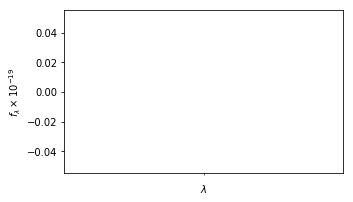

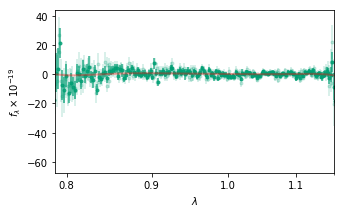

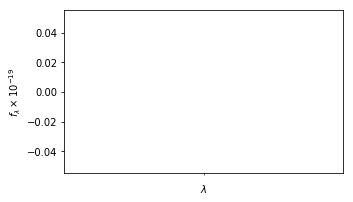

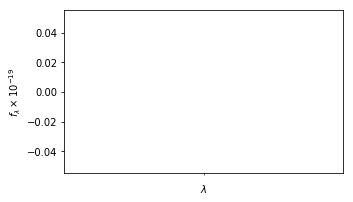

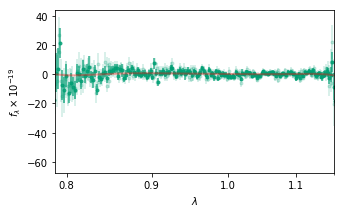

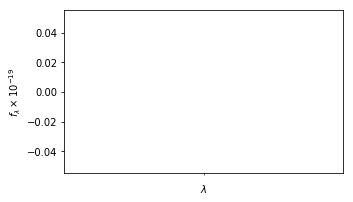

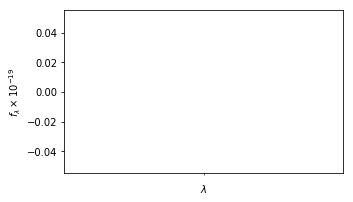

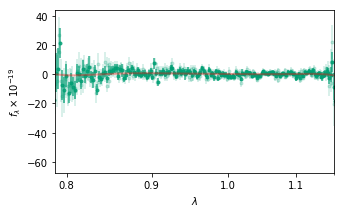

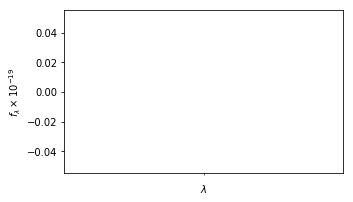

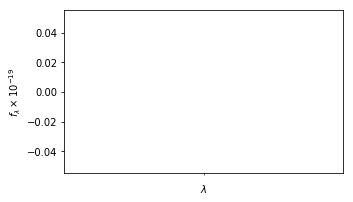

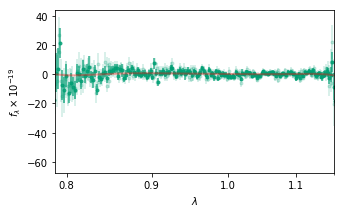

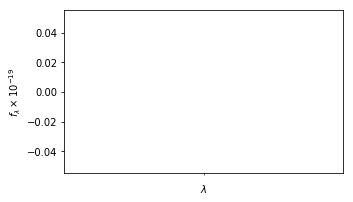

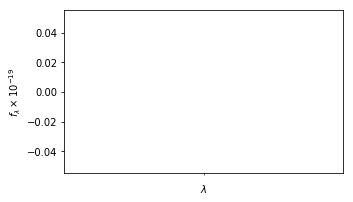

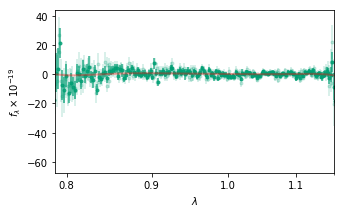

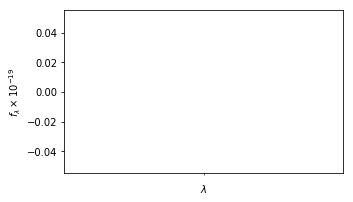

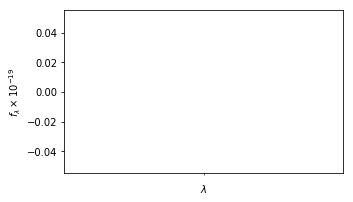

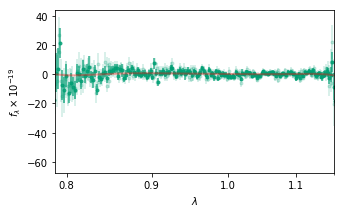

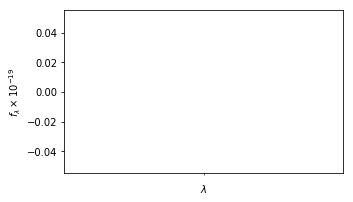

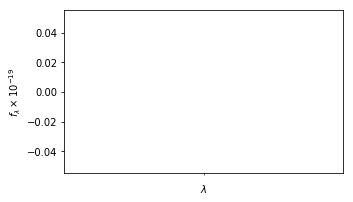

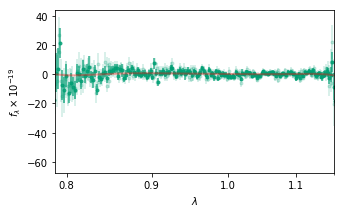

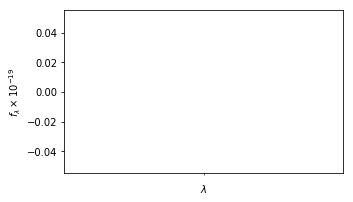

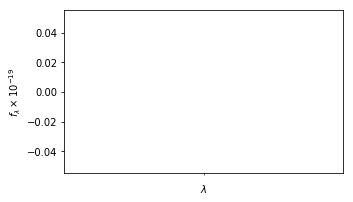

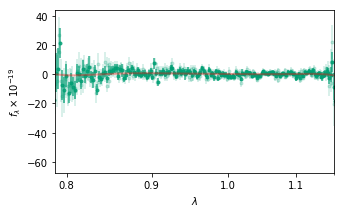

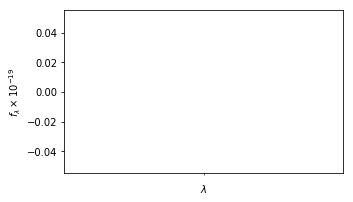

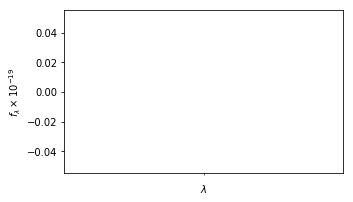

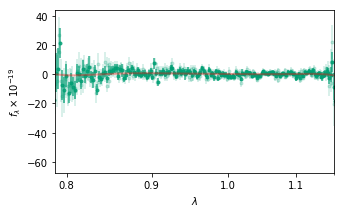

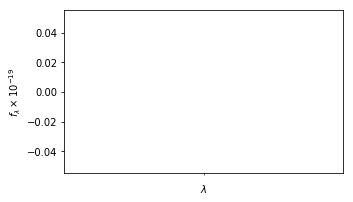

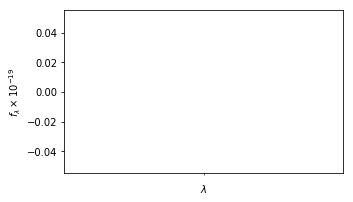

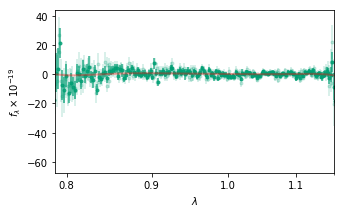

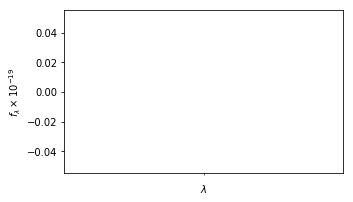

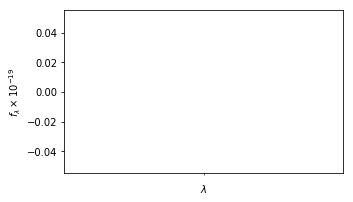

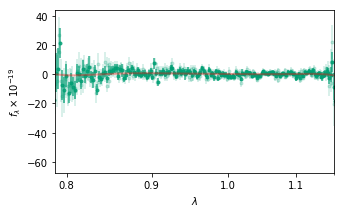

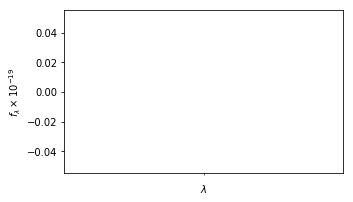

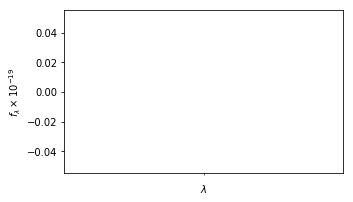

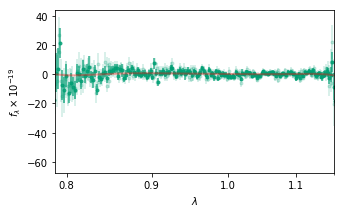

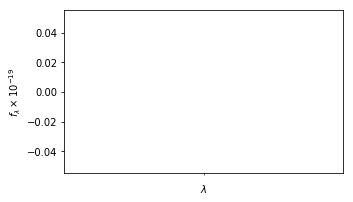

In [34]:
for id_i in source_ids:
    auto_script.extract(field_root=root, prior=a, MW_EBV=tabs[0].meta['MW_EBV'], 
                                pline=pline, fit_only_beams=True, run_fit=True, poly_order=7, 
                           grp=grp, diff=True)

### 2D spectra ###

The spectral extraction produces two versions of the extracted 2D spectra:

* `{root}_{id:05d}.beams.fits` : Multi-extension FITS file with sets of extensions for 2D cutouts **from each individual grism exposure**.  Fitting in this space is most robust as the grism dispersion is defined in the "FLT" coordinates and the model comparison is done directly on un-resampled image pixels with relatively well-understood noise properties.
    
    
* `{root}_{id:05d}.stack.fits` : Multi-extension FITS file with extension with combinations of all exposures in a given grism & position angle.  The fitting tools can be used with these products as well, where the fits are much faster as 2D models at each trial redshift are produced for `N_PA x N_grism` combinations, where often `N_PA x N_grism << N_exposure`.   The fits are evaluated in the resampled drizzled pixel space, and they are often less robust than fits to the full "beams" spectra, particularly at low S/N.
    
    The `{root}_{id:05d}.stack.png` files, shown below, are often useful for visual inspection of the 2D products.  Note that the bottom panel of the `stack.png` files is the drizzled combination of *all* PAs for a given grism, and with a polynomial continuum model subtracted if `diff=True` in the extraction script above.
    

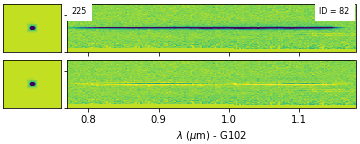

In [34]:
Image(filename='{0}_{1:05d}.stack.png'.format(root, id)) 

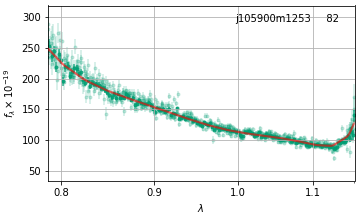

In [35]:
# 1D spectrum with polynomial model
Image(filename='{0}_{1:05d}.1D.png'.format(root, id)) 

### Redshift fit ###

The redshift fit is performed in the following steps:

* On a coarse redshift grid (dz/1+z ~ 0.005) fit continuum templates along with **line complex** templates for a) [OII]+[NeIII], b) [OIII]+Hbeta, and c) Halpha+[SII]+weaker red lines.  These line complexes have fixed line ratios but are useful for breaking redshift degeneracies as these lines do, usually, come in groups.  Leaving all line strengths free would allow for perfect degeneracy between, e.g., Halpha and [OII] (assuming no significant continuum features).

* Find peaks (minima) in the chi-squared on the coarse grid and zoom in on them now allowing for more freedom in the indifidual line strengths, as well as fitting on a fine redshift grid sufficient to resolve the best redshift.

**NB** Continuum templates are needed in the directory `${GRIZLI}/templates`.  The template names are currently hard-coded in [multifit.py](https://github.com/gbrammer/grizli/blob/master/grizli/multifit.py) and the easiest way to make them available is to symlink them from the `data/templates` directory that accompanies the `grizli` code distribution:


### Emission line maps ###

Once we've computed the full continuum + line model, we can create 2D *drizzled* maps at any desired output wavelength, for example to make emission line maps.  This makes use of the WCS information in the individual grism FLT exposures and the outputs can have any desired WCS (e.g., pixel scale & dimensions) and can be used to compare directly to imaging data.

The emission line maps are generated by subtracting the best-fit continuum model, assuming that the direct image is representative of the continuum morphology.  This should be a reasonable assumption for objects other than, perhaps, those with extreme line equivalent widths.


Run 82


(82, 1, 10.942651510238647)

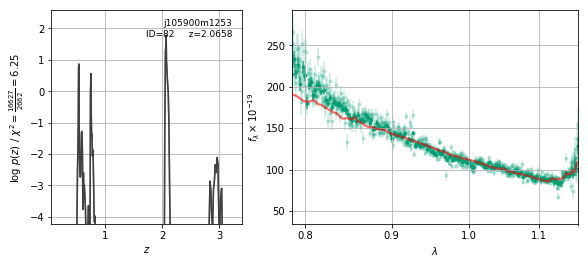

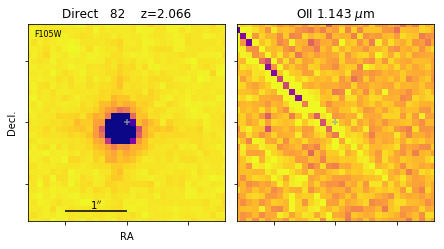

In [36]:
# Fit it.  The "run_all_parallel" function defaults to all of the parameters set in 'fit_args.npy'
fitting.run_all_parallel(id)

### Fit products ###

A number of files are produced that contain the results of the redshift fit.  The [`NewSpectrumFits.ipynb`](https://github.com/gbrammer/grizli/blob/master/examples/NewSpectrumFits.ipynb) notebook describes how to interact with these products in some greater detail.  

In [37]:
files = glob.glob('*{0:05d}*'.format(id))
for file in files:
    print(file)

j105900m1253_00082.stack.fits
j105900m1253_00082.stack.png
j105900m1253_00082.log_par
j105900m1253_00082.beams.fits
j105900m1253_00082.line.png
j105900m1253_00082.1D.png
j105900m1253_00082.full.fits
j105900m1253_00082.full.png
j105900m1253_00082.1D.fits


In [38]:
for file in files:
    if not file.endswith('.fits'):
        continue
        
    im = pyfits.open(file)
    print('\n\n{1}\n{0}\n{1}\n\n'.format(file, '='*len(file)))
    im.info()



j105900m1253_00082.stack.fits


Filename: j105900m1253_00082.stack.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      13   ()      
  1  SCI         G102,225.0 ImageHDU        54   (178, 64)   float32   
  2  WHT         G102,225.0 ImageHDU        22   (178, 64)   float32   
  3  CONTAM      G102,225.0 ImageHDU        22   (178, 64)   float32   
  4  MODEL       G102,225.0 ImageHDU        24   (178, 64)   float32   
  5  KERNEL      G102,225.0 ImageHDU        22   (64, 64)   float32   
  6  SCI         G102 ImageHDU        53   (178, 64)   float32   
  7  WHT         G102 ImageHDU        22   (178, 64)   float32   
  8  MODEL       G102 ImageHDU        24   (178, 64)   float32   
  9  KERNEL      G102 ImageHDU        22   (64, 64)   float32   


j105900m1253_00082.beams.fits


Filename: j105900m1253_00082.beams.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      21   ()      
  1 

### Continuum-dominated spectra ###

The object below is the dominated by strong Balmer break and absorption lines (see [van Dokkum & Brammer 2010](http://adsabs.harvard.edu/abs/2010ApJ...718L..73V)).  The redshift fit and spectral constraints are precise even without any supporting photometric data.

In [39]:
# Continuum source
id=source_ids[1]
auto_script.extract(field_root=root, ids=[id], MW_EBV=tabs[0].meta['MW_EBV'], 
                    pline=pline, run_fit=False, grp=grp, diff=True)

0/1: 482 4
j105900m1253_00482.beams.fits


True

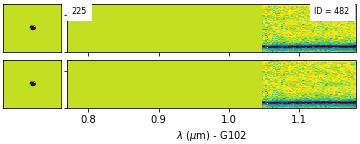

In [40]:
# Stacked 2D spectrum
Image(filename='{0}_{1:05d}.stack.png'.format(root, id)) 

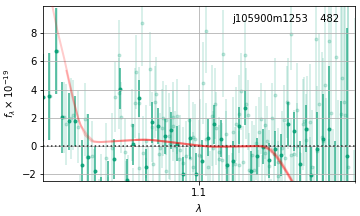

In [41]:
# 1D spectrum with polynomial model
Image(filename='{0}_{1:05d}.1D.png'.format(root, id)) 

Run 482


(482, 1, 10.058369636535645)

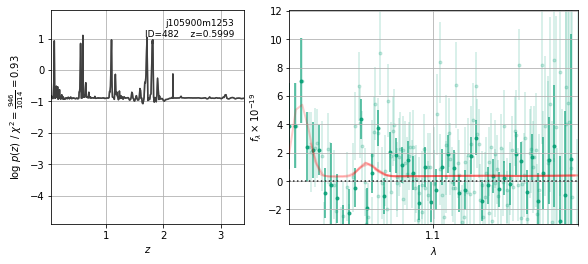

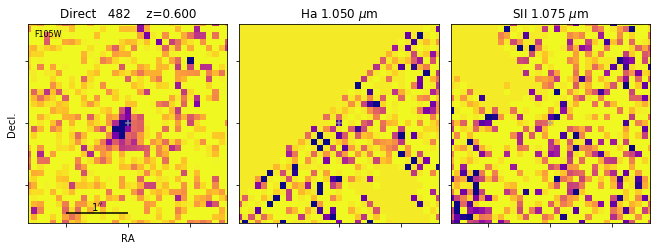

In [42]:
## Run the fit
fitting.run_all_parallel(id)

### Fit grism with photometry

Another option is fitting the grism spectra along with ancillary photometry, described here: [Fit-with-Photometry.ipynb](https://github.com/gbrammer/grizli/blob/master/examples/Fit-with-Photometry.ipynb).